In [10]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
import arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pykalman import KalmanFilter
import statistics
import csv

In [2]:
# !pip install pykalman

In [2]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('FR_next.csv')
df

Date   Prices   Generation forecast  \
0      2017-01-01 00:00:00    58.82               70810.0   
1      2017-01-01 01:00:00    58.23               69539.0   
2      2017-01-01 02:00:00    51.95               67376.0   
3      2017-01-01 03:00:00    47.27               65412.0   
4      2017-01-01 04:00:00    45.49               64557.0   
...                    ...      ...                   ...   
52580  2022-12-31 20:00:00     7.60               44648.0   
52581  2022-12-31 21:00:00     3.69               43841.0   
52582  2022-12-31 22:00:00     1.88               44578.0   
52583  2022-12-31 23:00:00     0.10               45135.0   
52584  2023-01-01 00:00:00     0.00                   NaN   

        System load forecast  
0                    75500.0  
1                    73650.0  
2                    72350.0  
3                    68750.0  
4                    65900.0  
...                      ...  
52580                46950.0  
52581                44350.0  
52582                43950.0  
52583                47250.0  
52584                    NaN  

[52585 rows x 4 columns]

In [3]:
dfb = df

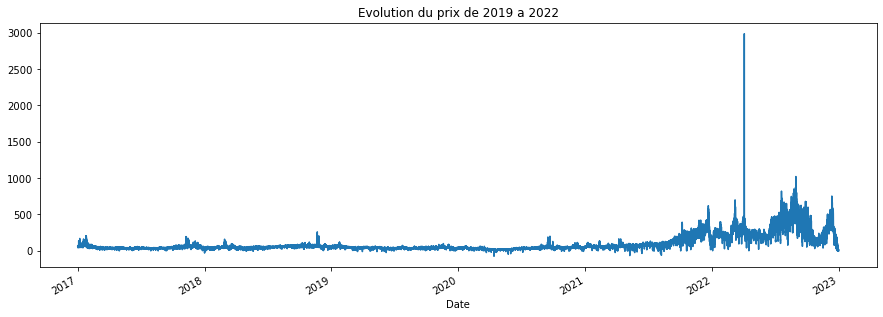

In [4]:
df_date = df

# Convertir la colonne Date en datetime
df_date['Date'] = pd.to_datetime(df_date['Date'])

# Définir la colonne Date comme index du dataframe
df_date.set_index('Date', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date[' Prices'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix de 2019 a 2022')

# Afficher le graphique
plt.show()

In [5]:
dfb = dfb.reset_index()

In [7]:
# Convertir la colonne Date en format datetime
dfb['Date'] = pd.to_datetime(dfb['Date'])

# Définir les bornes de la plage de dates souhaitée
start_date_train = '2017-01-01 00:00:00'
end_date_train = '2020-12-31 23:00:00'

start_date_test = '2021-01-01 00:00:00'
end_date_test = '2022-12-31 23:00:00'

# Sélectionner les lignes entre les bornes de dates
train_data = dfb.loc[(dfb['Date'] >= start_date_train) & (dfb['Date'] <= end_date_train)]

test_data = dfb.loc[(dfb['Date'] >= start_date_test) & (dfb['Date'] <= end_date_test)]

In [8]:
train_data

Date   Prices   Generation forecast  \
0     2017-01-01 00:00:00    58.82               70810.0   
1     2017-01-01 01:00:00    58.23               69539.0   
2     2017-01-01 02:00:00    51.95               67376.0   
3     2017-01-01 03:00:00    47.27               65412.0   
4     2017-01-01 04:00:00    45.49               64557.0   
...                   ...      ...                   ...   
35059 2020-12-31 19:00:00    60.54               70648.0   
35060 2020-12-31 20:00:00    56.75               69866.0   
35061 2020-12-31 21:00:00    52.44               68126.0   
35062 2020-12-31 22:00:00    51.86               67610.0   
35063 2020-12-31 23:00:00    52.26               67202.0   

        System load forecast  
0                    75500.0  
1                    73650.0  
2                    72350.0  
3                    68750.0  
4                    65900.0  
...                      ...  
35059                70850.0  
35060                67800.0  
35061                64900.0  
35062                64800.0  
35063                67550.0  

[35064 rows x 4 columns]

In [9]:

# replace missing values with the mean value of the column
test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)
display(test_data)

# replace missing values with the mean value of the column
train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)
display(train_data)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)


Date   Prices   Generation forecast  \
35064 2021-01-01 00:00:00    50.87               63690.0   
35065 2021-01-01 01:00:00    48.19               62414.0   
35066 2021-01-01 02:00:00    44.68               60612.0   
35067 2021-01-01 03:00:00    42.92               58978.0   
35068 2021-01-01 04:00:00    40.39               58520.0   
...                   ...      ...                   ...   
52579 2022-12-31 19:00:00    18.11               45503.0   
52580 2022-12-31 20:00:00     7.60               44648.0   
52581 2022-12-31 21:00:00     3.69               43841.0   
52582 2022-12-31 22:00:00     1.88               44578.0   
52583 2022-12-31 23:00:00     0.10               45135.0   

        System load forecast  
35064                66500.0  
35065                64600.0  
35066                63700.0  
35067                60600.0  
35068                58150.0  
...                      ...  
52579                49650.0  
52580                46950.0  
52581                44350.0  
52582                43950.0  
52583                47250.0  

[17520 rows x 4 columns]

C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)


Date   Prices   Generation forecast  \
0     2017-01-01 00:00:00    58.82               70810.0   
1     2017-01-01 01:00:00    58.23               69539.0   
2     2017-01-01 02:00:00    51.95               67376.0   
3     2017-01-01 03:00:00    47.27               65412.0   
4     2017-01-01 04:00:00    45.49               64557.0   
...                   ...      ...                   ...   
35059 2020-12-31 19:00:00    60.54               70648.0   
35060 2020-12-31 20:00:00    56.75               69866.0   
35061 2020-12-31 21:00:00    52.44               68126.0   
35062 2020-12-31 22:00:00    51.86               67610.0   
35063 2020-12-31 23:00:00    52.26               67202.0   

        System load forecast  
0                    75500.0  
1                    73650.0  
2                    72350.0  
3                    68750.0  
4                    65900.0  
...                      ...  
35059                70850.0  
35060                67800.0  
35061                64900.0  
35062                64800.0  
35063                67550.0  

[35064 rows x 4 columns]

In [10]:
# Set the length of the training set
train_len = len(train_data)
#print(train_len)

# Create an empty array to store the predictions
predictions = []

# Iterate over each point in the test set
for i in range(0, len(test_data), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset = train_data.iloc[:train_len, :]
    else:
        train_data_subset = pd.concat([train_data.iloc[i:, :], test_data.iloc[:i, :]], axis=0)
    #print("train data :", train_data_subset)
        
    # Fit the ARIMA model to the training data
    model = ARIMA(train_data_subset.iloc[:, 1], exog=train_data_subset.iloc[:, 2:], order=(1,1,1))
    result = model.fit()
    
    # Make one-day-ahead forecasts
    forecast = result.forecast(steps=24, exog=test_data.iloc[i:i+24, 2:])
    print("prédictions :", forecast)
    
    # Store the forecasts in the predictions array
    predictions.extend(forecast)
    


prédictions : 35064    46.322009
35065    43.694831
35066    40.526007
35067    36.957694
35068    35.476463
35069    34.267416
35070    34.521808
35071    35.707908
35072    36.243151
35073    38.255480
35074    41.222028
35075    44.044580
35076    46.082078
35077    45.786629
35078    43.536549
35079    42.999284
35080    46.410970
35081    49.238302
35082    52.697528
35083    52.918003
35084    52.377841
35085    50.337130
35086    49.182150
35087    48.643831
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be give

prédictions : 35064    47.134805
35065    43.755257
35066    40.902987
35067    37.959065
35068    37.522324
35069    38.919545
35070    42.486669
35071    46.219432
35072    49.504655
35073    52.865670
35074    56.889684
35075    59.022832
35076    60.249751
35077    59.137529
35078    57.007825
35079    56.037762
35080    56.268819
35081    57.661648
35082    61.007491
35083    61.119053
35084    59.213942
35085    55.635224
35086    54.522556
35087    53.604657
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.468932
35065    36.329925
35066    34.546173
35067    32.221244
35068    30.357849
35069    30.175867
35070    31.655899
35071    33.079085
35072    34.614437
35073    40.372242
35074    44.132960
35075    46.104427
35076    47.777310
35077    46.721993
35078    43.403890
35079    41.781084
35080    43.510115
35081    48.396309
35082    52.588402
35083    54.291966
35084    53.515602
35085    51.074468
35086    49.948716
35087    49.287056
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.225041
35065    46.999851
35066    44.036446
35067    41.522551
35068    41.121944
35069    45.732303
35070    53.647735
35071    58.947615
35072    63.299397
35073    64.226546
35074    65.722600
35075    66.921958
35076    67.049114
35077    65.269344
35078    66.091619
35079    61.836690
35080    63.191314
35081    67.587217
35082    71.560882
35083    72.001677
35084    66.201523
35085    61.036801
35086    59.337344
35087    58.882236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.122996
35065    50.780827
35066    48.464151
35067    44.852324
35068    42.851746
35069    48.591491
35070    54.182324
35071    60.897222
35072    63.587264
35073    66.133264
35074    66.898247
35075    68.034578
35076    70.013752
35077    67.590340
35078    65.141947
35079    62.271609
35080    60.692282
35081    64.829911
35082    70.100168
35083    72.538728
35084    63.934171
35085    56.555199
35086    54.354669
35087    55.296808
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.225200
35065    48.194168
35066    47.808194
35067    45.752022
35068    43.616701
35069    46.353576
35070    53.480931
35071    59.969888
35072    63.995227
35073    68.862578
35074    69.803919
35075    71.181175
35076    70.939288
35077    69.510025
35078    66.997890
35079    64.376442
35080    62.886175
35081    66.438347
35082    71.520811
35083    71.526337
35084    65.124205
35085    58.462042
35086    55.787266
35087    56.979527
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.799554
35065    53.878349
35066    52.153453
35067    49.672840
35068    50.763170
35069    52.587686
35070    60.290900
35071    67.839568
35072    73.975029
35073    77.641354
35074    79.284094
35075    79.591315
35076    79.632543
35077    78.467303
35078    74.903047
35079    73.175511
35080    73.356516
35081    77.211726
35082    80.596676
35083    80.893066
35084    76.099603
35085    67.831784
35086    63.780571
35087    63.382131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.845562
35065    58.866883
35066    57.651913
35067    55.156017
35068    54.685554
35069    56.991860
35070    64.582233
35071    73.636868
35072    80.147449
35073    82.948669
35074    84.535953
35075    85.211248
35076    85.072014
35077    82.684518
35078    79.298361
35079    75.550757
35080    74.676760
35081    77.511355
35082    81.154096
35083    81.601423
35084    76.836484
35085    69.888562
35086    65.187102
35087    65.888367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.923313
35065    60.995529
35066    59.604907
35067    56.013977
35068    53.520733
35069    54.097276
35070    57.549888
35071    62.205712
35072    66.009203
35073    69.093400
35074    71.504345
35075    73.605668
35076    73.399061
35077    72.702280
35078    70.112051
35079    68.764480
35080    68.030199
35081    74.993250
35082    75.773863
35083    77.738831
35084    72.589918
35085    69.529163
35086    68.836101
35087    70.109488
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.113083
35065    46.478386
35066    41.346577
35067    39.073723
35068    36.489400
35069    36.495180
35070    38.617960
35071    40.371938
35072    43.662372
35073    49.241695
35074    53.492718
35075    54.971947
35076    56.546769
35077    53.950961
35078    49.204607
35079    46.393638
35080    45.565261
35081    49.941906
35082    54.577466
35083    57.360111
35084    54.596763
35085    49.611720
35086    49.381884
35087    50.030208
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.704506
35065    54.750753
35066    52.651852
35067    49.544350
35068    49.313109
35069    53.377185
35070    61.622560
35071    72.258063
35072    78.520218
35073    80.977816
35074    81.989777
35075    81.758928
35076    81.058642
35077    79.629386
35078    77.523881
35079    75.762044
35080    73.964123
35081    79.428164
35082    83.265322
35083    84.909006
35084    80.405526
35085    73.288064
35086    71.007391
35087    71.858431
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    59.047091
35065    56.915327
35066    55.704191
35067    50.292111
35068    49.902422
35069    52.191408
35070    59.793951
35071    69.996987
35072    71.886860
35073    75.337291
35074    75.903731
35075    76.296702
35076    75.947125
35077    72.573743
35078    70.150409
35079    67.027689
35080    64.690173
35081    66.237386
35082    70.566063
35083    69.028070
35084    61.719432
35085    55.605983
35086    54.527152
35087    54.460600
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.357905
35065    53.698231
35066    51.078011
35067    48.144301
35068    47.015257
35069    50.745051
35070    57.585390
35071    65.605458
35072    69.907592
35073    72.162622
35074    73.304931
35075    73.523749
35076    74.002114
35077    72.427725
35078    70.461769
35079    68.405988
35080    67.417892
35081    69.420646
35082    72.345080
35083    72.553910
35084    65.459018
35085    60.181802
35086    59.515705
35087    60.491318
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.392330
35065    58.141086
35066    55.400558
35067    50.325903
35068    48.809942
35069    51.219958
35070    63.346384
35071    72.232914
35072    76.529277
35073    79.732764
35074    81.320566
35075    83.144515
35076    84.297773
35077    82.735509
35078    79.118895
35079    76.895274
35080    77.664853
35081    81.583308
35082    85.183552
35083    83.109213
35084    75.857647
35085    70.058724
35086    67.333873
35087    66.795451
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.068328
35065    46.362904
35066    43.331633
35067    41.187720
35068    41.321745
35069    46.243789
35070    56.211583
35071    65.547741
35072    71.036489
35073    72.502822
35074    73.615386
35075    74.439099
35076    73.400626
35077    70.861351
35078    67.375869
35079    64.451527
35080    64.486742
35081    64.953857
35082    68.031065
35083    68.768333
35084    61.403787
35085    53.680563
35086    51.406800
35087    51.522826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.610576
35065    50.569597
35066    46.375003
35067    42.959311
35068    41.351215
35069    41.254459
35070    42.958865
35071    48.030811
35072    52.315806
35073    55.815011
35074    58.939841
35075    59.548972
35076    61.819848
35077    59.800388
35078    56.727132
35079    55.260880
35080    55.805029
35081    58.325945
35082    62.256122
35083    62.521892
35084    59.551630
35085    53.361696
35086    51.954011
35087    51.826021
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.329534
35065    42.782578
35066    40.643896
35067    35.615569
35068    33.814807
35069    34.367401
35070    35.416201
35071    39.922683
35072    41.946481
35073    49.276353
35074    52.793789
35075    55.568839
35076    57.610794
35077    56.044810
35078    53.062644
35079    51.985002
35080    50.781075
35081    53.612762
35082    58.150298
35083    58.957842
35084    56.001564
35085    52.486400
35086    51.114769
35087    51.299645
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.188209
35065    49.797915
35066    47.165471
35067    44.456308
35068    45.503422
35069    49.453669
35070    58.939744
35071    67.058254
35072    71.448282
35073    73.448421
35074    73.657240
35075    73.416584
35076    73.376237
35077    71.891505
35078    69.119000
35079    65.729601
35080    65.202932
35081    68.961645
35082    74.272107
35083    74.548181
35084    69.491315
35085    64.390488
35086    63.337480
35087    64.536344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.394253
35065    58.567992
35066    55.850445
35067    50.536334
35068    49.657124
35069    52.637924
35070    63.504524
35071    72.509516
35072    76.480812
35073    77.787582
35074    78.255752
35075    78.871424
35076    79.118782
35077    76.509815
35078    70.888399
35079    66.789291
35080    65.460720
35081    69.195906
35082    74.637122
35083    76.902039
35084    70.891565
35085    62.338753
35086    61.164361
35087    61.960416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.537624
35065    45.458947
35066    41.572783
35067    36.887353
35068    36.256660
35069    38.397421
35070    46.690851
35071    54.886950
35072    59.017684
35073    61.125267
35074    62.324597
35075    61.972600
35076    61.410597
35077    58.818642
35078    56.184900
35079    53.970706
35080    53.682815
35081    56.953196
35082    60.940344
35083    60.346845
35084    53.472507
35085    46.230496
35086    45.075050
35087    45.421274
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.282375
35065    35.495484
35066    33.198029
35067    29.102700
35068    28.614007
35069    30.179128
35070    37.136022
35071    46.010771
35072    49.127019
35073    49.832037
35074    50.789091
35075    50.356815
35076    49.017169
35077    47.468830
35078    45.622909
35079    44.144514
35080    44.301610
35081    47.186608
35082    51.074439
35083    52.023101
35084    48.330537
35085    43.737649
35086    41.741502
35087    40.256838
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    33.418931
35065    28.868243
35066    26.856965
35067    24.926713
35068    24.057201
35069    25.942612
35070    34.771476
35071    46.053918
35072    49.698194
35073    50.525271
35074    49.060057
35075    50.351428
35076    51.827653
35077    50.986431
35078    47.986204
35079    46.304115
35080    46.818328
35081    49.947726
35082    53.694471
35083    53.969233
35084    49.199758
35085    44.699340
35086    41.899841
35087    42.690463
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.980530
35065    35.185122
35066    33.499314
35067    31.776012
35068    30.077730
35069    30.217579
35070    31.427383
35071    35.889703
35072    41.625410
35073    46.448129
35074    49.023890
35075    50.417378
35076    51.147486
35077    49.897010
35078    46.230136
35079    45.341456
35080    44.574159
35081    45.782481
35082    48.596920
35083    49.063547
35084    45.847813
35085    40.628484
35086    38.788550
35087    40.711048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.582452
35065    38.433124
35066    36.931650
35067    34.015857
35068    32.943124
35069    33.143568
35070    35.071931
35071    36.334895
35072    40.283193
35073    46.294846
35074    50.746366
35075    52.631181
35076    54.416627
35077    52.833011
35078    49.805662
35079    49.149117
35080    49.795767
35081    51.731088
35082    56.854647
35083    57.627795
35084    54.809688
35085    51.336005
35086    50.182652
35087    52.020635
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.040498
35065    39.688027
35066    39.337051
35067    38.401855
35068    38.503635
35069    43.386424
35070    52.245513
35071    61.964294
35072    65.495803
35073    67.733372
35074    68.952029
35075    69.860779
35076    69.545930
35077    68.219370
35078    64.864673
35079    61.601428
35080    60.251672
35081    61.540172
35082    64.462479
35083    64.374456
35084    58.733095
35085    53.602755
35086    52.930446
35087    52.987699
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.417260
35065    46.883328
35066    44.472292
35067    41.508772
35068    40.644725
35069    44.435975
35070    53.092630
35071    62.139261
35072    67.104080
35073    69.308225
35074    70.279043
35075    70.572867
35076    67.601573
35077    65.229668
35078    62.034283
35079    59.278203
35080    57.876776
35081    60.502104
35082    65.713330
35083    67.308118
35084    60.688984
35085    54.397594
35086    53.186952
35087    53.252440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.275438
35065    36.153066
35066    34.459095
35067    31.809445
35068    30.945230
35069    33.103633
35070    43.010726
35071    50.691758
35072    53.880969
35073    54.996955
35074    55.945739
35075    56.468847
35076    56.767776
35077    55.476382
35078    52.125881
35079    49.725381
35080    49.649485
35081    51.569412
35082    55.730626
35083    56.769855
35084    51.547839
35085    45.656583
35086    43.283282
35087    43.028786
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.968792
35065    43.415971
35066    42.478959
35067    40.977512
35068    41.105903
35069    45.702483
35070    54.322378
35071    62.148150
35072    65.580671
35073    67.941900
35074    69.181926
35075    69.814535
35076    68.970194
35077    68.205074
35078    65.504747
35079    62.524410
35080    60.931493
35081    60.601496
35082    63.844524
35083    63.822756
35084    58.884171
35085    52.558500
35086    50.095975
35087    49.852407
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.120532
35065    34.884753
35066    32.423801
35067    31.277911
35068    31.077091
35069    33.121215
35070    40.045235
35071    48.369268
35072    50.142579
35073    53.291684
35074    54.295508
35075    55.662535
35076    56.244940
35077    54.654471
35078    51.637721
35079    49.648875
35080    48.503791
35081    48.656315
35082    50.054794
35083    49.502803
35084    45.258673
35085    39.819954
35086    36.209461
35087    34.611953
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.508437
35065    32.935724
35066    30.332652
35067    26.702962
35068    25.433562
35069    25.854977
35070    29.256304
35071    32.347483
35072    37.287798
35073    42.487182
35074    45.431150
35075    46.041676
35076    48.195934
35077    50.013381
35078    47.143985
35079    45.783975
35080    45.221282
35081    47.719159
35082    51.627560
35083    51.907824
35084    48.560620
35085    43.226378
35086    41.867296
35087    43.347647
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.631968
35065    33.541864
35066    31.716432
35067    29.137315
35068    27.642608
35069    27.397542
35070    27.573111
35071    28.232523
35072    30.399436
35073    37.326257
35074    39.910983
35075    41.968013
35076    43.725173
35077    41.008163
35078    38.282522
35079    37.967195
35080    39.066234
35081    41.581498
35082    46.063977
35083    47.078834
35084    45.173285
35085    42.007221
35086    40.290273
35087    40.022668
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.951629
35065    39.008446
35066    38.366173
35067    36.773307
35068    36.369090
35069    40.201613
35070    48.729049
35071    56.556623
35072    59.533051
35073    60.879527
35074    61.821035
35075    62.994475
35076    63.974246
35077    62.828574
35078    60.838535
35079    59.821075
35080    58.270642
35081    59.214863
35082    63.050114
35083    63.920672
35084    58.866216
35085    54.970623
35086    53.359567
35087    51.272581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.666714
35065    42.208731
35066    40.099520
35067    38.240899
35068    36.536474
35069    38.958164
35070    48.529336
35071    58.420872
35072    62.284896
35073    63.866302
35074    64.213170
35075    63.987371
35076    65.190268
35077    63.292873
35078    59.375541
35079    56.381068
35080    54.756351
35081    55.119590
35082    58.163432
35083    57.160254
35084    51.226903
35085    47.227375
35086    45.538527
35087    45.814405
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.231431
35065    32.095346
35066    28.336520
35067    26.809877
35068    25.967548
35069    27.470461
35070    35.757808
35071    42.973683
35072    45.894170
35073    48.188835
35074    50.265411
35075    52.988349
35076    53.690024
35077    52.011695
35078    49.043799
35079    46.621124
35080    43.702222
35081    43.601081
35082    46.946685
35083    46.791815
35084    42.132945
35085    36.736052
35086    33.094929
35087    32.398001
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.354081
35065    34.655577
35066    33.178318
35067    32.797212
35068    32.258065
35069    34.239080
35070    42.199473
35071    50.610502
35072    52.188404
35073    52.675352
35074    54.153561
35075    54.371726
35076    55.623870
35077    55.133744
35078    52.918730
35079    51.361393
35080    50.490239
35081    51.781918
35082    57.027757
35083    58.317901
35084    54.490227
35085    49.793002
35086    46.602509
35087    46.300615
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.540520
35065    38.836102
35066    37.818717
35067    36.339941
35068    36.205397
35069    38.047760
35070    46.058804
35071    53.119778
35072    54.967040
35073    55.653333
35074    55.401789
35075    55.705283
35076    56.266658
35077    55.210286
35078    52.066407
35079    50.012100
35080    48.486007
35081    49.592956
35082    53.502288
35083    53.570546
35084    50.543684
35085    44.547203
35086    41.030353
35087    41.930390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.400561
35065    38.121121
35066    35.301224
35067    33.055132
35068    32.341085
35069    32.947837
35070    34.486402
35071    35.900582
35072    37.805930
35073    40.635964
35074    42.548914
35075    42.620262
35076    43.038535
35077    41.197952
35078    39.043208
35079    36.992513
35080    37.027618
35081    38.538179
35082    42.647723
35083    44.682186
35084    42.146006
35085    39.212814
35086    37.978007
35087    38.724882
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.387333
35065    20.270174
35066    18.027691
35067    14.707541
35068    13.123909
35069    13.769307
35070    15.294021
35071    16.722910
35072    18.364943
35073    23.288746
35074    28.134634
35075    30.941189
35076    32.917844
35077    30.965293
35078    27.007248
35079    24.403276
35080    23.565400
35081    26.052485
35082    31.124025
35083    33.751211
35084    31.835655
35085    27.376420
35086    25.627228
35087    26.161300
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.049825
35065    32.816292
35066    30.601380
35067    28.456870
35068    28.812943
35069    33.446191
35070    44.761434
35071    52.971884
35072    57.879269
35073    60.961218
35074    63.156523
35075    64.342143
35076    63.838299
35077    61.771148
35078    59.647186
35079    57.412314
35080    56.099284
35081    57.313912
35082    62.387849
35083    64.534134
35084    60.436428
35085    53.909593
35086    51.556417
35087    50.489858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.201050
35065    41.137668
35066    39.045411
35067    37.438922
35068    37.382113
35069    40.356701
35070    50.787633
35071    58.341680
35072    61.892827
35073    63.902274
35074    64.989144
35075    66.044436
35076    66.061820
35077    64.848574
35078    61.990893
35079    60.417568
35080    59.471358
35081    61.471334
35082    66.177204
35083    66.880042
35084    62.060413
35085    57.277164
35086    54.500055
35087    54.294510
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.684450
35065    43.616927
35066    42.546525
35067    40.703714
35068    40.070563
35069    43.505058
35070    52.557227
35071    58.908405
35072    63.098947
35073    65.929762
35074    67.489250
35075    68.717086
35076    69.276256
35077    67.751775
35078    64.568964
35079    62.132180
35080    60.668009
35081    60.389771
35082    62.982437
35083    64.605206
35084    59.242112
35085    53.787635
35086    52.737660
35087    53.024029
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.137936
35065    52.583077
35066    50.712366
35067    48.883677
35068    48.462330
35069    51.735426
35070    60.393467
35071    69.773252
35072    71.851311
35073    74.620709
35074    76.194727
35075    76.991384
35076    76.547580
35077    74.972821
35078    72.338503
35079    69.582794
35080    70.129846
35081    71.420281
35082    73.439542
35083    75.531591
35084    69.194089
35085    63.171227
35086    60.920608
35087    60.576479
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.745679
35065    48.977149
35066    47.363010
35067    43.579156
35068    44.331496
35069    46.105837
35070    55.441897
35071    62.137079
35072    66.682720
35073    67.939455
35074    67.839436
35075    66.445846
35076    65.118501
35077    63.108525
35078    59.804227
35079    57.244080
35080    56.911024
35081    59.294060
35082    62.273755
35083    63.461786
35084    58.694961
35085    52.570037
35086    50.896286
35087    51.752446
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.546470
35065    39.438940
35066    37.712483
35067    34.893200
35068    34.500746
35069    35.468151
35070    36.944328
35071    41.033533
35072    45.744824
35073    49.583511
35074    51.748604
35075    52.345067
35076    53.660413
35077    51.100807
35078    46.702664
35079    43.760651
35080    43.765780
35081    44.921966
35082    49.478378
35083    51.496185
35084    48.011008
35085    44.844786
35086    43.984405
35087    43.727357
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    43.649887
35065    40.400118
35066    37.719033
35067    34.618677
35068    33.874565
35069    34.408238
35070    36.465400
35071    38.207160
35072    40.558958
35073    44.684255
35074    47.936369
35075    48.790582
35076    49.120997
35077    46.448361
35078    42.692353
35079    41.118537
35080    40.128073
35081    43.055293
35082    49.292950
35083    52.936630
35084    50.265873
35085    46.312692
35086    45.428503
35087    46.207329
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.799652
35065    38.006436
35066    36.848084
35067    34.314711
35068    33.715368
35069    37.150099
35070    47.022665
35071    56.463052
35072    58.682032
35073    61.321382
35074    63.075811
35075    64.489078
35076    63.522239
35077    60.978609
35078    57.704075
35079    54.254170
35080    52.198749
35081    53.241189
35082    57.291638
35083    59.999683
35084    53.571153
35085    49.825372
35086    47.897017
35087    45.733170
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.327732
35065    40.174866
35066    39.445649
35067    37.124572
35068    35.962550
35069    40.397554
35070    46.953315
35071    55.430868
35072    58.039402
35073    59.834420
35074    59.275195
35075    58.499074
35076    58.228845
35077    55.814352
35078    52.499610
35079    50.120239
35080    47.954837
35081    48.270221
35082    52.614355
35083    56.527433
35084    51.700214
35085    46.336998
35086    41.496163
35087    40.619833
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.298699
35065    35.934695
35066    32.832941
35067    31.518076
35068    30.465180
35069    33.913338
35070    40.461694
35071    47.221073
35072    51.143762
35073    53.651096
35074    55.059767
35075    56.018067
35076    56.627560
35077    55.336390
35078    52.435442
35079    49.715688
35080    48.646404
35081    50.380991
35082    53.951825
35083    55.862865
35084    51.531907
35085    44.867334
35086    43.270318
35087    42.180765
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.268142
35065    38.473570
35066    36.629177
35067    34.207571
35068    34.883527
35069    38.967160
35070    46.994256
35071    54.515898
35072    57.408241
35073    57.441465
35074    56.057042
35075    55.424812
35076    55.555982
35077    54.188928
35078    51.171589
35079    48.656876
35080    47.514158
35081    46.984855
35082    50.716649
35083    55.019392
35084    50.360082
35085    44.909007
35086    40.886921
35087    39.833589
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.410318
35065    32.285646
35066    30.797738
35067    29.681158
35068    28.971187
35069    32.263442
35070    40.745006
35071    50.701463
35072    53.300256
35073    55.437162
35074    54.010007
35075    53.317624
35076    54.640413
35077    52.481366
35078    51.879923
35079    50.598678
35080    50.838203
35081    51.927021
35082    55.970305
35083    57.757781
35084    51.890595
35085    45.996198
35086    43.517622
35087    41.767402
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.048491
35065    22.340076
35066    22.154959
35067    21.245337
35068    20.733680
35069    20.719467
35070    21.088997
35071    21.643292
35072    22.055460
35073    22.623967
35074    22.695031
35075    22.453415
35076    22.510266
35077    22.311288
35078    21.145848
35079    20.349937
35080    19.880919
35081    19.866706
35082    20.833169
35083    22.467628
35084    21.984396
35085    21.160060
35086    20.989508
35087    21.899120
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.356776
35065    32.854400
35066    30.234028
35067    28.161350
35068    27.106226
35069    27.956815
35070    30.146094
35071    31.717316
35072    34.550236
35073    37.468515
35074    39.845349
35075    40.723703
35076    41.004610
35077    39.627005
35078    36.816978
35079    35.998139
35080    35.181731
35081    39.734620
35082    45.661620
35083    48.652297
35084    45.540896
35085    43.183575
35086    42.152700
35087    42.296379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.276619
35065    35.435822
35066    34.399381
35067    31.002697
35068    32.335512
35069    37.067853
35070    45.788547
35071    53.868842
35072    54.257061
35073    54.675430
35074    51.618463
35075    51.518557
35076    52.073845
35077    50.533969
35078    48.856990
35079    49.447984
35080    47.744656
35081    48.671315
35082    55.718597
35083    60.427176
35084    55.919152
35085    49.343294
35086    46.712891
35087    45.206082
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.134820
35065    34.288322
35066    32.764542
35067    30.681806
35068    30.422250
35069    33.729096
35070    41.090301
35071    48.887380
35072    51.460973
35073    53.436448
35074    52.503156
35075    51.773652
35076    52.050884
35077    51.625934
35078    48.279570
35079    47.010082
35080    44.741531
35081    43.929869
35082    49.572456
35083    53.143712
35084    49.511061
35085    44.118293
35086    38.594822
35087    37.925305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    29.229502
35065    27.518419
35066    26.137235
35067    23.308394
35068    22.452408
35069    24.589041
35070    30.357644
35071    37.439621
35072    39.334398
35073    39.924025
35074    39.485041
35075    39.583514
35076    40.555796
35077    39.378391
35078    37.792209
35079    35.892540
35080    36.784036
35081    36.511655
35082    42.460312
35083    45.161685
35084    41.380660
35085    37.823270
35086    34.746793
35087    34.292645
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    31.537607
35065    28.715679
35066    26.763228
35067    24.460376
35068    23.392008
35069    25.860648
35070    34.129487
35071    40.766656
35072    41.755033
35073    42.446928
35074    41.812985
35075    41.873799
35076    42.508132
35077    41.829908
35078    40.335653
35079    40.837617
35080    41.782848
35081    43.759823
35082    48.852052
35083    53.446705
35084    48.371297
35085    44.348486
35086    41.739075
35087    40.129934
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.678645
35065    37.148381
35066    36.129775
35067    33.752844
35068    33.658930
35069    38.716517
35070    48.586852
35071    53.632033
35072    55.241509
35073    56.279028
35074    54.008792
35075    52.405804
35076    52.354285
35077    50.827082
35078    47.947853
35079    46.687368
35080    46.231694
35081    46.950626
35082    52.080709
35083    55.579952
35084    52.477943
35085    46.854392
35086    43.982752
35087    43.063764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.872973
35065    33.719380
35066    32.450836
35067    30.583317
35068    28.856615
35069    31.776613
35070    33.936927
35071    38.414941
35072    41.013960
35073    44.075089
35074    45.661154
35075    44.794814
35076    45.337266
35077    43.291873
35078    39.760978
35079    37.121426
35080    35.073101
35081    38.205537
35082    45.561429
35083    50.410049
35084    47.019227
35085    41.718626
35086    39.872014
35087    42.598830
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.301219
35065    36.434872
35066    34.763889
35067    32.488790
35068    31.252817
35069    32.201999
35070    33.777255
35071    35.384201
35072    37.559337
35073    38.562687
35074    39.071513
35075    39.410797
35076    40.983680
35077    36.144696
35078    33.058622
35079    31.437574
35080    31.337199
35081    33.023116
35082    43.207562
35083    46.940675
35084    45.348108
35085    42.707850
35086    41.280456
35087    41.630926
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.259095
35065    34.500315
35066    33.084500
35067    31.926478
35068    31.562295
35069    35.397387
35070    46.824740
35071    52.856852
35072    55.909721
35073    56.369976
35074    54.136128
35075    52.964317
35076    52.367732
35077    50.245000
35078    46.807474
35079    46.296378
35080    44.388002
35081    47.830150
35082    51.963145
35083    55.824452
35084    52.440298
35085    47.081281
35086    44.185569
35087    47.756083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.068397
35065    34.405309
35066    33.577887
35067    32.075739
35068    32.064108
35069    34.900089
35070    42.998044
35071    48.309360
35072    50.011997
35073    49.319089
35074    46.154682
35075    44.716184
35076    44.472852
35077    42.636117
35078    40.494967
35079    38.825894
35080    38.176368
35081    41.397069
35082    45.648717
35083    49.589951
35084    47.214591
35085    42.104508
35086    39.931196
35087    45.146228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.455468
35065    41.287307
35066    39.882137
35067    37.775050
35068    37.694375
35069    39.925819
35070    47.881823
35071    53.740370
35072    54.215209
35073    54.477138
35074    52.122686
35075    51.054494
35076    50.767771
35077    49.047788
35078    47.032036
35079    45.258736
35080    44.720516
35081    46.654231
35082    50.395671
35083    53.951512
35084    50.444649
35085    44.340678
35086    44.343646
35087    47.362860
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.820357
35065    47.078125
35066    45.461021
35067    43.720252
35068    43.122568
35069    45.624897
35070    52.064113
35071    58.507954
35072    60.880699
35073    61.753515
35074    60.999432
35075    61.198993
35076    61.890585
35077    61.153602
35078    59.438080
35079    57.772453
35080    56.515585
35081    56.862217
35082    60.789101
35083    64.310660
35084    59.680171
35085    54.724585
35086    52.841425
35087    53.032237
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.024229
35065    42.862025
35066    41.453563
35067    39.115621
35068    39.350768
35069    43.743205
35070    51.066006
35071    57.070501
35072    61.696024
35073    63.898539
35074    63.521902
35075    61.844762
35076    61.973017
35077    61.147047
35078    58.642391
35079    56.488283
35080    56.550186
35081    57.217081
35082    61.449516
35083    64.620133
35084    60.773784
35085    56.995176
35086    55.526392
35087    56.180634
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.945103
35065    37.224975
35066    34.787863
35067    32.650745
35068    32.165842
35069    33.001499
35070    35.291231
35071    35.471852
35072    36.726257
35073    38.685856
35074    37.148358
35075    37.773116
35076    38.512442
35077    37.986431
35078    35.134915
35079    34.505334
35080    35.641620
35081    39.608739
35082    43.289310
35083    47.354693
35084    46.501701
35085    42.414584
35086    41.511735
35087    41.411678
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.588354
35065    36.287351
35066    34.651453
35067    32.209736
35068    30.745198
35069    31.879820
35070    34.130336
35071    34.043355
35072    35.652016
35073    37.675384
35074    38.800576
35075    40.026136
35076    40.786786
35077    38.256740
35078    34.303483
35079    31.780076
35080    32.571818
35081    38.928422
35082    45.473026
35083    49.889697
35084    48.880056
35085    46.870689
35086    45.982295
35087    46.134965
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.358100
35065    42.331912
35066    41.356334
35067    39.632962
35068    38.624258
35069    42.578502
35070    51.211773
35071    59.821645
35072    62.079066
35073    63.518780
35074    60.690880
35075    60.008820
35076    59.905637
35077    58.588694
35078    56.201407
35079    54.698609
35080    53.709628
35081    56.977873
35082    58.666790
35083    62.718410
35084    60.747933
35085    55.679307
35086    51.590724
35087    51.039561
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.482258
35065    46.265497
35066    45.011791
35067    43.767285
35068    43.965403
35069    46.578178
35070    53.137447
35071    61.224293
35072    62.773882
35073    64.145142
35074    63.713939
35075    63.986054
35076    64.590422
35077    63.507575
35078    61.134457
35079    59.122192
35080    57.021956
35081    58.205755
35082    60.598584
35083    63.787162
35084    61.522214
35085    56.076744
35086    53.349234
35087    53.103317
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.519516
35065    50.757754
35066    49.397013
35067    48.017203
35068    47.576800
35069    50.957355
35070    58.650629
35071    63.974571
35072    66.509898
35073    67.612496
35074    66.578581
35075    66.144795
35076    66.929216
35077    65.210743
35078    62.346849
35079    60.026054
35080    59.417744
35081    60.944059
35082    64.649400
35083    69.156151
35084    65.612733
35085    60.432437
35086    57.001478
35087    55.643371
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.065651
35065    34.294843
35066    31.630549
35067    27.911784
35068    26.418099
35069    29.598194
35070    37.500276
35071    44.533973
35072    48.192215
35073    48.672253
35074    47.916899
35075    47.691664
35076    48.492042
35077    46.607787
35078    43.433944
35079    40.637478
35080    39.988909
35081    42.055822
35082    46.664707
35083    51.552468
35084    49.485461
35085    43.998031
35086    42.600408
35087    42.304727
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.127233
35065    31.638190
35066    29.347834
35067    26.433343
35068    26.530650
35069    30.639031
35070    38.561931
35071    47.542208
35072    51.758065
35073    53.936002
35074    52.887894
35075    52.171126
35076    50.549973
35077    48.100913
35078    45.724635
35079    43.207648
35080    43.879235
35081    46.728586
35082    50.667720
35083    53.114736
35084    52.592591
35085    45.996103
35086    44.666713
35087    45.911749
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.216526
35065    34.754662
35066    31.302534
35067    26.653445
35068    23.573371
35069    23.563558
35070    27.657131
35071    30.018458
35072    34.447587
35073    37.737114
35074    38.069689
35075    38.038349
35076    38.963046
35077    37.984929
35078    30.966443
35079    28.344182
35080    26.287592
35081    27.690250
35082    35.546761
35083    39.514886
35084    38.125022
35085    33.238619
35086    32.948780
35087    35.220581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    26.950448
35065    22.049087
35066    19.982658
35067    17.393912
35068    15.989203
35069    16.000410
35070    17.625043
35071    20.041181
35072    22.632298
35073    25.374898
35074    26.364384
35075    27.648148
35076    28.933701
35077    26.475113
35078    20.879680
35079    18.573633
35080    18.775287
35081    25.801444
35082    30.951988
35083    35.379543
35084    35.017271
35085    31.933753
35086    30.789347
35087    30.271238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.931533
35065    40.227386
35066    38.534863
35067    37.371755
35068    37.628090
35069    41.233193
35070    50.699359
35071    54.638519
35072    58.113756
35073    58.189615
35074    57.220435
35075    56.789686
35076    57.815155
35077    56.096376
35078    52.546861
35079    49.966562
35080    48.298939
35081    49.819502
35082    53.703908
35083    56.883833
35084    52.569949
35085    47.939236
35086    45.858736
35087    45.974639
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.706802
35065    41.951825
35066    39.581548
35067    37.373027
35068    37.894017
35069    41.509920
35070    50.326948
35071    55.940995
35072    59.268972
35073    60.703227
35074    60.674435
35075    61.871589
35076    61.951498
35077    60.446526
35078    58.732295
35079    57.310441
35080    58.354585
35081    60.041286
35082    64.212419
35083    67.665344
35084    63.863164
35085    60.268976
35086    57.375684
35087    56.252069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.599615
35065    43.217194
35066    39.946835
35067    36.273335
35068    36.480720
35069    39.337834
35070    48.129513
35071    55.782751
35072    58.445129
35073    59.987918
35074    59.581167
35075    59.425080
35076    60.043660
35077    57.906010
35078    55.904906
35079    54.262514
35080    52.870185
35081    53.018383
35082    56.769202
35083    61.119133
35084    58.000728
35085    52.769929
35086    49.131063
35087    49.796429
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.484336
35065    53.428586
35066    52.004678
35067    50.509880
35068    50.673024
35069    53.075613
35070    60.115036
35071    64.550607
35072    67.400859
35073    69.914642
35074    69.597901
35075    68.661881
35076    69.538070
35077    68.957608
35078    66.307008
35079    64.907698
35080    63.894075
35081    65.134615
35082    67.618613
35083    70.850341
35084    67.787916
35085    61.335924
35086    59.558672
35087    59.710767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.571087
35065    45.654664
35066    45.105995
35067    43.779335
35068    43.683759
35069    46.068644
35070    53.885542
35071    58.198440
35072    61.014661
35073    62.184584
35074    59.862275
35075    58.270450
35076    60.054476
35077    59.306551
35078    54.846544
35079    52.357109
35080    50.484490
35081    52.886138
35082    58.261134
35083    62.645173
35084    59.063238
35085    53.386332
35086    51.705002
35087    53.151907
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.708137
35065    51.662986
35066    49.105906
35067    46.450793
35068    45.183518
35069    46.368166
35070    47.152616
35071    49.986630
35072    51.293136
35073    53.130461
35074    54.103150
35075    55.257328
35076    54.553066
35077    53.506656
35078    48.716909
35079    47.607987
35080    48.303625
35081    49.708559
35082    52.664001
35083    56.111328
35084    52.272582
35085    46.940523
35086    46.421916
35087    47.112823
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.066094
35065    41.858262
35066    38.083715
35067    35.025626
35068    33.879886
35069    33.939095
35070    35.130196
35071    36.060800
35072    39.344439
35073    43.831174
35074    44.530504
35075    46.128707
35076    46.974260
35077    44.516819
35078    39.263096
35079    37.511582
35080    37.379044
35081    43.335642
35082    49.962565
35083    55.707024
35084    54.490680
35085    52.265386
35086    50.485794
35087    51.328948
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.908243
35065    46.352576
35066    45.082850
35067    43.600061
35068    43.489132
35069    48.522568
35070    56.832527
35071    63.496609
35072    66.099839
35073    68.421400
35074    68.743405
35075    67.638297
35076    68.545321
35077    66.836751
35078    64.192243
35079    62.061118
35080    60.756031
35081    61.378027
35082    62.450787
35083    65.615861
35084    63.808802
35085    58.152921
35086    55.161575
35087    55.027006
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.388511
35065    51.214656
35066    51.027186
35067    49.433957
35068    49.190919
35069    51.779900
35070    57.385038
35071    63.091350
35072    65.462356
35073    66.077695
35074    65.031087
35075    64.797414
35076    64.491459
35077    62.477193
35078    59.248468
35079    57.280234
35080    55.878867
35081    55.299800
35082    57.814913
35083    61.816479
35084    60.710119
35085    56.392908
35086    53.291738
35087    54.057256
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.163412
35065    56.482479
35066    54.853468
35067    53.609404
35068    54.020354
35069    56.378061
35070    61.451461
35071    66.756210
35072    69.154950
35073    69.803094
35074    68.709289
35075    69.099657
35076    68.422895
35077    65.648882
35078    62.255211
35079    60.310645
35080    60.112898
35081    60.539798
35082    64.229109
35083    68.229899
35084    67.214271
35085    63.227855
35086    60.731826
35087    60.264019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.387152
35065    52.576495
35066    51.483919
35067    50.351673
35068    50.526322
35069    54.993859
35070    61.305284
35071    65.218044
35072    67.027461
35073    67.798334
35074    66.350706
35075    64.669712
35076    65.266877
35077    64.466279
35078    61.587316
35079    60.508699
35080    60.234018
35081    62.016060
35082    65.464218
35083    69.259293
35084    67.937054
35085    63.322273
35086    59.433000
35087    57.664051
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.746540
35065    41.338503
35066    39.644524
35067    37.260221
35068    37.281244
35069    41.346846
35070    48.159101
35071    53.527747
35072    55.834424
35073    57.482379
35074    55.293345
35075    55.658064
35076    56.814861
35077    53.727462
35078    49.920679
35079    49.771608
35080    49.189115
35081    52.199385
35082    53.155515
35083    57.692181
35084    56.547857
35085    52.121991
35086    50.459148
35087    48.484015
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.093686
35065    41.327956
35066    38.327008
35067    36.043162
35068    35.171305
35069    34.835861
35070    36.105299
35071    38.785217
35072    43.582528
35073    46.455236
35074    46.995224
35075    46.603747
35076    48.265883
35077    45.072786
35078    40.942048
35079    37.162738
35080    33.956273
35081    37.906473
35082    43.097063
35083    45.521052
35084    47.424832
35085    43.205074
35086    42.589362
35087    42.676216
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.155880
35065    41.387236
35066    39.932278
35067    37.270225
35068    36.498985
35069    37.722722
35070    38.483621
35071    40.000091
35072    43.006960
35073    44.966620
35074    45.749384
35075    46.753210
35076    40.577921
35077    35.900067
35078    32.843739
35079    30.305442
35080    36.516051
35081    41.165995
35082    45.318877
35083    48.075845
35084    49.240613
35085    48.188335
35086    47.832020
35087    44.944064
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    24.010423
35065    21.789275
35066    20.531159
35067    21.250684
35068    24.169223
35069    33.244561
35070    39.779002
35071    42.576621
35072    44.334123
35073    44.041417
35074    43.638616
35075    41.676718
35076    35.906854
35077    33.190759
35078    30.926141
35079    29.238564
35080    28.429615
35081    33.264369
35082    35.034519
35083    35.946254
35084    34.545928
35085    33.973364
35086    34.000786
35087    30.880272
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.480132
35065    42.526060
35066    41.441884
35067    43.054062
35068    45.697895
35069    52.422980
35070    59.689577
35071    60.645473
35072    60.429095
35073    58.594756
35074    56.863501
35075    57.776309
35076    55.347718
35077    54.017129
35078    52.784522
35079    51.224171
35080    51.812637
35081    53.891029
35082    55.856805
35083    56.909326
35084    53.971431
35085    51.511770
35086    51.180844
35087    47.411683
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.896391
35065    54.104251
35066    52.643134
35067    52.742341
35068    54.600122
35069    59.680395
35070    66.282094
35071    66.631426
35072    65.510803
35073    65.872126
35074    65.047126
35075    64.399592
35076    62.166196
35077    60.358558
35078    58.770587
35079    56.416898
35080    59.988385
35081    62.310638
35082    63.808932
35083    63.220496
35084    60.253209
35085    58.564263
35086    58.758299
35087    55.233584
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.825960
35065    47.819191
35066    46.822258
35067    46.231343
35068    48.257997
35069    53.436427
35070    59.173407
35071    61.040990
35072    61.919190
35073    60.889167
35074    59.793324
35075    59.753348
35076    59.148556
35077    56.230978
35078    54.437667
35079    54.691826
35080    53.712159
35081    58.176859
35082    59.516446
35083    60.555655
35084    60.551711
35085    59.829978
35086    59.772633
35087    52.962710
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.445655
35065    50.689876
35066    47.500658
35067    47.430091
35068    49.030930
35069    53.840728
35070    57.597645
35071    60.377135
35072    62.157118
35073    62.505033
35074    62.715649
35075    62.898060
35076    59.037892
35077    55.520666
35078    53.766516
35079    52.639911
35080    53.810931
35081    55.149972
35082    58.311017
35083    58.236487
35084    58.627723
35085    57.402602
35086    56.473759
35087    54.883410
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.939435
35065    38.884160
35066    37.923719
35067    37.137536
35068    37.136698
35069    38.627622
35070    40.100298
35071    42.662772
35072    45.716026
35073    47.197326
35074    48.796408
35075    49.398602
35076    49.302003
35077    45.994865
35078    41.216132
35079    38.923870
35080    38.164806
35081    41.395773
35082    41.963303
35083    44.891835
35084    45.467077
35085    45.916676
35086    47.574590
35087    43.754979
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.122166
35065    43.440375
35066    41.074632
35067    38.655806
35068    38.394426
35069    39.173846
35070    38.883621
35071    40.201899
35072    41.363710
35073    43.056061
35074    41.578756
35075    39.237710
35076    34.758097
35077    28.540002
35078    25.751078
35079    25.264293
35080    29.294536
35081    33.317323
35082    35.559635
35083    37.435703
35084    38.963711
35085    38.187321
35086    38.357024
35087    34.997314
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    16.791996
35065    15.678555
35066    12.527769
35067    11.508935
35068    12.330669
35069    15.054904
35070    17.537039
35071    21.548456
35072    26.365075
35073    28.912446
35074    29.981931
35075    30.823171
35076    26.790586
35077    21.519137
35078    18.497816
35079    17.531248
35080    20.397798
35081    27.579953
35082    29.493687
35083    30.816120
35084    31.229436
35085    30.187032
35086    29.852475
35087    26.341284
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.401158
35065    57.234962
35066    54.960651
35067    54.730743
35068    58.605862
35069    66.130245
35070    72.082521
35071    76.515368
35072    79.377481
35073    80.600458
35074    81.947237
35075    83.118092
35076    82.442339
35077    80.763413
35078    79.632236
35079    78.228861
35080    79.235635
35081    79.293915
35082    79.819988
35083    79.983435
35084    77.990313
35085    75.492671
35086    73.016747
35087    68.238534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.069645
35065    72.926596
35066    70.721454
35067    71.322698
35068    73.854146
35069    78.904324
35070    83.359846
35071    87.295902
35072    90.705720
35073    91.804272
35074    92.382000
35075    93.134164
35076    92.367665
35077    90.540786
35078    88.381411
35079    86.127880
35080    83.863207
35081    83.780214
35082    84.450396
35083    85.493436
35084    83.947510
35085    81.158835
35086    79.604604
35087    77.183426
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.902211
35065    54.994801
35066    53.191431
35067    53.089529
35068    54.674474
35069    59.229680
35070    66.295814
35071    70.131955
35072    71.633345
35073    69.946229
35074    69.581814
35075    69.621273
35076    68.499754
35077    66.003033
35078    63.005640
35079    60.057027
35080    60.200661
35081    61.134170
35082    62.483512
35083    62.547226
35084    62.108596
35085    60.393106
35086    60.695729
35087    55.707449
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.915492
35065    72.104641
35066    70.599040
35067    70.456229
35068    71.771288
35069    77.956134
35070    81.843102
35071    84.624641
35072    87.588121
35073    87.334755
35074    87.092366
35075    89.926822
35076    87.831176
35077    84.556816
35078    81.323826
35079    79.451301
35080    79.820032
35081    79.967902
35082    82.057814
35083    82.059667
35084    81.014167
35085    80.308971
35086    79.997691
35087    73.285430
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    65.555829
35065    65.147515
35066    64.276714
35067    63.872262
35068    63.887818
35069    64.323394
35070    64.634519
35071    65.350107
35072    66.159033
35073    66.485715
35074    66.485715
35075    66.781284
35076    66.765727
35077    65.863464
35078    64.976757
35079    64.401175
35080    64.074494
35081    64.510069
35082    65.132320
35083    65.272326
35084    65.583451
35085    65.427889
35086    66.470158
35087    66.003470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.818934
35065    58.538350
35066    57.604748
35067    57.091032
35068    56.997627
35069    57.231140
35070    57.324546
35071    58.025087
35072    58.943573
35073    59.597411
35074    60.033303
35075    60.531465
35076    60.547033
35077    59.410600
35078    58.678925
35079    58.134060
35080    57.962816
35081    58.663357
35082    59.768654
35083    60.251249
35084    60.531465
35085    60.438060
35086    61.278709
35087    60.733844
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.155237
35065    62.050539
35066    61.363632
35067    61.145032
35068    61.816459
35069    63.409145
35070    65.033060
35071    66.094851
35072    66.469601
35073    66.219768
35074    66.048008
35075    66.157310
35076    66.126080
35077    65.048675
35078    64.314790
35079    63.940041
35080    63.658978
35081    64.158645
35082    65.079904
35083    64.986217
35084    64.861300
35085    64.486550
35086    65.251664
35087    63.322304
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.527127
35065    74.722106
35066    73.413631
35067    73.162176
35068    75.661839
35069    79.506656
35070    85.265114
35071    89.041277
35072    91.798367
35073    91.504426
35074    91.479252
35075    90.891279
35076    90.427102
35077    88.395130
35078    85.617488
35079    83.062407
35080    81.022379
35081    81.552229
35082    82.577346
35083    83.072880
35084    82.823114
35085    82.042331
35086    82.472159
35087    81.574826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    75.149721
35065    74.190401
35066    71.892923
35067    70.898208
35068    73.661091
35069    77.716580
35070    82.469628
35071    86.989961
35072    88.578956
35073    87.999441
35074    87.156770
35075    88.560545
35076    88.197457
35077    86.361194
35078    84.013326
35079    81.639118
35080    79.640459
35081    80.206044
35082    82.127004
35083    81.668961
35084    79.548935
35085    78.418461
35086    80.280863
35087    78.129057
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    65.498461
35065    63.153068
35066    61.624724
35067    61.385374
35068    64.127678
35069    70.590062
35070    75.846084
35071    79.370527
35072    80.648697
35073    79.773156
35074    79.365863
35075    80.727955
35076    80.434598
35077    77.464633
35078    75.207305
35079    72.390871
35080    69.286042
35081    70.506523
35082    72.011320
35083    71.014925
35084    70.539200
35085    69.395798
35086    69.396138
35087    67.597379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.586370
35065    72.873947
35066    70.868207
35067    70.369288
35068    71.933313
35069    76.383014
35070    81.462918
35071    86.057454
35072    87.708871
35073    86.317461
35074    85.528814
35075    86.217094
35076    85.569204
35077    83.473733
35078    80.567548
35079    77.352098
35080    76.102713
35081    77.289622
35082    78.897213
35083    79.075836
35084    77.889885
35085    76.511115
35086    74.195740
35087    69.429537
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.189701
35065    67.923735
35066    65.814970
35067    64.950833
35068    65.144079
35069    67.686245
35070    69.566151
35071    72.489756
35072    75.785280
35073    76.156658
35074    75.226314
35075    76.273384
35076    76.077806
35077    73.652863
35078    70.961607
35079    68.215485
35080    67.824048
35081    70.606552
35082    71.936536
35083    72.149646
35084    72.296836
35085    72.407926
35086    72.805600
35087    69.376704
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.317644
35065    67.659537
35066    65.168217
35067    64.046476
35068    65.494949
35069    65.987888
35070    66.561217
35071    69.385491
35072    72.766949
35073    74.678803
35074    75.801436
35075    77.203112
35076    76.112882
35077    72.032820
35078    70.695935
35079    68.801431
35080    68.252401
35081    70.948250
35082    71.962369
35083    73.142961
35084    73.785456
35085    74.039572
35086    74.721114
35087    72.828284
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.115004
35065    69.621866
35066    67.910814
35067    67.588520
35068    71.518007
35069    76.324018
35070    83.183520
35071    87.892371
35072    89.501276
35073    88.363124
35074    87.665201
35075    87.728351
35076    86.568300
35077    84.225964
35078    81.482115
35079    79.223163
35080    77.905282
35081    78.381901
35082    79.707010
35083    79.353373
35084    78.044966
35085    76.573389
35086    76.450631
35087    73.703764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.353123
35065    74.650653
35066    73.298466
35067    72.598753
35068    74.371135
35069    80.042861
35070    86.368590
35071    89.243596
35072    88.920011
35073    89.035545
35074    88.474503
35075    88.263339
35076    87.129206
35077    84.610341
35078    81.855623
35079    80.178327
35080    79.667190
35081    81.755277
35082    85.095190
35083    85.092579
35084    83.058607
35085    80.651660
35086    80.869709
35087    78.452257
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.290093
35065    77.702842
35066    75.918073
35067    75.570522
35068    78.036114
35069    81.936819
35070    85.710193
35071    89.156051
35072    90.604309
35073    90.441053
35074    91.325819
35075    92.869476
35076    92.423822
35077    90.339615
35078    88.776267
35079    87.610304
35080    86.354615
35081    86.782192
35082    88.285834
35083    88.201775
35084    87.307111
35085    85.894809
35086    86.538069
35087    84.781847
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.664168
35065    68.569386
35066    66.183177
35067    65.252265
35068    69.010634
35069    72.553903
35070    76.264187
35071    80.798319
35072    82.394316
35073    83.193113
35074    83.525548
35075    84.434662
35076    83.035346
35077    80.073467
35078    76.928634
35079    73.904001
35080    71.914778
35081    73.562281
35082    75.714674
35083    75.695486
35084    75.302817
35085    74.760379
35086    74.301303
35087    71.937406
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.261099
35065    67.564561
35066    64.754126
35067    65.178307
35068    66.940613
35069    70.159350
35070    74.169857
35071    77.642926
35072    77.924590
35073    77.550811
35074    75.029207
35075    75.731820
35076    74.092526
35077    71.913616
35078    71.254360
35079    69.289179
35080    68.428430
35081    69.338587
35082    72.571123
35083    72.605451
35084    72.768271
35085    72.641651
35086    72.194661
35087    68.057916
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.694564
35065    63.606481
35066    61.586421
35067    60.655442
35068    61.857616
35069    62.419049
35070    63.724141
35071    65.949901
35072    67.477854
35073    67.034788
35074    66.712746
35075    67.935876
35076    66.662663
35077    61.319500
35078    59.083310
35079    58.991215
35080    62.036103
35081    64.419785
35082    66.549021
35083    67.159847
35084    68.003080
35085    68.375992
35086    69.960520
35087    67.491236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.494052
35065    45.585924
35066    43.513053
35067    42.664625
35068    42.452850
35069    43.918783
35070    42.509429
35071    44.450695
35072    45.233523
35073    44.869812
35074    45.023824
35075    44.964280
35076    39.624445
35077    35.798628
35078    33.691657
35079    33.300732
35080    44.355004
35081    47.311588
35082    50.743614
35083    51.699877
35084    51.852734
35085    52.733787
35086    53.593362
35087    49.709861
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.066082
35065    48.694291
35066    46.870597
35067    46.475691
35068    50.099295
35069    56.783174
35070    61.221979
35071    64.049535
35072    64.326857
35073    63.645147
35074    64.215751
35075    65.703224
35076    65.036381
35077    62.330580
35078    60.460995
35079    58.405632
35080    58.464659
35081    60.224575
35082    62.406112
35083    61.700822
35084    60.209232
35085    58.778849
35086    57.994395
35087    55.051282
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.381483
35065    47.540385
35066    45.027848
35067    45.037347
35068    46.597227
35069    49.738040
35070    52.748243
35071    54.945843
35072    55.995413
35073    56.327738
35074    56.632159
35075    58.245255
35076    57.059774
35077    55.571538
35078    53.633020
35079    50.965609
35080    49.794388
35081    50.529022
35082    51.559593
35083    51.054561
35084    50.200373
35085    49.274567
35086    49.954917
35087    46.865664
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.737704
35065    68.777782
35066    67.260629
35067    66.439328
35068    70.730098
35069    73.829351
35070    77.305734
35071    80.820286
35072    81.966910
35073    82.589242
35074    82.930690
35075    83.798645
35076    83.829476
35077    82.035777
35078    80.710428
35079    78.912471
35080    77.786375
35081    78.289754
35082    79.407992
35083    77.974995
35084    76.105055
35085    75.299609
35086    75.582782
35087    75.198296
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    65.419549
35065    63.939917
35066    61.779191
35067    61.220950
35068    64.157443
35069    69.021703
35070    73.388037
35071    77.989398
35072    80.174781
35073    81.525328
35074    82.565840
35075    82.976942
35076    82.839794
35077    80.964825
35078    78.830869
35079    75.165687
35080    72.604286
35081    73.811227
35082    74.861792
35083    73.561164
35084    73.065198
35085    73.252335
35086    74.702294
35087    68.811043
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.127070
35065    68.864108
35066    66.481542
35067    65.966118
35068    68.317533
35069    72.114446
35070    75.678015
35071    79.957965
35072    81.018304
35073    80.783413
35074    81.230532
35075    82.541082
35076    82.436328
35077    80.767973
35078    79.010619
35079    77.826552
35080    76.863698
35081    77.225084
35082    77.556350
35083    76.380377
35084    75.395656
35085    76.097596
35086    77.749805
35087    73.818188
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.253824
35065    62.944587
35066    60.941384
35067    59.436553
35068    59.611086
35069    60.029967
35070    59.304587
35071    61.305323
35072    64.290925
35073    64.822236
35074    65.432748
35075    67.566359
35076    67.769660
35077    65.907777
35078    64.457852
35079    63.220722
35080    64.322655
35081    67.732172
35082    69.480418
35083    69.409431
35084    69.261431
35085    69.892437
35086    68.713923
35087    65.211683
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    59.018873
35065    56.821955
35066    54.824462
35067    54.254324
35068    54.052388
35069    54.053174
35070    54.953235
35071    58.064031
35072    62.600639
35073    63.454856
35074    63.443592
35075    64.373779
35076    61.343535
35077    54.906665
35078    52.633312
35079    50.905646
35080    55.734656
35081    59.781453
35082    61.320302
35083    61.163124
35084    60.801075
35085    62.591950
35086    62.987558
35087    60.462694
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    54.659981
35065    52.300028
35066    50.980082
35067    51.018730
35068    56.499229
35069    61.516326
35070    65.532966
35071    69.633316
35072    70.879324
35073    72.906912
35074    74.964840
35075    76.095797
35076    75.088415
35077    73.136450
35078    71.830082
35079    71.803024
35080    70.919578
35081    71.556392
35082    71.477106
35083    70.210144
35084    70.146103
35085    70.638205
35086    72.608323
35087    67.817588
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.545943
35065    39.427600
35066    36.333614
35067    35.009495
35068    38.516884
35069    43.888232
35070    49.845268
35071    53.647174
35072    55.555769
35073    56.261466
35074    56.693412
35075    57.306108
35076    57.072380
35077    54.430351
35078    52.203119
35079    49.929164
35080    47.912957
35081    48.805783
35082    49.409078
35083    47.109263
35084    44.803291
35085    45.028406
35086    45.503400
35087    43.967109
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.083506
35065    55.608797
35066    53.688630
35067    53.251654
35068    55.634897
35069    60.677742
35070    65.117180
35071    69.790565
35072    72.198526
35073    74.425244
35074    75.598302
35075    76.819432
35076    75.315572
35077    74.168651
35078    72.111966
35079    69.956573
35080    68.628460
35081    69.132122
35082    69.005644
35083    66.557340
35084    64.682334
35085    64.303131
35086    64.775431
35087    60.771818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.368376
35065    67.317944
35066    65.595668
35067    64.440211
35068    67.940729
35069    72.489952
35070    76.391736
35071    80.017491
35072    81.544834
35073    82.127459
35074    83.244394
35075    85.135565
35076    85.160113
35077    83.450787
35078    81.767449
35079    81.472494
35080    81.063856
35081    81.641466
35082    82.116219
35083    80.691665
35084    78.050701
35085    77.804460
35086    77.290134
35087    73.681240
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.390106
35065    71.601418
35066    69.149895
35067    68.650036
35068    71.930692
35069    76.511679
35070    80.283887
35071    82.363675
35072    84.271656
35073    84.210671
35074    85.037691
35075    85.126264
35076    83.843494
35077    81.149792
35078    77.550119
35079    74.718454
35080    73.044902
35081    76.562144
35082    78.242258
35083    76.815135
35084    75.892981
35085    74.783779
35086    75.327548
35087    72.216502
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.090258
35065    71.172334
35066    69.365842
35067    68.568942
35068    69.059392
35069    68.998576
35070    70.098314
35071    73.734727
35072    77.047178
35073    78.939419
35074    80.676849
35075    82.486627
35076    79.828678
35077    74.585439
35078    73.017177
35079    71.259391
35080    71.041942
35081    74.806877
35082    74.079700
35083    71.635931
35084    71.476822
35085    72.692896
35086    73.126648
35087    66.734893
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     6.050610
35065     1.758007
35066    -0.358357
35067    -1.476469
35068    -1.909446
35069    -2.095565
35070    -0.750713
35071     2.479348
35072     5.295742
35073     6.531851
35074     5.973978
35075     7.366921
35076     6.773344
35077     4.917550
35078     2.810391
35079     1.526903
35080     4.086861
35081    16.799162
35082    19.333461
35083    17.989821
35084    18.108391
35085    19.178074
35086    19.257011
35087    19.838339
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.809612
35065    41.155797
35066    39.972965
35067    39.519438
35068    41.818338
35069    46.132154
35070    50.237698
35071    53.511644
35072    54.220629
35073    54.472922
35074    55.469281
35075    57.232268
35076    56.230923
35077    54.258302
35078    51.970253
35079    49.885991
35080    49.271709
35081    49.802990
35082    51.194507
35083    48.698898
35084    47.020489
35085    47.062046
35086    47.754472
35087    45.199258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.522397
35065    66.693025
35066    64.785216
35067    63.223732
35068    65.401485
35069    70.117633
35070    73.908453
35071    77.140245
35072    79.698614
35073    81.158327
35074    83.486661
35075    85.430307
35076    86.332262
35077    84.685498
35078    83.116346
35079    82.702139
35080    82.206404
35081    82.257426
35082    81.334978
35083    78.533890
35084    75.933759
35085    76.247086
35086    76.407834
35087    73.789727
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.227971
35065    57.074115
35066    53.262102
35067    52.448378
35068    54.331125
35069    59.654588
35070    64.121246
35071    67.194493
35072    69.307887
35073    70.093263
35074    70.789719
35075    71.552126
35076    71.399117
35077    69.391958
35078    67.624379
35079    65.669762
35080    65.145132
35081    65.437393
35082    66.295057
35083    65.258880
35084    64.778675
35085    65.514543
35086    66.801801
35087    61.497317
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.384055
35065    61.900524
35066    58.531535
35067    57.878770
35068    57.669001
35069    58.579256
35070    60.823381
35071    64.457897
35072    66.685949
35073    67.494474
35074    69.763823
35075    71.740487
35076    71.234126
35077    68.823610
35078    66.702441
35079    65.125090
35080    64.135094
35081    65.441241
35082    65.913712
35083    65.338174
35084    65.607879
35085    66.107661
35086    65.953316
35087    65.424983
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.091392
35065    71.867701
35066    70.919795
35067    71.497210
35068    73.319257
35069    75.657241
35070    79.073703
35071    82.861217
35072    85.534577
35073    87.067364
35074    88.364126
35075    90.129800
35076    89.645329
35077    86.356519
35078    83.618763
35079    82.796637
35080    85.184042
35081    85.540371
35082    85.565300
35083    83.693090
35084    83.344178
35085    83.379503
35086    83.459480
35087    79.905131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.540454
35065    67.356090
35066    64.489960
35067    63.420164
35068    62.588409
35069    63.323414
35070    65.659836
35071    68.217408
35072    70.148239
35073    70.170955
35074    71.285258
35075    73.291212
35076    73.060711
35077    70.900007
35078    69.119553
35079    67.445974
35080    68.009343
35081    71.003114
35082    73.639732
35083    72.826757
35084    72.060448
35085    72.147600
35086    72.132453
35087    70.308933
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.875360
35065    46.289474
35066    44.339573
35067    42.447460
35068    42.069752
35069    41.251672
35070    41.473195
35071    43.948477
35072    46.596614
35073    48.500380
35074    50.490191
35075    52.799845
35076    49.980175
35077    45.288757
35078    44.352626
35079    44.565461
35080    44.460262
35081    49.935087
35082    55.838137
35083    56.955226
35084    58.237058
35085    60.021439
35086    61.374463
35087    57.369245
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.541291
35065    57.172628
35066    55.170451
35067    55.180326
35068    56.905365
35069    63.201951
35070    69.127544
35071    72.346836
35072    73.763228
35073    74.292171
35074    74.480349
35075    76.125939
35076    75.855121
35077    74.350046
35078    72.343710
35079    71.279524
35080    70.495378
35081    69.307164
35082    68.067397
35083    65.086780
35084    62.791805
35085    62.742856
35086    62.413802
35087    61.154767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    64.214488
35065    62.355697
35066    59.924923
35067    58.848489
35068    59.798205
35069    63.931093
35070    67.616265
35071    69.568154
35072    71.060941
35073    71.788104
35074    71.375307
35075    72.269529
35076    71.783850
35077    70.363304
35078    69.131746
35079    68.475829
35080    69.140849
35081    70.012644
35082    69.813395
35083    67.705088
35084    66.928831
35085    67.694762
35086    67.480435
35087    64.952061
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.952883
35065    67.902999
35066    64.966089
35067    65.348719
35068    68.886883
35069    73.954263
35070    78.195660
35071    81.658613
35072    83.711018
35073    84.029234
35074    85.831929
35075    87.327318
35076    87.005567
35077    85.667548
35078    84.006925
35079    82.979137
35080    83.765382
35081    84.800117
35082    84.178863
35083    81.163399
35084    79.414095
35085    79.780644
35086    79.287505
35087    67.453055
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.300019
35065    71.132704
35066    70.334247
35067    70.084619
35068    70.500682
35069    71.565804
35070    73.463052
35071    74.444961
35072    74.694599
35073    74.461604
35074    74.195323
35075    74.045541
35076    73.829188
35077    73.180129
35078    72.580998
35079    71.998510
35080    71.499234
35081    71.882012
35082    72.647568
35083    71.998510
35084    71.399379
35085    71.632374
35086    72.414573
35087    77.612324
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    29.470085
35065    26.371723
35066    23.294969
35067    22.917941
35068    25.947725
35069    32.018073
35070    37.860169
35071    41.843514
35072    44.127811
35073    44.220532
35074    42.896087
35075    42.654424
35076    39.683492
35077    38.376106
35078    36.278308
35079    34.173157
35080    39.316720
35081    42.653578
35082    41.700846
35083    38.549694
35084    37.511302
35085    38.161714
35086    37.850467
35087    29.331142
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    11.351639
35065     7.897911
35066     5.611107
35067     6.507587
35068     6.082337
35069     5.822852
35070     7.580723
35071    10.211205
35072    14.425540
35073    16.667342
35074    18.584580
35075    20.182989
35076    18.422045
35077    14.798061
35078    12.325451
35079    11.071765
35080    11.952533
35081    16.521038
35082    17.855576
35083    18.433902
35084    18.265294
35085    19.811312
35086    20.673318
35087    16.156879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.533805
35065    48.484796
35066    44.558830
35067    41.717903
35068    40.773108
35069    40.324328
35070    41.600720
35071    43.945949
35072    46.687726
35073    48.065115
35074    47.331290
35075    47.468157
35076    47.440957
35077    45.229862
35078    43.695902
35079    44.443185
35080    46.344908
35081    54.784205
35082    58.148283
35083    58.396342
35084    58.768238
35085    61.010301
35086    61.121196
35087    58.085195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.049841
35065    46.279187
35066    42.534747
35067    42.642884
35068    42.262697
35069    42.433082
35070    43.369685
35071    47.033193
35072    51.318882
35073    53.608266
35074    55.312976
35075    56.253325
35076    54.229714
35077    53.346428
35078    52.601930
35079    53.791395
35080    56.777381
35081    61.872229
35082    62.657420
35083    61.421368
35084    60.387317
35085    60.782221
35086    61.066831
35087    49.826541
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.629227
35065    53.385283
35066    52.671159
35067    52.466820
35068    53.028838
35069    54.220996
35070    56.128450
35071    57.218423
35072    57.593102
35073    57.507948
35074    57.422793
35075    57.507948
35076    57.507948
35077    56.962961
35078    56.247666
35079    55.702679
35080    55.276908
35081    55.549402
35082    56.162512
35083    55.651587
35084    55.259877
35085    55.498309
35086    56.247666
35087    58.395201
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.111317
35065    69.459687
35066    68.164508
35067    67.756954
35068    70.817238
35069    75.953203
35070    80.744226
35071    84.962125
35072    87.191813
35073    88.437708
35074    89.045998
35075    89.525845
35076    89.600415
35077    87.039377
35078    83.001402
35079    80.435149
35080    78.481411
35081    79.433072
35082    78.917299
35083    75.661499
35084    74.577637
35085    75.223393
35086    76.584968
35087    72.591138
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.487053
35065    58.127916
35066    56.124630
35067    55.775777
35068    58.506890
35069    63.075832
35070    67.875630
35071    72.243012
35072    74.599980
35073    75.616940
35074    76.743266
35075    77.312560
35076    76.062100
35077    74.152417
35078    72.024140
35079    68.232565
35080    69.927865
35081    71.131116
35082    71.270297
35083    68.304040
35084    66.957559
35085    68.002611
35086    69.281103
35087    63.150762
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.061468
35065    69.779001
35066    68.951763
35067    68.572693
35068    68.951757
35069    69.968340
35070    71.605211
35071    72.621794
35072    72.983629
35073    72.828557
35074    72.759636
35075    72.914708
35076    72.845787
35077    72.035967
35078    71.277837
35079    70.743700
35080    70.364635
35081    70.709240
35082    71.191686
35083    70.623089
35084    70.209563
35085    70.519707
35086    71.467370
35087    71.567667
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.662620
35065    64.393674
35066    61.621295
35067    60.787875
35068    60.244701
35069    60.669024
35070    62.527367
35071    65.471427
35072    67.393220
35073    69.031942
35074    69.889468
35075    73.384141
35076    72.577986
35077    68.843040
35078    67.840323
35079    68.163375
35080    70.252639
35081    69.296843
35082    71.013795
35083    69.949148
35084    69.533075
35085    70.889994
35086    71.014796
35087    67.201409
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.716324
35065    55.904350
35066    54.315779
35067    52.189866
35068    51.417989
35069    51.069888
35070    52.528550
35071    55.817251
35072    58.508523
35073    57.891819
35074    56.015163
35075    54.237575
35076    51.387995
35077    48.585853
35078    47.899790
35079    48.919331
35080    54.418366
35081    59.074627
35082    61.968840
35083    61.353598
35084    62.348694
35085    64.703074
35086    65.305068
35087    59.721547
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.137223
35065    55.583860
35066    53.992166
35067    53.674346
35068    57.504557
35069    62.209958
35070    66.790357
35071    70.595547
35072    72.387208
35073    72.008550
35074    72.468346
35075    74.310900
35076    74.680237
35077    74.004366
35078    72.518122
35079    72.819452
35080    73.760117
35081    74.666642
35082    74.832223
35083    72.074625
35084    71.038117
35085    72.474112
35086    72.165201
35087    64.011308
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.585394
35065    57.742497
35066    55.792868
35067    55.495237
35068    57.384610
35069    62.949160
35070    66.660525
35071    69.278242
35072    70.144581
35073    69.817168
35074    69.100207
35075    70.973293
35076    72.302514
35077    71.648785
35078    69.535191
35079    68.118915
35080    67.960225
35081    69.114200
35082    69.511210
35083    67.714813
35084    66.549340
35085    67.569396
35086    67.134184
35087    60.569673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.347334
35065    60.438298
35066    57.416817
35067    57.365859
35068    58.679441
35069    63.442900
35070    67.988762
35071    70.008450
35072    71.006149
35073    69.550337
35074    71.117103
35075    72.679630
35076    71.935532
35077    70.291352
35078    68.879998
35079    69.202928
35080    69.004523
35081    70.796684
35082    70.093531
35083    67.252820
35084    64.985140
35085    65.151742
35086    66.163468
35087    59.946435
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.982185
35065    56.111322
35066    54.033667
35067    52.525738
35068    54.057136
35069    57.107485
35070    62.027883
35071    65.674668
35072    68.006462
35073    69.296952
35074    70.745666
35075    72.324223
35076    71.811019
35077    71.209219
35078    68.834626
35079    67.047485
35080    67.826520
35081    69.486858
35082    69.349124
35083    67.088313
35084    65.550065
35085    65.882643
35086    65.659638
35087    60.962397
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.160876
35065    60.626768
35066    58.005197
35067    58.451563
35068    61.147714
35069    67.136322
35070    72.335813
35071    74.972888
35072    75.943076
35073    76.244549
35074    76.377822
35075    77.461297
35076    76.180045
35077    74.187018
35078    73.294372
35079    73.162468
35080    74.276133
35081    76.281990
35082    76.545067
35083    75.552784
35084    74.423677
35085    74.705912
35086    75.238472
35087    69.838864
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.004449
35065    67.499100
35066    65.771080
35067    65.183400
35068    65.073012
35069    65.220362
35070    67.718011
35071    71.863840
35072    76.475511
35073    78.673363
35074    79.942324
35075    81.522950
35076    81.152229
35077    79.256768
35078    77.866961
35079    76.733856
35080    75.912042
35081    77.045637
35082    77.069489
35083    75.371328
35084    73.765553
35085    74.170352
35086    74.686721
35087    69.870143
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.646385
35065    60.920675
35066    58.487337
35067    57.362281
35068    55.381993
35069    55.925955
35070    57.088390
35071    61.071651
35072    64.794659
35073    68.524465
35074    70.063757
35075    71.586108
35076    71.437372
35077    69.586449
35078    68.254662
35079    68.020192
35080    67.658692
35081    67.474174
35082    69.964116
35083    70.748401
35084    70.042511
35085    71.163591
35086    71.578694
35087    65.616415
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.012467
35065    61.625974
35066    60.206157
35067    60.138609
35068    62.911375
35069    69.240037
35070    74.401399
35071    78.548311
35072    80.615139
35073    83.366212
35074    84.527430
35075    85.824890
35076    85.183520
35077    83.246526
35078    82.026764
35079    81.725294
35080    81.239315
35081    81.131364
35082    80.948065
35083    78.313568
35084    76.408414
35085    76.358307
35086    77.818143
35087    72.532216
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.521153
35065    65.413363
35066    63.685292
35067    63.493904
35068    66.705624
35069    71.200423
35070    74.135942
35071    77.828869
35072    80.332357
35073    82.521565
35074    84.096649
35075    85.711220
35076    86.045272
35077    85.014857
35078    83.107918
35079    81.998015
35080    82.267545
35081    82.086801
35082    81.090787
35083    78.062009
35084    76.180528
35085    76.524146
35086    76.919032
35087    71.289924
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    64.752806
35065    62.324734
35066    59.550551
35067    57.985883
35068    60.331596
35069    65.839877
35070    70.243391
35071    74.433680
35072    76.657404
35073    77.246458
35074    79.317609
35075    80.857894
35076    81.352326
35077    80.240014
35078    78.443383
35079    78.079106
35080    77.645389
35081    78.140293
35082    77.034433
35083    73.442222
35084    71.499983
35085    72.560794
35086    73.535258
35087    68.164290
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.981797
35065    73.889569
35066    72.123775
35067    71.077672
35068    73.469981
35069    79.308432
35070    83.079985
35071    87.004031
35072    88.655409
35073    89.900544
35074    91.421968
35075    92.610689
35076    91.460359
35077    89.914634
35078    88.973436
35079    88.134700
35080    88.391467
35081    89.230410
35082    87.705209
35083    84.836378
35084    83.184982
35085    84.025701
35086    83.806412
35087    79.534433
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.558558
35065    77.209679
35066    75.115537
35067    73.587373
35068    74.978824
35069    80.276364
35070    84.075400
35071    88.591368
35072    90.847340
35073    92.114721
35074    93.332533
35075    94.124881
35076    92.816315
35077    90.929597
35078    89.477600
35079    89.431005
35080    89.757688
35081    91.305202
35082    90.271379
35083    87.829428
35084    85.763349
35085    87.015235
35086    87.797522
35087    81.163982
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    76.090893
35065    74.522444
35066    71.810513
35067    70.183705
35068    69.422431
35069    69.714462
35070    71.777219
35071    75.174018
35072    78.624780
35073    80.479080
35074    79.754170
35075    78.298773
35076    73.551368
35077    71.419912
35078    69.958900
35079    69.322649
35080    73.559816
35081    77.152926
35082    77.242483
35083    76.052823
35084    75.216866
35085    77.766418
35086    79.340609
35087    74.260416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.263645
35065    53.304987
35066    50.041481
35067    48.399873
35068    47.826401
35069    47.690179
35070    49.187866
35071    51.549314
35072    52.076356
35073    53.580558
35074    53.343319
35075    53.360674
35076    52.346228
35077    50.668618
35078    50.045728
35079    51.682862
35080    56.961421
35081    62.963346
35082    65.576305
35083    65.001939
35084    63.761083
35085    65.920982
35086    66.554315
35087    63.700878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    65.273158
35065    63.680488
35066    61.267752
35067    61.076454
35068    63.932345
35069    68.859680
35070    73.753395
35071    78.362876
35072    78.772795
35073    79.289421
35074    80.762830
35075    82.057230
35076    82.121477
35077    80.859350
35078    80.709637
35079    80.164903
35080    79.632358
35081    80.421051
35082    81.621201
35083    78.849527
35084    76.752513
35085    76.331056
35086    75.776463
35087    69.117625
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.892743
35065    73.603897
35066    71.884028
35067    71.533015
35068    73.253019
35069    77.572346
35070    81.974426
35071    85.887831
35072    87.493073
35073    88.073614
35074    88.802765
35075    89.428368
35076    89.609956
35077    88.738255
35078    88.532396
35079    87.845513
35080    88.027178
35081    88.886763
35082    87.828170
35083    84.924118
35084    82.711051
35085    81.868009
35086    82.740468
35087    76.230818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.892694
35065    72.741578
35066    70.510892
35067    70.017226
35068    73.134588
35069    76.900925
35070    81.352890
35071    86.029403
35072    88.176573
35073    89.593074
35074    90.808858
35075    92.309523
35076    92.419832
35077    91.609309
35078    90.800338
35079    90.579673
35080    90.479537
35081    90.260174
35082    89.733363
35083    86.771016
35084    84.617938
35085    85.192829
35086    86.361585
35087    79.299690
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    59.619181
35065    58.637990
35066    57.257844
35067    57.082345
35068    58.191941
35069    65.086695
35070    70.497371
35071    73.757746
35072    75.412519
35073    76.254143
35074    76.706176
35075    78.107503
35076    78.429304
35077    77.739862
35078    76.335619
35079    75.118290
35080    75.413220
35081    76.894779
35082    77.361401
35083    74.469428
35084    72.454580
35085    73.051922
35086    71.778164
35087    64.848423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.767888
35065    72.278388
35066    70.331453
35067    69.017913
35068    71.959972
35069    77.789732
35070    82.604927
35071    85.626301
35072    87.900402
35073    89.097567
35074    88.822581
35075    90.049159
35076    90.092326
35077    88.937051
35078    87.561782
35079    86.003614
35080    86.915866
35081    85.894253
35082    84.566955
35083    81.485157
35084    79.199867
35085    79.395242
35086    79.528917
35087    71.377415
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    75.583568
35065    73.166743
35066    70.963219
35067    69.153211
35068    69.260218
35069    71.987966
35070    75.396436
35071    78.013157
35072    81.156320
35073    83.888949
35074    84.501781
35075    84.658325
35076    83.591861
35077    82.120568
35078    80.827340
35079    80.465449
35080    83.564208
35081    86.386735
35082    87.631563
35083    85.785762
35084    84.683787
35085    85.677281
35086    87.767858
35087    81.176325
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    74.014783
35065    72.259228
35066    69.419272
35067    68.027549
35068    67.621519
35069    67.394899
35070    68.198965
35071    70.343458
35072    74.580062
35073    77.488810
35074    78.889241
35075    80.098339
35076    78.249167
35077    76.503708
35078    75.312804
35079    76.530424
35080    77.622013
35081    80.638760
35082    80.869504
35083    79.647260
35084    79.764244
35085    80.923885
35086    81.178945
35087    76.902692
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.230814
35065    60.215945
35066    59.404376
35067    59.235525
35068    62.118708
35069    66.508329
35070    72.750104
35071    78.715235
35072    80.885040
35073    82.967024
35074    84.447786
35075    85.882863
35076    85.901954
35077    83.936136
35078    82.129293
35079    80.988422
35080    81.605003
35081    81.096981
35082    81.113620
35083    78.577704
35084    76.366391
35085    76.193181
35086    76.008140
35087    68.755724
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.372801
35065    70.111878
35066    67.452866
35067    68.174357
35068    70.124675
35069    76.652483
35070    81.264398
35071    85.166630
35072    88.030832
35073    89.389753
35074    90.827684
35075    92.817580
35076    92.861663
35077    91.668317
35078    90.499739
35079    89.545723
35080    88.844797
35081    88.386102
35082    87.555126
35083    84.637884
35084    83.391899
35085    83.685320
35086    83.525346
35087    78.777227
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.065046
35065    66.779729
35066    64.543846
35067    63.924792
35068    65.335131
35069    69.258441
35070    75.039520
35071    78.737540
35072    82.141618
35073    83.775631
35074    84.961360
35075    86.027055
35076    85.398525
35077    84.129981
35078    82.644461
35079    82.038838
35080    81.947930
35081    81.815268
35082    80.557072
35083    77.678168
35084    76.218945
35085    77.370852
35086    78.397139
35087    72.204879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.061345
35065    75.013950
35066    71.201361
35067    70.335224
35068    72.319697
35069    77.585883
35070    83.086247
35071    86.799890
35072    89.028795
35073    90.332445
35074    91.879422
35075    93.445825
35076    93.153328
35077    92.071533
35078    91.206016
35079    89.872621
35080    89.471009
35081    89.375247
35082    88.772062
35083    85.735409
35084    83.753805
35085    84.038549
35086    84.739719
35087    79.649619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     81.822383
35065     80.015762
35066     77.436514
35067     75.587572
35068     77.630581
35069     82.444028
35070     87.067859
35071     91.810163
35072     94.943219
35073     97.171336
35074     99.273408
35075    100.534054
35076    100.160464
35077     98.856717
35078     97.168837
35079     96.135919
35080     95.231989
35081     94.157281
35082     92.938464
35083     90.444853
35084     88.093912
35085     89.053270
35086     90.216598
35087     85.455735
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    86.825631
35065    84.033328
35066    80.965938
35067    79.028368
35068    78.679441
35069    79.908572
35070    82.189395
35071    86.013460
35072    88.795274
35073    91.486785
35074    92.163798
35075    94.109712
35076    93.731415
35077    92.274534
35078    90.488333
35079    88.786478
35080    89.416483
35081    89.601990
35082    89.757900
35083    88.144194
35084    87.852670
35085    90.216143
35086    91.689382
35087    87.278699
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.356855
35065    70.913337
35066    68.541271
35067    66.464213
35068    65.957998
35069    65.524788
35070    66.542024
35071    69.503943
35072    72.221886
35073    73.218189
35074    74.537845
35075    76.070890
35076    75.644046
35077    73.839914
35078    69.709015
35079    68.337953
35080    69.162720
35081    72.046894
35082    75.128357
35083    76.164929
35084    77.000961
35085    78.834116
35086    78.575605
35087    73.023989
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     78.906396
35065     77.930187
35066     76.894103
35067     76.831397
35068     79.502261
35069     83.939039
35070     88.551572
35071     92.306190
35072     95.494808
35073     97.383187
35074     98.874247
35075    100.721286
35076    100.675972
35077     98.723724
35078     97.115302
35079     96.841720
35080     96.813777
35081     96.294638
35082     96.296440
35083     92.842613
35084     90.380789
35085     90.971128
35086     92.393321
35087     86.122673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.988510
35065    76.442779
35066    74.834202
35067    74.219384
35068    77.584958
35069    81.815950
35070    85.243671
35071    88.182934
35072    91.594947
35073    93.665381
35074    95.855255
35075    98.035863
35076    98.357402
35077    96.830652
35078    95.030593
35079    94.145600
35080    93.919005
35081    93.621017
35082    92.333636
35083    89.320614
35084    86.709042
35085    87.044580
35086    87.557352
35087    80.617764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     78.268148
35065     76.653051
35066     74.352270
35067     74.336601
35068     76.881876
35069     82.105444
35070     86.767267
35071     90.816706
35072     93.744900
35073     95.762163
35074     98.626594
35075    100.755367
35076    100.444249
35077     98.546795
35078     97.119561
35079     95.770167
35080     94.495096
35081     93.885973
35082     93.087690
35083     89.423535
35084     86.621628
35085     87.074203
35086     86.717240
35087     83.911767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     79.292480
35065     77.445200
35066     75.580208
35067     75.214534
35068     76.223128
35069     83.240874
35070     87.796247
35071     91.049985
35072     94.262614
35073     96.103970
35074     98.414409
35075    100.315737
35076    100.035904
35077     98.504021
35078     96.762873
35079     94.614866
35080     93.799175
35081     93.616730
35082     92.932840
35083     89.409767
35084     86.874123
35085     88.137592
35086     88.103088
35087     78.963904
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     88.476139
35065     86.838126
35066     85.216095
35067     84.316112
35068     86.369787
35069     91.906383
35070     96.284054
35071    100.261957
35072    102.679232
35073    105.219766
35074    106.164946
35075    107.001075
35076    107.285543
35077    105.098737
35078    103.274846
35079    101.460312
35080     99.965361
35081    100.685311
35082     99.870627
35083     97.098486
35084     95.045886
35085     96.175582
35086     99.491485
35087     89.399878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    89.523900
35065    86.873055
35066    84.648810
35067    82.429506
35068    82.043493
35069    82.101424
35070    86.160642
35071    88.593738
35072    91.052393
35073    92.049055
35074    92.954840
35075    94.970491
35076    94.802002
35077    91.258856
35078    91.665025
35079    92.681550
35080    93.724107
35081    94.686403
35082    95.115113
35083    92.937692
35084    91.853664
35085    93.654818
35086    97.145815
35087    92.146543
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    91.023859
35065    88.979754
35066    86.547347
35067    84.698153
35068    84.370334
35069    84.287405
35070    85.683201
35071    85.774130
35072    87.021838
35073    88.480058
35074    90.383276
35075    93.029802
35076    93.740889
35077    92.846761
35078    92.651266
35079    91.926713
35080    92.237775
35081    94.094778
35082    95.871774
35083    94.938248
35084    94.840988
35085    96.356247
35086    97.857055
35087    93.513083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     77.391727
35065     75.972178
35066     74.252686
35067     73.665652
35068     75.314069
35069     79.397880
35070     84.542541
35071     89.526343
35072     91.908558
35073     94.040257
35074     96.693388
35075    100.521748
35076    102.089200
35077    101.558658
35078    100.296527
35079     99.409036
35080     98.821146
35081     97.856329
35082     96.930747
35083     92.315971
35084     91.049920
35085     93.218927
35086     94.081822
35087     88.451871
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    84.554620
35065    83.474976
35066    81.305986
35067    79.934712
35068    80.917275
35069    84.218591
35070    89.661573
35071    93.090134
35072    95.197901
35073    95.939840
35074    97.533876
35075    99.775139
35076    99.895643
35077    98.725541
35078    96.708062
35079    94.587658
35080    93.352541
35081    92.140678
35082    89.956540
35083    86.509146
35084    83.778170
35085    84.896414
35086    86.778048
35087    84.617112
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    78.551811
35065    76.639138
35066    74.178656
35067    72.677618
35068    73.886449
35069    79.249073
35070    82.779600
35071    86.556409
35072    88.986070
35073    91.223574
35074    92.450167
35075    93.811842
35076    93.294345
35077    91.959973
35078    90.962107
35079    90.192828
35080    90.661373
35081    91.657795
35082    91.349339
35083    88.369112
35084    85.660136
35085    87.026007
35086    88.858354
35087    83.388828
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.617497
35065     81.710502
35066     79.727917
35067     79.093386
35068     81.088652
35069     84.746540
35070     89.766971
35071     93.724340
35072     95.830183
35073     97.532395
35074     99.768181
35075    102.092964
35076    101.522366
35077    100.068736
35078     98.831363
35079     97.336250
35080     95.816603
35081     95.684495
35082     94.264224
35083     91.305323
35084     88.890414
35085     90.139740
35086     91.406809
35087     86.751470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     82.271819
35065     80.230280
35066     78.714721
35067     78.024293
35068     80.277620
35069     83.707471
35070     88.072651
35071     92.376153
35072     96.345276
35073     97.812044
35074     99.779812
35075    100.547706
35076     99.607983
35077     98.460672
35078     96.963046
35079     95.270892
35080     94.116654
35081     93.860484
35082     92.540982
35083     89.458714
35084     87.705497
35085     87.463924
35086     85.252178
35087     74.782530
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.111801
35065    79.864068
35066    77.003032
35067    76.063077
35068    76.100098
35069    76.731010
35070    78.651538
35071    82.303079
35072    86.342300
35073    89.066097
35074    91.197351
35075    92.883615
35076    92.696888
35077    91.195396
35078    89.969613
35079    90.086644
35080    91.431326
35081    93.135151
35082    93.176940
35083    91.077014
35084    89.711178
35085    91.413019
35086    91.558935
35087    85.411280
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    84.807790
35065    82.532289
35066    79.852184
35067    78.957795
35068    78.293966
35069    78.006787
35070    79.061587
35071    82.508155
35072    86.783246
35073    90.537692
35074    92.273865
35075    94.181456
35076    94.096237
35077    92.245796
35078    90.923768
35079    89.324288
35080    87.961792
35081    89.704057
35082    90.311896
35083    89.548591
35084    89.269860
35085    91.920389
35086    92.704145
35087    88.977518
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.411750
35065    78.024129
35066    75.895989
35067    75.239356
35068    77.880887
35069    82.175812
35070    87.240302
35071    91.248743
35072    91.817527
35073    92.908390
35074    94.363911
35075    96.385880
35076    97.370509
35077    97.020834
35078    95.684920
35079    94.782774
35080    96.060222
35081    98.474609
35082    98.499565
35083    95.558046
35084    93.388895
35085    93.641994
35086    94.016025
35087    87.784937
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.897291
35065     83.607400
35066     81.326250
35067     81.676532
35068     83.532695
35069     87.437997
35070     91.874518
35071     95.932046
35072     98.167499
35073     99.554385
35074    101.229245
35075    104.431518
35076    105.075502
35077    104.301064
35078    103.312998
35079    101.996918
35080    101.470645
35081    101.986469
35082    102.386295
35083     99.693494
35084     96.703661
35085     98.648897
35086     97.859619
35087     91.797452
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.880177
35065    75.306783
35066    71.454729
35067    68.839235
35068    67.898327
35069    67.754821
35070    70.371654
35071    75.321438
35072    78.695580
35073    81.442263
35074    84.106071
35075    87.272542
35076    87.783995
35077    85.636849
35078    82.991077
35079    81.368242
35080    80.280857
35081    81.367757
35082    81.268926
35083    79.653944
35084    79.178845
35085    80.251385
35086    81.243554
35087    77.974734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.824207
35065    70.793414
35066    68.739474
35067    68.254316
35068    69.161002
35069    74.602975
35070    81.801535
35071    87.169337
35072    90.622517
35073    91.932031
35074    94.478289
35075    96.097335
35076    95.175047
35077    93.583395
35078    92.139892
35079    91.220221
35080    90.198133
35081    89.645535
35082    88.312002
35083    85.966322
35084    84.280580
35085    85.036060
35086    83.911566
35087    78.921401
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.917571
35065    74.185381
35066    71.324500
35067    70.243545
35068    71.838496
35069    76.241955
35070    80.307478
35071    83.720888
35072    87.101915
35073    88.802077
35074    90.554339
35075    92.046549
35076    91.510196
35077    90.161332
35078    89.263091
35079    88.394881
35080    87.930318
35081    87.915566
35082    87.478145
35083    84.256295
35084    82.938524
35085    83.756000
35086    83.013510
35087    75.449600
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.714514
35065    67.753699
35066    65.998210
35067    65.165425
35068    65.349498
35069    65.961517
35070    67.874162
35071    72.357509
35072    76.326290
35073    79.242867
35074    81.287927
35075    82.898560
35076    82.722723
35077    79.234997
35078    76.963378
35079    75.866375
35080    77.718536
35081    77.077328
35082    75.658507
35083    73.454169
35084    73.242248
35085    75.255429
35086    76.629473
35087    71.884469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.908972
35065    59.679451
35066    57.644421
35067    56.356458
35068    56.669947
35069    56.646853
35070    58.344738
35071    61.283913
35072    62.725248
35073    65.331658
35074    66.691154
35075    66.922376
35076    66.301901
35077    65.351723
35078    64.527367
35079    64.224049
35080    65.257360
35081    70.483341
35082    70.189671
35083    71.259332
35084    70.988733
35085    71.616262
35086    71.950815
35087    66.874725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.348089
35065    70.413946
35066    69.093207
35067    68.795706
35068    72.315724
35069    77.113722
35070    80.540044
35071    84.896952
35072    87.682281
35073    89.670956
35074    91.601889
35075    93.546507
35076    94.050795
35077    93.159645
35078    91.958516
35079    90.513749
35080    90.226053
35081    89.986021
35082    88.362710
35083    85.130372
35084    83.055476
35085    84.070433
35086    83.832851
35087    76.967676
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.554170
35065    80.023535
35066    77.855444
35067    77.507645
35068    79.791375
35069    82.742419
35070    87.146084
35071    92.111055
35072    95.387128
35073    96.984117
35074    98.792849
35075    99.056419
35076    98.946551
35077    98.345613
35078    96.812943
35079    95.072247
35080    95.177585
35081    97.092591
35082    96.373416
35083    93.730299
35084    91.960691
35085    92.568206
35086    92.696366
35087    86.095638
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    78.399145
35065    76.759127
35066    73.446508
35067    73.514274
35068    75.174580
35069    79.170175
35070    83.950930
35071    88.366567
35072    89.679499
35073    92.548135
35074    95.268889
35075    97.563591
35076    98.424642
35077    97.739667
35078    96.529302
35079    95.936065
35080    96.547930
35081    96.243833
35082    95.959111
35083    92.750669
35084    91.189369
35085    91.567852
35086    91.513502
35087    83.136273
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    78.790785
35065    76.795002
35066    75.185075
35067    74.888557
35068    77.149338
35069    79.748133
35070    84.941687
35071    89.630955
35072    90.501143
35073    92.548493
35074    93.570464
35075    94.754338
35076    95.464379
35077    95.221390
35078    93.419314
35079    92.021770
35080    92.810286
35081    94.110728
35082    93.655094
35083    91.443886
35084    90.077919
35085    91.017679
35086    91.194771
35087    80.946793
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.662270
35065     83.835334
35066     80.399179
35067     80.415892
35068     82.350615
35069     87.668127
35070     91.278849
35071     95.732980
35072     96.752233
35073     98.075906
35074     99.972047
35075    103.281551
35076    102.868314
35077    101.714339
35078    100.507220
35079     99.537161
35080     99.707198
35081     99.613703
35082     99.201008
35083     97.087969
35084     96.114663
35085     95.685581
35086     95.860347
35087     87.882713
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.419735
35065    79.475317
35066    76.779635
35067    74.603186
35068    74.528830
35069    75.156036
35070    76.084619
35071    78.646864
35072    81.900794
35073    84.230744
35074    85.880480
35075    87.085277
35076    87.897016
35077    86.926748
35078    86.042349
35079    86.318910
35080    85.660995
35081    85.127953
35082    83.587960
35083    81.598622
35084    80.460342
35085    81.457478
35086    82.180387
35087    78.391345
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.377861
35065    57.770248
35066    55.856393
35067    54.852198
35068    54.783943
35069    54.609283
35070    56.251613
35071    59.529814
35072    62.360518
35073    65.266504
35074    67.705339
35075    70.247806
35076    70.558913
35077    69.111691
35078    67.827983
35079    66.892487
35080    67.081993
35081    68.795135
35082    69.334353
35083    69.366100
35084    69.358569
35085    71.062313
35086    70.677974
35087    66.900048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     81.725601
35065     80.884412
35066     78.910987
35067     79.441415
35068     82.814076
35069     86.522865
35070     91.638852
35071     95.259990
35072     98.830125
35073    101.261634
35074    102.667536
35075    104.228672
35076    104.884039
35077    104.497234
35078    102.881858
35079    101.626968
35080    101.841931
35081    101.750353
35082    100.159044
35083     96.374587
35084     94.580252
35085     94.594875
35086     94.176963
35087     87.750888
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.872169
35065    76.861834
35066    74.874652
35067    74.194027
35068    76.362391
35069    78.268250
35070    81.933015
35071    85.646906
35072    87.844653
35073    89.001788
35074    90.661048
35075    93.143008
35076    93.777544
35077    92.832340
35078    92.933183
35079    92.315294
35080    92.684452
35081    92.446565
35082    91.574336
35083    88.657500
35084    86.386848
35085    87.237556
35086    87.341789
35087    82.673017
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.164308
35065    79.865147
35066    76.471167
35067    75.856092
35068    76.979507
35069    80.602352
35070    85.359121
35071    89.171746
35072    93.621800
35073    96.007258
35074    97.791985
35075    99.096522
35076    98.404551
35077    98.152709
35078    95.387099
35079    93.691511
35080    92.799465
35081    95.484694
35082    94.233676
35083    91.602170
35084    89.898544
35085    88.555526
35086    86.849367
35087    83.908299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.303550
35065    47.512232
35066    42.793854
35067    42.069718
35068    44.270238
35069    47.502000
35070    51.804309
35071    55.592084
35072    58.691790
35073    60.884415
35074    63.104773
35075    63.665185
35076    63.741680
35077    62.128352
35078    60.766700
35079    58.630330
35080    57.492410
35081    56.962149
35082    58.436812
35083    56.392568
35084    55.115823
35085    55.249218
35086    54.953518
35087    49.926205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.293217
35065    55.651126
35066    53.197683
35067    52.841352
35068    54.664016
35069    58.082455
35070    63.731244
35071    67.646721
35072    70.643345
35073    70.981319
35074    73.351339
35075    75.722499
35076    77.448142
35077    75.866756
35078    74.122893
35079    72.098528
35080    71.349174
35081    74.320839
35082    72.088438
35083    68.933876
35084    66.965953
35085    68.276136
35086    68.450146
35087    60.356090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    22.406064
35065    19.694757
35066    15.053527
35067    12.744341
35068    12.850781
35069    13.279195
35070    15.241195
35071    18.702864
35072    20.053870
35073    21.086648
35074    24.352881
35075    26.571140
35076    27.070720
35077    23.895590
35078    21.384825
35079    19.898833
35080    22.161717
35081    28.217730
35082    28.659343
35083    29.432195
35084    28.762344
35085    29.990113
35086    30.628904
35087    26.852787
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.197648
35065    49.735519
35066    46.007459
35067    44.081847
35068    43.914286
35069    44.329507
35070    45.370715
35071    49.664886
35072    53.500358
35073    56.601010
35074    59.003914
35075    60.320244
35076    59.520585
35077    56.833778
35078    55.051957
35079    54.389766
35080    55.228381
35081    56.413623
35082    56.355326
35083    55.193723
35084    54.952809
35085    56.105252
35086    55.770238
35087    51.060194
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.591034
35065    54.353016
35066    52.824443
35067    52.456258
35068    53.787401
35069    58.343320
35070    61.503143
35071    65.375844
35072    67.282358
35073    68.342965
35074    70.526698
35075    72.457584
35076    72.586226
35077    71.640160
35078    69.656649
35079    68.874665
35080    69.620645
35081    69.441061
35082    68.432009
35083    66.004066
35084    64.847130
35085    65.526761
35086    66.353852
35087    61.974709
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.176086
35065    80.226949
35066    77.439229
35067    76.967642
35068    79.343979
35069    80.574224
35070    84.462544
35071    89.108510
35072    91.381998
35073    92.783889
35074    94.496940
35075    96.393129
35076    96.352802
35077    94.910023
35078    93.898348
35079    92.861109
35080    92.178126
35081    93.239867
35082    92.432224
35083    89.073672
35084    88.335599
35085    88.668133
35086    88.348401
35087    82.801511
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    83.848196
35065    82.157542
35066    78.856283
35067    78.007126
35068    79.778508
35069    83.898868
35070    87.161968
35071    90.505885
35072    92.943147
35073    93.489868
35074    94.567246
35075    96.609557
35076    96.684206
35077    95.463277
35078    94.556060
35079    93.793717
35080    93.965829
35081    94.972668
35082    95.153213
35083    92.975851
35084    92.135832
35085    92.976652
35086    93.514145
35087    90.272743
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.013129
35065    79.648627
35066    76.993057
35067    75.766924
35068    77.080427
35069    80.878224
35070    84.357103
35071    87.272946
35072    89.802348
35073    91.943339
35074    93.982653
35075    96.542926
35076    97.384570
35077    96.915002
35078    95.719164
35079    94.119648
35080    93.328018
35081    94.121549
35082    93.699453
35083    91.904258
35084    91.467797
35085    91.746139
35086    91.035217
35087    84.435581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    -5.488785
35065    -9.898020
35066   -11.274945
35067   -11.107225
35068   -10.531519
35069    -8.867990
35070    -4.193641
35071     2.528636
35072     8.073826
35073    10.184691
35074    12.088907
35075    13.817864
35076    11.598658
35077    10.791000
35078     9.565740
35079     5.454368
35080     3.376236
35081     6.111996
35082     9.959860
35083     7.640625
35084     6.774977
35085     6.749613
35086     4.841738
35087    -1.007978
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.707582
35065    58.968751
35066    56.680032
35067    55.678156
35068    55.594730
35069    56.643550
35070    58.735762
35071    62.985054
35072    67.098640
35073    69.092000
35074    71.393741
35075    73.887464
35076    74.405374
35077    72.010237
35078    69.308606
35079    67.717905
35080    66.301510
35081    68.506692
35082    69.710760
35083    66.976686
35084    66.660880
35085    67.399421
35086    69.741662
35087    58.334391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    -8.446324
35065   -14.043132
35066   -18.244724
35067   -20.305162
35068   -20.516075
35069   -19.825982
35070   -19.466876
35071   -17.468883
35072   -14.655726
35073   -11.839623
35074    -9.593278
35075    -7.404231
35076    -7.164603
35077    -8.134740
35078    -9.354179
35079   -10.453414
35080    -9.011374
35081    -2.941449
35082    -1.225935
35083    -3.112643
35084    -3.494809
35085    -3.013962
35086    -2.834340
35087    -2.635439
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.726906
35065    36.246815
35066    34.469097
35067    34.476675
35068    36.605403
35069    39.723639
35070    43.878718
35071    47.591485
35072    50.106887
35073    52.791404
35074    55.101423
35075    57.471637
35076    57.494495
35077    57.603583
35078    56.514968
35079    53.797051
35080    53.525695
35081    53.487683
35082    51.549967
35083    48.906893
35084    47.462660
35085    47.293082
35086    46.625087
35087    42.872368
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.229069
35065    68.074196
35066    66.824854
35067    65.220682
35068    66.253854
35069    69.381848
35070    72.414834
35071    77.215051
35072    80.543603
35073    81.785954
35074    84.256038
35075    86.568898
35076    86.149196
35077    85.077269
35078    83.143954
35079    81.777843
35080    81.625294
35081    82.344449
35082    82.742238
35083    79.323835
35084    78.803819
35085    78.891797
35086    77.564043
35087    74.279236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     89.540011
35065     87.681012
35066     86.421584
35067     85.930320
35068     86.573130
35069     90.086463
35070     92.200183
35071     96.839542
35072     98.993138
35073    101.204631
35074    102.483768
35075    103.982694
35076    104.318133
35077    103.650799
35078    102.300498
35079    102.164343
35080    101.598307
35081    101.522405
35082    100.989776
35083     98.294346
35084     97.616118
35085     98.112593
35086     99.300408
35087     92.519761
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     93.867999
35065     92.504047
35066     90.218005
35067     89.997475
35068     91.516167
35069     95.939741
35070     97.820921
35071    101.046433
35072    103.332621
35073    105.154333
35074    105.416622
35075    106.863820
35076    107.265285
35077    106.406051
35078    105.748369
35079    106.642267
35080    107.349288
35081    108.355923
35082    107.291218
35083    105.546308
35084    104.945439
35085    104.338624
35086    101.942874
35087     94.453594
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     90.600516
35065     88.615772
35066     86.620632
35067     86.062200
35068     87.559429
35069     90.915844
35070     94.487200
35071     98.375175
35072    100.531099
35073    102.234945
35074    102.829360
35075    104.540377
35076    103.820167
35077    103.043900
35078    101.167789
35079    100.733370
35080    101.126683
35081    101.827639
35082    100.402144
35083     98.310376
35084     97.059351
35085     95.980777
35086     95.105402
35087     91.614326
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.623218
35065    72.800394
35066    70.888491
35067    69.041098
35068    68.903488
35069    70.784761
35070    71.841571
35071    74.895174
35072    79.995242
35073    81.404519
35074    82.782330
35075    84.700563
35076    84.000654
35077    83.517337
35078    82.427033
35079    81.284904
35080    81.029497
35081    80.675890
35082    79.129637
35083    77.836300
35084    78.275691
35085    78.816070
35086    77.985945
35087    76.027883
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.008943
35065    69.748181
35066    68.164985
35067    66.143480
35068    64.500364
35069    64.697162
35070    65.287745
35071    69.087261
35072    74.148071
35073    78.220929
35074    80.201072
35075    81.459250
35076    79.738529
35077    77.989011
35078    77.488890
35079    78.825898
35080    79.328406
35081    82.806189
35082    82.968244
35083    82.093994
35084    82.327763
35085    82.238405
35086    82.083622
35087    78.781973
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.808497
35065    18.182831
35066    16.078109
35067    15.343766
35068    17.416785
35069    21.517590
35070    27.959126
35071    33.589646
35072    38.090861
35073    39.916137
35074    41.707722
35075    44.004509
35076    44.645184
35077    43.000421
35078    40.395607
35079    38.887328
35080    40.816486
35081    41.226307
35082    39.091010
35083    36.246918
35084    34.866612
35085    34.575341
35086    33.738424
35087    29.851700
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.858700
35065    49.022390
35066    46.240344
35067    45.456291
35068    48.923336
35069    51.190880
35070    54.311452
35071    58.549854
35072    61.918428
35073    64.216827
35074    66.303162
35075    69.422467
35076    70.249938
35077    69.827459
35078    68.550311
35079    67.132128
35080    66.536295
35081    65.567265
35082    64.590973
35083    62.316647
35084    61.367683
35085    60.995743
35086    59.990188
35087    56.157455
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.739322
35065    54.632716
35066    52.622922
35067    52.180944
35068    53.473829
35069    56.680426
35070    59.411703
35071    62.635781
35072    65.953642
35073    67.850673
35074    69.298591
35075    71.797255
35076    72.089673
35077    71.014949
35078    70.289245
35079    69.328789
35080    68.334353
35081    67.577674
35082    66.283437
35083    64.356505
35084    63.970400
35085    63.588082
35086    62.740044
35087    60.412738
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    67.795555
35065    66.798897
35066    64.375430
35067    64.236231
35068    66.288354
35069    68.520149
35070    70.244350
35071    75.163491
35072    78.705653
35073    82.120192
35074    84.279005
35075    85.282941
35076    84.432470
35077    83.555865
35078    82.798914
35079    81.524705
35080    80.960341
35081    81.201725
35082    81.128098
35083    79.377921
35084    78.388089
35085    77.053307
35086    75.667999
35087    71.416696
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.404121
35065     90.693726
35066     88.014606
35067     86.974901
35068     89.434873
35069     91.994320
35070     95.088772
35071     98.886988
35072    103.209210
35073    105.698290
35074    107.546821
35075    109.393144
35076    108.734979
35077    106.724814
35078    105.456916
35079    103.904756
35080    104.194001
35081    102.715449
35082    101.832923
35083     99.822200
35084     97.614048
35085     97.213776
35086     96.782080
35087     91.690107
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     99.699646
35065     97.638745
35066     95.696120
35067     95.233036
35068     95.203446
35069     95.410032
35070     95.816176
35071     99.411908
35072    103.436579
35073    106.007846
35074    107.193234
35075    109.060809
35076    109.445234
35077    108.040861
35078    107.735931
35079    108.194331
35080    108.012118
35081    108.485785
35082    108.134548
35083    106.308476
35084    105.088394
35085    104.635586
35086    103.675849
35087     99.758843
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.154138
35065    80.069845
35066    78.486892
35067    76.905853
35068    76.595063
35069    76.754494
35070    77.071513
35071    80.881087
35072    84.501203
35073    88.532105
35074    91.420093
35075    94.327005
35076    93.271019
35077    91.075047
35078    90.169987
35079    88.636418
35080    88.309681
35081    89.448847
35082    88.245336
35083    86.628508
35084    86.040631
35085    86.892597
35086    88.225544
35087    88.027173
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    72.629700
35065    70.154292
35066    68.391132
35067    67.308857
35068    69.528266
35069    74.097891
35070    76.911599
35071    81.350742
35072    85.124565
35073    87.132777
35074    89.830411
35075    91.738193
35076    91.544371
35077    90.734517
35078    90.136418
35079    88.275592
35080    87.425253
35081    87.419376
35082    86.930074
35083    84.827732
35084    83.105141
35085    82.357963
35086    82.650890
35087    79.371832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.790065
35065    74.613226
35066    70.688159
35067    69.925352
35068    71.968497
35069    77.919186
35070    81.478291
35071    85.990959
35072    90.313719
35073    92.299359
35074    93.973342
35075    96.446460
35076    96.971808
35077    95.433130
35078    94.100137
35079    92.306207
35080    90.661822
35081    91.493249
35082    91.827064
35083    88.951881
35084    88.298126
35085    86.750660
35086    85.880028
35087    83.430076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.191924
35065    73.730785
35066    70.797619
35067    69.926743
35068    73.549658
35069    76.964790
35070    81.212296
35071    84.644031
35072    87.596769
35073    89.411552
35074    90.214862
35075    91.864963
35076    92.288142
35077    90.640098
35078    89.489375
35079    87.725307
35080    86.505950
35081    85.975478
35082    85.816913
35083    83.204429
35084    82.312686
35085    81.602048
35086    80.929789
35087    77.645604
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.834036
35065    71.228322
35066    68.749611
35067    68.555516
35068    70.440199
35069    74.493221
35070    77.784619
35071    82.667605
35072    86.627133
35073    88.704745
35074    90.172401
35075    92.532817
35076    93.138628
35077    91.160935
35078    89.089334
35079    86.887064
35080    86.731894
35081    86.347900
35082    84.940858
35083    83.225722
35084    81.552493
35085    81.198572
35086    80.713663
35087    77.567035
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     83.868032
35065     81.290739
35066     78.336481
35067     78.358786
35068     81.930901
35069     85.022135
35070     87.486937
35071     90.846535
35072     94.439326
35073     96.660613
35074     98.530989
35075    100.492198
35076    100.501122
35077     99.385939
35078     97.634432
35079     96.417840
35080     96.403871
35081     96.189169
35082     94.486455
35083     92.918974
35084     91.184785
35085     90.444005
35086     89.583911
35087     84.566500
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    86.322010
35065    84.486651
35066    80.207514
35067    78.855747
35068    79.164694
35069    82.613720
35070    83.541591
35071    88.520907
35072    93.980489
35073    97.118669
35074    98.324588
35075    99.634062
35076    99.434166
35077    98.441883
35078    94.887080
35079    93.575838
35080    94.214768
35081    94.282959
35082    94.826003
35083    93.612952
35084    91.382033
35085    89.626394
35086    90.489245
35087    86.704205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.290256
35065    73.785055
35066    71.642371
35067    69.813946
35068    68.110909
35069    67.339771
35070    67.841264
35071    71.352984
35072    76.961171
35073    82.278841
35074    85.783678
35075    88.426960
35076    86.861001
35077    80.965975
35078    79.355359
35079    77.983083
35080    77.206887
35081    80.864948
35082    81.855777
35083    82.021017
35084    80.982876
35085    80.876153
35086    80.625656
35087    78.380793
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     77.176169
35065     75.020675
35066     73.382059
35067     73.841915
35068     77.338369
35069     82.741027
35070     86.456100
35071     91.338793
35072     95.216931
35073     97.282879
35074     99.262995
35075    100.634229
35076    100.196788
35077     99.727090
35078     98.199948
35079     96.990575
35080     95.644245
35081     96.060409
35082     95.504277
35083     93.720954
35084     91.596585
35085     90.323635
35086     90.113369
35087     85.390659
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.846685
35065     91.081623
35066     90.041672
35067     89.732473
35068     92.126246
35069     97.993230
35070    103.076973
35071    106.298367
35072    109.323319
35073    110.463965
35074    111.658637
35075    112.335678
35076    112.539316
35077    111.384121
35078    109.747132
35079    108.506489
35080    107.959659
35081    108.405072
35082    107.897018
35083    106.280756
35084    103.737254
35085    102.421218
35086    102.676415
35087     97.304781
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.493436
35065     89.179414
35066     86.574717
35067     85.986682
35068     87.545239
35069     93.932609
35070    100.262678
35071    104.996804
35072    107.360956
35073    108.848958
35074    110.698777
35075    111.688274
35076    111.944662
35077    110.448519
35078    108.944861
35079    108.203930
35080    107.291996
35081    107.013064
35082    107.430783
35083    105.965815
35084    103.807005
35085    102.454404
35086    101.854664
35087     95.930470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     90.613479
35065     87.264414
35066     83.765260
35067     82.973790
35068     85.143874
35069     91.690618
35070     99.559604
35071    103.610542
35072    105.120137
35073    105.072147
35074    105.230359
35075    106.423886
35076    105.561141
35077    104.107205
35078    103.044025
35079    103.366041
35080    103.269508
35081    106.514084
35082    106.128552
35083    105.392611
35084    103.528414
35085    101.553482
35086    100.541825
35087     94.023076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.267593
35065     93.481071
35066     91.304688
35067     90.959859
35068     93.395711
35069     98.855726
35070    102.264519
35071    104.946874
35072    104.536447
35073    104.912920
35074    104.668026
35075    106.025166
35076    105.022641
35077    103.681513
35078    102.414863
35079    102.821668
35080    104.204057
35081    106.159776
35082    106.493429
35083    106.321255
35084    102.188343
35085    101.089185
35086    100.096823
35087     93.202794
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    111.286318
35065    109.885438
35066    107.848118
35067    105.971542
35068    106.419619
35069    108.751598
35070    109.568666
35071    111.965728
35072    115.381698
35073    117.130192
35074    118.436489
35075    119.513870
35076    118.852615
35077    117.080182
35078    117.102389
35079    117.148805
35080    117.960427
35081    118.275578
35082    118.728370
35083    117.082125
35084    116.423230
35085    115.050722
35086    114.654569
35087    109.125629
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    121.421716
35065    120.231074
35066    117.987961
35067    116.900010
35068    117.063913
35069    117.451046
35070    117.630150
35071    120.723781
35072    124.126238
35073    126.667206
35074    129.406211
35075    132.790246
35076    131.943597
35077    129.763140
35078    128.477048
35079    130.721090
35080    130.304163
35081    133.684104
35082    133.916169
35083    133.497834
35084    132.977665
35085    132.489865
35086    131.788801
35087    127.770228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.637194
35065    100.828569
35066     99.383599
35067     98.925966
35068    103.656271
35069    110.362921
35070    114.899939
35071    118.841583
35072    120.895298
35073    122.168675
35074    123.848353
35075    124.470576
35076    124.922013
35077    123.352596
35078    123.005613
35079    123.524896
35080    123.203707
35081    123.687594
35082    122.757221
35083    121.909496
35084    120.853725
35085    120.052805
35086    120.479038
35087    112.583853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    109.389726
35065    108.613657
35066    106.544981
35067    105.949984
35068    108.799950
35069    113.419655
35070    118.608428
35071    121.777885
35072    123.679541
35073    124.795561
35074    124.328183
35075    125.405253
35076    126.240026
35077    125.556376
35078    124.082173
35079    124.279607
35080    124.825235
35081    125.581253
35082    125.827614
35083    124.906739
35084    123.810621
35085    121.258996
35086    120.232518
35087    113.944088
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    114.933161
35065    112.718604
35066    109.951975
35067    109.592969
35068    112.507200
35069    120.066311
35070    124.964857
35071    127.819782
35072    128.708877
35073    127.958042
35074    127.817761
35075    129.619823
35076    129.249612
35077    128.163107
35078    126.512505
35079    126.029894
35080    128.775261
35081    129.199414
35082    129.765291
35083    128.586993
35084    125.977216
35085    120.900375
35086    119.826580
35087    114.089358
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    104.377211
35065    102.711940
35066    101.571957
35067    100.465953
35068    103.853254
35069    111.664235
35070    116.903113
35071    120.201382
35072    121.144320
35073    121.325961
35074    122.286037
35075    124.410003
35076    124.863109
35077    123.877139
35078    122.710767
35079    122.010868
35080    121.178583
35081    121.573220
35082    121.419517
35083    121.109251
35084    118.023955
35085    115.634822
35086    113.737992
35087    107.620022
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    116.942962
35065    115.075345
35066    113.966237
35067    114.170495
35068    117.131761
35069    124.754653
35070    129.845895
35071    132.397639
35072    134.121121
35073    134.685957
35074    135.335964
35075    136.458260
35076    136.793025
35077    136.265076
35078    135.623108
35079    135.967947
35080    134.525167
35081    133.969518
35082    132.743340
35083    132.487279
35084    127.021601
35085    123.806430
35086    122.999476
35087    116.821938
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    137.336056
35065    134.995337
35066    132.271405
35067    130.727049
35068    131.313016
35069    134.932510
35070    139.545556
35071    142.428245
35072    146.951984
35073    148.872670
35074    150.402398
35075    149.704306
35076    148.459380
35077    146.561258
35078    144.237696
35079    143.502380
35080    146.067862
35081    147.921863
35082    147.638593
35083    146.497285
35084    145.007955
35085    143.720669
35086    142.363007
35087    133.209921
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    123.927499
35065    121.554977
35066    120.052665
35067    119.382713
35068    119.338670
35069    120.125530
35070    120.650424
35071    125.017030
35072    129.686455
35073    132.182372
35074    134.502241
35075    137.142673
35076    137.132135
35077    135.543447
35078    134.473141
35079    133.312386
35080    133.740161
35081    136.901914
35082    138.114774
35083    138.089622
35084    137.260408
35085    135.939861
35086    134.605281
35087    131.906962
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    109.770056
35065    108.730210
35066    106.890978
35067    107.228669
35068    112.683001
35069    120.737307
35070    126.202294
35071    128.609647
35072    131.987144
35073    132.532079
35074    134.411023
35075    135.722724
35076    135.559790
35077    134.377039
35078    133.736411
35079    132.797689
35080    131.417800
35081    131.633092
35082    132.122020
35083    132.485235
35084    130.046032
35085    128.372869
35086    127.075861
35087    120.129210
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.670899
35065    117.258883
35066    115.580496
35067    115.398135
35068    118.734991
35069    127.379435
35070    133.096112
35071    135.434139
35072    135.794858
35073    135.775089
35074    136.245693
35075    136.908850
35076    136.833821
35077    136.065460
35078    136.293787
35079    135.927154
35080    136.386149
35081    136.091713
35082    136.816456
35083    136.171091
35084    131.648874
35085    127.454796
35086    126.006815
35087    117.925209
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    136.157337
35065    133.761343
35066    131.509026
35067    132.057288
35068    136.099119
35069    145.060342
35070    150.156809
35071    152.508398
35072    153.893863
35073    154.394024
35074    155.561701
35075    157.000056
35076    157.409001
35077    156.089199
35078    155.219055
35079    154.051126
35080    153.083198
35081    154.118696
35082    154.408984
35083    152.645718
35084    150.507505
35085    148.883382
35086    147.576050
35087    137.060090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    126.407936
35065    125.269047
35066    122.494173
35067    122.396109
35068    125.414325
35069    137.095641
35070    142.167926
35071    144.676422
35072    146.353022
35073    147.936651
35074    148.968696
35075    150.289980
35076    149.869626
35077    149.098884
35078    147.525169
35079    146.474926
35080    145.428391
35081    145.626915
35082    145.835580
35083    145.645924
35084    143.337230
35085    138.245573
35086    137.636540
35087    133.684342
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    143.208791
35065    139.711372
35066    137.088568
35067    137.405215
35068    142.412247
35069    150.032024
35070    154.974954
35071    157.811968
35072    160.658528
35073    162.552239
35074    163.190809
35075    162.436690
35076    161.222324
35077    160.050376
35078    158.672599
35079    157.945129
35080    158.274218
35081    158.431713
35082    158.710370
35083    158.595336
35084    155.000014
35085    153.000713
35086    150.457703
35087    144.526137
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    146.624676
35065    143.358306
35066    141.428421
35067    140.180928
35068    140.872750
35069    144.648276
35070    148.299014
35071    150.198324
35072    153.396484
35073    152.047909
35074    152.180996
35075    155.639261
35076    154.491870
35077    151.524786
35078    149.473584
35079    148.294598
35080    150.366655
35081    152.859979
35082    154.798109
35083    155.228247
35084    153.340603
35085    149.595367
35086    150.465260
35087    146.283599
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    76.794114
35065    75.080597
35066    72.990841
35067    72.328048
35068    72.178461
35069    72.784904
35070    73.519753
35071    74.658378
35072    76.361421
35073    80.165761
35074    84.255472
35075    85.863909
35076    85.423054
35077    83.486857
35078    82.587974
35079    82.545598
35080    82.516835
35081    86.572749
35082    90.211570
35083    90.782725
35084    88.584966
35085    87.706421
35086    87.130678
35087    78.121884
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.919614
35065    124.969549
35066    122.807330
35067    123.121064
35068    128.475570
35069    138.342422
35070    144.979009
35071    147.884051
35072    152.563904
35073    153.603230
35074    154.319731
35075    154.637356
35076    154.300959
35077    153.107823
35078    152.237597
35079    151.838935
35080    151.886466
35081    152.663875
35082    154.514397
35083    153.828226
35084    150.904677
35085    147.347166
35086    146.256570
35087    140.260101
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    126.816683
35065    125.654551
35066    123.086463
35067    122.705668
35068    125.868534
35069    133.446185
35070    140.524787
35071    142.034778
35072    143.596266
35073    144.376892
35074    142.078399
35075    142.954540
35076    142.600457
35077    141.176782
35078    140.062027
35079    140.022126
35080    139.939743
35081    141.366363
35082    143.740674
35083    143.571134
35084    139.798544
35085    134.668408
35086    133.229175
35087    125.892390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.911229
35065    133.803924
35066    132.885852
35067    133.760416
35068    136.059839
35069    148.067804
35070    154.098037
35071    156.101622
35072    157.840423
35073    158.625586
35074    158.977435
35075    156.764066
35076    155.540862
35077    153.055934
35078    151.951285
35079    150.325537
35080    153.177937
35081    153.093798
35082    154.350692
35083    153.918867
35084    149.738078
35085    144.004986
35086    143.624674
35087    137.882186
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    128.460701
35065    127.040659
35066    125.274649
35067    124.620641
35068    126.051751
35069    130.805893
35070    137.942971
35071    140.722224
35072    142.623130
35073    144.904448
35074    147.097773
35075    148.739771
35076    148.620926
35077    146.708251
35078    143.512096
35079    142.534889
35080    141.811981
35081    141.039211
35082    142.548557
35083    142.633538
35084    139.627437
35085    138.483771
35086    138.564111
35087    129.960706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    138.566138
35065    136.287132
35066    133.589711
35067    133.169135
35068    135.703942
35069    144.569772
35070    151.034157
35071    154.669085
35072    156.766795
35073    157.981079
35074    158.968968
35075    160.808877
35076    159.762823
35077    157.143164
35078    154.901245
35079    152.616553
35080    153.312664
35081    154.794789
35082    155.089970
35083    154.698333
35084    151.043324
35085    149.071610
35086    148.204450
35087    141.581832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    160.914756
35065    159.204965
35066    157.974466
35067    157.257957
35068    157.471335
35069    158.872605
35070    161.303211
35071    164.542347
35072    167.696586
35073    167.942450
35074    169.259143
35075    172.427636
35076    171.198387
35077    169.146791
35078    167.351715
35079    167.075218
35080    170.396080
35081    174.119140
35082    176.467834
35083    176.533310
35084    174.248014
35085    173.574188
35086    172.409369
35087    166.548207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.204035
35065    137.075646
35066    134.009292
35067    132.220163
35068    131.905553
35069    132.708114
35070    133.660904
35071    134.793382
35072    137.685922
35073    139.025229
35074    140.724671
35075    142.805542
35076    141.939828
35077    141.223713
35078    141.502439
35079    142.080821
35080    145.135354
35081    149.730977
35082    151.557292
35083    151.889763
35084    149.354519
35085    147.737506
35086    147.096827
35087    139.264918
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    129.988874
35065    129.742978
35066    128.903313
35067    129.997754
35068    134.275467
35069    146.024620
35070    151.429372
35071    154.529581
35072    156.167570
35073    157.833993
35074    158.816068
35075    156.659092
35076    155.506416
35077    152.819883
35078    150.797926
35079    151.853353
35080    154.205569
35081    154.358678
35082    154.897969
35083    151.419564
35084    146.826655
35085    143.439293
35086    140.841750
35087    133.476402
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    127.828071
35065    125.982817
35066    124.595977
35067    124.583535
35068    126.781696
35069    138.129033
35070    145.506090
35071    149.285013
35072    151.183901
35073    152.200217
35074    151.747020
35075    152.571404
35076    152.657223
35077    150.525304
35078    149.990141
35079    149.595550
35080    149.304145
35081    152.392196
35082    155.142960
35083    154.171133
35084    149.079334
35085    143.132456
35086    141.444493
35087    134.741775
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    115.855239
35065    115.543479
35066    115.333754
35067    115.793426
35068    117.913685
35069    125.201841
35070    130.780945
35071    134.190112
35072    136.539567
35073    136.900032
35074    138.616753
35075    140.102198
35076    137.574550
35077    135.885221
35078    134.435060
35079    132.636666
35080    131.135461
35081    131.841281
35082    132.678043
35083    130.406616
35084    127.128605
35085    125.893960
35086    126.536313
35087    119.535706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.317924
35065    133.189418
35066    130.253455
35067    130.479861
35068    133.028863
35069    141.476144
35070    149.704049
35071    151.703747
35072    154.722943
35073    156.796480
35074    158.017020
35075    159.282428
35076    157.932313
35077    156.429264
35078    154.473981
35079    152.597081
35080    152.156201
35081    152.971227
35082    155.265771
35083    152.487891
35084    148.915854
35085    145.652101
35086    146.158500
35087    139.132879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     93.223807
35065     90.900651
35066     89.118511
35067     88.552846
35068     90.926888
35069     96.892335
35070    107.208305
35071    109.395887
35072    110.620889
35073    111.751756
35074    112.329102
35075    112.449627
35076    110.965572
35077    107.918484
35078    105.292812
35079    104.308018
35080    104.602138
35081    106.663713
35082    108.502307
35083    106.005294
35084    101.977327
35085    100.548066
35086    100.462849
35087     95.406701
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     98.781873
35065     95.848500
35066     94.225514
35067     92.593604
35068     93.120402
35069     96.791466
35070    101.093155
35071    105.957473
35072    110.987406
35073    110.940673
35074    109.972564
35075    110.072741
35076    110.668239
35077    108.738583
35078    108.178281
35079    105.888982
35080    105.243861
35081    105.350466
35082    108.327775
35083    107.475545
35084    103.245581
35085    101.645499
35086    101.166230
35087     92.001749
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064   -10.601264
35065   -12.688915
35066   -15.400484
35067   -16.375837
35068   -16.931134
35069   -16.615076
35070   -10.044004
35071    -6.741959
35072    -2.604727
35073     2.520622
35074     4.998992
35075     7.590751
35076     5.871469
35077     1.722693
35078    -0.803716
35079    -2.876369
35080    -2.600257
35081     2.213416
35082     6.958312
35083     7.313412
35084     3.085434
35085     1.249400
35086     2.198702
35087    -0.631769
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    60.343977
35065    58.069321
35066    57.087323
35067    57.354477
35068    59.355544
35069    72.120525
35070    82.450282
35071    85.965031
35072    88.539019
35073    91.328125
35074    90.467596
35075    90.843840
35076    90.436921
35077    87.643617
35078    85.348219
35079    85.494290
35080    88.756526
35081    90.259719
35082    93.351188
35083    91.015035
35084    85.167915
35085    79.805151
35086    78.551010
35087    75.322159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.150195
35065    116.601459
35066    115.846357
35067    115.914896
35068    119.189782
35069    126.856112
35070    135.046358
35071    137.452709
35072    137.790903
35073    138.020341
35074    138.642266
35075    139.922330
35076    138.050277
35077    136.018592
35078    133.726019
35079    133.705242
35080    135.187853
35081    135.448724
35082    137.407188
35083    134.428575
35084    124.665963
35085    123.201223
35086    122.668479
35087    117.223789
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     74.755515
35065     73.889140
35066     72.688730
35067     72.286456
35068     73.590486
35069     81.829245
35070     91.634642
35071     94.178993
35072     95.903618
35073     97.770766
35074     99.482005
35075    101.090056
35076     99.714952
35077     97.583946
35078     97.917478
35079     96.598987
35080     96.504895
35081     98.744765
35082    101.437618
35083     97.204014
35084     90.278276
35085     87.995921
35086     89.758544
35087     80.056549
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    272.687284
35065    271.810678
35066    270.203134
35067    272.081032
35068    275.909627
35069    285.372828
35070    293.917661
35071    295.242924
35072    296.658291
35073    297.718293
35074    297.680848
35075    295.892913
35076    295.380083
35077    292.580410
35078    290.878845
35079    288.631977
35080    288.633486
35081    293.139065
35082    296.470822
35083    296.064961
35084    290.468468
35085    284.601783
35086    286.500678
35087    277.005712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    155.453992
35065    150.095911
35066    147.226473
35067    146.638202
35068    151.156507
35069    159.628589
35070    167.994721
35071    172.514525
35072    171.201108
35073    170.620276
35074    169.250357
35075    168.007770
35076    167.862805
35077    165.131668
35078    162.702577
35079    163.132663
35080    163.956224
35081    164.954169
35082    168.008439
35083    166.340228
35084    161.723692
35085    159.253747
35086    160.560154
35087    149.630742
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.241400
35065    183.390628
35066    180.685665
35067    179.625328
35068    180.147268
35069    184.300466
35070    188.379481
35071    190.425992
35072    193.879534
35073    195.480245
35074    196.157326
35075    196.715945
35076    196.518727
35077    193.615375
35078    190.948235
35079    189.767437
35080    190.799192
35081    194.865345
35082    198.512011
35083    197.787747
35084    193.340290
35085    192.454196
35086    194.044994
35087    187.403286
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.677859
35065    136.893328
35066    134.494071
35067    133.627248
35068    133.872621
35069    134.869755
35070    137.539589
35071    139.092253
35072    142.105076
35073    144.999475
35074    147.786692
35075    149.615137
35076    148.737727
35077    146.594754
35078    144.958484
35079    144.352802
35080    145.650418
35081    148.709798
35082    152.901614
35083    152.992220
35084    149.453797
35085    147.806857
35086    147.697655
35087    143.298834
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    145.776260
35065    143.910675
35066    141.367232
35067    141.384420
35068    146.108371
35069    158.882259
35070    166.722273
35071    170.094471
35072    171.753206
35073    171.941782
35074    169.998117
35075    169.992734
35076    169.990482
35077    168.500067
35078    166.419012
35079    164.669061
35080    165.519197
35081    166.127485
35082    170.318368
35083    167.440986
35084    161.777336
35085    158.325615
35086    156.338922
35087    153.256719
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.423949
35065    161.772562
35066    159.431388
35067    159.039897
35068    161.161166
35069    171.279924
35070    179.532685
35071    182.401926
35072    183.748489
35073    186.092293
35074    187.515370
35075    185.222451
35076    184.278794
35077    181.332694
35078    179.026288
35079    177.561979
35080    179.704648
35081    180.756529
35082    184.516295
35083    182.189656
35084    177.811964
35085    173.546331
35086    174.122099
35087    167.452573
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.724038
35065    163.867424
35066    162.277703
35067    161.567372
35068    163.915599
35069    174.941944
35070    181.679642
35071    185.374510
35072    186.561700
35073    187.771470
35074    188.687201
35075    189.038085
35076    188.654502
35077    186.808731
35078    184.991885
35079    183.196300
35080    184.058487
35081    184.666476
35082    188.550457
35083    185.247705
35084    180.340411
35085    178.069694
35086    175.594053
35087    170.319986
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    176.800789
35065    174.998401
35066    171.971406
35067    171.835590
35068    174.313919
35069    185.305333
35070    192.688424
35071    195.894518
35072    197.318619
35073    198.604936
35074    199.472253
35075    198.387930
35076    197.318229
35077    194.854908
35078    191.610475
35079    189.129864
35080    188.897290
35081    190.401536
35082    194.230059
35083    192.658936
35084    187.896872
35085    185.352365
35086    185.292665
35087    179.602032
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.427264
35065    188.770224
35066    186.466154
35067    185.186620
35068    189.396367
35069    198.674412
35070    205.096318
35071    207.224850
35072    208.146923
35073    208.521133
35074    209.368055
35075    209.290945
35076    208.970570
35077    206.329709
35078    203.796229
35079    202.551572
35080    202.623746
35081    204.272534
35082    208.985958
35083    208.362052
35084    202.887207
35085    199.466398
35086    199.064403
35087    191.422098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    202.181013
35065    200.444389
35066    197.961919
35067    195.969625
35068    196.707011
35069    199.464698
35070    204.235389
35071    208.687305
35072    211.445837
35073    211.805801
35074    213.150967
35075    213.349811
35076    212.753965
35077    209.575776
35078    207.383363
35079    205.216079
35080    206.528756
35081    211.012700
35082    214.784898
35083    213.087089
35084    208.635148
35085    206.243239
35086    206.984222
35087    206.393387
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.271773
35065    186.303127
35066    182.464286
35067    181.381944
35068    181.468460
35069    183.299812
35070    185.270368
35071    187.976507
35072    191.514140
35073    193.785056
35074    195.999803
35075    197.216056
35076    196.950373
35077    193.405145
35078    190.638632
35079    188.597092
35080    190.978812
35081    196.011638
35082    199.875277
35083    199.930094
35084    195.614846
35085    194.048703
35086    195.671778
35087    190.259837
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    155.992074
35065    154.042034
35066    151.593181
35067    151.462965
35068    154.184108
35069    165.837664
35070    174.481125
35071    178.943341
35072    179.507994
35073    180.862110
35074    181.872879
35075    180.046032
35076    178.155434
35077    175.184922
35078    173.622092
35079    172.787098
35080    174.963187
35081    179.924408
35082    184.176791
35083    180.022294
35084    174.288803
35085    169.367888
35086    167.266351
35087    163.810143
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    101.570342
35065     99.268997
35066     97.495498
35067     96.868709
35068     98.625957
35069    108.322990
35070    116.564661
35071    119.868731
35072    120.773543
35073    120.670965
35074    122.442792
35075    123.022953
35076    120.541768
35077    118.033550
35078    115.831799
35079    113.546096
35080    112.158890
35081    113.829351
35082    119.099786
35083    115.557200
35084    108.208800
35085    104.203299
35086    106.078393
35087     99.923832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    31.459180
35065    28.979431
35066    29.659679
35067    28.832022
35068    30.898810
35069    37.530624
35070    48.840115
35071    52.270789
35072    53.944762
35073    54.661639
35074    56.732108
35075    56.381218
35076    53.717471
35077    50.719445
35078    49.111030
35079    47.328594
35080    47.313549
35081    52.579794
35082    56.363849
35083    52.396436
35084    45.561347
35085    44.588067
35086    44.877525
35087    42.217106
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    11.741978
35065     8.722450
35066     6.874032
35067     5.385020
35068     9.448635
35069    16.942403
35070    28.528643
35071    32.034782
35072    32.543849
35073    33.323542
35074    34.353556
35075    34.809162
35076    34.441831
35077    31.224415
35078    28.441605
35079    25.607544
35080    24.786126
35081    28.500869
35082    33.632728
35083    30.106557
35084    24.580026
35085    23.092879
35086    23.024097
35087    13.027186
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    192.594575
35065    190.242521
35066    188.692376
35067    188.581574
35068    191.546719
35069    202.668185
35070    213.860993
35071    217.081558
35072    218.883589
35073    221.144525
35074    221.614713
35075    221.457999
35076    221.014294
35077    217.802974
35078    213.360627
35079    212.408367
35080    214.944906
35081    217.656002
35082    221.445855
35083    219.840133
35084    214.879159
35085    212.405522
35086    211.972492
35087    207.746115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    237.963971
35065    235.913799
35066    233.523667
35067    232.544192
35068    232.918199
35069    234.775980
35070    239.117062
35071    240.647423
35072    242.793160
35073    246.077038
35074    246.477982
35075    245.776549
35076    245.047722
35077    241.984080
35078    238.594987
35079    237.775605
35080    242.789556
35081    245.548854
35082    250.728165
35083    248.768816
35084    244.631762
35085    243.702200
35086    243.903945
35087    234.937639
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.019479
35065    178.656393
35066    175.875494
35067    174.347662
35068    174.634829
35069    178.120458
35070    180.361021
35071    183.038590
35072    185.380979
35073    187.809514
35074    188.822908
35075    189.724425
35076    185.940341
35077    182.266676
35078    179.363460
35079    179.347674
35080    182.889126
35081    189.415104
35082    195.928410
35083    196.064038
35084    193.447462
35085    192.041340
35086    190.997135
35087    184.290020
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.172622
35065    168.406230
35066    166.578665
35067    166.551403
35068    170.133617
35069    181.911188
35070    189.810773
35071    193.089328
35072    195.071359
35073    197.060337
35074    198.221713
35075    198.849611
35076    198.369100
35077    196.818239
35078    194.529571
35079    192.868802
35080    192.674821
35081    196.239261
35082    200.871223
35083    196.907308
35084    191.273943
35085    189.008716
35086    188.490645
35087    186.935373
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.983505
35065    196.542062
35066    192.691026
35067    192.300101
35068    194.752277
35069    203.658588
35070    209.100937
35071    213.849651
35072    215.738841
35073    217.965076
35074    218.049253
35075    218.544807
35076    218.021444
35077    215.291372
35078    212.878570
35079    211.149159
35080    210.303573
35081    212.570189
35082    217.918511
35083    214.851312
35084    209.738287
35085    207.964832
35086    206.773852
35087    199.525160
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.429558
35065    190.308929
35066    187.294004
35067    185.959046
35068    189.794127
35069    201.320567
35070    210.364643
35071    213.141790
35072    214.868100
35073    216.042886
35074    216.105170
35075    215.580724
35076    215.229391
35077    213.531057
35078    210.054899
35079    206.702427
35080    205.074158
35081    208.751266
35082    214.503789
35083    211.343395
35084    205.115213
35085    203.694107
35086    203.935162
35087    199.173767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.387823
35065    191.105884
35066    188.119398
35067    187.604597
35068    191.264312
35069    202.057565
35070    210.412497
35071    214.797847
35072    216.238237
35073    216.542825
35074    215.716953
35075    215.636894
35076    214.218545
35077    211.255587
35078    208.618484
35079    206.270126
35080    207.882589
35081    210.945165
35082    216.001246
35083    214.184125
35084    205.187167
35085    202.332866
35086    201.913777
35087    196.354367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.088805
35065     95.648677
35066     91.901846
35067     92.178707
35068     94.588472
35069    104.121653
35070    111.766657
35071    117.542527
35072    117.534251
35073    116.588105
35074    115.470946
35075    115.806475
35076    113.585063
35077    110.379785
35078    108.264807
35079    106.818025
35080    105.882559
35081    109.698863
35082    114.610604
35083    111.461042
35084    106.242221
35085    104.945321
35086    102.981273
35087     97.453463
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    80.784414
35065    75.486947
35066    73.236563
35067    72.917881
35068    73.923659
35069    76.269760
35070    79.983639
35071    83.089336
35072    86.922004
35073    89.992525
35074    91.963434
35075    93.090512
35076    90.297432
35077    85.540918
35078    82.304084
35079    80.095939
35080    79.888406
35081    84.774320
35082    88.417396
35083    87.034756
35084    83.290330
35085    81.474064
35086    82.892560
35087    76.823481
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.430203
35065    130.090610
35066    130.043853
35067    127.686108
35068    126.439593
35069    127.552678
35070    129.652459
35071    131.649819
35072    134.579332
35073    139.789398
35074    143.599450
35075    144.949087
35076    145.162086
35077    144.056959
35078    141.339775
35079    139.367517
35080    137.675778
35081    139.313692
35082    144.725360
35083    146.381184
35084    144.202821
35085    140.022989
35086    137.931876
35087    138.326557
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    108.086819
35065    105.980564
35066    105.863175
35067    102.806566
35068    101.683490
35069    102.665171
35070    105.733670
35071    108.174249
35072    112.620883
35073    116.243970
35074    118.894138
35075    121.057714
35076    122.545687
35077    120.941418
35078    116.487027
35079    114.280755
35080    115.982294
35081    122.557394
35082    128.708856
35083    129.768579
35084    127.367443
35085    122.955105
35086    122.350761
35087    119.211997
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.219380
35065    127.139099
35066    126.299993
35067    124.940954
35068    125.027719
35069    130.620106
35070    140.052869
35071    147.617904
35072    152.286766
35073    153.901130
35074    154.326936
35075    155.131867
35076    155.721827
35077    154.527882
35078    153.300811
35079    152.885776
35080    153.325321
35081    156.097414
35082    160.733884
35083    158.888678
35084    152.391159
35085    146.963872
35086    143.648978
35087    143.547525
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    158.313077
35065    154.695207
35066    153.327184
35067    151.215344
35068    151.492911
35069    154.678032
35070    165.410860
35071    170.838613
35072    174.721977
35073    176.785876
35074    176.706109
35075    176.802879
35076    176.215065
35077    175.198148
35078    172.726661
35079    170.978895
35080    170.678909
35081    174.234150
35082    178.924193
35083    178.308193
35084    171.536127
35085    166.327961
35086    163.534169
35087    162.957826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.491876
35065    130.474813
35066    127.663956
35067    125.117581
35068    125.043755
35069    131.869215
35070    140.334025
35071    148.139188
35072    151.449763
35073    153.886354
35074    153.980841
35075    154.444080
35076    152.753353
35077    151.373328
35078    149.183628
35079    145.691903
35080    144.501351
35081    147.091113
35082    154.440616
35083    154.963535
35084    150.207788
35085    144.032984
35086    143.822732
35087    143.741497
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    159.643833
35065    154.989833
35066    150.928837
35067    148.125890
35068    148.195677
35069    152.140917
35070    164.537230
35071    171.160353
35072    176.041685
35073    178.940043
35074    179.053064
35075    178.227211
35076    178.300754
35077    176.404330
35078    173.582356
35079    171.047293
35080    169.347039
35081    172.458383
35082    177.036879
35083    177.561833
35084    171.903681
35085    166.995648
35086    165.940733
35087    163.874100
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    178.031834
35065    175.929971
35066    173.493155
35067    169.070368
35068    163.754973
35069    163.360794
35070    165.684501
35071    170.058535
35072    173.144169
35073    178.935141
35074    182.727812
35075    182.781118
35076    184.744964
35077    180.172712
35078    175.506919
35079    172.953644
35080    174.310984
35081    179.213142
35082    188.314428
35083    187.393994
35084    184.787924
35085    179.107499
35086    176.948950
35087    177.199581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    148.481080
35065    145.905147
35066    144.491895
35067    141.610087
35068    140.424549
35069    140.854093
35070    142.677539
35071    143.270640
35072    144.656669
35073    147.455923
35074    150.393589
35075    152.140607
35076    151.924612
35077    149.746761
35078    146.604382
35079    144.597500
35080    146.441053
35081    153.726543
35082    162.131294
35083    164.388685
35084    162.412488
35085    159.558831
35086    158.080912
35087    158.015050
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    172.610065
35065    170.275457
35066    168.100654
35067    165.777540
35068    166.288557
35069    170.662152
35070    181.338740
35071    188.871117
35072    192.918663
35073    194.103580
35074    194.358884
35075    194.388192
35076    194.412400
35077    193.571948
35078    192.187943
35079    190.603441
35080    191.227663
35081    197.133258
35082    201.369696
35083    200.515978
35084    190.744225
35085    184.275045
35086    182.461292
35087    182.079171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.817135
35065    160.715982
35066    158.732161
35067    155.696664
35068    156.218062
35069    160.364083
35070    174.049277
35071    181.056269
35072    183.798309
35073    185.135668
35074    183.726386
35075    183.875105
35076    184.271801
35077    183.573702
35078    180.972772
35079    178.321696
35080    176.506269
35081    181.986533
35082    188.687409
35083    187.852910
35084    181.424456
35085    175.162397
35086    174.301481
35087    174.594723
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.981472
35065    183.026740
35066    180.438005
35067    178.579010
35068    178.367595
35069    182.972067
35070    189.666314
35071    197.445553
35072    200.828930
35073    202.901297
35074    201.903739
35075    201.350678
35076    200.156473
35077    197.083030
35078    194.830924
35079    195.006988
35080    196.856762
35081    203.098667
35082    207.598581
35083    207.123422
35084    199.958543
35085    192.225218
35086    189.796544
35087    189.388972
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    179.087622
35065    175.205158
35066    171.062435
35067    168.793632
35068    167.758090
35069    169.557630
35070    176.017721
35071    179.877876
35072    182.318726
35073    185.081926
35074    185.007558
35075    185.120529
35076    186.270944
35077    184.680383
35078    181.001187
35079    178.189367
35080    178.198759
35081    184.102000
35082    190.409256
35083    189.898236
35084    185.257678
35085    181.347399
35086    179.208653
35087    178.570316
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    156.000444
35065    151.697527
35066    148.758218
35067    147.437363
35068    147.823010
35069    150.941478
35070    159.543218
35071    166.288906
35072    169.122495
35073    170.050539
35074    169.479162
35075    170.313606
35076    171.074249
35077    169.870021
35078    167.202450
35079    164.518416
35080    163.234032
35081    166.912132
35082    172.619484
35083    173.097148
35084    169.363007
35085    166.780565
35086    164.455415
35087    164.432320
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    159.932262
35065    153.733496
35066    148.614731
35067    145.203479
35068    143.115752
35069    144.157042
35070    146.965250
35071    152.877809
35072    160.928704
35073    166.486240
35074    168.058861
35075    168.842045
35076    170.398025
35077    170.218215
35078    166.563539
35079    163.453091
35080    162.069670
35081    165.322761
35082    168.975619
35083    167.790772
35084    163.603287
35085    158.796015
35086    158.978732
35087    159.145685
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.747012
35065    158.869515
35066    155.963544
35067    153.524661
35068    151.667295
35069    151.653711
35070    152.537060
35071    154.569595
35072    157.834102
35073    161.798282
35074    165.118062
35075    167.120802
35076    169.190611
35077    167.749168
35078    164.699995
35079    162.839309
35080    163.895750
35081    170.731729
35082    175.483621
35083    177.037990
35084    174.162019
35085    170.131122
35086    169.134842
35087    168.032536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    153.798499
35065    151.004919
35066    150.205829
35067    148.100190
35068    148.148593
35069    155.010390
35070    167.052266
35071    175.233697
35072    179.509654
35073    180.911898
35074    181.181827
35075    182.141317
35076    182.175413
35077    181.521661
35078    179.359698
35079    181.201095
35080    183.182290
35081    186.397681
35082    189.345143
35083    187.294985
35084    178.299944
35085    171.346349
35086    168.756700
35087    169.065889
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    169.581738
35065    165.018909
35066    160.930867
35067    158.843686
35068    158.353820
35069    165.981427
35070    172.585625
35071    181.271159
35072    186.897176
35073    189.300779
35074    189.445758
35075    189.627251
35076    188.320245
35077    187.381491
35078    186.128812
35079    184.340086
35080    186.122497
35081    189.130773
35082    192.544206
35083    190.650405
35084    182.214747
35085    176.897528
35086    175.201153
35087    174.614971
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.435659
35065    177.048146
35066    174.505004
35067    170.501782
35068    169.755550
35069    172.403839
35070    185.790978
35071    192.722061
35072    196.663064
35073    197.609089
35074    197.980342
35075    198.038465
35076    197.290409
35077    195.344789
35078    192.474254
35079    189.882987
35080    190.224325
35081    196.387318
35082    200.540609
35083    197.770634
35084    193.774583
35085    190.117808
35086    188.999975
35087    187.953178
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.226760
35065    190.652004
35066    187.090396
35067    183.347191
35068    182.686932
35069    188.793810
35070    199.188535
35071    208.184459
35072    211.880785
35073    212.249019
35074    212.260909
35075    211.416216
35076    211.634711
35077    210.187014
35078    207.177988
35079    204.553374
35080    204.000414
35081    210.707429
35082    215.969521
35083    216.299015
35084    211.887512
35085    207.134087
35086    204.087979
35087    203.215119
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.187353
35065    218.353935
35066    216.028716
35067    213.707280
35068    213.633115
35069    215.732715
35070    225.100466
35071    233.267108
35072    235.209724
35073    236.532934
35074    235.639407
35075    235.356124
35076    234.782511
35077    233.942817
35078    231.237150
35079    227.996319
35080    226.486356
35081    230.901599
35082    234.319327
35083    235.721456
35084    231.146936
35085    226.879250
35086    224.475060
35087    223.728648
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.882411
35065    218.195582
35066    215.357571
35067    212.966508
35068    211.415684
35069    212.081248
35070    214.984191
35071    217.112655
35072    220.228435
35073    223.391737
35074    225.522613
35075    225.943129
35076    227.618881
35077    226.536433
35078    221.936362
35079    218.177898
35080    216.623380
35081    221.278274
35082    226.650683
35083    228.125688
35084    224.640999
35085    219.984520
35086    219.131539
35087    221.491687
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    243.606055
35065    240.217957
35066    235.929148
35067    232.172065
35068    231.344061
35069    230.862859
35070    232.534793
35071    234.469211
35072    236.527388
35073    237.988946
35074    240.089731
35075    242.087058
35076    244.715281
35077    243.752631
35078    239.852530
35079    237.792600
35080    238.865684
35081    245.002151
35082    251.048803
35083    252.825696
35084    250.408847
35085    246.178520
35086    245.497985
35087    245.559686
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.227558
35065    195.957423
35066    194.945487
35067    192.651714
35068    193.058320
35069    196.594329
35070    206.959418
35071    215.507493
35072    219.176826
35073    221.285787
35074    222.331285
35075    222.735675
35076    223.185381
35077    223.140423
35078    221.078246
35079    219.499353
35080    219.274696
35081    222.969461
35082    226.166172
35083    226.248979
35084    219.592137
35085    213.909819
35086    209.575021
35087    209.489018
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    216.796080
35065    213.233509
35066    212.031364
35067    210.239983
35068    210.285573
35069    211.999174
35070    221.169842
35071    230.880134
35072    234.070888
35073    235.962456
35074    236.205884
35075    236.189910
35076    237.111252
35077    235.532471
35078    233.625908
35079    231.315298
35080    231.738574
35081    235.756439
35082    239.165931
35083    238.721566
35084    232.478490
35085    225.521203
35086    221.081307
35087    220.490088
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    229.288505
35065    226.220342
35066    224.843404
35067    222.633391
35068    222.654114
35069    225.053294
35070    232.279962
35071    243.428049
35072    245.694407
35073    246.144683
35074    245.657170
35075    244.925202
35076    244.181895
35077    242.745381
35078    240.165934
35079    239.026596
35080    238.797543
35081    246.110189
35082    250.406957
35083    251.216617
35084    243.618679
35085    234.011240
35086    230.338327
35087    229.833004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    244.703043
35065    242.009132
35066    239.526602
35067    237.254880
35068    236.089191
35069    238.080743
35070    250.037599
35071    261.221011
35072    266.019278
35073    267.462466
35074    264.933473
35075    265.281538
35076    266.013725
35077    265.425381
35078    263.724575
35079    261.343221
35080    260.332150
35081    264.468588
35082    270.052468
35083    269.795237
35084    261.923262
35085    252.350968
35086    249.183931
35087    250.306960
Name: predicted_mean, dtype: float64
prédictions : 35064    300.052339
35065    298.644536
35066    296.902031
35067    293.535536
35068    293.391634
35069    296.119385
35070    304.468905
35071    314.029893
35072    319.239829
35073    322.031228
35074    322.307460
35075    323.473957
35076    323.373543
35077    322.385148
35078    320.337640
35079    318.004597
35080    317.060737
35081    318.638777
35082    321.693636
35083    320.871875
35084    315.800839
35085    311.385792
35086    309.28

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

prédictions : 35064    269.119058
35065    261.983946
35066    258.365702
35067    255.354802
35068    254.514037
35069    254.688921
35070    257.848504
35071    265.287583
35072    270.839596
35073    275.068433
35074    277.372445
35075    278.509894
35076    279.318181
35077    279.285999
35078    275.712548
35079    273.904757
35080    272.631110
35081    276.227820
35082    278.755150
35083    277.863838
35084    272.389345
35085    267.689114
35086    266.835661
35087    268.186151
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    196.883553
35065    192.233942
35066    190.540354
35067    188.377052
35068    189.163457
35069    190.271518
35070    191.875308
35071    193.001151
35072    194.762821
35073    200.442374
35074    204.980150
35075    207.567362
35076    208.843426
35077    206.986355
35078    202.464127
35079    199.642512
35080    200.303014
35081    206.643748
35082    210.864001
35083    211.869338
35084    207.246759
35085    203.913645
35086    200.774528
35087    199.864110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.625111
35065    181.328017
35066    181.062238
35067    179.099714
35068    178.969241
35069    184.319998
35070    195.222550
35071    207.386622
35072    212.770498
35073    214.497522
35074    214.599171
35075    214.199599
35076    212.559619
35077    210.523719
35078    207.820412
35079    205.784183
35080    206.693451
35081    214.934506
35082    217.678748
35083    215.253935
35084    205.139483
35085    197.974532
35086    194.850125
35087    194.544222
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    243.187520
35065    240.591255
35066    238.983356
35067    237.238841
35068    237.972431
35069    241.780818
35070    252.589918
35071    263.875073
35072    267.877008
35073    270.284248
35074    269.288337
35075    269.634701
35076    268.444892
35077    267.224575
35078    263.242576
35079    259.157226
35080    258.402184
35081    262.055327
35082    265.036585
35083    264.565938
35084    258.692673
35085    252.539667
35086    250.917704
35087    249.725281
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    217.702175
35065    213.670606
35066    212.032162
35067    208.321041
35068    208.005266
35069    211.616070
35070    220.378561
35071    229.895404
35072    236.188880
35073    237.274310
35074    235.545541
35075    235.423586
35076    234.044125
35077    232.512384
35078    229.718634
35079    227.977196
35080    225.960839
35081    227.998273
35082    231.075808
35083    231.075467
35084    225.064984
35085    217.314689
35086    214.058896
35087    213.054352
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    286.832167
35065    283.163680
35066    282.401135
35067    279.780819
35068    278.145533
35069    281.999282
35070    291.595286
35071    303.895894
35072    309.415931
35073    311.675169
35074    312.224637
35075    311.964679
35076    312.134643
35077    311.091786
35078    308.325461
35079    306.103610
35080    306.194971
35081    311.694288
35082    315.060894
35083    315.537490
35084    308.818236
35085    300.543685
35086    298.277401
35087    298.673069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    289.423176
35065    285.771195
35066    283.879785
35067    282.251982
35068    281.251621
35069    286.699593
35070    295.583720
35071    307.121278
35072    311.462031
35073    313.712101
35074    314.143982
35075    313.827281
35076    314.840004
35077    313.817230
35078    311.025436
35079    309.118168
35080    308.445681
35081    309.630604
35082    312.601255
35083    311.738704
35084    305.534670
35085    300.112198
35086    296.762833
35087    295.433146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.136651
35065    209.602727
35066    206.604660
35067    204.482949
35068    202.747889
35069    202.552711
35070    204.783947
35071    210.283987
35072    213.898596
35073    218.839425
35074    221.807180
35075    223.295181
35076    223.545226
35077    222.014152
35078    218.483850
35079    215.956334
35080    216.305564
35081    222.224720
35082    226.081130
35083    226.108976
35084    219.620083
35085    213.843468
35086    211.793483
35087    212.399526
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    211.777558
35065    206.546909
35066    203.742945
35067    200.703041
35068    198.122293
35069    198.563710
35070    200.904177
35071    206.096620
35072    209.611006
35073    214.562110
35074    218.176914
35075    219.996882
35076    222.613044
35077    221.912728
35078    217.932991
35079    215.300859
35080    214.898946
35081    219.499875
35082    222.744593
35083    224.181603
35084    220.840424
35085    217.505384
35086    215.655360
35087    216.363117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.406697
35065    216.507630
35066    213.579583
35067    210.381578
35068    208.831014
35069    214.653716
35070    223.882181
35071    236.770536
35072    242.058615
35073    243.593621
35074    243.564197
35075    245.167401
35076    244.554418
35077    243.543284
35078    241.428950
35079    239.519598
35080    239.725167
35081    243.137122
35082    247.321994
35083    247.347444
35084    238.455626
35085    232.983718
35086    229.426615
35087    228.845858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    220.101166
35065    216.984805
35066    214.529490
35067    211.039407
35068    209.918174
35069    211.839110
35070    219.707814
35071    229.717849
35072    232.309026
35073    233.279900
35074    233.567437
35075    234.754764
35076    235.790235
35077    235.029732
35078    232.759153
35079    231.231815
35080    233.118656
35081    237.341444
35082    241.232087
35083    239.898415
35084    230.041642
35085    224.515024
35086    222.794732
35087    221.986414
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    194.472399
35065    191.439416
35066    190.507565
35067    187.075517
35068    185.735558
35069    187.801876
35070    198.100516
35071    211.464864
35072    211.599101
35073    213.289948
35074    213.044421
35075    214.111223
35076    214.209234
35077    212.418298
35078    210.245963
35079    208.105803
35080    207.136247
35081    210.914525
35082    214.936840
35083    215.785092
35084    209.030260
35085    203.089077
35086    198.704992
35087    198.633578
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.507465
35065    224.186282
35066    222.297790
35067    219.299811
35068    219.738796
35069    225.475370
35070    238.223768
35071    248.899184
35072    253.592014
35073    254.963094
35074    255.509982
35075    256.134077
35076    255.902655
35077    254.547626
35078    251.357702
35079    249.161397
35080    248.439722
35081    252.154194
35082    254.564193
35083    253.320328
35084    247.664348
35085    240.226694
35086    236.741451
35087    235.990839
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    207.181225
35065    204.225104
35066    202.158391
35067    199.480615
35068    198.911526
35069    203.019913
35070    215.864887
35071    225.276839
35072    229.411236
35073    231.647296
35074    233.050915
35075    233.256513
35076    234.241624
35077    233.648133
35078    229.666341
35079    227.028186
35080    228.102789
35081    232.319233
35082    232.666608
35083    231.444883
35084    222.226512
35085    216.851513
35086    212.540140
35087    211.343090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.931575
35065    200.799148
35066    197.343247
35067    192.757970
35068    191.146378
35069    191.466310
35070    192.764441
35071    200.267668
35072    203.224564
35073    206.854131
35074    209.843152
35075    210.757495
35076    211.916969
35077    210.136179
35078    206.525539
35079    204.336699
35080    203.248005
35081    207.574522
35082    210.955804
35083    211.901536
35084    207.372901
35085    203.689564
35086    203.329749
35087    204.005484
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.776493
35065    215.680985
35066    209.562955
35067    205.655242
35068    204.103641
35069    203.998484
35070    205.397253
35071    207.534259
35072    211.619425
35073    215.788391
35074    218.698200
35075    220.098990
35076    221.858825
35077    218.618202
35078    213.160804
35079    210.226949
35080    211.850405
35081    218.996934
35082    223.001804
35083    224.159112
35084    220.952251
35085    216.163927
35086    214.876142
35087    215.461343
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    242.417891
35065    240.818039
35066    239.720335
35067    237.743421
35068    238.028438
35069    245.359216
35070    256.531107
35071    266.310492
35072    271.674277
35073    273.379147
35074    272.995137
35075    273.321376
35076    273.428771
35077    271.566026
35078    267.857956
35079    264.901784
35080    264.794984
35081    270.764954
35082    277.099605
35083    277.464055
35084    269.412732
35085    263.008508
35086    260.666162
35087    260.631703
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    257.273385
35065    253.450804
35066    250.403461
35067    247.175376
35068    246.183379
35069    249.234574
35070    258.752762
35071    267.454633
35072    272.820370
35073    273.675045
35074    274.432641
35075    275.766588
35076    276.587119
35077    275.457844
35078    271.856064
35079    268.117032
35080    268.366946
35081    273.180636
35082    276.941384
35083    273.737788
35084    266.826040
35085    261.105249
35086    259.679757
35087    259.913720
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    260.713856
35065    254.590236
35066    251.519720
35067    248.077192
35068    247.206682
35069    251.251395
35070    260.774009
35071    271.627622
35072    277.198054
35073    277.408464
35074    276.503127
35075    277.261694
35076    278.271728
35077    275.424463
35078    270.942912
35079    268.372653
35080    268.638321
35081    274.506585
35082    279.526239
35083    279.070745
35084    272.237445
35085    265.742902
35086    263.362764
35087    262.699092
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    272.379938
35065    267.594621
35066    263.933026
35067    261.150481
35068    259.931386
35069    265.774862
35070    276.778327
35071    285.785980
35072    292.240974
35073    294.881360
35074    295.959350
35075    296.360913
35076    296.241528
35077    294.806921
35078    291.837004
35079    289.328312
35080    290.516293
35081    293.988313
35082    297.869802
35083    296.721431
35084    289.034260
35085    283.983031
35086    282.388330
35087    280.516060
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.534731
35065    258.754919
35066    257.742989
35067    256.461758
35068    256.556533
35069    259.649161
35070    273.567618
35071    282.942831
35072    287.389278
35073    289.704270
35074    291.268557
35075    292.769537
35076    293.515378
35077    290.420041
35078    287.319877
35079    284.170716
35080    283.981015
35081    287.749366
35082    291.208848
35083    290.670142
35084    284.749876
35085    280.428437
35086    279.142296
35087    276.147997
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    284.836175
35065    278.837564
35066    273.292156
35067    270.183532
35068    269.381192
35069    269.853319
35070    270.902070
35071    277.200180
35072    281.170724
35073    285.541953
35074    288.902176
35075    288.753449
35076    288.846086
35077    287.109628
35078    282.691900
35079    279.083799
35080    277.527742
35081    283.431125
35082    287.593741
35083    288.595129
35084    285.784702
35085    282.372697
35086    281.961447
35087    282.724651
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    325.987124
35065    321.342848
35066    320.140146
35067    316.878194
35068    315.785299
35069    315.313686
35070    314.773631
35071    316.941295
35072    319.896371
35073    324.412764
35074    330.015811
35075    332.546673
35076    333.624440
35077    330.512996
35078    324.593901
35079    319.493349
35080    322.064709
35081    326.409628
35082    332.307955
35083    335.551413
35084    329.945301
35085    325.951259
35086    324.437855
35087    321.972631
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    317.002789
35065    312.081029
35066    310.818553
35067    308.716560
35068    308.204469
35069    311.492036
35070    323.033768
35071    330.226746
35072    335.715193
35073    339.816838
35074    341.319557
35075    341.155645
35076    341.619122
35077    340.664784
35078    338.457705
35079    337.904082
35080    339.196561
35081    342.621433
35082    346.693243
35083    345.172212
35084    337.968941
35085    331.401324
35086    329.388640
35087    328.660720
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    315.538371
35065    311.793067
35066    308.909060
35067    303.515303
35068    303.509397
35069    308.424651
35070    318.150752
35071    329.232638
35072    335.892333
35073    336.711489
35074    336.444002
35075    336.851326
35076    336.555606
35077    334.780670
35078    330.982540
35079    329.308942
35080    328.281307
35081    334.888404
35082    339.333776
35083    338.512717
35084    333.166093
35085    324.153499
35086    321.674870
35087    323.299076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    407.241549
35065    403.056683
35066    402.133003
35067    398.782931
35068    397.957232
35069    399.877300
35070    411.189283
35071    421.833969
35072    428.421469
35073    429.815836
35074    429.893268
35075    428.447371
35076    430.169518
35077    426.250031
35078    422.347347
35079    419.892827
35080    418.931396
35081    424.286254
35082    428.275200
35083    429.334483
35084    423.533659
35085    416.712128
35086    414.745642
35087    414.139813
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    355.538275
35065    350.708906
35066    348.735686
35067    345.441503
35068    343.770840
35069    345.526135
35070    355.826372
35071    362.429867
35072    368.391648
35073    371.183303
35074    371.215403
35075    370.151653
35076    370.052016
35077    368.100485
35078    363.783133
35079    360.010758
35080    359.237875
35081    362.496470
35082    367.464902
35083    368.960917
35084    363.496349
35085    359.312016
35086    355.944989
35087    351.975452
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    357.771856
35065    351.619207
35066    348.947175
35067    344.069387
35068    343.098818
35069    344.984375
35070    355.987755
35071    360.567739
35072    363.809305
35073    366.842883
35074    369.633978
35075    370.386321
35076    371.048753
35077    367.689736
35078    363.456375
35079    360.242562
35080    358.451407
35081    361.846187
35082    364.803776
35083    364.640855
35084    360.849803
35085    354.781657
35086    352.849944
35087    352.619829
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    258.454215
35065    252.102143
35066    249.580092
35067    245.828445
35068    243.484350
35069    242.835443
35070    242.858192
35071    245.805189
35072    248.894091
35073    250.717382
35074    256.369025
35075    259.791585
35076    263.409796
35077    260.981514
35078    255.473598
35079    252.620739
35080    253.702542
35081    258.281143
35082    262.184436
35083    264.052926
35084    261.695261
35085    258.886665
35086    259.063426
35087    256.539447
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    273.352096
35065    271.940791
35066    266.217690
35067    262.419124
35068    261.588428
35069    261.522829
35070    263.001794
35071    264.310263
35072    270.241497
35073    277.421727
35074    284.017871
35075    287.009419
35076    289.710329
35077    288.970569
35078    283.212357
35079    279.683327
35080    278.588024
35081    281.917358
35082    287.402615
35083    288.747750
35084    286.889583
35085    282.761354
35086    281.286278
35087    281.136663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    172.158598
35065    167.405106
35066    161.971858
35067    159.336507
35068    159.185095
35069    161.184003
35070    172.092269
35071    180.878690
35072    184.808382
35073    187.406313
35074    191.945201
35075    194.780736
35076    197.376138
35077    198.600314
35078    198.596479
35079    196.953527
35080    197.824091
35081    200.314671
35082    201.741088
35083    198.919460
35084    190.481297
35085    185.922874
35086    182.599097
35087    182.154728
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.673045
35065     95.516937
35066     92.390752
35067     88.431121
35068     86.980124
35069     89.630959
35070     96.137678
35071     99.629985
35072    108.843372
35073    111.197688
35074    112.055098
35075    112.293766
35076    113.873340
35077    111.272115
35078    106.878149
35079    104.365113
35080    106.058151
35081    111.781558
35082    116.772824
35083    116.922714
35084    111.672124
35085    103.665455
35086    100.498312
35087     99.082876
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.765502
35065     97.998167
35066     95.354665
35067     92.258045
35068     90.265812
35069     92.730299
35070    103.997963
35071    109.670191
35072    117.132380
35073    120.914176
35074    123.097855
35075    125.139770
35076    128.161620
35077    124.593595
35078    119.401641
35079    117.079686
35080    117.857391
35081    121.376851
35082    125.903787
35083    124.587658
35084    115.346121
35085    104.679644
35086    101.907243
35087    101.502230
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.497344
35065    69.684645
35066    64.556385
35067    57.820345
35068    57.139543
35069    58.143932
35070    63.552237
35071    70.340746
35072    77.116142
35073    80.673704
35074    83.009102
35075    84.490455
35076    87.182013
35077    85.950756
35078    81.672929
35079    78.169081
35080    76.142561
35081    79.329822
35082    84.015691
35083    86.221671
35084    81.793489
35085    73.844666
35086    72.671157
35087    72.188117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.768160
35065    153.815153
35066    151.143459
35067    145.807316
35068    143.356170
35069    144.290566
35070    150.900481
35071    160.313276
35072    163.820429
35073    169.225215
35074    170.895896
35075    173.997750
35076    176.196253
35077    174.273178
35078    162.032017
35079    154.888450
35080    152.937971
35081    159.489325
35082    169.687092
35083    170.510578
35084    164.637171
35085    157.837580
35086    157.805394
35087    162.496978
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    120.034675
35065    114.435606
35066    108.319036
35067    100.507149
35068     98.101604
35069     97.545707
35070     98.160993
35071    101.497106
35072    104.754236
35073    108.490320
35074    112.718389
35075    116.668978
35076    120.576622
35077    121.310910
35078    120.961724
35079    121.112983
35080    119.002402
35081    124.835745
35082    130.168559
35083    132.050824
35084    129.045571
35085    124.417917
35086    121.231119
35087    122.553099
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.854678
35065    65.685235
35066    63.051761
35067    57.181507
35068    56.984770
35069    58.065112
35070    60.854440
35071    62.258161
35072    66.818019
35073    73.647827
35074    79.704472
35075    84.309853
35076    86.474977
35077    85.737190
35078    78.249787
35079    75.042004
35080    75.663651
35081    87.097323
35082    93.218078
35083    95.269470
35084    88.631368
35085    83.208648
35086    80.320422
35087    79.043389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.960351
35065    21.004547
35066    16.671328
35067    13.311520
35068    11.584925
35069    15.055237
35070    28.250708
35071    42.345112
35072    46.642262
35073    47.945655
35074    49.678854
35075    50.904420
35076    51.870065
35077    51.296914
35078    48.317454
35079    45.101841
35080    43.393897
35081    47.541994
35082    53.624131
35083    54.507831
35084    47.316718
35085    40.397053
35086    37.123504
35087    35.413013
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.539944
35065     87.610206
35066     85.504696
35067     83.339018
35068     82.247758
35069     85.436772
35070     98.853619
35071    109.158209
35072    118.083731
35073    120.077150
35074    121.895223
35075    122.088067
35076    120.047302
35077    116.539986
35078    114.567946
35079    112.444005
35080    111.670994
35081    114.645450
35082    120.279466
35083    119.961874
35084    111.304503
35085    102.635657
35086     96.895412
35087     94.956574
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     95.518012
35065     90.850031
35066     89.439930
35067     85.606418
35068     85.033826
35069     86.803799
35070     95.206896
35071    107.651878
35072    114.361785
35073    115.769018
35074    117.653856
35075    119.653231
35076    122.043016
35077    121.420199
35078    117.598886
35079    114.017931
35080    112.387940
35081    115.261737
35082    121.879861
35083    123.605149
35084    116.874741
35085    112.132142
35086    110.755635
35087    110.546236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    190.229231
35065    183.587977
35066    179.646631
35067    177.210232
35068    176.170750
35069    179.115918
35070    191.536076
35071    199.879920
35072    206.421846
35073    209.215871
35074    209.754281
35075    210.721553
35076    211.336582
35077    211.388392
35078    208.257270
35079    205.806158
35080    204.817701
35081    208.402273
35082    213.819746
35083    215.650670
35084    210.005210
35085    205.450182
35086    202.820259
35087    201.648928
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.669649
35065    201.125790
35066    197.346491
35067    191.756546
35068    190.702101
35069    196.840220
35070    207.630769
35071    219.863562
35072    225.192217
35073    225.109230
35074    224.948704
35075    224.988352
35076    225.293827
35077    223.212944
35078    219.520096
35079    216.530283
35080    216.159192
35081    221.357765
35082    226.845716
35083    226.122118
35084    219.499775
35085    213.645808
35086    212.271431
35087    212.134804
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    194.289586
35065    188.976491
35066    183.399132
35067    177.737513
35068    175.637650
35069    177.124897
35070    180.154677
35071    185.899835
35072    190.487675
35073    195.519309
35074    198.276608
35075    200.612472
35076    202.324121
35077    200.367166
35078    196.553073
35079    194.628456
35080    193.786336
35081    195.608477
35082    203.779909
35083    202.730451
35084    195.858271
35085    191.781558
35086    190.065702
35087    190.664880
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.192267
35065    145.641868
35066    143.343476
35067    138.407569
35068    136.028808
35069    136.246997
35070    137.571279
35071    139.006964
35072    140.802599
35073    143.016628
35074    146.625240
35075    148.812375
35076    153.191679
35077    150.749494
35078    146.719793
35079    144.586560
35080    148.188415
35081    156.504905
35082    162.922379
35083    163.854335
35084    159.956587
35085    154.586583
35086    152.346820
35087    153.927200
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    195.789847
35065    191.035659
35066    188.058654
35067    185.557463
35068    186.181100
35069    195.049762
35070    203.957390
35071    217.049354
35072    221.816940
35073    223.638601
35074    224.348414
35075    223.465052
35076    224.201545
35077    223.275957
35078    220.155236
35079    217.874236
35080    218.313337
35081    222.525747
35082    227.288065
35083    226.971591
35084    219.996672
35085    211.553853
35086    208.613473
35087    209.176004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.143187
35065    183.196505
35066    181.501437
35067    179.142376
35068    178.242994
35069    182.773567
35070    192.401730
35071    202.029379
35072    205.972441
35073    206.301506
35074    207.571914
35075    208.025725
35076    208.270636
35077    207.093992
35078    203.414365
35079    202.055598
35080    200.329470
35081    201.807622
35082    207.591643
35083    208.817099
35084    201.520215
35085    195.899240
35086    192.211132
35087    189.608832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    200.023949
35065    195.411538
35066    193.770063
35067    190.591054
35068    191.927343
35069    196.350695
35070    208.285237
35071    217.205733
35072    222.709281
35073    224.117220
35074    223.900328
35075    224.221458
35076    222.222614
35077    220.982813
35078    218.147744
35079    215.762457
35080    214.014649
35081    216.735989
35082    221.841732
35083    222.469285
35084    215.103222
35085    209.012249
35086    206.266849
35087    205.943177
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.325512
35065    188.623335
35066    187.174246
35067    183.484550
35068    182.800880
35069    185.507369
35070    196.104951
35071    204.347700
35072    213.271119
35073    211.372790
35074    211.447910
35075    212.103445
35076    210.511632
35077    207.950663
35078    204.801792
35079    201.743757
35080    201.250030
35081    204.257911
35082    212.302762
35083    212.971758
35084    205.586537
35085    198.675237
35086    197.304264
35087    197.443751
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.708180
35065    197.248468
35066    193.692612
35067    190.139182
35068    190.089297
35069    195.385306
35070    202.399843
35071    213.290736
35072    220.221966
35073    224.039973
35074    222.434615
35075    220.524772
35076    218.516714
35077    214.233789
35078    210.572914
35079    206.277273
35080    206.287006
35081    210.060695
35082    216.742135
35083    217.798071
35084    211.422686
35085    204.719584
35086    203.176756
35087    204.276803
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.384391
35065    191.702621
35066    188.808934
35067    185.049741
35068    182.725549
35069    184.055892
35070    189.399123
35071    194.390982
35072    199.391655
35073    203.763538
35074    207.962869
35075    209.308364
35076    210.862392
35077    207.752884
35078    200.557820
35079    198.164480
35080    197.678387
35081    202.461917
35082    208.334581
35083    208.400268
35084    202.726691
35085    198.328258
35086    197.653400
35087    199.921959
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    212.890937
35065    208.698148
35066    203.678020
35067    197.274185
35068    194.100374
35069    196.071132
35070    198.315110
35071    201.237504
35072    204.789121
35073    209.838830
35074    214.788915
35075    216.783602
35076    218.903512
35077    216.175570
35078    209.693529
35079    205.380904
35080    204.537448
35081    211.294770
35082    220.265801
35083    223.254151
35084    219.733944
35085    215.394344
35086    211.812674
35087    210.857630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.952251
35065    194.086377
35066    192.196310
35067    188.315132
35068    187.459188
35069    192.664906
35070    199.140513
35071    209.468079
35072    215.938988
35073    219.877192
35074    221.035683
35075    220.111880
35076    220.005505
35077    216.752418
35078    211.547011
35079    208.525288
35080    206.667711
35081    208.646955
35082    217.907253
35083    219.650478
35084    211.332599
35085    205.143886
35086    201.672729
35087    201.224957
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.468504
35065    217.429016
35066    214.695613
35067    210.778635
35068    209.757586
35069    214.991008
35070    223.761627
35071    236.321635
35072    243.286170
35073    244.227220
35074    244.870248
35075    242.090769
35076    241.041739
35077    238.999481
35078    234.511298
35079    231.507379
35080    231.276752
35081    235.947051
35082    242.575428
35083    241.795897
35084    233.129604
35085    226.102865
35086    221.893181
35087    223.188105
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    204.501853
35065    201.037726
35066    198.453019
35067    191.915762
35068    191.392728
35069    196.145958
35070    205.661011
35071    217.463883
35072    224.408420
35073    224.451178
35074    223.112856
35075    224.227637
35076    223.313736
35077    221.111064
35078    216.292156
35079    213.286466
35080    211.828236
35081    216.447502
35082    226.554666
35083    227.733450
35084    218.490546
35085    211.354023
35086    208.950661
35087    208.489421
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    183.562621
35065    178.707094
35066    175.821172
35067    172.148836
35068    171.325279
35069    176.638834
35070    185.189285
35071    195.356680
35072    203.130292
35073    206.013024
35074    205.706025
35075    205.832141
35076    202.863145
35077    201.451259
35078    198.121252
35079    193.641466
35080    192.603471
35081    197.069796
35082    204.464080
35083    205.820272
35084    198.441210
35085    190.912891
35086    186.888479
35087    187.559129
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.566442
35065    187.761229
35066    185.163905
35067    180.883744
35068    179.541557
35069    185.377889
35070    194.186104
35071    204.750567
35072    212.561991
35073    213.437242
35074    211.655926
35075    210.863709
35076    210.406362
35077    206.534924
35078    202.259815
35079    197.650554
35080    195.686718
35081    200.472028
35082    208.776815
35083    209.240899
35084    202.254259
35085    195.248316
35086    192.461814
35087    193.267630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    206.025818
35065    201.541584
35066    198.353110
35067    194.079038
35068    192.287187
35069    192.038342
35070    197.186597
35071    202.730351
35072    205.916808
35073    210.338271
35074    214.135888
35075    214.928354
35076    215.811880
35077    212.763015
35078    206.637723
35079    200.936066
35080    203.029792
35081    204.483495
35082    210.924136
35083    214.632497
35084    207.908425
35085    203.184519
35086    200.334060
35087    200.230403
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.057633
35065    189.141173
35066    186.050242
35067    181.096360
35068    178.761414
35069    178.538902
35070    180.454136
35071    183.057190
35072    186.907118
35073    192.645287
35074    197.683599
35075    201.637916
35076    204.091548
35077    202.102938
35078    195.667488
35079    191.625106
35080    191.487365
35081    196.379120
35082    203.784105
35083    208.151349
35084    203.657655
35085    199.116246
35086    196.539173
35087    195.780822
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.221889
35065    177.407698
35066    175.652487
35067    173.217086
35068    172.734215
35069    178.281715
35070    189.293759
35071    200.914408
35072    211.958649
35073    214.586142
35074    214.293836
35075    209.627789
35076    207.298151
35077    203.755918
35078    199.695771
35079    197.636160
35080    197.480301
35081    205.819967
35082    212.754685
35083    214.091944
35084    202.997267
35085    193.955063
35086    190.152713
35087    188.347120
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.959862
35065    203.018578
35066    201.439973
35067    198.512471
35068    198.015683
35069    203.054379
35070    214.201163
35071    230.769766
35072    235.996368
35073    238.098073
35074    238.477504
35075    236.663768
35076    233.119545
35077    230.247931
35078    226.470201
35079    224.099669
35080    226.159834
35081    228.826396
35082    233.673358
35083    234.700095
35084    224.727456
35085    213.288103
35086    207.630699
35087    206.642341
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    204.708278
35065    200.501085
35066    198.950967
35067    195.538954
35068    194.478656
35069    199.069326
35070    209.946180
35071    224.107201
35072    233.342949
35073    235.200081
35074    233.165647
35075    231.184640
35076    228.347145
35077    224.828566
35078    220.139851
35079    215.758651
35080    215.762401
35081    221.672230
35082    232.144408
35083    233.441486
35084    221.451872
35085    212.286611
35086    209.449134
35087    210.280123
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    231.922784
35065    228.784503
35066    227.638801
35067    222.555431
35068    222.281057
35069    227.931355
35070    239.616330
35071    255.325250
35072    264.660432
35073    265.296174
35074    260.855017
35075    258.804531
35076    257.283757
35077    253.338382
35078    248.687104
35079    243.635986
35080    241.548903
35081    244.825021
35082    259.442660
35083    259.235952
35084    249.624339
35085    238.957042
35086    235.554792
35087    235.854660
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    214.601642
35065    210.387936
35066    209.586135
35067    204.609754
35068    204.117797
35069    208.547511
35070    216.392006
35071    231.967460
35072    237.158297
35073    237.583246
35074    234.968873
35075    230.858497
35076    229.416504
35077    228.793814
35078    224.921833
35079    219.615710
35080    218.318179
35081    221.723888
35082    227.980162
35083    229.689613
35084    223.339134
35085    219.117458
35086    217.657268
35087    218.200138
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.917444
35065    201.231287
35066    197.318376
35067    191.048268
35068    187.330570
35069    188.124749
35070    191.718284
35071    201.618518
35072    207.067821
35073    212.752482
35074    216.523018
35075    216.730205
35076    217.735172
35077    214.868154
35078    206.173114
35079    200.398932
35080    196.986582
35081    199.760497
35082    213.517401
35083    216.744428
35084    213.015152
35085    206.994342
35086    205.854776
35087    206.525952
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    218.238706
35065    213.320202
35066    210.334745
35067    205.447134
35068    202.813290
35069    204.489910
35070    207.520055
35071    210.906965
35072    213.311848
35073    216.667110
35074    220.056826
35075    221.975173
35076    224.780748
35077    221.557113
35078    215.335806
35079    210.878495
35080    211.799755
35081    213.117308
35082    221.465057
35083    225.151373
35084    222.694035
35085    218.192836
35086    215.701923
35087    216.281256
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.319319
35065    188.313472
35066    187.830778
35067    182.170570
35068    182.903634
35069    186.499130
35070    201.871305
35071    218.425428
35072    223.203041
35073    225.579317
35074    227.568328
35075    228.113100
35076    229.447535
35077    228.019897
35078    223.464422
35079    220.247514
35080    218.136889
35081    218.718904
35082    225.116108
35083    226.062654
35084    219.339718
35085    212.108129
35086    206.885929
35087    205.308619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.414114
35065    181.652637
35066    178.171182
35067    174.586565
35068    172.742434
35069    175.802439
35070    190.828739
35071    204.414928
35072    209.895877
35073    212.370319
35074    213.765707
35075    213.953452
35076    213.569201
35077    212.306539
35078    206.617733
35079    202.240929
35080    200.634456
35081    205.460275
35082    213.808270
35083    216.896994
35084    212.064536
35085    203.188245
35086    198.655898
35087    197.910246
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.740361
35065    188.802119
35066    186.782839
35067    183.724912
35068    182.576896
35069    185.669621
35070    195.195011
35071    203.055461
35072    206.976496
35073    208.891949
35074    208.602137
35075    208.623222
35076    208.744573
35077    207.175683
35078    202.980559
35079    198.934966
35080    197.455157
35081    201.264587
35082    208.752238
35083    210.963969
35084    203.881534
35085    196.788052
35086    193.438692
35087    193.413953
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.176771
35065    178.679693
35066    174.707761
35067    169.269314
35068    166.805653
35069    172.076617
35070    185.966635
35071    195.612266
35072    200.444302
35073    202.063962
35074    200.965417
35075    201.956903
35076    201.068373
35077    199.807618
35078    196.733199
35079    193.827201
35080    192.445515
35081    195.235639
35082    202.662826
35083    205.336745
35084    200.060025
35085    191.105675
35086    189.021288
35087    189.595549
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.631170
35065    180.669215
35066    177.372250
35067    171.271736
35068    169.501635
35069    175.886276
35070    188.011022
35071    201.578076
35072    207.357132
35073    210.441471
35074    209.504748
35075    208.111121
35076    208.694374
35077    205.268915
35078    199.788436
35079    196.016840
35080    196.987044
35081    200.377092
35082    205.960495
35083    208.694084
35084    203.698237
35085    195.922531
35086    192.570917
35087    190.715486
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.752497
35065    169.993531
35066    166.592346
35067    161.369864
35068    158.042769
35069    158.056455
35070    161.759153
35071    165.189701
35072    168.719056
35073    174.747326
35074    179.379844
35075    178.645682
35076    178.021866
35077    177.523570
35078    172.078944
35079    164.521161
35080    162.446628
35081    170.127287
35082    179.437826
35083    185.813167
35084    181.678641
35085    175.759301
35086    175.129257
35087    176.653993
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    152.553428
35065    145.478668
35066    143.003174
35067    136.498102
35068    133.289124
35069    133.304560
35070    135.109857
35071    141.565223
35072    144.174930
35073    153.044906
35074    158.228704
35075    160.813329
35076    162.948147
35077    161.533351
35078    153.361894
35079    148.832555
35080    146.563536
35081    147.533087
35082    161.974927
35083    166.407294
35084    162.720816
35085    156.463738
35086    155.026642
35087    154.872393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.547588
35065    181.901593
35066    181.691013
35067    178.584772
35068    180.046723
35069    185.536149
35070    195.495647
35071    203.818054
35072    207.576270
35073    209.600114
35074    209.200409
35075    208.576608
35076    208.261290
35077    206.417990
35078    201.866370
35079    197.840147
35080    197.975550
35081    198.590789
35082    205.261985
35083    211.425543
35084    206.319240
35085    200.069453
35086    197.858207
35087    196.602690
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.467913
35065    177.576373
35066    174.687921
35067    172.077710
35068    172.012012
35069    177.974298
35070    186.021456
35071    197.344052
35072    201.127509
35073    202.620944
35074    202.013291
35075    200.049134
35076    199.925341
35077    198.172500
35078    193.591587
35079    188.783293
35080    185.690246
35081    185.452106
35082    193.552938
35083    198.700762
35084    192.790646
35085    185.834714
35086    184.390194
35087    184.836161
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    195.351706
35065    192.639033
35066    190.603981
35067    187.264199
35068    185.748952
35069    188.562029
35070    196.605675
35071    209.399788
35072    213.030943
35073    213.368923
35074    211.730053
35075    209.967661
35076    208.959895
35077    206.506005
35078    201.604126
35079    199.380035
35080    196.676541
35081    196.816008
35082    207.309898
35083    213.659072
35084    207.714066
35085    197.817482
35086    197.053355
35087    197.201975
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    201.892093
35065    198.447085
35066    196.518280
35067    193.891791
35068    194.217902
35069    196.481670
35070    204.577227
35071    214.640037
35072    218.140448
35073    219.375236
35074    217.160744
35075    216.970220
35076    216.166747
35077    214.543688
35078    209.251719
35079    207.009766
35080    206.622515
35081    207.057480
35082    215.478621
35083    219.886668
35084    213.496905
35085    206.686358
35086    206.196892
35087    208.095152
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.654105
35065    182.879140
35066    179.667580
35067    175.826823
35068    175.146070
35069    179.317453
35070    187.874046
35071    200.035183
35072    207.085667
35073    210.225209
35074    210.768752
35075    207.827316
35076    206.080441
35077    203.462550
35078    197.594237
35079    193.497464
35080    191.594288
35081    195.644741
35082    203.879138
35083    207.619953
35084    199.525168
35085    193.402437
35086    192.082758
35087    190.794027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.154673
35065    182.966500
35066    180.429448
35067    177.511049
35068    175.221499
35069    175.810577
35070    180.272637
35071    184.620927
35072    189.764479
35073    195.729168
35074    196.369574
35075    195.922507
35076    194.955745
35077    192.583656
35078    186.677752
35079    180.240807
35080    178.210292
35081    181.778774
35082    191.111998
35083    199.560656
35084    196.201178
35085    189.264164
35086    189.143452
35087    190.353461
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.169306
35065    181.442021
35066    178.159123
35067    173.337086
35068    170.137186
35069    170.891771
35070    171.927413
35071    175.132718
35072    176.340994
35073    182.741781
35074    184.579811
35075    185.289906
35076    185.830830
35077    180.767116
35078    176.535563
35079    173.337212
35080    173.013704
35081    173.739864
35082    180.784962
35083    190.960332
35084    188.199888
35085    183.556797
35086    182.650909
35087    183.369429
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.034047
35065    105.972002
35066    101.723457
35067     98.266969
35068     97.042721
35069    100.358519
35070    116.126296
35071    126.932817
35072    132.408844
35073    135.080854
35074    134.250858
35075    133.949599
35076    133.998936
35077    131.687089
35078    127.266271
35079    123.737152
35080    123.216012
35081    124.119692
35082    133.293520
35083    140.123461
35084    135.917867
35085    126.666195
35086    123.458282
35087    123.364103
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.134669
35065    184.017943
35066    181.155649
35067    178.070229
35068    176.383848
35069    178.973530
35070    190.852276
35071    204.661021
35072    210.138635
35073    213.612654
35074    212.947290
35075    206.629688
35076    205.056612
35077    203.736166
35078    198.857482
35079    196.413730
35080    196.696550
35081    199.046453
35082    209.025278
35083    217.335232
35084    209.977386
35085    204.429254
35086    201.111082
35087    200.456984
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    163.792150
35065    157.327398
35066    151.283604
35067    144.518876
35068    142.232453
35069    143.941287
35070    153.400877
35071    170.034466
35072    173.484819
35073    175.584193
35074    173.767717
35075    171.871912
35076    170.905239
35077    170.378748
35078    167.523574
35079    164.399443
35080    163.345468
35081    163.881807
35082    170.029783
35083    176.266420
35084    168.163032
35085    162.537831
35086    159.101610
35087    158.283393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    117.455104
35065    110.732862
35066    106.665428
35067    103.092120
35068    101.835786
35069    106.252960
35070    116.724348
35071    129.649670
35072    136.384600
35073    138.749115
35074    137.234469
35075    135.754025
35076    135.379170
35077    133.625857
35078    129.269764
35079    125.865595
35080    125.669473
35081    125.662329
35082    138.022921
35083    144.376526
35084    137.346090
35085    128.511889
35086    127.061227
35087    127.172227
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.249304
35065    164.078522
35066    162.362267
35067    157.074164
35068    153.996079
35069    157.270734
35070    172.102313
35071    183.786157
35072    189.356241
35073    190.944679
35074    190.391061
35075    187.858853
35076    187.304632
35077    184.002394
35078    179.256698
35079    175.178164
35080    172.055268
35081    174.068179
35082    182.932079
35083    186.554586
35084    181.270431
35085    173.971220
35086    170.080392
35087    169.547046
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    140.528464
35065    134.829166
35066    129.986356
35067    125.989432
35068    123.117754
35069    121.236535
35070    127.354308
35071    132.883423
35072    139.395571
35073    145.020552
35074    146.728385
35075    145.534346
35076    148.297642
35077    146.024316
35078    138.479392
35079    135.796669
35080    134.597716
35081    137.310333
35082    143.319452
35083    149.806582
35084    144.252116
35085    138.982357
35086    140.164776
35087    141.136098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    108.056560
35065    101.296231
35066     97.660329
35067     91.219213
35068     88.615282
35069     87.816641
35070     89.010416
35071     90.274099
35072     93.699897
35073    100.267472
35074    104.453966
35075    107.299366
35076    108.420533
35077    105.703436
35078     99.867372
35079     96.211560
35080     94.497077
35081     98.163332
35082    108.175268
35083    115.011204
35084    110.462781
35085    103.507338
35086    101.387238
35087    101.724036
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     65.089091
35065     62.281996
35066     60.185713
35067     56.709534
35068     55.731861
35069     60.682739
35070     73.746631
35071     86.501018
35072     93.992364
35073     99.094474
35074     97.686641
35075     96.571452
35076     96.045128
35077     93.121612
35078     87.492474
35079     83.175558
35080     82.150279
35081     84.761752
35082     96.025788
35083    100.048558
35084     94.172112
35085     86.626838
35086     83.311493
35087     83.645770
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    168.366563
35065    162.903492
35066    160.428139
35067    156.870028
35068    155.104268
35069    160.161263
35070    171.853270
35071    179.594338
35072    183.722977
35073    186.505459
35074    188.832522
35075    188.597948
35076    186.435533
35077    185.388185
35078    180.717944
35079    175.817131
35080    173.464159
35081    173.441939
35082    183.798458
35083    191.533706
35084    185.774931
35085    178.431778
35086    176.317026
35087    175.692579
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    166.838461
35065    162.108249
35066    157.628915
35067    152.325208
35068    150.839712
35069    155.778694
35070    167.723769
35071    176.555609
35072    179.693855
35073    182.988662
35074    182.563052
35075    180.406923
35076    178.290546
35077    177.618713
35078    173.501667
35079    168.010938
35080    166.230624
35081    171.674570
35082    179.324541
35083    186.078856
35084    177.915973
35085    168.230777
35086    167.669163
35087    168.187311
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.017471
35065    167.956610
35066    165.128347
35067    158.964812
35068    157.065761
35069    161.351389
35070    172.387054
35071    183.947115
35072    190.063578
35073    193.242891
35074    194.685798
35075    193.276425
35076    195.410175
35077    192.295812
35078    187.781199
35079    181.710639
35080    180.014991
35081    181.524767
35082    189.562221
35083    195.025393
35084    190.669026
35085    183.878198
35086    180.286059
35087    178.528872
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.761369
35065    140.836008
35066    137.161753
35067    133.039871
35068    131.694721
35069    135.154306
35070    149.664408
35071    161.264646
35072    166.466065
35073    169.548375
35074    168.726173
35075    167.897327
35076    168.281124
35077    166.914020
35078    161.708808
35079    156.613416
35080    153.775667
35081    153.092020
35082    161.085273
35083    167.521961
35084    163.322930
35085    155.310424
35086    154.170362
35087    153.281166
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    264.911441
35065    261.342344
35066    259.195760
35067    257.040591
35068    255.180857
35069    256.856180
35070    259.256361
35071    263.191583
35072    268.130333
35073    272.933829
35074    274.459905
35075    273.589107
35076    269.458572
35077    265.440712
35078    259.422999
35079    259.333067
35080    262.640937
35081    266.926944
35082    276.853310
35083    284.464024
35084    277.615277
35085    271.862713
35086    271.499837
35087    270.754603
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.276890
35065    185.295899
35066    183.545865
35067    177.018569
35068    174.404825
35069    175.230927
35070    176.728712
35071    182.639586
35072    185.001970
35073    188.071378
35074    187.213792
35075    186.575089
35076    186.497126
35077    182.753549
35078    175.292863
35079    172.725496
35080    171.001491
35081    182.548642
35082    192.377791
35083    199.916815
35084    196.459989
35085    189.656488
35086    189.095491
35087    189.636963
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    194.166167
35065    188.344476
35066    186.009244
35067    183.068735
35068    183.843156
35069    194.056019
35070    207.996327
35071    220.751172
35072    223.761322
35073    223.679376
35074    219.898709
35075    216.029234
35076    214.745078
35077    212.758708
35078    207.087535
35079    204.916242
35080    205.019149
35081    210.852009
35082    218.355652
35083    225.949902
35084    219.799345
35085    211.097448
35086    209.167202
35087    209.543391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    251.316936
35065    245.815393
35066    243.735638
35067    239.872287
35068    237.729414
35069    240.517902
35070    250.022151
35071    262.363847
35072    265.359703
35073    266.338827
35074    264.423034
35075    261.473618
35076    260.649334
35077    258.730293
35078    255.120997
35079    253.917436
35080    254.596828
35081    260.993381
35082    265.705817
35083    271.946475
35084    266.270396
35085    256.092676
35086    251.975963
35087    251.573354
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    253.999196
35065    250.780587
35066    249.512621
35067    246.172904
35068    246.120151
35069    250.062983
35070    259.944174
35071    270.870230
35072    275.110965
35073    270.444873
35074    265.668359
35075    263.921786
35076    261.643065
35077    259.177996
35078    256.382546
35079    255.068840
35080    257.278751
35081    264.368456
35082    272.605233
35083    278.112524
35084    269.769551
35085    259.287940
35086    255.017186
35087    254.324763
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    239.524405
35065    236.201940
35066    234.956729
35067    231.601115
35068    231.401092
35069    237.331056
35070    247.162343
35071    257.639309
35072    260.436774
35073    257.064383
35074    255.988392
35075    255.395990
35076    256.704950
35077    254.303384
35078    249.500848
35079    247.744354
35080    249.661992
35081    255.328997
35082    262.021310
35083    266.662701
35084    258.796106
35085    250.110583
35086    244.026345
35087    243.786932
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    308.492537
35065    305.817888
35066    305.212761
35067    302.689580
35068    302.264797
35069    308.671475
35070    323.274174
35071    330.486195
35072    332.704114
35073    328.698884
35074    324.285015
35075    322.971932
35076    322.929944
35077    320.222610
35078    316.446704
35079    315.260236
35080    316.530685
35081    324.427194
35082    331.876881
35083    336.450486
35084    331.363225
35085    322.799231
35086    318.445068
35087    318.195080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    363.052191
35065    357.619373
35066    353.322784
35067    348.255021
35068    346.277890
35069    348.883880
35070    354.624901
35071    356.463688
35072    358.944278
35073    362.329870
35074    360.759193
35075    358.768344
35076    360.733465
35077    357.209443
35078    352.330951
35079    350.072717
35080    353.120592
35081    359.860644
35082    366.695710
35083    371.790684
35084    370.218119
35085    364.243333
35086    362.388542
35087    361.657551
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.191377
35065    349.018317
35066    344.128920
35067    340.131546
35068    339.106492
35069    340.533357
35070    341.895120
35071    343.022280
35072    345.234221
35073    353.458576
35074    352.474383
35075    353.654477
35076    356.062499
35077    354.728533
35078    348.773170
35079    345.659073
35080    345.062594
35081    351.917228
35082    359.065228
35083    366.935886
35084    366.114051
35085    362.937438
35086    361.203363
35087    360.791229
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    409.991726
35065    407.458072
35066    406.055834
35067    403.658743
35068    403.976766
35069    412.351570
35070    423.577206
35071    433.519375
35072    437.640462
35073    439.646296
35074    438.723356
35075    439.318867
35076    436.950113
35077    433.968099
35078    429.643145
35079    425.380118
35080    423.010856
35081    428.933212
35082    434.285986
35083    440.688784
35084    436.331730
35085    429.389282
35086    427.256030
35087    421.643758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    358.008572
35065    352.091902
35066    350.218437
35067    347.132880
35068    347.712569
35069    353.435166
35070    369.666585
35071    380.305663
35072    381.506709
35073    378.819382
35074    376.540095
35075    372.718883
35076    370.626132
35077    365.768732
35078    360.440268
35079    357.880677
35080    357.337090
35081    362.360198
35082    370.139523
35083    375.155881
35084    371.166090
35085    362.984011
35086    358.313130
35087    358.288416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    556.904860
35065    551.554862
35066    550.724457
35067    547.843478
35068    547.893254
35069    553.785908
35070    568.176346
35071    578.525531
35072    580.819676
35073    575.836641
35074    569.369830
35075    564.457393
35076    563.028791
35077    559.270133
35078    556.104417
35079    555.694665
35080    556.852474
35081    563.700696
35082    575.277954
35083    582.866575
35084    575.881427
35085    564.089390
35086    561.348263
35087    559.096252
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    409.704229
35065    404.491387
35066    399.644125
35067    396.053576
35068    396.612333
35069    400.638377
35070    413.217708
35071    424.544834
35072    426.299187
35073    424.819821
35074    422.278336
35075    419.365109
35076    414.967544
35077    412.351904
35078    407.055610
35079    402.556607
35080    401.756666
35081    410.090118
35082    418.671674
35083    425.773453
35084    421.146685
35085    412.367699
35086    408.299679
35087    407.132021
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    308.143507
35065    302.148523
35066    300.413544
35067    295.620697
35068    295.838661
35069    299.734249
35070    312.453098
35071    323.000617
35072    327.175594
35073    327.894339
35074    328.165180
35075    326.130825
35076    326.760693
35077    323.667692
35078    316.652708
35079    314.444392
35080    317.184430
35081    321.324523
35082    327.462558
35083    336.717113
35084    333.001788
35085    325.674032
35086    319.259437
35087    318.235788
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    317.995043
35065    312.245923
35066    305.217981
35067    297.091112
35068    291.523511
35069    291.804726
35070    297.262590
35071    302.080045
35072    304.851930
35073    307.821364
35074    309.013001
35075    309.160612
35076    306.597954
35077    303.479277
35078    298.726096
35079    298.007686
35080    298.328686
35081    306.832188
35082    315.870384
35083    324.828842
35084    321.080870
35085    315.499369
35086    314.019867
35087    314.209630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    249.517157
35065    245.020053
35066    241.057654
35067    235.672393
35068    234.846125
35069    235.062713
35070    237.536996
35071    237.949201
35072    240.865439
35073    244.744832
35074    247.420290
35075    248.515608
35076    250.001689
35077    247.975251
35078    242.684205
35079    239.982327
35080    240.555687
35081    246.293191
35082    256.581154
35083    266.478074
35084    266.793669
35085    262.148045
35086    257.358672
35087    256.837374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    302.869494
35065    300.110363
35066    296.439966
35067    289.403347
35068    288.460475
35069    295.214723
35070    307.757970
35071    316.658363
35072    321.207055
35073    322.339292
35074    320.141449
35075    317.898611
35076    316.591105
35077    313.180805
35078    307.892406
35079    305.819351
35080    306.650321
35081    312.587644
35082    325.970932
35083    332.592667
35084    323.901132
35085    313.675981
35086    309.502429
35087    308.421878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    243.622055
35065    237.829328
35066    234.084588
35067    231.079497
35068    230.899045
35069    236.161776
35070    247.609361
35071    259.940933
35072    263.545834
35073    262.448748
35074    258.619839
35075    256.395917
35076    254.531667
35077    252.090123
35078    249.453635
35079    247.312525
35080    247.318942
35081    252.557330
35082    260.458098
35083    266.639320
35084    259.818842
35085    248.435184
35086    243.939925
35087    242.487902
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    256.735440
35065    252.420116
35066    249.248274
35067    246.887022
35068    246.834620
35069    251.921996
35070    261.235518
35071    269.826853
35072    272.957512
35073    274.553960
35074    272.374383
35075    272.321834
35076    272.241567
35077    270.775565
35078    266.827002
35079    262.656523
35080    260.053809
35081    258.908932
35082    266.093848
35083    272.163299
35084    267.094383
35085    259.041998
35086    257.275064
35087    257.013960
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    257.076578
35065    251.405149
35066    249.637611
35067    243.290395
35068    240.876935
35069    247.065156
35070    261.347122
35071    270.649428
35072    278.480583
35073    278.412564
35074    274.446051
35075    272.889609
35076    272.705612
35077    270.929613
35078    268.320542
35079    265.035878
35080    268.366253
35081    269.336760
35082    276.578743
35083    285.308088
35084    279.141039
35085    270.596265
35086    267.398364
35087    266.727816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.112068
35065    221.225204
35066    219.118718
35067    215.709077
35068    215.989048
35069    225.897969
35070    236.905759
35071    247.629580
35072    250.921129
35073    251.686141
35074    247.563790
35075    245.325757
35076    245.375330
35077    240.952436
35078    238.231036
35079    235.895662
35080    237.590448
35081    244.500384
35082    251.403852
35083    258.030824
35084    251.581440
35085    242.140543
35086    238.407000
35087    237.116235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    211.108760
35065    208.005090
35066    202.077998
35067    196.145807
35068    194.446739
35069    195.976420
35070    198.742428
35071    201.281435
35072    205.729541
35073    209.757618
35074    210.933093
35075    211.717863
35076    210.425701
35077    207.168201
35078    200.468524
35079    197.063175
35080    195.736399
35081    193.307454
35082    202.601161
35083    213.329989
35084    213.660599
35085    207.875034
35086    206.876599
35087    205.123356
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    241.862426
35065    238.246094
35066    233.949176
35067    228.833269
35068    226.591680
35069    227.110258
35070    230.239699
35071    231.701427
35072    235.460619
35073    239.127605
35074    241.396196
35075    243.262448
35076    244.550398
35077    240.755379
35078    234.827262
35079    231.855956
35080    230.711147
35081    232.227203
35082    240.171091
35083    252.140525
35084    254.159086
35085    251.268812
35086    249.304065
35087    249.883487
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    230.309651
35065    225.155245
35066    222.282091
35067    217.204166
35068    217.060236
35069    225.952256
35070    237.000142
35071    244.566700
35072    247.938627
35073    247.769456
35074    247.729617
35075    246.879700
35076    247.851781
35077    245.014475
35078    240.504202
35079    237.998387
35080    240.159931
35081    238.664928
35082    246.560981
35083    252.980769
35084    247.753104
35085    240.380154
35086    238.012605
35087    237.823942
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    215.159609
35065    208.356503
35066    205.558763
35067    203.320234
35068    207.239899
35069    214.124368
35070    224.668995
35071    232.233683
35072    236.268394
35073    234.578633
35074    232.682450
35075    228.508620
35076    227.146398
35077    225.101321
35078    220.880227
35079    222.203927
35080    221.259267
35081    223.405190
35082    231.629040
35083    239.200793
35084    232.035340
35085    223.518997
35086    220.525340
35087    217.087816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.440872
35065    216.045639
35066    213.434731
35067    209.005597
35068    209.241138
35069    217.274841
35070    228.740746
35071    235.886470
35072    238.417322
35073    234.900390
35074    232.663915
35075    231.272575
35076    230.676034
35077    227.701573
35078    223.694640
35079    220.828045
35080    224.811437
35081    225.310713
35082    233.581628
35083    241.775616
35084    235.322622
35085    223.664002
35086    220.670338
35087    220.834248
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.149191
35065    217.904120
35066    212.998534
35067    211.248375
35068    211.401437
35069    221.945718
35070    232.957643
35071    240.583857
35072    244.130927
35073    242.946273
35074    242.636109
35075    243.011393
35076    243.289917
35077    240.903310
35078    235.816235
35079    231.000111
35080    232.978928
35081    232.154296
35082    240.276947
35083    249.685357
35084    242.527545
35085    233.243384
35086    230.619842
35087    229.995661
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.406251
35065    220.057959
35066    218.458393
35067    215.538391
35068    215.014997
35069    219.888374
35070    229.247225
35071    237.140766
35072    241.051862
35073    239.582406
35074    239.483235
35075    240.184253
35076    240.406366
35077    239.038518
35078    235.527361
35079    229.725181
35080    228.714140
35081    227.779150
35082    230.492828
35083    239.207003
35084    234.239312
35085    228.537210
35086    225.546902
35087    225.722122
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    262.818719
35065    260.865549
35066    258.322472
35067    252.936567
35068    250.207319
35069    251.686694
35070    254.544144
35071    256.141873
35072    261.898978
35073    265.777691
35074    266.590573
35075    266.315003
35076    264.841699
35077    260.899467
35078    256.284229
35079    252.150351
35080    250.471186
35081    256.815680
35082    262.450763
35083    269.523552
35084    269.465934
35085    263.181165
35086    262.357951
35087    262.649110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    232.085294
35065    228.064281
35066    226.402804
35067    221.321192
35068    220.257379
35069    221.677552
35070    223.944431
35071    223.943692
35072    226.877142
35073    224.752890
35074    226.536679
35075    229.364526
35076    226.579875
35077    216.433159
35078    212.896094
35079    210.162678
35080    211.301167
35081    221.757722
35082    227.135122
35083    230.634611
35084    229.874983
35085    226.662346
35086    226.734254
35087    220.788306
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.108080
35065    204.669195
35066    200.960031
35067    199.975401
35068    204.539830
35069    213.570208
35070    228.162376
35071    235.472223
35072    234.093551
35073    231.646625
35074    231.699531
35075    230.921958
35076    226.820023
35077    222.615170
35078    219.334996
35079    215.973864
35080    217.309959
35081    220.471815
35082    227.485273
35083    228.419248
35084    223.534550
35085    219.564388
35086    217.220818
35087    214.514098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.434798
35065    216.311256
35066    211.429282
35067    210.113554
35068    213.801317
35069    226.815595
35070    238.766989
35071    244.963779
35072    246.224809
35073    246.068113
35074    243.431470
35075    243.050625
35076    238.981409
35077    235.375854
35078    231.310029
35079    228.024773
35080    227.314819
35081    232.432974
35082    237.881087
35083    236.779865
35084    231.225708
35085    226.670119
35086    228.084693
35087    220.946305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    261.877918
35065    258.401297
35066    254.636376
35067    253.511618
35068    259.800248
35069    270.317896
35070    279.480379
35071    283.553893
35072    287.799434
35073    290.079098
35074    289.092717
35075    289.865905
35076    286.514992
35077    282.781286
35078    279.263218
35079    276.930369
35080    275.783718
35081    278.534731
35082    282.057242
35083    281.255127
35084    277.895996
35085    274.461151
35086    275.121430
35087    267.138987
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    271.782779
35065    270.411781
35066    267.355727
35067    267.296262
35068    271.424300
35069    287.295510
35070    296.014531
35071    304.943491
35072    309.416354
35073    315.607510
35074    317.425581
35075    318.641886
35076    313.357553
35077    306.303986
35078    301.888145
35079    299.015946
35080    301.094400
35081    302.964201
35082    306.202332
35083    307.906336
35084    303.981456
35085    301.065135
35086    300.523437
35087    295.474575
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    266.612904
35065    259.409440
35066    255.072099
35067    254.240440
35068    260.225198
35069    275.535191
35070    289.591980
35071    294.549607
35072    299.767083
35073    300.615408
35074    297.642102
35075    295.429312
35076    294.273193
35077    291.499466
35078    287.361521
35079    283.937169
35080    282.146837
35081    284.655706
35082    286.090334
35083    287.596923
35084    284.033409
35085    282.789600
35086    289.684280
35087    281.410366
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    315.179797
35065    312.642434
35066    307.444533
35067    304.378185
35068    305.072225
35069    313.565447
35070    317.050949
35071    322.801522
35072    330.471645
35073    333.359762
35074    332.485755
35075    334.496399
35076    331.693712
35077    324.583480
35078    319.114715
35079    315.741002
35080    312.984983
35081    318.454342
35082    323.031955
35083    322.964692
35084    320.669041
35085    320.153254
35086    325.041707
35087    313.972035
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    287.929023
35065    285.187695
35066    280.783404
35067    278.016683
35068    276.888053
35069    280.765683
35070    283.390723
35071    288.685787
35072    295.729954
35073    300.561835
35074    302.711540
35075    301.557682
35076    296.571126
35077    288.290165
35078    284.127763
35079    281.051524
35080    281.999419
35081    290.019922
35082    296.996367
35083    301.491889
35084    299.277025
35085    298.508420
35086    303.870248
35087    300.475583
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    330.380619
35065    328.902865
35066    325.531958
35067    324.861216
35068    333.057480
35069    347.997171
35070    362.272758
35071    366.823319
35072    367.712366
35073    366.121641
35074    363.564962
35075    361.871326
35076    358.174753
35077    354.825572
35078    350.291463
35079    345.095288
35080    341.915602
35081    346.026628
35082    352.057081
35083    352.615229
35084    349.469006
35085    344.425515
35086    342.315718
35087    335.515912
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    317.837383
35065    298.616446
35066    304.094210
35067    296.758561
35068    304.603053
35069    314.694241
35070    326.913066
35071    332.561715
35072    334.826426
35073    329.654051
35074    328.729622
35075    327.829509
35076    324.241146
35077    319.965554
35078    316.910406
35079    313.351674
35080    311.852617
35081    312.013793
35082    314.892449
35083    315.087631
35084    312.765759
35085    308.815662
35086    307.354210
35087    304.455758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    274.963921
35065    273.527466
35066    271.598511
35067    270.250872
35068    273.007622
35069    281.552322
35070    292.529755
35071    299.112897
35072    301.207143
35073    299.235807
35074    299.982934
35075    299.734199
35076    296.211987
35077    293.855049
35078    292.563028
35079    290.937510
35080    289.139456
35081    293.216588
35082    296.338499
35083    297.894959
35084    296.839902
35085    293.122721
35086    293.332136
35087    280.425159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    256.665009
35065    245.508297
35066    246.964890
35067    244.321734
35068    248.294785
35069    258.166963
35070    272.415492
35071    281.373573
35072    282.483224
35073    281.056183
35074    274.896979
35075    274.036461
35076    273.164709
35077    268.750621
35078    263.228568
35079    259.512729
35080    258.503706
35081    262.494033
35082    270.596423
35083    271.737098
35084    268.517411
35085    265.089277
35086    263.504366
35087    256.543809
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    234.465831
35065    218.633551
35066    220.359654
35067    215.352128
35068    223.600202
35069    234.143722
35070    242.966984
35071    248.092198
35072    253.866905
35073    254.045296
35074    254.309413
35075    254.459054
35076    251.257585
35077    247.980860
35078    241.720522
35079    238.372985
35080    242.103559
35081    247.223231
35082    249.993855
35083    250.448824
35084    247.715577
35085    243.547399
35086    241.759866
35087    234.699620
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.845019
35065    235.505851
35066    231.177289
35067    229.620392
35068    229.505233
35069    232.392407
35070    235.343155
35071    240.991284
35072    248.610699
35073    251.394188
35074    250.131453
35075    250.735390
35076    246.055494
35077    239.185606
35078    233.240608
35079    231.174839
35080    232.834314
35081    239.094177
35082    242.113493
35083    245.999476
35084    245.788923
35085    244.531061
35086    244.314984
35087    241.976092
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.745645
35065    275.735103
35066    272.022134
35067    269.950836
35068    270.144419
35069    272.555659
35070    274.707598
35071    277.217473
35072    281.848841
35073    281.920054
35074    279.110573
35075    279.952418
35076    273.644831
35077    266.933135
35078    261.215914
35079    257.441768
35080    256.729493
35081    268.290947
35082    276.589061
35083    280.740251
35084    281.620206
35085    279.823791
35086    282.518537
35087    274.547383
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    245.429341
35065    233.738090
35066    237.084176
35067    234.471530
35068    243.215007
35069    257.243547
35070    267.916368
35071    271.720013
35072    273.643261
35073    270.258997
35074    262.748567
35075    263.380577
35076    259.299127
35077    253.751294
35078    250.324551
35079    247.164878
35080    250.585005
35081    258.180447
35082    264.622810
35083    263.901694
35084    260.248078
35085    256.045956
35086    252.599659
35087    252.529913
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.694144
35065    217.311629
35066    217.820788
35067    216.213509
35068    221.447901
35069    235.385985
35070    242.853888
35071    247.563215
35072    249.707882
35073    249.508061
35074    247.895854
35075    247.575720
35076    246.453844
35077    243.655769
35078    240.964125
35079    238.695161
35080    236.431763
35081    238.475152
35082    241.283795
35083    240.672731
35084    239.011096
35085    234.503602
35086    233.696439
35087    225.773019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    239.710895
35065    235.889372
35066    230.416407
35067    228.919686
35068    233.007953
35069    239.684210
35070    245.554388
35071    249.283343
35072    251.251059
35073    251.285160
35074    249.667225
35075    249.617124
35076    248.076762
35077    244.720327
35078    242.288415
35079    238.916470
35080    238.995249
35081    243.509075
35082    246.994271
35083    246.859727
35084    243.875082
35085    238.555086
35086    237.602798
35087    234.848525
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    232.716700
35065    226.502181
35066    225.537988
35067    224.505810
35068    229.315110
35069    237.613846
35070    244.112576
35071    248.066004
35072    249.691282
35073    250.250741
35074    246.760348
35075    247.847724
35076    246.576219
35077    243.634194
35078    240.108095
35079    237.094621
35080    241.166448
35081    244.640040
35082    245.991036
35083    246.117826
35084    243.455081
35085    239.390840
35086    238.779680
35087    230.528867
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.468680
35065    207.371798
35066    204.340278
35067    203.541589
35068    205.753166
35069    214.656610
35070    221.333381
35071    225.986034
35072    229.068718
35073    228.123127
35074    224.257202
35075    223.997501
35076    220.752153
35077    217.803873
35078    215.141108
35079    211.631084
35080    212.388809
35081    222.205946
35082    222.879650
35083    222.532741
35084    222.384686
35085    220.336210
35086    219.523670
35087    216.239961
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.008372
35065    175.556627
35066    168.619734
35067    169.362399
35068    169.288333
35069    171.674039
35070    173.570135
35071    178.228256
35072    182.886331
35073    181.481437
35074    178.574267
35075    180.207283
35076    176.132249
35077    170.630448
35078    168.357449
35079    169.871652
35080    170.556755
35081    176.408569
35082    179.338016
35083    179.772147
35084    180.544245
35085    180.370956
35086    180.376694
35087    175.774800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.499925
35065    155.196373
35066    151.797354
35067    149.784783
35068    149.920369
35069    150.664837
35070    150.148609
35071    150.001396
35072    150.375063
35073    149.743367
35074    148.039272
35075    149.649538
35076    148.240142
35077    143.684306
35078    141.296751
35079    140.147037
35080    142.932163
35081    150.894739
35082    156.787281
35083    159.810074
35084    161.739549
35085    161.792738
35086    161.937528
35087    157.418912
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     78.208111
35065     81.516445
35066     75.757747
35067     76.573184
35068     76.446984
35069     79.083212
35070     79.124987
35071     79.330426
35072     81.183239
35073     81.414927
35074     82.410882
35075     84.811974
35076     83.050698
35077     76.982407
35078     74.956097
35079     74.874213
35080     82.220835
35081     94.059084
35082     99.515876
35083    100.802552
35084     99.029074
35085     96.227359
35086     96.407417
35087     94.967057
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    209.970146
35065    202.810129
35066    203.398841
35067    204.645601
35068    211.276093
35069    219.095069
35070    229.663406
35071    234.907631
35072    233.063389
35073    230.793207
35074    229.713496
35075    230.148775
35076    227.301003
35077    224.253730
35078    222.375524
35079    220.340075
35080    222.384479
35081    226.238887
35082    230.373870
35083    230.446261
35084    226.320353
35085    223.796893
35086    224.229992
35087    219.921073
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    194.885494
35065    188.265672
35066    186.927790
35067    187.177340
35068    192.937647
35069    200.727049
35070    207.125755
35071    210.597777
35072    210.401853
35073    208.988085
35074    203.105068
35075    202.463487
35076    199.371477
35077    193.145558
35078    190.569747
35079    189.094412
35080    194.424792
35081    201.612878
35082    204.269464
35083    203.897443
35084    201.914154
35085    198.507972
35086    197.227107
35087    190.257207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.132685
35065    182.835268
35066    181.857556
35067    182.488485
35068    186.904135
35069    197.092787
35070    203.703833
35071    206.416516
35072    207.493716
35073    204.669399
35074    201.988405
35075    200.336956
35076    199.730591
35077    195.168054
35078    191.447152
35079    189.023804
35080    193.441291
35081    198.781980
35082    201.691890
35083    201.573233
35084    199.845262
35085    197.157327
35086    192.626325
35087    189.516279
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    220.731088
35065    213.104081
35066    213.327709
35067    211.898121
35068    217.676782
35069    227.042366
35070    234.619637
35071    239.224926
35072    240.001305
35073    240.457614
35074    239.604238
35075    239.006474
35076    235.695600
35077    230.812694
35078    226.789277
35079    222.931341
35080    222.477431
35081    225.687008
35082    227.635808
35083    227.534052
35084    228.803584
35085    228.259928
35086    227.137109
35087    216.302508
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.410642
35065    168.092313
35066    165.932315
35067    161.571455
35068    162.072579
35069    162.966771
35070    165.694030
35071    171.070199
35072    179.233108
35073    181.790926
35074    179.916315
35075    180.839012
35076    178.554924
35077    174.656959
35078    172.163231
35079    170.182345
35080    170.592641
35081    171.895922
35082    177.633581
35083    177.270723
35084    176.730915
35085    175.992216
35086    175.134940
35087    170.982025
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    132.825779
35065    132.506213
35066    125.674391
35067    123.941106
35068    122.951111
35069    124.825752
35070    126.078363
35071    130.030305
35072    137.769693
35073    143.474261
35074    145.213091
35075    147.795467
35076    145.196092
35077    140.018304
35078    136.948653
35079    135.834473
35080    136.018298
35081    143.395446
35082    153.219523
35083    154.547233
35084    154.515305
35085    153.950028
35086    153.021060
35087    144.858676
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    190.232022
35065    182.168866
35066    182.756477
35067    182.506259
35068    194.012295
35069    204.785267
35070    212.179196
35071    217.935092
35072    219.861891
35073    220.714384
35074    221.590452
35075    222.068761
35076    220.632182
35077    215.980984
35078    213.505402
35079    211.311347
35080    212.297558
35081    215.851205
35082    218.628344
35083    216.870898
35084    215.304944
35085    212.899899
35086    210.901085
35087    206.979041
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.896239
35065    235.266448
35066    235.084030
35067    233.195999
35068    237.773457
35069    246.295815
35070    252.545550
35071    258.048679
35072    258.482522
35073    260.389211
35074    260.968533
35075    260.674158
35076    259.617811
35077    257.561118
35078    255.244622
35079    252.310838
35080    250.972393
35081    253.063848
35082    255.274262
35083    253.662186
35084    251.552773
35085    248.851547
35086    248.989493
35087    244.576277
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.371436
35065    195.086480
35066    190.403611
35067    191.605354
35068    193.891494
35069    202.390041
35070    209.077379
35071    215.016405
35072    217.158459
35073    216.916221
35074    216.293463
35075    218.021171
35076    217.360630
35077    213.876193
35078    209.725047
35079    207.442094
35080    206.160439
35081    208.456475
35082    211.095227
35083    209.922990
35084    208.868257
35085    205.126600
35086    204.341720
35087    199.855534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.136022
35065    213.609702
35066    212.509941
35067    210.667596
35068    216.227425
35069    224.373064
35070    231.089052
35071    234.293076
35072    233.864651
35073    232.382811
35074    230.532552
35075    232.742137
35076    231.764783
35077    226.936427
35078    223.179336
35079    222.286916
35080    223.524834
35081    226.558104
35082    228.230503
35083    226.717029
35084    224.965044
35085    221.188241
35086    220.646257
35087    215.585612
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.755400
35065    200.865197
35066    200.416582
35067    199.034687
35068    202.798791
35069    208.035650
35070    214.977407
35071    220.485140
35072    221.857746
35073    222.421428
35074    222.439645
35075    223.103581
35076    220.337267
35077    216.675238
35078    213.731142
35079    211.471720
35080    212.699670
35081    213.912126
35082    213.732140
35083    211.528634
35084    210.814851
35085    209.078614
35086    210.225058
35087    205.617536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    205.188965
35065    200.454171
35066    199.660775
35067    196.643354
35068    197.595186
35069    198.761745
35070    200.990160
35071    205.781547
35072    210.167617
35073    209.713107
35074    209.849978
35075    212.667909
35076    211.709740
35077    209.367372
35078    209.168394
35079    207.453985
35080    207.068836
35081    213.121970
35082    212.798574
35083    211.304495
35084    210.871519
35085    212.167673
35086    213.551919
35087    206.351115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    201.262512
35065    195.940158
35066    191.599544
35067    189.043993
35068    186.514666
35069    186.812980
35070    188.078990
35071    191.081838
35072    195.832813
35073    195.507751
35074    196.785266
35075    199.469441
35076    198.218172
35077    195.406977
35078    194.880856
35079    195.412812
35080    197.471915
35081    207.676416
35082    210.420231
35083    209.754688
35084    209.501132
35085    210.010021
35086    207.513502
35087    204.525860
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    206.273246
35065    201.793810
35066    199.771472
35067    200.161525
35068    204.413987
35069    212.729900
35070    220.396696
35071    223.911242
35072    224.213218
35073    223.856381
35074    225.000039
35075    226.398577
35076    226.087578
35077    222.780135
35078    220.532911
35079    218.780839
35080    219.590435
35081    223.202768
35082    225.047162
35083    223.669079
35084    221.633349
35085    219.174095
35086    218.424412
35087    217.154030
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.668959
35065    174.893487
35066    170.545185
35067    170.756293
35068    173.408399
35069    181.159653
35070    189.801834
35071    193.696412
35072    192.954661
35073    192.067214
35074    192.817358
35075    194.822521
35076    193.406417
35077    189.060034
35078    187.524638
35079    185.942527
35080    186.925254
35081    190.449370
35082    194.677652
35083    192.873981
35084    190.072338
35085    183.715746
35086    182.710725
35087    175.238338
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    203.585411
35065    200.810975
35066    199.066732
35067    198.906635
35068    202.400682
35069    210.524037
35070    218.772008
35071    223.204196
35072    221.698797
35073    220.053206
35074    219.698344
35075    220.735742
35076    220.556644
35077    218.994229
35078    218.453957
35079    217.581037
35080    218.760922
35081    222.306388
35082    225.133470
35083    223.122489
35084    218.828948
35085    214.009193
35086    211.066217
35087    207.797238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    221.295888
35065    220.263533
35066    218.324965
35067    218.816777
35068    221.697822
35069    229.339242
35070    237.980450
35071    243.294806
35072    242.075891
35073    242.487446
35074    241.719974
35075    242.176895
35076    242.417739
35077    240.999528
35078    238.963677
35079    236.822727
35080    237.456857
35081    241.079645
35082    242.125785
35083    240.123737
35084    236.331078
35085    233.436010
35086    232.112936
35087    227.970643
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    216.605594
35065    213.242012
35066    212.282557
35067    213.127786
35068    216.614050
35069    225.115720
35070    232.616892
35071    236.953537
35072    237.091133
35073    235.811573
35074    236.618319
35075    234.569440
35076    232.581774
35077    229.574222
35078    226.135628
35079    225.946341
35080    228.854704
35081    232.089321
35082    234.320471
35083    232.122656
35084    228.212184
35085    226.336274
35086    224.732679
35087    218.139674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    221.635995
35065    218.102127
35066    215.785951
35067    214.536556
35068    214.661330
35069    215.350402
35070    217.583066
35071    221.769508
35072    225.009838
35073    224.355505
35074    222.114598
35075    222.910950
35076    221.606789
35077    215.248298
35078    214.686928
35079    212.994965
35080    216.574192
35081    225.765168
35082    226.341371
35083    224.266577
35084    223.455172
35085    223.871836
35086    223.254989
35087    218.491771
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    205.485696
35065    198.803001
35066    195.943643
35067    194.040908
35068    193.854388
35069    193.292303
35070    195.494432
35071    198.767990
35072    201.515510
35073    203.203059
35074    203.682605
35075    204.202618
35076    201.632101
35077    196.813178
35078    193.606219
35079    192.575351
35080    201.102586
35081    210.262043
35082    216.291747
35083    217.773326
35084    217.258837
35085    218.277047
35086    217.566341
35087    214.862405
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    201.497563
35065    200.630005
35066    198.319326
35067    199.120924
35068    202.122983
35069    208.140583
35070    213.804658
35071    218.635341
35072    219.983620
35073    221.240327
35074    220.647132
35075    222.557362
35076    222.712218
35077    218.609399
35078    216.429855
35079    215.499169
35080    217.665083
35081    219.828944
35082    223.044439
35083    219.663054
35084    216.299020
35085    211.271975
35086    211.532772
35087    205.823265
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    219.904122
35065    212.655904
35066    211.041990
35067    209.166999
35068    213.902014
35069    219.083113
35070    226.154206
35071    230.782045
35072    235.503736
35073    238.605789
35074    239.989259
35075    243.558366
35076    244.351113
35077    242.452118
35078    239.617264
35079    236.087177
35080    233.817213
35081    236.124213
35082    235.946295
35083    230.896335
35084    228.453248
35085    228.831224
35086    228.024724
35087    223.157168
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    197.348509
35065    197.272999
35066    192.535178
35067    192.958924
35068    197.682056
35069    204.001566
35070    211.041823
35071    217.079486
35072    219.674122
35073    220.239073
35074    217.401197
35075    221.778390
35076    223.215403
35077    221.654059
35078    216.240730
35079    213.088753
35080    214.496620
35081    221.944976
35082    223.620647
35083    218.687232
35084    215.420284
35085    213.644586
35086    211.962851
35087    206.171127
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    152.950828
35065    153.226695
35066    149.088081
35067    148.534125
35068    151.406322
35069    160.256718
35070    166.547576
35071    170.259536
35072    174.142057
35073    174.799840
35074    176.945635
35075    179.359234
35076    178.565268
35077    176.313515
35078    174.613017
35079    172.698105
35080    171.429911
35081    173.514395
35082    176.944042
35083    174.031429
35084    171.818811
35085    169.698821
35086    169.319173
35087    163.726902
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    214.666014
35065    206.769948
35066    206.001679
35067    204.843156
35068    209.103991
35069    213.896259
35070    221.590013
35071    225.875542
35072    228.260111
35073    230.710492
35074    230.372086
35075    231.851238
35076    231.169081
35077    227.034340
35078    222.671533
35079    219.385250
35080    220.874450
35081    221.734352
35082    220.852472
35083    218.502768
35084    216.838201
35085    215.888988
35086    216.001122
35087    209.355988
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    197.769000
35065    193.258465
35066    189.591430
35067    188.728515
35068    188.747614
35069    189.611028
35070    193.228259
35071    196.943040
35072    200.142585
35073    198.870951
35074    200.859036
35075    202.917362
35076    202.324141
35077    195.378653
35078    192.875141
35079    190.077180
35080    193.061760
35081    203.859491
35082    206.967614
35083    205.755755
35084    206.265892
35085    207.625075
35086    210.194450
35087    201.836010
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    216.363599
35065    207.881228
35066    206.037987
35067    203.583991
35068    203.437700
35069    201.051950
35070    201.581788
35071    204.152970
35072    206.996551
35073    209.705144
35074    209.162136
35075    211.372919
35076    209.726622
35077    205.829445
35078    203.359908
35079    203.402047
35080    212.858541
35081    224.323499
35082    227.805782
35083    227.779524
35084    227.818117
35085    228.285623
35086    227.829668
35087    220.640644
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.957941
35065    171.891572
35066    168.697003
35067    168.443553
35068    171.512381
35069    181.019746
35070    188.339974
35071    194.155590
35072    196.965241
35073    198.607471
35074    200.843016
35075    203.235362
35076    203.683392
35077    202.671584
35078    200.356675
35079    197.987654
35080    196.499116
35081    196.395273
35082    195.434016
35083    189.663350
35084    186.300221
35085    185.149843
35086    185.419884
35087    182.076423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.856959
35065    191.222420
35066    185.317105
35067    186.809751
35068    189.723952
35069    196.900559
35070    204.944898
35071    210.421644
35072    212.203112
35073    214.509587
35074    216.969247
35075    219.680461
35076    219.185166
35077    216.881647
35078    214.713363
35079    212.652634
35080    211.476824
35081    212.483498
35082    215.607061
35083    211.610020
35084    209.057241
35085    204.626829
35086    204.154192
35087    194.969603
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    200.045018
35065    199.044480
35066    195.598410
35067    193.881256
35068    195.616178
35069    202.799515
35070    208.890472
35071    215.642553
35072    219.976805
35073    220.792417
35074    222.765331
35075    222.285833
35076    222.992610
35077    224.593353
35078    222.535060
35079    220.788660
35080    218.194695
35081    219.431202
35082    223.903114
35083    220.931808
35084    215.191468
35085    213.697737
35086    213.618545
35087    206.259146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.801136
35065    196.242400
35066    196.486488
35067    194.427045
35068    199.523277
35069    204.801480
35070    210.561761
35071    215.755937
35072    218.824296
35073    222.212716
35074    225.132141
35075    226.158669
35076    226.422844
35077    225.759277
35078    223.711738
35079    222.261816
35080    221.186523
35081    221.610612
35082    224.461050
35083    220.589966
35084    214.958953
35085    213.087231
35086    211.652712
35087    207.832635
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    207.715733
35065    205.180351
35066    203.833954
35067    205.213325
35068    210.233857
35069    216.598527
35070    224.431182
35071    229.720603
35072    231.220912
35073    232.099585
35074    233.447149
35075    235.865017
35076    235.264731
35077    234.456157
35078    233.496182
35079    234.438821
35080    234.005099
35081    232.842590
35082    228.989310
35083    224.653906
35084    218.706391
35085    216.236924
35086    214.471067
35087    204.022160
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    166.681990
35065    161.662761
35066    157.841624
35067    155.765771
35068    155.167660
35069    156.499447
35070    160.063298
35071    166.213065
35072    174.208587
35073    177.722944
35074    178.613802
35075    181.357457
35076    180.630105
35077    177.871819
35078    177.108881
35079    175.194361
35080    173.998397
35081    178.086032
35082    181.588925
35083    180.999539
35084    181.135544
35085    184.190461
35086    183.240549
35087    178.352992
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.929413
35065    173.432263
35066    168.634887
35067    167.503556
35068    166.660780
35069    164.232801
35070    162.978557
35071    165.452243
35072    169.912048
35073    173.478610
35074    174.648096
35075    177.005040
35076    175.771571
35077    173.228291
35078    172.693494
35079    172.617280
35080    178.589609
35081    187.137930
35082    190.199560
35083    189.405539
35084    189.394154
35085    189.694120
35086    187.763256
35087    177.930591
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.091677
35065    171.825422
35066    170.729187
35067    170.813916
35068    178.977554
35069    187.134322
35070    194.301820
35071    201.041903
35072    203.113411
35073    203.891817
35074    206.788947
35075    209.809782
35076    209.924599
35077    208.651199
35078    208.373791
35079    207.585258
35080    208.343931
35081    209.678099
35082    208.684152
35083    202.231485
35084    196.648237
35085    194.203055
35086    193.040947
35087    182.419655
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    170.780208
35065    167.186201
35066    161.620899
35067    159.718932
35068    161.273119
35069    174.570141
35070    185.485481
35071    193.776461
35072    197.852120
35073    199.211049
35074    198.585331
35075    198.720937
35076    197.651738
35077    195.596348
35078    192.808582
35079    190.385194
35080    190.238157
35081    193.201514
35082    194.248666
35083    190.917275
35084    188.638832
35085    187.947578
35086    185.516670
35087    174.076381
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    198.037246
35065    189.014225
35066    189.125204
35067    187.890245
35068    194.715963
35069    201.329738
35070    210.595807
35071    216.986880
35072    217.512575
35073    218.710536
35074    217.882947
35075    218.721188
35076    218.629989
35077    215.801544
35078    213.143739
35079    211.008119
35080    208.578321
35081    215.339954
35082    216.058776
35083    212.125256
35084    208.936449
35085    209.714420
35086    206.203764
35087    190.028707
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.868923
35065    154.182335
35066    149.476996
35067    145.262923
35068    144.613737
35069    145.899554
35070    149.237788
35071    159.400570
35072    164.893412
35073    167.695032
35074    169.249263
35075    171.578278
35076    170.186437
35077    165.678766
35078    161.884396
35079    158.402506
35080    157.586284
35081    158.757887
35082    159.965768
35083    163.602635
35084    164.144833
35085    167.878892
35086    167.841366
35087    159.148378
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    168.506169
35065    167.477355
35066    163.651597
35067    161.929828
35068    164.427191
35069    168.618421
35070    172.262092
35071    181.784468
35072    187.593602
35073    190.744814
35074    192.253839
35075    195.077105
35076    193.698928
35077    190.698345
35078    187.905674
35079    186.175564
35080    185.679553
35081    185.172385
35082    185.172916
35083    182.831648
35084    181.607217
35085    184.593318
35086    186.090134
35087    178.979285
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    172.243781
35065    163.805635
35066    163.438167
35067    159.735977
35068    159.551904
35069    159.280061
35070    162.738349
35071    168.628996
35072    175.997377
35073    178.976001
35074    182.493227
35075    185.460541
35076    184.310031
35077    181.192687
35078    178.859704
35079    178.105114
35080    176.380437
35081    176.445039
35082    175.215428
35083    171.609236
35084    170.920841
35085    174.184611
35086    177.288587
35087    173.683071
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.234867
35065    170.706834
35066    167.394211
35067    164.440985
35068    161.997485
35069    161.362298
35070    163.245657
35071    170.185925
35072    176.588744
35073    181.830307
35074    186.000308
35075    188.952202
35076    188.497713
35077    184.240599
35078    181.901513
35079    180.951830
35080    181.605161
35081    185.752520
35082    188.050693
35083    188.518669
35084    188.055736
35085    190.224968
35086    195.632358
35087    193.337297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.300013
35065    196.067502
35066    193.994504
35067    194.133783
35068    196.171011
35069    201.977597
35070    208.163234
35071    214.731634
35072    217.883435
35073    219.966591
35074    222.800649
35075    223.834222
35076    222.157869
35077    219.138585
35078    216.856797
35079    215.408273
35080    215.564417
35081    216.863917
35082    219.776368
35083    214.921218
35084    211.594307
35085    209.411634
35086    209.877402
35087    205.838117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    189.946920
35065    191.436899
35066    187.114277
35067    187.506422
35068    187.856282
35069    192.904737
35070    199.456403
35071    204.277223
35072    206.951586
35073    210.187570
35074    212.708300
35075    215.496571
35076    215.913342
35077    213.873571
35078    212.925727
35079    210.656206
35080    211.040337
35081    212.011047
35082    214.280156
35083    208.906133
35084    205.097801
35085    200.818772
35086    199.203083
35087    192.144734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    220.680165
35065    215.104103
35066    213.397144
35067    212.173762
35068    216.749592
35069    221.305267
35070    227.806815
35071    233.709269
35072    237.712044
35073    239.680611
35074    241.566738
35075    243.875144
35076    244.125000
35077    242.568605
35078    240.711420
35079    238.480423
35080    237.064362
35081    237.890956
35082    238.411034
35083    234.692432
35084    231.941953
35085    231.833689
35086    231.730763
35087    227.051456
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    176.659071
35065    178.481094
35066    172.592792
35067    173.184264
35068    176.481046
35069    185.229982
35070    190.497538
35071    195.728273
35072    198.702296
35073    199.795483
35074    198.656833
35075    200.816142
35076    202.295030
35077    201.162620
35078    198.956655
35079    195.912612
35080    195.244245
35081    196.870611
35082    197.745883
35083    194.198416
35084    191.455441
35085    191.900319
35086    190.986090
35087    180.823522
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    170.999873
35065    169.741450
35066    165.063752
35067    166.100235
35068    170.057781
35069    177.045181
35070    183.206721
35071    188.226122
35072    190.651590
35073    192.572504
35074    193.861021
35075    194.998936
35076    195.409315
35077    194.545992
35078    192.227987
35079    190.035535
35080    188.018605
35081    187.730937
35082    186.120873
35083    183.092094
35084    181.215991
35085    181.527515
35086    180.431986
35087    176.507965
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    147.616172
35065    152.464803
35066    144.108661
35067    144.293020
35068    141.807675
35069    144.100407
35070    147.410762
35071    153.621989
35072    159.344016
35073    164.233245
35074    165.141070
35075    167.306378
35076    167.831617
35077    165.787751
35078    163.983541
35079    162.161774
35080    159.358968
35081    162.701870
35082    164.927222
35083    162.139533
35084    160.514985
35085    163.011063
35086    166.843925
35087    154.051973
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    163.204741
35065    158.538470
35066    155.477640
35067    150.554984
35068    148.425822
35069    147.787520
35070    149.710675
35071    156.046274
35072    162.197043
35073    167.651020
35074    172.325413
35075    177.880892
35076    180.710944
35077    177.787761
35078    177.634678
35079    177.464799
35080    176.413806
35081    179.508213
35082    179.248163
35083    176.174872
35084    173.211481
35085    173.872839
35086    173.964015
35087    168.645213
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.965370
35065    144.621979
35066    133.675365
35067    136.326560
35068    133.730216
35069    135.463332
35070    140.825881
35071    147.825722
35072    154.630934
35073    160.658316
35074    163.963543
35075    167.251763
35076    168.326640
35077    165.985516
35078    162.364660
35079    161.017814
35080    163.351504
35081    168.382680
35082    171.230078
35083    168.481466
35084    165.063404
35085    166.273930
35086    165.903405
35087    158.014462
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.719928
35065    171.203643
35066    171.490659
35067    170.569243
35068    173.737238
35069    185.331875
35070    193.748941
35071    200.994525
35072    205.047054
35073    208.078064
35074    210.814574
35075    213.934138
35076    214.817125
35077    213.912505
35078    211.915895
35079    210.129462
35080    208.608290
35081    207.177348
35082    206.177719
35083    201.986977
35084    198.358009
35085    198.416733
35086    195.593047
35087    188.598702
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.182619
35065    175.212803
35066    171.714733
35067    172.472842
35068    176.687700
35069    182.698892
35070    188.788938
35071    193.970916
35072    195.864679
35073    197.591137
35074    199.600152
35075    200.876427
35076    202.764055
35077    202.923012
35078    203.388750
35079    204.284608
35080    204.050293
35081    204.342880
35082    203.504457
35083    198.726176
35084    193.833801
35085    193.083943
35086    191.320848
35087    186.430468
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    183.132214
35065    179.801943
35066    176.335534
35067    175.006924
35068    178.260132
35069    187.861673
35070    194.502177
35071    199.937175
35072    203.295472
35073    205.960311
35074    208.019355
35075    207.970695
35076    207.985281
35077    206.764256
35078    205.645312
35079    203.925754
35080    201.699937
35081    201.439134
35082    200.078983
35083    196.522725
35084    192.823920
35085    192.479726
35086    190.861810
35087    183.143191
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.329689
35065    186.473006
35066    183.558420
35067    183.980862
35068    189.111159
35069    196.484575
35070    203.769793
35071    210.283678
35072    214.937463
35073    216.745699
35074    218.085255
35075    220.643816
35076    220.597883
35077    218.649705
35078    215.211748
35079    212.533739
35080    212.422925
35081    212.231612
35082    209.405272
35083    203.450678
35084    198.690428
35085    200.311948
35086    200.494268
35087    195.355511
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    202.756037
35065    197.740957
35066    194.360118
35067    190.992349
35068    190.010089
35069    190.956638
35070    195.502638
35071    200.434509
35072    205.144755
35073    210.253188
35074    208.469820
35075    210.218349
35076    210.408306
35077    208.603366
35078    207.004592
35079    204.624626
35080    207.624833
35081    210.538377
35082    210.941954
35083    206.821162
35084    205.077434
35085    207.345546
35086    211.296865
35087    205.421159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    185.857201
35065    182.215643
35066    178.202359
35067    175.597742
35068    172.227802
35069    171.694338
35070    172.721568
35071    176.503256
35072    183.257819
35073    186.730151
35074    190.438632
35075    194.635849
35076    192.723749
35077    186.700750
35078    185.138127
35079    184.414542
35080    187.540299
35081    195.175514
35082    198.757657
35083    200.437328
35084    199.852642
35085    203.081212
35086    203.795399
35087    194.453836
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.486353
35065    175.359676
35066    171.288589
35067    171.474889
35068    174.476025
35069    186.452804
35070    192.819657
35071    199.744652
35072    205.926828
35073    209.829115
35074    212.779404
35075    214.739753
35076    216.196766
35077    214.903490
35078    212.532699
35079    210.573430
35080    208.560990
35081    206.935443
35082    205.614115
35083    199.814358
35084    196.242760
35085    197.489254
35086    198.829894
35087    191.337261
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    196.373494
35065    192.393242
35066    188.414440
35067    188.009161
35068    190.744456
35069    201.421922
35070    206.704509
35071    213.834903
35072    218.970485
35073    221.697509
35074    223.914129
35075    226.795694
35076    227.080296
35077    225.489401
35078    222.921926
35079    219.584667
35080    216.667226
35081    216.754321
35082    218.406167
35083    212.475096
35084    208.638755
35085    210.205860
35086    209.848119
35087    199.812022
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    196.882710
35065    192.031020
35066    188.671993
35067    187.332838
35068    190.249671
35069    198.397970
35070    204.493780
35071    209.383125
35072    216.555944
35073    220.886441
35074    223.513101
35075    224.619693
35076    225.934203
35077    225.470449
35078    223.721342
35079    221.128749
35080    219.470329
35081    219.684879
35082    219.779082
35083    214.360393
35084    209.244894
35085    209.542099
35086    210.125987
35087    200.532971
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    266.867576
35065    254.044265
35066    255.259336
35067    251.962967
35068    254.813225
35069    259.646842
35070    268.309186
35071    276.144755
35072    280.722539
35073    285.042632
35074    287.396721
35075    290.395981
35076    292.229081
35077    290.919341
35078    290.589626
35079    287.597097
35080    284.468931
35081    285.518973
35082    285.637637
35083    280.111788
35084    274.951568
35085    275.034804
35086    275.254087
35087    270.792389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    290.747891
35065    287.967156
35066    282.061415
35067    282.983602
35068    286.767219
35069    299.956783
35070    308.018545
35071    314.103605
35072    315.926355
35073    316.854425
35074    319.612843
35075    323.701116
35076    323.342484
35077    319.736284
35078    314.596504
35079    311.185024
35080    316.476779
35081    314.892863
35082    315.668246
35083    308.827679
35084    303.507897
35085    303.901812
35086    302.643797
35087    293.391261
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    349.407510
35065    330.846219
35066    332.626703
35067    326.213694
35068    328.096651
35069    327.576308
35070    332.909825
35071    341.642755
35072    349.142021
35073    355.125370
35074    357.314757
35075    361.042582
35076    361.311727
35077    358.979731
35078    358.378906
35079    357.348011
35080    356.684162
35081    358.492105
35082    356.073916
35083    355.897435
35084    354.446793
35085    356.245744
35086    354.745082
35087    343.224385
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.249493
35065    186.791970
35066    177.458056
35067    178.643332
35068    175.977431
35069    175.606949
35070    176.568025
35071    183.093768
35072    190.469029
35073    199.214320
35074    203.095090
35075    207.050770
35076    205.159665
35077    199.552178
35078    198.281399
35079    197.785895
35080    198.423584
35081    199.263557
35082    203.448381
35083    201.793523
35084    202.000696
35085    205.576151
35086    204.411937
35087    196.142034
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    236.526250
35065    230.021817
35066    227.758912
35067    226.584577
35068    229.825371
35069    236.719465
35070    244.068398
35071    250.286125
35072    255.721056
35073    257.353301
35074    260.605269
35075    266.151922
35076    267.180537
35077    265.436192
35078    263.417840
35079    261.782572
35080    257.718730
35081    257.538460
35082    257.572973
35083    251.484706
35084    247.758578
35085    248.836546
35086    248.440970
35087    244.352663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.361751
35065    268.600223
35066    265.304985
35067    265.469330
35068    268.093209
35069    274.696721
35070    279.974027
35071    287.531520
35072    291.228783
35073    294.172948
35074    296.271204
35075    298.174136
35076    298.479200
35077    298.355874
35078    296.000819
35079    293.102510
35080    292.097485
35081    293.002104
35082    293.212019
35083    287.169642
35084    283.053007
35085    283.103822
35086    281.773875
35087    273.364702
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    297.576209
35065    295.601290
35066    294.401708
35067    293.703897
35068    295.455497
35069    299.935795
35070    306.896934
35071    313.789969
35072    317.832030
35073    321.355150
35074    324.793012
35075    327.909559
35076    328.005282
35077    328.302642
35078    324.751013
35079    321.210800
35080    319.642012
35081    321.543312
35082    320.883293
35083    315.272079
35084    310.556156
35085    308.907760
35086    308.373523
35087    303.435299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.253344
35065    278.693943
35066    267.011249
35067    271.123788
35068    270.472062
35069    277.471514
35070    285.325332
35071    292.023940
35072    296.028332
35073    299.012865
35074    301.855367
35075    304.565603
35076    305.386742
35077    304.355616
35078    300.419735
35079    297.792222
35080    296.804052
35081    297.948159
35082    299.671532
35083    293.459722
35084    286.748800
35085    286.492218
35086    286.424475
35087    280.389442
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    292.030973
35065    298.794540
35066    290.793217
35067    293.533710
35068    295.232647
35069    303.569905
35070    310.630346
35071    317.260422
35072    319.638854
35073    321.698171
35074    323.604802
35075    326.916871
35076    328.623962
35077    328.269253
35078    326.128544
35079    322.683382
35080    321.492054
35081    322.456645
35082    322.567238
35083    317.462984
35084    311.720186
35085    312.485577
35086    311.859580
35087    302.312595
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    267.643801
35065    256.305817
35066    255.098609
35067    251.658561
35068    250.424867
35069    249.933375
35070    254.815243
35071    259.446386
35072    265.007243
35073    270.865405
35074    273.928087
35075    277.638672
35076    277.485399
35077    274.991047
35078    274.380049
35079    274.319002
35080    274.959304
35081    278.168822
35082    279.372207
35083    276.269714
35084    273.844055
35085    273.986187
35086    271.757162
35087    263.691820
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    286.264325
35065    276.988062
35066    274.619223
35067    271.491889
35068    269.868313
35069    268.796547
35070    270.359450
35071    276.894732
35072    285.204153
35073    290.136005
35074    292.043009
35075    293.874281
35076    292.620839
35077    288.173887
35078    286.154135
35079    285.118877
35080    289.490257
35081    296.715042
35082    302.254649
35083    300.748815
35084    299.262773
35085    299.672835
35086    298.892062
35087    291.768689
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    293.151893
35065    288.363232
35066    286.763229
35067    287.417313
35068    291.431227
35069    299.066452
35070    307.088947
35071    313.898625
35072    317.884129
35073    321.255363
35074    323.908211
35075    325.801298
35076    326.631836
35077    325.811354
35078    323.725540
35079    320.541355
35080    318.875649
35081    319.380815
35082    320.208139
35083    315.277037
35084    311.260736
35085    309.581032
35086    307.846229
35087    301.547700
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.469113
35065    308.991229
35066    304.483714
35067    304.695406
35068    305.700692
35069    313.296592
35070    320.111239
35071    329.363181
35072    333.953737
35073    337.742347
35074    341.632285
35075    343.013233
35076    342.567225
35077    341.414033
35078    338.225187
35079    336.493591
35080    334.908287
35081    335.255344
35082    335.179184
35083    329.751221
35084    323.708019
35085    320.676392
35086    318.810524
35087    314.806791
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    315.286139
35065    313.568270
35066    310.553947
35067    309.161520
35068    310.741813
35069    316.086997
35070    325.125921
35071    332.838027
35072    339.271953
35073    343.043045
35074    344.505089
35075    346.093075
35076    346.288964
35077    344.077818
35078    341.776821
35079    338.047401
35080    336.774101
35081    335.929866
35082    337.258741
35083    331.600073
35084    325.953159
35085    326.292081
35086    326.462446
35087    321.561297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    323.262116
35065    318.926297
35066    315.973836
35067    315.324747
35068    317.473479
35069    322.783496
35070    329.690964
35071    335.202570
35072    339.514724
35073    342.905124
35074    345.498648
35075    346.957167
35076    347.650785
35077    347.052131
35078    345.169155
35079    344.871551
35080    344.024889
35081    346.311726
35082    346.347503
35083    340.120101
35084    333.980115
35085    332.872445
35086    332.118158
35087    325.469578
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    351.568842
35065    349.479145
35066    347.797430
35067    346.749003
35068    348.059336
35069    356.484909
35070    362.595345
35071    371.324508
35072    378.397160
35073    381.541379
35074    384.030757
35075    384.925297
35076    383.856923
35077    380.564400
35078    377.639404
35079    373.294175
35080    371.189183
35081    371.314208
35082    370.628842
35083    364.558599
35084    361.912277
35085    359.511614
35086    357.086150
35087    357.925081
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.017511
35065    255.550346
35066    242.142740
35067    245.878117
35068    242.197325
35069    244.023693
35070    246.038947
35071    252.533144
35072    260.730018
35073    264.521391
35074    266.473297
35075    272.085868
35076    269.730438
35077    264.315753
35078    262.171044
35079    260.638886
35080    265.103903
35081    269.714351
35082    270.675093
35083    268.711197
35084    266.403237
35085    267.624589
35086    265.409704
35087    251.095030
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.025902
35065    262.663581
35066    259.047443
35067    255.951944
35068    255.863662
35069    254.985833
35070    256.327530
35071    261.394937
35072    269.219977
35073    275.684976
35074    281.877240
35075    285.580917
35076    285.152449
35077    280.657452
35078    276.736504
35079    275.175968
35080    275.202360
35081    281.956045
35082    290.656844
35083    290.596013
35084    290.441821
35085    292.333629
35086    290.391030
35087    283.408397
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.367046
35065    306.761690
35066    302.749344
35067    303.289131
35068    307.143838
35069    316.334766
35070    321.181913
35071    328.006854
35072    332.603157
35073    335.398794
35074    338.531082
35075    341.372281
35076    343.627641
35077    343.674387
35078    341.370892
35079    339.617577
35080    336.445464
35081    336.620854
35082    337.331381
35083    331.567561
35084    326.562385
35085    326.964105
35086    327.033115
35087    319.315367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    334.475592
35065    340.681093
35066    333.199681
35067    336.112665
35068    336.171797
35069    342.095135
35070    348.834918
35071    355.283231
35072    360.245992
35073    365.956444
35074    369.279565
35075    372.679593
35076    371.634494
35077    372.309107
35078    369.589903
35079    367.199956
35080    365.479181
35081    365.183341
35082    364.595576
35083    359.305751
35084    355.422808
35085    356.208494
35086    355.999798
35087    348.751685
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.407617
35065    343.909387
35066    343.712173
35067    342.560767
35068    346.327046
35069    352.291666
35070    358.169027
35071    365.075866
35072    371.300729
35073    376.401920
35074    379.381332
35075    381.889847
35076    382.114378
35077    381.654442
35078    380.071001
35079    379.271718
35080    377.773770
35081    378.367044
35082    377.953024
35083    370.583834
35084    365.063809
35085    365.638203
35086    367.677590
35087    358.412828
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    439.259167
35065    428.506003
35066    428.631180
35067    426.602855
35068    428.885145
35069    434.643212
35070    441.075222
35071    448.080710
35072    454.825090
35073    458.341743
35074    463.095830
35075    465.831362
35076    467.153973
35077    466.529947
35078    464.632379
35079    462.269414
35080    460.466288
35081    459.512201
35082    457.300011
35083    451.577413
35084    448.523312
35085    450.008352
35086    451.832426
35087    443.350399
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    411.638653
35065    403.646890
35066    403.118530
35067    400.791875
35068    402.971443
35069    407.923844
35070    413.855227
35071    420.575969
35072    425.646750
35073    428.255636
35074    432.441717
35075    434.051246
35076    434.859059
35077    433.555413
35078    431.878204
35079    431.186600
35080    428.862348
35081    427.906897
35082    423.495395
35083    417.103400
35084    413.991538
35085    415.754377
35086    414.701623
35087    402.917217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    338.212833
35065    336.820972
35066    331.313868
35067    331.177219
35068    331.152191
35069    329.412256
35070    333.071852
35071    341.481184
35072    350.926791
35073    356.007597
35074    358.282562
35075    360.579641
35076    360.933151
35077    360.062912
35078    359.682548
35079    357.989772
35080    358.316755
35081    358.772025
35082    357.361592
35083    353.945904
35084    351.527267
35085    354.950904
35086    356.482269
35087    347.995297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.715582
35065    278.647413
35066    265.798756
35067    267.298397
35068    264.255246
35069    265.568776
35070    266.291930
35071    272.526059
35072    278.868242
35073    284.172892
35074    287.309607
35075    290.541037
35076    290.938958
35077    287.515373
35078    285.488046
35079    284.915727
35080    286.227338
35081    288.151663
35082    290.367895
35083    291.770358
35084    292.145207
35085    295.548478
35086    295.915544
35087    285.483222
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    322.982111
35065    316.552121
35066    316.740413
35067    315.141931
35068    317.978393
35069    327.338709
35070    334.250309
35071    342.455687
35072    348.899924
35073    351.610493
35074    355.235406
35075    357.661770
35076    358.641574
35077    357.277881
35078    356.023302
35079    354.589522
35080    351.939164
35081    349.596886
35082    347.433152
35083    342.232328
35084    337.607535
35085    339.550387
35086    340.590611
35087    334.290590
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    391.175604
35065    386.583373
35066    385.165157
35067    384.325279
35068    385.646436
35069    392.416545
35070    396.542769
35071    401.111122
35072    407.958473
35073    413.261287
35074    415.343099
35075    417.400770
35076    419.689576
35077    420.687686
35078    420.332897
35079    416.952845
35080    416.398579
35081    413.671852
35082    410.262857
35083    404.149946
35084    399.827166
35085    398.267053
35086    397.561580
35087    392.152725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    428.162893
35065    416.415328
35066    418.706441
35067    415.440067
35068    418.058037
35069    422.245479
35070    426.354657
35071    434.231262
35072    445.051761
35073    449.223549
35074    452.180879
35075    455.437985
35076    456.450112
35077    456.360456
35078    454.908608
35079    452.276121
35080    449.647780
35081    449.695020
35082    445.140010
35083    438.689986
35084    434.577126
35085    437.168471
35086    438.205701
35087    428.087507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    426.399882
35065    420.858374
35066    419.101452
35067    417.029478
35068    419.531670
35069    421.597452
35070    424.607814
35071    429.901896
35072    434.568594
35073    438.646734
35074    441.481400
35075    445.456187
35076    448.006255
35077    446.206137
35078    444.831844
35079    444.203532
35080    442.792397
35081    444.988519
35082    441.231473
35083    438.290593
35084    436.489921
35085    439.805485
35086    438.661787
35087    432.119646
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    335.648987
35065    338.818983
35066    333.687063
35067    334.550883
35068    333.974934
35069    339.091158
35070    342.857422
35071    346.522997
35072    354.309344
35073    358.065545
35074    361.657422
35075    364.983884
35076    365.807023
35077    365.548331
35078    363.600808
35079    360.912832
35080    357.269614
35081    356.630260
35082    356.863430
35083    350.216811
35084    346.110263
35085    349.247297
35086    350.207401
35087    332.584509
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    367.578777
35065    370.395566
35066    363.164373
35067    363.907861
35068    362.360766
35069    364.019537
35070    367.093986
35071    373.137103
35072    381.056489
35073    385.566243
35074    388.392660
35075    391.837257
35076    392.445977
35077    392.449628
35078    391.358891
35079    389.595738
35080    388.134187
35081    387.345719
35082    384.819114
35083    381.013350
35084    378.906127
35085    380.945480
35086    382.485400
35087    375.597335
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    290.206559
35065    282.891149
35066    280.878307
35067    277.842914
35068    278.518232
35069    277.143903
35070    276.808582
35071    279.300264
35072    283.410757
35073    288.044981
35074    291.485461
35075    294.704806
35076    294.137323
35077    292.650615
35078    291.049490
35079    291.370438
35080    296.920189
35081    301.053582
35082    301.946955
35083    301.019982
35084    300.577850
35085    301.655574
35086    299.992465
35087    295.988271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    396.915416
35065    390.122600
35066    391.419711
35067    389.727723
35068    392.585062
35069    397.702662
35070    402.578811
35071    411.014518
35072    417.403054
35073    420.652079
35074    422.046293
35075    426.409554
35076    429.044094
35077    433.328328
35078    431.571043
35079    427.314530
35080    426.441106
35081    425.718632
35082    424.117411
35083    417.942086
35084    415.908389
35085    415.199008
35086    411.887627
35087    405.042593
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    385.684877
35065    391.656164
35066    385.774048
35067    388.066262
35068    388.044786
35069    390.345757
35070    395.691502
35071    404.450559
35072    411.144872
35073    416.039034
35074    417.056944
35075    420.268654
35076    422.244402
35077    423.310258
35078    422.764897
35079    419.097603
35080    418.799321
35081    417.976991
35082    414.589440
35083    408.528601
35084    402.810458
35085    402.339866
35086    403.445066
35087    392.551436
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    349.389552
35065    376.576284
35066    357.432473
35067    365.584909
35068    361.218152
35069    365.265616
35070    370.814585
35071    378.894949
35072    384.381810
35073    391.803357
35074    394.929676
35075    397.834852
35076    397.596364
35077    397.148521
35078    395.785700
35079    394.848569
35080    393.483114
35081    393.351550
35082    385.871397
35083    381.912262
35084    378.207004
35085    379.359495
35086    380.843577
35087    372.478310
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    443.497260
35065    459.462719
35066    446.984692
35067    453.007463
35068    452.321059
35069    459.335427
35070    466.881388
35071    476.181902
35072    479.802707
35073    485.610495
35074    490.687270
35075    493.152417
35076    493.796946
35077    491.676420
35078    488.605698
35079    486.942058
35080    487.094734
35081    487.253749
35082    483.968660
35083    478.798047
35084    475.644819
35085    472.619168
35086    473.960038
35087    460.781445
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    347.026807
35065    384.277834
35066    358.366438
35067    371.489868
35068    368.310494
35069    377.105266
35070    382.074251
35071    391.753798
35072    397.998779
35073    402.009711
35074    406.260580
35075    408.751402
35076    407.786122
35077    402.406222
35078    400.476023
35079    398.817544
35080    396.166396
35081    399.943812
35082    399.688617
35083    393.134556
35084    386.066073
35085    389.390775
35086    388.937718
35087    378.032412
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    325.764588
35065    353.974015
35066    332.388998
35067    340.080566
35068    336.547370
35069    340.156540
35070    340.406356
35071    345.695186
35072    350.854790
35073    355.128096
35074    357.187733
35075    361.524605
35076    360.831715
35077    357.776000
35078    357.314849
35079    355.464889
35080    355.499710
35081    355.426947
35082    354.091485
35083    350.047740
35084    347.143966
35085    351.208923
35086    352.704991
35087    346.940788
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    387.049074
35065    384.527635
35066    381.865397
35067    376.936972
35068    376.099350
35069    373.696497
35070    372.643164
35071    376.892470
35072    384.895634
35073    389.915952
35074    393.788656
35075    396.266474
35076    396.764070
35077    394.274492
35078    392.716370
35079    392.567041
35080    397.722564
35081    400.523945
35082    402.669019
35083    400.054003
35084    398.053750
35085    400.396967
35086    400.122796
35087    392.579076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    356.224306
35065    344.999501
35066    345.405714
35067    343.135370
35068    348.435542
35069    359.352141
35070    365.842693
35071    376.383502
35072    382.293784
35073    382.651070
35074    388.299887
35075    394.799246
35076    392.232044
35077    392.021609
35078    391.386839
35079    391.383076
35080    390.548801
35081    390.681053
35082    392.814467
35083    386.532661
35084    381.420161
35085    381.886499
35086    381.870125
35087    362.272027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    404.010267
35065    393.044664
35066    392.672537
35067    389.629982
35068    390.903765
35069    395.249597
35070    402.821198
35071    412.929413
35072    420.454746
35073    427.473006
35074    430.014438
35075    431.253449
35076    433.843783
35077    430.431087
35078    428.104449
35079    426.306075
35080    425.159289
35081    424.336559
35082    425.987230
35083    422.224599
35084    419.491420
35085    418.300313
35086    416.410490
35087    402.036223
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    413.776396
35065    422.863202
35066    414.465738
35067    418.906973
35068    419.376149
35069    425.180501
35070    432.425337
35071    443.437974
35072    449.066584
35073    449.083852
35074    453.294006
35075    456.271099
35076    456.518685
35077    454.653709
35078    454.633616
35079    450.144671
35080    450.785262
35081    449.767215
35082    447.559639
35083    441.069913
35084    437.616943
35085    438.984788
35086    441.849795
35087    435.457150
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    437.389242
35065    433.320683
35066    431.228897
35067    430.045409
35068    431.678827
35069    434.783834
35070    439.909128
35071    447.864718
35072    452.107090
35073    454.621102
35074    457.147946
35075    458.608679
35076    459.183027
35077    458.865710
35078    457.005097
35079    454.807803
35080    453.819813
35081    455.825080
35082    455.370540
35083    450.666453
35084    446.762969
35085    444.998608
35086    444.477621
35087    434.241708
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    466.380198
35065    471.973211
35066    464.530705
35067    465.812382
35068    465.465719
35069    470.763150
35070    475.123735
35071    483.536557
35072    489.885986
35073    493.634017
35074    493.671453
35075    496.105617
35076    494.995989
35077    495.125090
35078    493.969691
35079    494.030338
35080    491.997256
35081    492.692485
35082    490.392628
35083    485.863361
35084    482.320584
35085    481.725300
35086    480.483870
35087    473.787729
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    399.388042
35065    407.174761
35066    398.593012
35067    401.679951
35068    399.161095
35069    400.357261
35070    401.984625
35071    408.487169
35072    414.592938
35073    418.662793
35074    421.800058
35075    425.098893
35076    424.813628
35077    422.565775
35078    421.268586
35079    419.543292
35080    418.587075
35081    422.170788
35082    419.722277
35083    415.735313
35084    413.187200
35085    413.356457
35086    413.866480
35087    409.554224
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    367.637955
35065    369.777630
35066    360.397553
35067    359.137291
35068    357.298829
35069    357.345000
35070    358.324745
35071    361.410365
35072    367.542447
35073    372.095187
35074    376.640313
35075    379.367217
35076    381.072886
35077    380.190404
35078    379.017473
35079    380.415572
35080    382.532450
35081    388.488188
35082    385.150024
35083    383.719147
35084    382.122683
35085    382.598408
35086    381.546230
35087    377.662329
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    369.185750
35065    370.617243
35066    362.672968
35067    362.502061
35068    366.408895
35069    371.446521
35070    376.027828
35071    382.835614
35072    388.231794
35073    391.803502
35074    395.689055
35075    399.737525
35076    400.273651
35077    399.547194
35078    397.648654
35079    395.067654
35080    391.957647
35081    393.442624
35082    393.684875
35083    388.451542
35084    385.740797
35085    384.870096
35086    386.831024
35087    383.898352
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    401.187619
35065    416.710581
35066    403.395184
35067    408.241130
35068    406.444872
35069    412.197311
35070    416.631476
35071    421.574246
35072    426.801259
35073    432.095550
35074    436.164019
35075    438.979927
35076    439.596589
35077    438.908021
35078    438.618096
35079    437.683984
35080    436.380927
35081    434.704130
35082    433.557791
35083    428.586452
35084    426.615773
35085    425.912641
35086    424.136647
35087    418.010707
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    497.923164
35065    486.276463
35066    487.141080
35067    484.716738
35068    487.123072
35069    490.591168
35070    494.529986
35071    500.348705
35072    506.591874
35073    510.798429
35074    513.987853
35075    517.341907
35076    517.834403
35077    517.514435
35078    517.261954
35079    515.688565
35080    516.470538
35081    515.027717
35082    512.896147
35083    507.869434
35084    504.824132
35085    503.274024
35086    502.657380
35087    497.842132
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    435.526213
35065    436.755862
35066    431.584494
35067    432.819983
35068    433.472240
35069    437.883544
35070    443.027788
35071    446.431261
35072    453.139407
35073    458.089735
35074    462.653441
35075    464.494013
35076    466.402504
35077    466.964568
35078    465.307371
35079    461.884788
35080    461.414294
35081    460.792587
35082    459.030978
35083    454.754929
35084    450.636607
35085    451.310830
35086    450.663165
35087    443.055135
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    346.415835
35065    373.944656
35066    355.584280
35067    364.281059
35068    360.718664
35069    368.954231
35070    372.763969
35071    380.390839
35072    387.188374
35073    389.595054
35074    393.012278
35075    396.886307
35076    397.380441
35077    396.156397
35078    393.686375
35079    391.308698
35080    390.031902
35081    389.288532
35082    386.325001
35083    382.049632
35084    380.795008
35085    380.665687
35086    380.441856
35087    374.323111
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    352.236496
35065    348.210346
35066    343.879544
35067    341.513205
35068    340.170017
35069    340.807052
35070    343.867479
35071    348.999713
35072    355.320176
35073    355.908613
35074    357.514999
35075    358.332310
35076    359.479937
35077    358.076419
35078    356.852081
35079    356.176933
35080    358.754895
35081    364.454786
35082    363.877948
35083    363.104258
35084    362.869793
35085    363.234240
35086    364.038777
35087    359.533814
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.658719
35065    264.949946
35066    263.804344
35067    263.663045
35068    262.340992
35069    261.201146
35070    262.019299
35071    264.538006
35072    269.630906
35073    274.755341
35074    278.046774
35075    280.140964
35076    281.516267
35077    279.578052
35078    278.856405
35079    278.903950
35080    281.780178
35081    286.980494
35082    288.540562
35083    286.795823
35084    287.338528
35085    287.757672
35086    285.263075
35087    276.453663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.397719
35065    297.612335
35066    292.945826
35067    295.344221
35068    296.457202
35069    303.517142
35070    307.946601
35071    313.645146
35072    318.287020
35073    320.336727
35074    319.864736
35075    323.833812
35076    325.282337
35077    324.789611
35078    324.168656
35079    323.637460
35080    324.481484
35081    324.914605
35082    323.007325
35083    319.256907
35084    317.469014
35085    318.172129
35086    315.619959
35087    309.979453
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    313.632169
35065    316.159405
35066    309.299380
35067    310.788615
35068    313.536782
35069    320.268231
35070    323.216435
35071    328.784902
35072    333.666774
35073    336.481379
35074    335.144071
35075    337.173716
35076    337.550739
35077    336.516119
35078    335.424816
35079    338.398052
35080    338.880587
35081    336.951618
35082    334.157094
35083    331.446425
35084    329.830672
35085    330.117015
35086    329.407988
35087    322.231756
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.621905
35065    289.472576
35066    287.555085
35067    285.667660
35068    289.134723
35069    296.671099
35070    299.462367
35071    303.574533
35072    309.418327
35073    313.310185
35074    313.323974
35075    317.252502
35076    318.890381
35077    317.449194
35078    315.573153
35079    315.061193
35080    316.953029
35081    316.265225
35082    313.621856
35083    309.257321
35084    307.841830
35085    308.023990
35086    308.150184
35087    301.256347
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    306.088021
35065    300.511297
35066    299.462946
35067    298.065080
35068    300.638699
35069    306.025390
35070    309.395030
35071    314.002915
35072    319.572063
35073    319.773734
35074    321.318049
35075    324.786365
35076    326.056837
35077    325.022187
35078    325.361923
35079    323.834108
35080    325.460346
35081    326.176195
35082    324.981504
35083    319.829696
35084    317.736804
35085    316.808908
35086    316.546777
35087    298.053937
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    435.959981
35065    422.067471
35066    425.444624
35067    422.061388
35068    425.580731
35069    431.902454
35070    435.488066
35071    442.039217
35072    447.543610
35073    451.303699
35074    453.537837
35075    460.749185
35076    461.286325
35077    460.362737
35078    458.518929
35079    458.370116
35080    460.634659
35081    461.375250
35082    458.449019
35083    453.203472
35084    451.003810
35085    449.411778
35086    447.633106
35087    434.245824
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    433.686639
35065    424.102559
35066    424.341342
35067    419.888317
35068    420.745613
35069    423.141572
35070    425.402605
35071    430.031183
35072    434.730844
35073    439.794257
35074    443.749763
35075    445.852078
35076    447.547883
35077    444.308408
35078    442.243524
35079    443.597784
35080    444.929305
35081    443.597335
35082    442.205256
35083    438.620935
35084    437.744355
35085    438.366531
35086    439.118379
35087    434.514238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    416.598430
35065    411.868764
35066    410.715028
35067    408.504195
35068    406.436676
35069    405.192214
35070    406.554814
35071    409.041020
35072    411.886085
35073    410.018351
35074    410.234869
35075    411.799164
35076    414.088698
35077    413.547907
35078    412.493053
35079    412.427505
35080    418.992130
35081    424.732191
35082    425.657542
35083    424.296546
35084    423.107340
35085    422.115675
35086    421.039738
35087    413.317800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    366.106128
35065    367.042974
35066    362.245990
35067    362.250574
35068    362.927777
35069    366.367321
35070    367.501538
35071    373.422416
35072    380.103003
35073    384.246322
35074    385.978732
35075    389.356618
35076    389.463163
35077    385.723288
35078    386.184421
35079    386.545971
35080    387.745687
35081    387.587578
35082    386.041184
35083    384.086584
35084    382.909210
35085    381.858733
35086    379.973775
35087    375.155301
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    469.380498
35065    461.674089
35066    461.840328
35067    460.016064
35068    462.803497
35069    469.511628
35070    472.808237
35071    479.364454
35072    484.677170
35073    489.205253
35074    490.128869
35075    494.584734
35076    493.641503
35077    491.401845
35078    490.341217
35079    489.967347
35080    490.641300
35081    490.593750
35082    490.575877
35083    487.137127
35084    483.273152
35085    483.064288
35086    480.555353
35087    474.084897
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    525.871882
35065    518.524528
35066    518.597509
35067    516.645022
35068    518.847635
35069    525.182149
35070    528.563712
35071    532.021474
35072    534.937984
35073    537.088125
35074    538.159206
35075    542.299319
35076    541.611789
35077    540.634988
35078    538.856156
35079    539.171033
35080    542.507378
35081    543.916077
35082    543.199005
35083    539.455739
35084    536.708200
35085    533.281177
35086    532.648613
35087    525.393740
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    517.581447
35065    515.911532
35066    514.582403
35067    515.813047
35068    516.675192
35069    520.965113
35070    527.612401
35071    534.377959
35072    536.937314
35073    539.021241
35074    540.647801
35075    544.230585
35076    543.145417
35077    542.861862
35078    542.383617
35079    541.515206
35080    543.868828
35081    544.811507
35082    543.922519
35083    539.771121
35084    536.289932
35085    533.789267
35086    532.054310
35087    528.571375
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    508.295635
35065    505.196588
35066    502.231210
35067    501.936208
35068    504.360937
35069    508.300135
35070    512.186438
35071    516.320037
35072    521.181200
35073    522.369625
35074    524.453857
35075    527.633589
35076    526.872709
35077    525.766478
35078    524.334490
35079    523.263303
35080    523.665679
35081    525.578578
35082    523.472775
35083    518.698824
35084    514.887982
35085    511.776416
35086    508.434865
35087    499.740063
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    516.069567
35065    509.147798
35066    508.372798
35067    503.627129
35068    504.880489
35069    504.684271
35070    509.182567
35071    515.961084
35072    521.040098
35073    524.286006
35074    524.429832
35075    524.979101
35076    525.456310
35077    522.511516
35078    520.901834
35079    519.432827
35080    523.249185
35081    527.419854
35082    525.562727
35083    522.366818
35084    520.491664
35085    521.005262
35086    520.358173
35087    515.105899
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    408.588115
35065    408.238866
35066    400.710599
35067    404.091021
35068    401.627866
35069    402.968141
35070    403.282703
35071    406.969692
35072    411.786378
35073    415.368662
35074    417.878733
35075    420.358326
35076    419.924542
35077    416.035566
35078    414.394590
35079    418.819815
35080    423.458585
35081    426.928771
35082    427.041807
35083    427.958303
35084    428.631201
35085    428.994648
35086    426.474891
35087    421.782601
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    492.725869
35065    491.205767
35066    485.939606
35067    486.861197
35068    489.519780
35069    501.541682
35070    505.341907
35071    509.051409
35072    514.039412
35073    516.677298
35074    519.293870
35075    523.246086
35076    523.794982
35077    522.068572
35078    520.582524
35079    520.535993
35080    521.729444
35081    521.676163
35082    519.546959
35083    515.386366
35084    511.746921
35085    508.539435
35086    505.317588
35087    501.113238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    547.385098
35065    543.302647
35066    540.698595
35067    539.572968
35068    543.934877
35069    551.089375
35070    553.736105
35071    557.893753
35072    562.083785
35073    565.807507
35074    568.855687
35075    572.181799
35076    572.752749
35077    571.041524
35078    569.181129
35079    567.490821
35080    567.422581
35081    569.319437
35082    568.830396
35083    564.236098
35084    561.384453
35085    560.137069
35086    558.747392
35087    550.425485
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    573.787072
35065    570.591154
35066    568.292959
35067    566.563694
35068    569.250793
35069    577.680714
35070    583.302652
35071    588.133027
35072    593.863259
35073    599.194367
35074    601.474731
35075    603.297179
35076    604.369540
35077    602.569401
35078    601.287483
35079    599.290962
35080    601.163345
35081    600.289356
35082    600.782542
35083    595.774305
35084    593.437870
35085    590.382616
35086    585.060593
35087    576.618507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    530.619798
35065    536.837725
35066    528.093958
35067    531.457327
35068    532.141816
35069    540.084637
35070    544.592162
35071    549.475852
35072    554.545918
35073    559.762974
35074    562.309495
35075    563.508487
35076    563.481399
35077    563.194332
35078    560.925963
35079    558.645602
35080    559.534423
35081    563.522179
35082    563.723536
35083    558.664599
35084    556.495932
35085    550.267067
35086    549.894744
35087    544.720277
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    611.468388
35065    605.899971
35066    605.132712
35067    604.216716
35068    605.988724
35069    610.855468
35070    616.521687
35071    621.855491
35072    627.178780
35073    628.799836
35074    630.093674
35075    632.169660
35076    633.390826
35077    633.282182
35078    632.021703
35079    630.644941
35080    630.650487
35081    629.456428
35082    628.806247
35083    624.646948
35084    621.774705
35085    620.990975
35086    618.663955
35087    607.865080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    686.243459
35065    678.715274
35066    677.143441
35067    674.922064
35068    675.176271
35069    678.422015
35070    681.059136
35071    685.607827
35072    693.072579
35073    695.842793
35074    702.341179
35075    703.764558
35076    705.268269
35077    700.103068
35078    698.233739
35079    696.802552
35080    697.070450
35081    698.625986
35082    697.453932
35083    696.782882
35084    696.778256
35085    696.612381
35086    694.726500
35087    686.400122
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    605.057875
35065    584.492369
35066    589.960435
35067    584.386249
35068    585.895452
35069    585.730784
35070    592.647225
35071    597.004843
35072    604.614113
35073    610.057397
35074    614.543522
35075    619.385796
35076    618.039571
35077    614.490708
35078    612.847271
35079    610.322029
35080    610.665665
35081    613.005952
35082    614.361040
35083    614.813241
35084    614.725236
35085    612.625188
35086    609.564145
35087    602.014077
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    610.002051
35065    595.518798
35066    600.011829
35067    599.056238
35068    602.389165
35069    610.879099
35070    617.991979
35071    622.150690
35072    627.536614
35073    631.983022
35074    636.474988
35075    639.709340
35076    640.201648
35077    638.268409
35078    636.346459
35079    633.609860
35080    632.723501
35081    631.764901
35082    630.174502
35083    627.527221
35084    625.056448
35085    622.639858
35086    623.758570
35087    615.363294
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    579.622195
35065    594.255133
35066    581.801661
35067    586.001819
35068    585.196433
35069    594.828471
35070    599.041507
35071    604.804092
35072    608.875857
35073    612.453268
35074    616.922165
35075    619.622172
35076    619.990598
35077    619.194885
35078    616.627454
35079    614.740710
35080    614.278885
35081    614.253533
35082    612.868461
35083    610.775596
35084    608.676723
35085    601.061391
35086    598.201782
35087    592.792522
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    487.997594
35065    528.474809
35066    500.942826
35067    514.216225
35068    512.390455
35069    523.125317
35070    526.645372
35071    533.797045
35072    538.646638
35073    541.803676
35074    542.917381
35075    547.434791
35076    546.218685
35077    544.277221
35078    541.991405
35079    540.331545
35080    539.960011
35081    538.566455
35082    538.392734
35083    535.352894
35084    530.414320
35085    526.800871
35086    525.884411
35087    521.865795
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    572.165595
35065    563.651397
35066    563.929490
35067    563.416694
35068    567.641210
35069    576.602808
35070    583.829621
35071    588.621901
35072    593.063768
35073    595.875553
35074    597.148196
35075    598.947046
35076    598.115036
35077    596.701978
35078    594.075414
35079    593.116052
35080    595.284631
35081    595.474338
35082    594.594770
35083    590.758457
35084    584.992275
35085    578.036488
35086    575.998134
35087    568.958468
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    419.510341
35065    435.621632
35066    423.670678
35067    428.154511
35068    427.599433
35069    437.837804
35070    444.470178
35071    450.888086
35072    454.135794
35073    456.000378
35074    458.664293
35075    461.247306
35076    460.694666
35077    458.857083
35078    457.524428
35079    456.074624
35080    455.381967
35081    454.171711
35082    453.048360
35083    450.429629
35084    447.558192
35085    441.991905
35086    442.500039
35087    433.991711
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    586.031597
35065    574.585493
35066    575.085391
35067    571.623607
35068    572.169511
35069    575.366404
35070    576.765889
35071    580.781824
35072    588.252720
35073    592.346588
35074    595.739186
35075    601.687352
35076    600.550840
35077    596.196888
35078    591.974517
35079    589.959907
35080    590.467434
35081    593.013742
35082    593.992193
35083    590.777545
35084    590.209148
35085    587.717395
35086    590.840251
35087    580.899608
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    429.920532
35065    426.968395
35066    424.090571
35067    420.956321
35068    421.112300
35069    420.439497
35070    420.774074
35071    423.430697
35072    431.639087
35073    438.783166
35074    444.210362
35075    449.588651
35076    448.924361
35077    444.819352
35078    443.375931
35079    441.434777
35080    444.642010
35081    447.630565
35082    449.461960
35083    448.699847
35084    447.436932
35085    445.228071
35086    442.698315
35087    433.574734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    234.813555
35065    250.161480
35066    237.097630
35067    242.397693
35068    248.505715
35069    263.297058
35070    270.347447
35071    276.266196
35072    280.236830
35073    282.204125
35074    284.111109
35075    286.096943
35076    288.020495
35077    287.062484
35078    285.806714
35079    284.482933
35080    281.639700
35081    279.637564
35082    278.553194
35083    277.511420
35084    274.576198
35085    270.527488
35086    267.562331
35087    264.182080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    538.572735
35065    524.176742
35066    527.414174
35067    523.310002
35068    526.778161
35069    534.544861
35070    543.323300
35071    548.241606
35072    551.506408
35073    555.729321
35074    558.864809
35075    560.670342
35076    561.144881
35077    560.737280
35078    559.595665
35079    557.803560
35080    556.703253
35081    555.567646
35082    554.971924
35083    550.167119
35084    546.576580
35085    541.774347
35086    540.764223
35087    530.496686
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    370.793266
35065    389.607665
35066    376.313693
35067    383.717361
35068    382.947042
35069    393.852038
35070    401.477409
35071    407.327695
35072    411.204910
35073    414.233092
35074    417.482896
35075    417.771408
35076    418.049858
35077    416.695589
35078    415.201930
35079    413.306664
35080    414.114028
35081    413.115011
35082    412.637798
35083    410.817649
35084    404.391982
35085    400.059416
35086    400.506624
35087    397.520712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    440.571225
35065    435.832135
35066    433.556232
35067    433.216588
35068    437.512714
35069    445.567781
35070    453.254741
35071    459.117165
35072    464.013162
35073    467.326587
35074    471.348621
35075    474.613339
35076    474.673555
35077    472.018928
35078    470.022038
35079    467.269516
35080    464.993679
35081    463.353941
35082    461.462076
35083    456.404847
35084    451.867691
35085    448.546250
35086    450.546902
35087    443.280151
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    250.655863
35065    271.534251
35066    256.249171
35067    265.332669
35068    266.735952
35069    279.864867
35070    285.887372
35071    291.610506
35072    296.951213
35073    301.141712
35074    303.959908
35075    306.371730
35076    305.930059
35077    303.121694
35078    301.407270
35079    298.792778
35080    298.917818
35081    296.396099
35082    292.503839
35083    288.651560
35084    285.848220
35085    282.130226
35086    282.514074
35087    268.765869
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    414.505326
35065    400.702565
35066    404.007083
35067    399.089448
35068    401.368509
35069    402.903103
35070    406.679050
35071    412.118376
35072    419.930850
35073    424.670902
35074    424.861677
35075    427.122493
35076    427.102291
35077    423.850447
35078    421.959040
35079    422.235469
35080    420.544094
35081    418.960418
35082    417.456559
35083    418.913200
35084    415.713688
35085    414.433582
35086    413.340965
35087    412.032930
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    411.275542
35065    410.676057
35066    405.160719
35067    404.177390
35068    403.667334
35069    405.817437
35070    408.397003
35071    410.101157
35072    416.128289
35073    420.964790
35074    424.349641
35075    428.798620
35076    429.315837
35077    424.795536
35078    422.680392
35079    422.334728
35080    424.150058
35081    425.525593
35082    429.140240
35083    430.191919
35084    427.434705
35085    425.626270
35086    426.298422
35087    421.579235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    334.456560
35065    337.326131
35066    330.313486
35067    331.206212
35068    333.858814
35069    349.100643
35070    355.409917
35071    360.612183
35072    363.845267
35073    368.490271
35074    367.178333
35075    370.224978
35076    369.875836
35077    368.061048
35078    366.973140
35079    365.509567
35080    364.300665
35081    363.317004
35082    365.664518
35083    362.541122
35084    356.763172
35085    352.354842
35086    350.181045
35087    340.183800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    335.846619
35065    335.938669
35066    334.052652
35067    334.581898
35068    334.819521
35069    343.351894
35070    353.350272
35071    358.533622
35072    361.853881
35073    363.129523
35074    365.828710
35075    368.368123
35076    370.212453
35077    369.071565
35078    367.300710
35079    365.161652
35080    363.988639
35081    364.848074
35082    367.334045
35083    362.305557
35084    357.493128
35085    352.412688
35086    352.448277
35087    347.108528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    323.763854
35065    328.976035
35066    319.984631
35067    321.969859
35068    325.140016
35069    333.962113
35070    338.533960
35071    344.131355
35072    348.268373
35073    351.363447
35074    353.390285
35075    354.717775
35076    355.091230
35077    356.589583
35078    354.154828
35079    352.440654
35080    351.002398
35081    348.875780
35082    347.655509
35083    345.035333
35084    340.602780
35085    336.753744
35086    335.844394
35087    331.845811
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    377.282799
35065    378.451288
35066    371.091213
35067    372.414216
35068    374.132596
35069    384.553421
35070    392.162557
35071    398.102979
35072    406.498289
35073    407.279462
35074    410.892582
35075    410.149259
35076    409.937545
35077    408.847527
35078    407.979638
35079    404.861942
35080    402.593065
35081    400.070790
35082    400.438402
35083    397.414044
35084    393.219582
35085    390.444366
35086    390.548062
35087    384.650657
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    450.804758
35065    436.763996
35066    436.358264
35067    430.969918
35068    435.449032
35069    449.623545
35070    456.328154
35071    460.473593
35072    465.901069
35073    470.954936
35074    474.543695
35075    477.338343
35076    477.514265
35077    475.136503
35078    471.379110
35079    467.047467
35080    465.701217
35081    462.816806
35082    461.831609
35083    461.193921
35084    454.870707
35085    453.019013
35086    452.563803
35087    438.966711
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    158.461602
35065    193.039273
35066    170.507975
35067    180.806899
35068    175.757066
35069    183.708022
35070    188.532443
35071    196.857781
35072    204.320012
35073    206.273929
35074    208.327669
35075    211.861597
35076    208.863243
35077    204.580530
35078    202.299397
35079    199.890755
35080    198.779385
35081    200.382867
35082    200.762484
35083    202.915533
35084    199.398589
35085    198.227283
35086    199.378531
35087    199.028918
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.040953
35065    255.976427
35066    251.702739
35067    248.422429
35068    251.727909
35069    256.991894
35070    257.804613
35071    260.697073
35072    267.821823
35073    270.840852
35074    273.582453
35075    277.110279
35076    274.225952
35077    270.391781
35078    268.338034
35079    265.455947
35080    270.470326
35081    276.802048
35082    283.815276
35083    285.105111
35084    280.504624
35085    276.871962
35086    276.994219
35087    263.286646
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    182.185072
35065    173.779070
35066    173.456005
35067    172.360950
35068    179.976357
35069    199.102450
35070    209.795259
35071    215.846111
35072    222.294174
35073    224.288165
35074    227.126045
35075    228.882733
35076    229.524207
35077    223.774225
35078    219.247595
35079    215.494748
35080    216.312591
35081    217.289256
35082    219.595332
35083    217.800468
35084    211.748932
35085    207.864358
35086    207.988431
35087    201.042570
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    252.404400
35065    248.835657
35066    244.313893
35067    245.927018
35068    247.975054
35069    259.124716
35070    266.710360
35071    271.482647
35072    275.077445
35073    279.052322
35074    281.660585
35075    284.861161
35076    284.375450
35077    282.028970
35078    280.373049
35079    278.037936
35080    274.978767
35081    274.635434
35082    278.920240
35083    274.722778
35084    268.460922
35085    262.081375
35086    264.231624
35087    259.659472
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    305.104128
35065    300.712449
35066    295.266708
35067    296.128891
35068    302.770507
35069    312.246852
35070    321.257815
35071    325.047319
35072    327.061716
35073    329.148037
35074    331.622480
35075    333.881685
35076    334.360052
35077    331.334324
35078    328.787183
35079    326.670537
35080    324.396170
35081    324.251466
35082    329.049417
35083    323.838663
35084    316.819760
35085    312.785504
35086    314.250190
35087    308.963545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    374.491178
35065    367.631789
35066    367.354027
35067    366.252759
35068    370.197945
35069    378.475237
35070    387.622733
35071    390.555053
35072    392.625988
35073    394.558820
35074    398.457758
35075    399.648156
35076    398.118466
35077    394.273781
35078    390.525140
35079    388.859635
35080    387.262315
35081    387.688770
35082    390.468777
35083    387.515698
35084    379.711308
35085    375.667491
35086    376.444423
35087    369.212628
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    337.697995
35065    339.632844
35066    332.832144
35067    335.389578
35068    340.968269
35069    351.889831
35070    362.047751
35071    367.260840
35072    369.311568
35073    369.175387
35074    370.213511
35075    370.064942
35076    368.322102
35077    364.960191
35078    362.471468
35079    359.985067
35080    360.367140
35081    364.660007
35082    368.972601
35083    364.202799
35084    355.207217
35085    350.428512
35086    351.902816
35087    346.775440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    370.263755
35065    371.066364
35066    367.199853
35067    363.566749
35068    362.517445
35069    367.697394
35070    374.085328
35071    376.662423
35072    381.886172
35073    386.214684
35074    389.777299
35075    392.275380
35076    391.267705
35077    386.124435
35078    381.513663
35079    380.423467
35080    384.304505
35081    383.893076
35082    386.374978
35083    387.077137
35084    382.223271
35085    379.028605
35086    380.763254
35087    374.613873
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    263.732674
35065    261.439470
35066    258.492674
35067    256.443472
35068    256.485650
35069    257.248722
35070    258.798631
35071    262.636734
35072    270.672291
35073    275.978090
35074    278.255039
35075    281.159944
35076    280.254271
35077    275.972098
35078    274.250953
35079    271.649389
35080    274.668039
35081    277.398336
35082    280.685165
35083    280.841548
35084    274.963478
35085    271.768186
35086    270.602798
35087    263.231696
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    240.096387
35065    237.660838
35066    233.337276
35067    233.429728
35068    241.946020
35069    262.244144
35070    273.107282
35071    280.835362
35072    286.675180
35073    285.284070
35074    286.785825
35075    290.068690
35076    287.757099
35077    285.752021
35078    282.845272
35079    280.845500
35080    284.395370
35081    286.045103
35082    291.448504
35083    286.323129
35084    277.152314
35085    273.929791
35086    273.647052
35087    264.752919
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.915975
35065    184.679749
35066    181.101192
35067    179.220301
35068    183.791935
35069    193.690397
35070    205.030781
35071    210.662057
35072    215.804106
35073    217.693540
35074    218.903029
35075    220.909496
35076    220.020994
35077    218.077464
35078    216.252870
35079    213.811489
35080    213.731523
35081    214.840613
35082    218.085077
35083    213.946241
35084    207.030923
35085    202.061567
35086    200.534731
35087    199.220278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    299.630533
35065    297.270413
35066    293.299731
35067    294.722813
35068    298.566924
35069    306.696987
35070    313.675120
35071    315.964324
35072    322.660919
35073    323.693795
35074    324.054034
35075    321.326931
35076    321.936490
35077    321.868124
35078    319.874367
35079    317.554426
35080    316.999756
35081    319.581430
35082    326.194745
35083    321.073216
35084    312.827877
35085    308.237364
35086    308.676866
35087    300.401070
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    333.999993
35065    339.040190
35066    332.107252
35067    332.232264
35068    333.764946
35069    344.900811
35070    353.194322
35071    359.622639
35072    363.300099
35073    365.048815
35074    367.796826
35075    367.510006
35076    368.046181
35077    366.286831
35078    362.867880
35079    360.832074
35080    359.575440
35081    360.240211
35082    367.024438
35083    361.612273
35084    353.642950
35085    349.284550
35086    349.611178
35087    343.321853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    342.121352
35065    342.585528
35066    337.450776
35067    340.380439
35068    343.223077
35069    353.040558
35070    363.295530
35071    366.280605
35072    367.435989
35073    370.160748
35074    371.626665
35075    372.486609
35076    371.432938
35077    367.210007
35078    364.045342
35079    362.637588
35080    362.766182
35081    365.151841
35082    369.981067
35083    368.237498
35084    361.783197
35085    354.588158
35086    351.715463
35087    343.899258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.847963
35065    167.615967
35066    171.260687
35067    164.528487
35068    167.639184
35069    171.038127
35070    176.893394
35071    177.304212
35072    178.472703
35073    177.595817
35074    178.929982
35075    181.121184
35076    180.648255
35077    177.046760
35078    174.675482
35079    173.139014
35080    174.722423
35081    185.323731
35082    192.967324
35083    190.175584
35084    183.504943
35085    180.608423
35086    178.484585
35087    168.536584
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.864134
35065    179.813491
35066    177.804817
35067    172.896012
35068    173.694324
35069    182.801872
35070    185.574346
35071    184.833602
35072    188.878112
35073    195.546425
35074    202.251753
35075    207.425813
35076    202.563906
35077    196.573429
35078    194.609862
35079    193.167730
35080    204.013083
35081    210.102526
35082    216.679504
35083    216.847211
35084    212.399074
35085    207.581311
35086    205.601130
35087    196.450278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.633024
35065    199.156871
35066    195.401451
35067    195.376098
35068    199.799385
35069    214.105203
35070    222.814298
35071    226.901984
35072    231.384378
35073    234.123843
35074    235.888951
35075    237.721049
35076    235.705202
35077    234.437346
35078    230.802063
35079    228.636551
35080    228.266357
35081    228.242042
35082    231.734650
35083    230.850718
35084    223.504099
35085    219.713641
35086    221.593742
35087    215.234906
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    228.375911
35065    226.903220
35066    218.213142
35067    217.731859
35068    228.434791
35069    239.494345
35070    248.596954
35071    251.937966
35072    255.222623
35073    258.066290
35074    260.302271
35075    261.364996
35076    260.323684
35077    257.203608
35078    253.933405
35079    250.469807
35080    247.635742
35081    247.364733
35082    251.149254
35083    248.909667
35084    241.018028
35085    234.505113
35086    234.432280
35087    225.321312
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    168.490389
35065    187.084599
35066    169.610156
35067    177.660761
35068    175.993144
35069    197.899168
35070    211.328095
35071    217.167639
35072    221.454023
35073    225.260433
35074    223.056483
35075    222.741795
35076    218.456328
35077    218.848768
35078    214.834685
35079    211.782546
35080    215.555225
35081    220.032517
35082    223.371583
35083    219.046268
35084    211.127320
35085    206.579725
35086    204.956257
35087    196.121486
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    169.946833
35065    180.428326
35066    168.162684
35067    171.030523
35068    174.268546
35069    187.801047
35070    200.507963
35071    204.451990
35072    205.379175
35073    205.169001
35074    206.334716
35075    207.360588
35076    207.391614
35077    204.975767
35078    202.405235
35079    199.363754
35080    199.921381
35081    202.588455
35082    206.598353
35083    204.770729
35084    198.390094
35085    193.651133
35086    192.597054
35087    182.792940
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    237.654520
35065    225.436359
35066    225.405605
35067    222.360815
35068    231.830810
35069    245.519384
35070    258.947093
35071    268.100840
35072    270.626348
35073    271.613457
35074    271.467575
35075    272.247723
35076    271.240582
35077    266.683486
35078    262.496009
35079    260.459943
35080    257.752219
35081    259.911384
35082    264.944274
35083    261.180656
35084    252.975561
35085    249.915983
35086    251.466973
35087    239.502677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    159.831958
35065    161.303180
35066    151.274907
35067    152.622020
35068    153.245775
35069    159.442068
35070    168.579227
35071    173.393284
35072    180.476040
35073    181.524918
35074    181.670976
35075    185.957018
35076    184.499200
35077    179.035177
35078    175.290313
35079    173.281556
35080    177.950879
35081    181.058771
35082    186.817969
35083    188.077093
35084    181.491104
35085    180.463085
35086    183.855536
35087    185.456398
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.171943
35065    194.358284
35066    188.868834
35067    187.202902
35068    188.284281
35069    190.415918
35070    196.611768
35071    199.452707
35072    199.930345
35073    202.828181
35074    205.092862
35075    202.549994
35076    199.939751
35077    193.801468
35078    190.283263
35079    191.463959
35080    201.295845
35081    211.269369
35082    220.142663
35083    217.764930
35084    209.708273
35085    207.605856
35086    210.317371
35087    205.967158
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.546733
35065    184.535142
35066    180.434485
35067    179.567814
35068    184.021661
35069    200.443636
35070    212.982458
35071    219.003263
35072    220.745827
35073    220.802323
35074    220.651107
35075    222.601506
35076    222.745078
35077    219.742672
35078    217.122502
35079    214.525932
35080    213.040572
35081    214.446018
35082    220.457861
35083    217.500457
35084    209.697064
35085    203.490310
35086    204.562291
35087    202.075536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    189.421771
35065    178.524479
35066    178.535008
35067    175.609869
35068    179.535083
35069    189.842907
35070    203.784968
35071    205.319998
35072    205.694081
35073    206.055675
35074    208.008985
35075    208.220572
35076    209.318256
35077    207.044011
35078    203.804102
35079    200.031341
35080    199.699089
35081    203.322874
35082    211.445990
35083    204.768251
35084    195.292070
35085    192.868281
35086    194.746701
35087    188.250786
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    230.717280
35065    229.178022
35066    224.542879
35067    224.853653
35068    228.381688
35069    239.575197
35070    248.823839
35071    254.806153
35072    254.173692
35073    252.712952
35074    254.332584
35075    256.622375
35076    256.633879
35077    253.470727
35078    251.344926
35079    250.670704
35080    249.658275
35081    253.737583
35082    261.108330
35083    252.809454
35084    243.570409
35085    239.285929
35086    240.968857
35087    233.729003
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.426556
35065    208.258668
35066    203.236153
35067    204.904107
35068    208.565332
35069    220.479171
35070    231.644072
35071    237.047619
35072    236.742252
35073    237.759320
35074    238.769543
35075    239.847338
35076    238.812496
35077    235.998478
35078    233.987102
35079    233.273619
35080    233.629024
35081    240.930669
35082    248.542249
35083    240.819388
35084    230.094021
35085    226.676660
35086    225.655292
35087    216.041812
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    233.294024
35065    226.812002
35066    225.291022
35067    225.079024
35068    232.162360
35069    241.610938
35070    250.517491
35071    259.625703
35072    257.051343
35073    259.280222
35074    261.553015
35075    261.302394
35076    262.043552
35077    261.261619
35078    259.906883
35079    259.758913
35080    260.758816
35081    261.206283
35082    265.226547
35083    261.696468
35084    250.122949
35085    246.801999
35086    240.754070
35087    226.993874
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.329687
35065    188.719347
35066    188.896910
35067    186.319884
35068    187.617975
35069    190.286057
35070    195.655196
35071    204.974198
35072    211.466983
35073    214.019670
35074    212.780556
35075    213.240105
35076    211.012880
35077    206.304881
35078    201.891899
35079    197.134379
35080    198.841192
35081    205.360400
35082    208.322393
35083    202.549645
35084    193.321700
35085    190.299307
35086    192.000119
35087    190.124268
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    117.149334
35065    112.287922
35066    105.519029
35067    104.645795
35068    104.572025
35069    104.941686
35070    107.372607
35071    112.060023
35072    122.624108
35073    128.113892
35074    134.206743
35075    139.052140
35076    141.019353
35077    136.283131
35078    134.439055
35079    133.036912
35080    139.491168
35081    149.645958
35082    156.884569
35083    153.551540
35084    144.844706
35085    142.590682
35086    141.568020
35087    133.345090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.144352
35065    115.227844
35066    108.177788
35067    107.404441
35068    109.093295
35069    128.381518
35070    139.518812
35071    147.278968
35072    150.245097
35073    151.732621
35074    153.535894
35075    155.466258
35076    155.789354
35077    153.443843
35078    149.099583
35079    145.121902
35080    147.815785
35081    149.813854
35082    157.025025
35083    147.836005
35084    138.720425
35085    135.572413
35086    135.924216
35087    130.305045
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.162239
35065    143.616418
35066    142.188291
35067    137.141896
35068    143.787799
35069    155.773277
35070    166.756168
35071    170.786630
35072    173.548447
35073    173.735981
35074    176.720850
35075    179.107945
35076    178.683113
35077    175.609001
35078    172.857232
35079    169.046820
35080    169.021163
35081    170.833427
35082    176.958212
35083    169.181458
35084    161.012750
35085    158.170445
35086    160.146390
35087    154.873815
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.251913
35065    122.656277
35066    117.721244
35067    116.226433
35068    118.388719
35069    130.425856
35070    143.297097
35071    150.530175
35072    151.829808
35073    149.458046
35074    151.721961
35075    154.473899
35076    155.190975
35077    151.431323
35078    147.922382
35079    147.593699
35080    148.252654
35081    150.991474
35082    157.405341
35083    147.551480
35084    139.620197
35085    135.091428
35086    135.122068
35087    125.380773
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.871308
35065     96.601516
35066     89.410836
35067     88.102895
35068     93.882159
35069    109.625654
35070    121.051819
35071    128.605505
35072    130.665412
35073    129.565829
35074    131.291564
35075    132.699365
35076    133.275873
35077    131.566331
35078    128.922483
35079    128.089274
35080    128.662672
35081    133.043129
35082    138.656334
35083    126.277968
35084    120.188530
35085    116.283383
35086    114.325938
35087    116.734545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    128.184896
35065    124.596986
35066    120.904902
35067    120.648786
35068    125.011173
35069    136.683399
35070    148.046790
35071    156.210723
35072    154.609691
35073    158.196633
35074    158.017651
35075    157.506133
35076    156.940492
35077    155.102419
35078    152.580713
35079    150.368809
35080    151.014133
35081    155.681096
35082    160.329187
35083    150.579453
35084    144.874060
35085    143.543491
35086    143.058791
35087    134.890069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.927736
35065    135.403387
35066    132.212008
35067    129.182424
35068    129.462979
35069    131.901062
35070    138.460659
35071    144.638182
35072    149.658501
35073    153.703800
35074    155.188666
35075    155.153721
35076    153.586218
35077    150.326495
35078    147.347310
35079    148.367809
35080    150.873947
35081    153.353006
35082    158.071336
35083    152.000884
35084    147.044211
35085    145.272847
35086    147.277534
35087    140.657568
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    106.947167
35065    102.675195
35066     97.893020
35067     93.778773
35068     92.216158
35069     94.115918
35070     99.444355
35071    100.388950
35072    107.424408
35073    113.598796
35074    116.924951
35075    120.114803
35076    119.138547
35077    115.042361
35078    112.531238
35079    111.416058
35080    118.756268
35081    126.640469
35082    134.320546
35083    128.810507
35084    121.066195
35085    118.933343
35086    117.891656
35087    115.545449
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    43.330673
35065    41.066487
35066    36.180968
35067    35.770837
35068    44.374614
35069    60.333001
35070    73.927068
35071    79.699112
35072    82.215879
35073    80.202802
35074    82.031584
35075    83.258390
35076    82.297751
35077    81.458850
35078    76.604742
35079    74.698592
35080    74.226374
35081    76.991100
35082    82.623818
35083    76.706625
35084    64.716752
35085    61.479442
35086    60.032723
35087    48.708936
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     70.449726
35065     66.964085
35066     62.973841
35067     61.699638
35068     68.517212
35069     79.600858
35070     91.868552
35071     96.999568
35072    100.874542
35073    100.466198
35074    103.729172
35075    105.794156
35076     99.580993
35077     96.761684
35078     92.445687
35079     96.696654
35080     98.270682
35081    104.326969
35082    111.785993
35083    105.571225
35084     94.251354
35085     88.571689
35086     87.715094
35087     84.903517
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     85.595648
35065     86.555009
35066     79.986252
35067     78.183444
35068     80.690661
35069     92.743528
35070    103.476314
35071    109.625523
35072    111.574514
35073    110.738093
35074    113.804444
35075    114.892086
35076    112.778716
35077    110.234047
35078    105.993688
35079    102.742108
35080    101.662302
35081    108.192903
35082    112.573031
35083    107.181552
35084     97.235597
35085     92.985059
35086     92.414300
35087     79.100360
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     98.440752
35065     92.563222
35066     90.903695
35067     88.426098
35068     91.250502
35069    108.166095
35070    123.111156
35071    127.811450
35072    129.975132
35073    130.241018
35074    133.224871
35075    134.796462
35076    133.339920
35077    129.942893
35078    126.681923
35079    121.358709
35080    119.498948
35081    123.497110
35082    129.203825
35083    124.818512
35084    117.993401
35085    112.067301
35086    109.830441
35087    105.051770
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     87.051415
35065     84.373790
35066     82.230120
35067     79.867258
35068     83.352121
35069     93.436716
35070    109.338254
35071    115.699081
35072    118.620049
35073    118.708995
35074    119.185694
35075    114.801382
35076    114.320413
35077    110.201964
35078    108.972108
35079    104.153916
35080    101.424231
35081    103.947159
35082    109.599063
35083    106.604016
35084     98.320883
35085     89.936452
35086     86.737638
35087     85.028718
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     90.692275
35065     88.603003
35066     85.448590
35067     84.802350
35068     86.060091
35069     90.287191
35070     94.671918
35071    100.616141
35072    105.061760
35073    108.009906
35074    108.590272
35075    106.681791
35076    104.842767
35077    101.351693
35078    102.971448
35079     99.397051
35080     97.909809
35081    100.001366
35082    110.878084
35083    103.378197
35084     97.866343
35085     92.804086
35086     92.275726
35087     86.341355
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    102.309641
35065     99.021932
35066     99.213172
35067     93.275156
35068     92.658047
35069     91.666149
35070     92.688290
35071     93.204798
35072     99.057595
35073    100.831785
35074    105.212988
35075    109.626717
35076    112.430167
35077    110.414350
35078    107.505214
35079    111.943441
35080    109.605276
35081    115.868812
35082    124.199227
35083    121.600422
35084    115.586710
35085    111.115448
35086    109.488352
35087    112.004195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.364737
35065    102.243927
35066     99.657067
35067     97.798792
35068     98.592249
35069    105.606758
35070    117.171764
35071    125.559692
35072    133.145508
35073    138.601394
35074    140.385799
35075    142.602949
35076    143.100312
35077    142.392201
35078    142.846942
35079    140.672691
35080    142.774614
35081    146.000439
35082    151.918275
35083    152.074116
35084    142.046364
35085    131.028923
35086    128.589410
35087    122.897469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.913482
35065     87.501766
35066     87.737550
35067     79.584682
35068     72.448038
35069     70.733947
35070     74.725517
35071     79.103887
35072     82.589378
35073     88.327190
35074     95.219343
35075    101.020200
35076    103.146128
35077    101.054329
35078     99.815266
35079     98.526542
35080     99.124311
35081    108.138028
35082    117.145793
35083    118.934373
35084    112.539440
35085    106.228157
35086    102.429786
35087    102.024723
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.801394
35065    105.272888
35066    104.297819
35067     99.754409
35068     98.682608
35069    104.862604
35070    119.545241
35071    131.141769
35072    136.184966
35073    140.131205
35074    140.472825
35075    141.912567
35076    141.010773
35077    138.952793
35078    136.019642
35079    133.218219
35080    133.958930
35081    139.102464
35082    146.318888
35083    148.979871
35084    138.570277
35085    134.954015
35086    129.682614
35087    125.552553
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    105.236817
35065     98.270649
35066     94.527781
35067     86.085170
35068     86.217958
35069     90.950557
35070    107.918878
35071    120.441707
35072    126.653607
35073    129.752104
35074    130.243176
35075    128.885006
35076    128.011267
35077    126.706925
35078    125.063567
35079    123.659756
35080    122.435181
35081    127.564347
35082    138.345152
35083    136.694896
35084    127.786873
35085    120.915731
35086    120.227193
35087    121.835502
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     97.276854
35065     92.855197
35066     87.665108
35067     84.048592
35068     80.776577
35069     88.176676
35070    104.138623
35071    113.140478
35072    118.154286
35073    122.430745
35074    123.398249
35075    125.618902
35076    124.875498
35077    124.917267
35078    124.211982
35079    121.424201
35080    118.538896
35081    121.521070
35082    126.818275
35083    125.309055
35084    115.523178
35085    109.917731
35086    108.602704
35087    108.513019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.775837
35065    158.353445
35066    152.873522
35067    146.401268
35068    144.912917
35069    145.456315
35070    147.742980
35071    155.220750
35072    162.344773
35073    169.764895
35074    173.627622
35075    173.647073
35076    170.530601
35077    165.895214
35078    161.694478
35079    163.234039
35080    162.338695
35081    164.468410
35082    172.453221
35083    174.744153
35084    170.951497
35085    163.592786
35086    163.617470
35087    163.972887
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    110.042512
35065    104.667543
35066     94.394523
35067     89.691527
35068     82.290627
35069     83.572006
35070     86.454722
35071     90.803133
35072     95.825702
35073    102.955296
35074    107.321378
35075    110.712424
35076    113.326801
35077    111.785453
35078    108.918755
35079    108.319379
35080    105.777127
35081    112.046053
35082    121.201015
35083    124.365253
35084    121.739008
35085    118.331955
35086    114.974117
35087    110.638134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     72.546870
35065     74.629212
35066     69.189028
35067     61.193840
35068     60.827063
35069     66.806686
35070     86.214200
35071    103.852593
35072    109.809663
35073    112.194104
35074    113.615255
35075    111.280043
35076    109.234466
35077    107.081181
35078    102.715712
35079    101.215936
35080    100.293346
35081    106.332471
35082    112.377280
35083    114.767490
35084    106.844020
35085     96.088498
35086     93.214554
35087     88.427528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.906258
35065     87.147617
35066     87.536671
35067     82.208892
35068     82.715509
35069     85.812303
35070     97.369126
35071    114.739883
35072    121.561796
35073    124.615459
35074    123.667970
35075    123.099657
35076    124.420624
35077    121.940426
35078    119.480117
35079    120.229773
35080    119.084632
35081    122.986996
35082    129.832789
35083    131.493675
35084    122.233139
35085    113.843787
35086    106.170600
35087    105.963677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.356576
35065     93.272157
35066     88.803017
35067     86.165818
35068     82.800729
35069     87.623898
35070    103.377692
35071    118.098677
35072    124.797324
35073    124.915159
35074    124.749549
35075    123.838746
35076    124.551366
35077    124.641380
35078    123.929043
35079    123.518111
35080    123.250588
35081    124.725292
35082    129.152008
35083    131.006288
35084    123.824259
35085    113.573573
35086    110.290217
35087    107.628608
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    115.944226
35065    108.573161
35066    107.330733
35067    102.989558
35068    102.426959
35069    110.259689
35070    128.496856
35071    141.583536
35072    145.659743
35073    145.193773
35074    146.362009
35075    145.464029
35076    145.226488
35077    141.685620
35078    140.504445
35079    142.323840
35080    140.280651
35081    144.150304
35082    151.799839
35083    152.699989
35084    137.405841
35085    131.384096
35086    127.279155
35087    125.259708
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.204217
35065    120.681788
35066    122.005348
35067    111.624249
35068    109.112154
35069    111.579908
35070    122.762132
35071    127.562513
35072    136.412373
35073    142.456499
35074    143.216978
35075    140.816502
35076    142.133228
35077    138.941659
35078    133.884339
35079    131.735529
35080    132.589010
35081    140.623471
35082    150.013626
35083    153.526831
35084    142.210861
35085    137.749949
35086    136.677053
35087    137.472742
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.311994
35065    107.701542
35066    105.758054
35067    102.583761
35068    100.453154
35069    101.096519
35070    105.056197
35071    115.330988
35072    120.092011
35073    124.548187
35074    125.480536
35075    121.926664
35076    120.542864
35077    121.564280
35078    123.206596
35079    126.172922
35080    122.261485
35081    126.888332
35082    134.396421
35083    134.174376
35084    126.256880
35085    121.278074
35086    119.905269
35087    120.424633
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    152.398007
35065    147.629850
35066    142.747533
35067    138.113086
35068    135.027969
35069    134.698466
35070    136.628854
35071    138.517276
35072    139.545581
35073    142.673246
35074    147.302111
35075    150.112681
35076    151.081089
35077    149.291551
35078    146.730593
35079    150.189731
35080    147.536062
35081    152.681247
35082    161.283161
35083    161.358871
35084    157.915370
35085    152.533290
35086    148.836155
35087    148.907193
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.529209
35065    123.833298
35066    117.339340
35067    115.468615
35068    114.503377
35069    119.626051
35070    140.663860
35071    157.701054
35072    163.234605
35073    167.160792
35074    167.733072
35075    167.883822
35076    165.404506
35077    164.267728
35078    168.316840
35079    170.387711
35080    169.124803
35081    174.785984
35082    182.187433
35083    181.677689
35084    169.161003
35085    156.252462
35086    151.367206
35087    149.494325
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    137.413087
35065    132.931287
35066    130.139676
35067    127.814346
35068    126.123442
35069    129.680865
35070    152.155948
35071    171.488988
35072    177.838902
35073    179.557968
35074    176.481386
35075    177.231704
35076    177.798355
35077    177.540400
35078    180.643755
35079    178.843623
35080    176.925824
35081    179.689578
35082    182.899298
35083    177.100766
35084    165.630905
35085    150.981499
35086    141.568519
35087    145.237598
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    132.959311
35065    125.881724
35066    120.968654
35067    118.852405
35068    120.836169
35069    123.685880
35070    132.585513
35071    154.723122
35072    164.372324
35073    167.729926
35074    167.967704
35075    170.602594
35076    170.780280
35077    166.909029
35078    165.972706
35079    164.186751
35080    160.978952
35081    165.841097
35082    172.870463
35083    169.219068
35084    152.731501
35085    145.097628
35086    142.376667
35087    143.772824
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     73.491264
35065     68.681433
35066     60.673628
35067     57.078286
35068     56.338685
35069     66.776657
35070     81.090683
35071     89.333219
35072     94.502854
35073     95.436062
35074     95.317912
35075     96.562229
35076     95.410559
35077     91.735415
35078     90.846056
35079     92.817354
35080     92.071338
35081     98.755529
35082    110.727403
35083    112.525571
35084    102.113582
35085     91.029103
35086     82.332184
35087     81.161271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.133897
35065    190.897338
35066    188.207256
35067    184.431597
35068    183.896977
35069    188.125966
35070    210.299481
35071    222.922348
35072    229.183262
35073    231.709216
35074    230.165603
35075    231.425058
35076    229.702634
35077    225.904212
35078    222.499124
35079    218.501578
35080    215.330141
35081    222.418412
35082    230.309475
35083    233.404729
35084    224.746551
35085    216.832547
35086    213.084398
35087    213.904440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    232.033225
35065    218.290385
35066    213.676935
35067    205.338879
35068    204.929510
35069    205.105532
35070    209.195622
35071    220.788477
35072    232.800548
35073    239.822727
35074    246.327585
35075    248.002788
35076    251.516347
35077    251.879487
35078    249.353775
35079    248.429257
35080    245.310892
35081    248.279867
35082    254.677595
35083    254.245696
35084    248.958354
35085    242.577158
35086    240.965212
35087    241.155954
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.732520
35065    190.867752
35066    183.707330
35067    179.289915
35068    178.030344
35069    177.856824
35070    180.319223
35071    186.307391
35072    197.945255
35073    206.696949
35074    212.483146
35075    217.302745
35076    220.792054
35077    216.293970
35078    214.456458
35079    215.776254
35080    214.858489
35081    216.451831
35082    222.309559
35083    223.795911
35084    219.993989
35085    213.306446
35086    209.382262
35087    209.407765
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    150.010755
35065    146.770673
35066    139.885437
35067    136.737002
35068    135.182727
35069    148.570091
35070    169.676627
35071    184.669086
35072    191.178691
35073    193.106726
35074    192.815474
35075    191.006728
35076    189.780306
35077    188.775674
35078    192.698322
35079    191.558389
35080    192.493420
35081    196.643486
35082    203.524139
35083    201.905411
35084    189.451802
35085    175.952558
35086    168.065742
35087    164.522055
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    140.288901
35065    138.822718
35066    134.682478
35067    131.669024
35068    129.587528
35069    137.310993
35070    155.132004
35071    179.605175
35072    189.046911
35073    191.120911
35074    192.210920
35075    195.185055
35076    196.210442
35077    194.591668
35078    196.743999
35079    194.084359
35080    190.689470
35081    192.651090
35082    196.071979
35083    194.609067
35084    185.047370
35085    173.827822
35086    164.605316
35087    159.129514
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.439478
35065    172.738115
35066    170.579761
35067    166.138703
35068    166.550175
35069    170.226716
35070    191.705818
35071    207.092568
35072    214.795787
35073    215.394357
35074    214.284762
35075    213.500828
35076    213.104865
35077    214.738988
35078    215.218544
35079    214.629497
35080    214.012982
35081    215.539260
35082    220.258619
35083    218.080164
35084    200.528771
35085    190.354214
35086    186.951672
35087    187.799278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    120.145999
35065    118.553373
35066    115.931520
35067    112.432129
35068    111.937761
35069    115.770699
35070    134.321277
35071    149.383462
35072    154.985211
35073    156.337291
35074    156.525374
35075    156.743630
35076    157.579067
35077    156.976829
35078    156.528169
35079    155.924215
35080    153.318640
35081    159.014761
35082    162.562711
35083    160.294745
35084    147.133346
35085    131.707495
35086    124.831315
35087    121.109572
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.060793
35065    178.420313
35066    175.122665
35067    170.589626
35068    168.067047
35069    174.551673
35070    197.352373
35071    210.367662
35072    215.228328
35073    216.295135
35074    215.679996
35075    217.908420
35076    217.319386
35077    215.289268
35078    214.199970
35079    210.559947
35080    211.326179
35081    213.558290
35082    218.584375
35083    217.134713
35084    207.500827
35085    202.979246
35086    201.012228
35087    201.922321
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    209.397614
35065    204.032608
35066    199.343075
35067    190.760861
35068    187.904529
35069    189.432975
35070    195.957501
35071    207.413067
35072    214.521493
35073    220.869628
35074    224.226063
35075    226.070365
35076    225.543320
35077    223.359360
35078    220.422183
35079    220.677104
35080    221.144526
35081    226.599277
35082    233.900984
35083    234.939368
35084    223.723516
35085    208.375807
35086    203.200593
35087    201.332674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    161.601496
35065    160.147757
35066    156.687813
35067    152.274461
35068    147.227558
35069    146.309233
35070    148.411707
35071    150.632052
35072    154.920921
35073    161.163692
35074    168.894123
35075    173.783883
35076    175.639284
35077    173.781577
35078    169.425756
35079    168.752201
35080    167.944699
35081    178.223996
35082    186.304625
35083    187.669376
35084    182.084190
35085    172.152327
35086    168.931205
35087    171.196311
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    218.244192
35065    212.537119
35066    212.729357
35067    207.406260
35068    207.849052
35069    214.076386
35070    234.775044
35071    248.202709
35072    253.019275
35073    257.876985
35074    259.597258
35075    261.380496
35076    263.123206
35077    262.556445
35078    262.655734
35079    261.878639
35080    259.444304
35081    263.081006
35082    270.067427
35083    272.048374
35084    259.261647
35085    248.735285
35086    242.452916
35087    241.645858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    273.420286
35065    266.021082
35066    264.164389
35067    261.020548
35068    261.250604
35069    267.512375
35070    282.148096
35071    299.503149
35072    312.903464
35073    315.298642
35074    315.389006
35075    314.502197
35076    313.677599
35077    311.222264
35078    308.962699
35079    308.043669
35080    309.301453
35081    317.371457
35082    319.758496
35083    316.419464
35084    304.335317
35085    291.978762
35086    285.406128
35087    281.685554
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.539887
35065    272.641066
35066    273.863619
35067    269.328485
35068    270.330228
35069    276.862621
35070    295.023130
35071    312.383141
35072    325.280342
35073    329.282815
35074    330.834300
35075    330.703823
35076    328.097542
35077    325.193167
35078    324.724692
35079    321.989726
35080    322.418399
35081    331.298237
35082    337.488397
35083    331.773470
35084    314.992449
35085    302.465561
35086    295.079480
35087    293.340812
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.124050
35065    293.980449
35066    290.135340
35067    287.353963
35068    286.728869
35069    290.075196
35070    306.492087
35071    324.502751
35072    336.357228
35073    338.575721
35074    339.903766
35075    340.293221
35076    337.378763
35077    334.793636
35078    334.380068
35079    331.113658
35080    333.210402
35081    341.562954
35082    346.382500
35083    343.500763
35084    329.620491
35085    317.164566
35086    306.435613
35087    303.014601
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    314.364382
35065    310.998551
35066    308.522099
35067    305.094569
35068    304.342756
35069    307.296876
35070    326.021960
35071    339.689273
35072    348.988457
35073    353.676102
35074    355.504905
35075    355.543883
35076    351.894587
35077    347.993728
35078    346.428537
35079    344.058389
35080    342.256363
35081    345.802348
35082    350.212960
35083    349.769644
35084    343.100535
35085    328.969013
35086    323.538276
35087    324.440299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    314.196424
35065    318.163680
35066    311.063089
35067    308.704779
35068    304.372046
35069    306.392256
35070    309.313935
35071    315.219423
35072    322.321557
35073    328.499506
35074    335.379065
35075    338.000882
35076    339.594079
35077    336.660693
35078    332.586713
35079    330.324782
35080    330.736385
35081    338.961859
35082    343.550980
35083    344.705558
35084    337.403585
35085    325.876230
35086    321.779941
35087    321.984542
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    287.400681
35065    283.261963
35066    275.217970
35067    270.108379
35068    267.840709
35069    268.009175
35070    270.655461
35071    276.936579
35072    282.710391
35073    290.773529
35074    298.347882
35075    303.130665
35076    305.931205
35077    302.390882
35078    296.144585
35079    294.174666
35080    292.165089
35081    301.919294
35082    309.286841
35083    309.790910
35084    303.793204
35085    292.543094
35086    289.302073
35087    289.406844
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    289.184322
35065    292.356204
35066    290.399076
35067    285.997180
35068    287.571018
35069    292.656819
35070    308.177819
35071    322.749052
35072    330.578530
35073    335.757623
35074    338.794396
35075    341.898838
35076    341.821115
35077    338.593854
35078    335.243862
35079    330.646265
35080    328.608579
35081    331.885665
35082    337.131577
35083    337.202648
35084    325.524045
35085    314.519217
35086    312.288807
35087    311.652998
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    297.072127
35065    291.747626
35066    288.379481
35067    285.460907
35068    284.364373
35069    289.664364
35070    308.241588
35071    333.106236
35072    347.442071
35073    348.093314
35074    343.501135
35075    343.568843
35076    336.578149
35077    332.449687
35078    331.350451
35079    329.645616
35080    328.262406
35081    331.180636
35082    337.199651
35083    336.417746
35084    323.969854
35085    308.349280
35086    304.576388
35087    305.730431
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.421364
35065    351.624285
35066    349.323162
35067    344.202160
35068    343.326998
35069    348.249113
35070    367.954075
35071    381.160405
35072    391.261168
35073    392.193308
35074    392.605816
35075    393.902149
35076    392.154327
35077    387.309007
35078    384.342630
35079    382.058609
35080    380.087403
35081    391.020078
35082    402.015619
35083    404.670740
35084    381.888912
35085    365.165566
35086    361.783126
35087    362.232344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    391.116544
35065    384.022258
35066    384.498259
35067    380.091451
35068    379.810938
35069    383.162524
35070    403.090341
35071    423.103896
35072    426.535954
35073    430.116650
35074    431.868753
35075    431.497714
35076    430.166442
35077    426.814879
35078    425.086380
35079    423.710714
35080    424.786309
35081    437.650877
35082    446.596817
35083    442.248761
35084    426.766125
35085    412.874405
35086    403.395894
35087    400.362214
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    345.370385
35065    345.475161
35066    343.228353
35067    339.304789
35068    337.649981
35069    342.463067
35070    356.844645
35071    375.911324
35072    389.635567
35073    393.634246
35074    395.521066
35075    390.894261
35076    387.264489
35077    383.131485
35078    379.379831
35079    378.902458
35080    380.755637
35081    382.912560
35082    392.853251
35083    390.779926
35084    379.128778
35085    366.654940
35086    365.312584
35087    361.562207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    348.256315
35065    353.631301
35066    344.518423
35067    343.311314
35068    340.431317
35069    343.156500
35070    345.559831
35071    352.318263
35072    358.799246
35073    369.893742
35074    376.630901
35075    380.292309
35076    382.311206
35077    378.983979
35078    374.628341
35079    372.126690
35080    371.068578
35081    377.246955
35082    385.038810
35083    383.264805
35084    371.741405
35085    364.192362
35086    361.156307
35087    360.275654
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    357.338974
35065    353.752336
35066    352.170917
35067    344.646702
35068    341.670842
35069    342.329571
35070    345.012791
35071    350.700632
35072    357.272969
35073    365.844576
35074    375.705853
35075    379.940528
35076    380.814585
35077    376.896657
35078    370.544108
35079    367.459137
35080    367.429026
35081    373.865176
35082    381.891362
35083    386.998476
35084    377.251633
35085    367.133255
35086    361.798848
35087    360.706144
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.515698
35065    312.087479
35066    306.015039
35067    303.942912
35068    302.164106
35069    308.501444
35070    328.390864
35071    353.484768
35072    373.734038
35073    379.289965
35074    372.036973
35075    366.470778
35076    362.420436
35077    358.640085
35078    358.921517
35079    361.876045
35080    366.179198
35081    374.980831
35082    382.608147
35083    381.876231
35084    360.624709
35085    340.649771
35086    333.091831
35087    328.825526
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    333.861682
35065    334.255103
35066    331.182380
35067    328.664383
35068    325.542680
35069    329.611090
35070    346.912169
35071    370.543360
35072    386.941861
35073    386.548327
35074    385.929495
35075    382.504325
35076    377.039483
35077    373.592363
35078    374.068423
35079    374.090963
35080    375.450688
35081    381.655597
35082    384.884942
35083    379.505038
35084    363.935202
35085    348.884529
35086    336.063047
35087    332.607545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    376.357312
35065    373.254032
35066    371.422774
35067    365.641722
35068    363.240669
35069    367.656702
35070    386.566478
35071    409.694727
35072    425.637435
35073    430.113972
35074    430.460002
35075    426.542431
35076    421.265336
35077    414.625326
35078    414.491899
35079    416.023335
35080    419.829834
35081    426.002333
35082    430.101168
35083    426.705384
35084    410.854318
35085    392.281128
35086    384.917564
35087    381.025340
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    329.304606
35065    327.932440
35066    325.985380
35067    322.470250
35068    322.066471
35069    326.958741
35070    339.835457
35071    365.542349
35072    378.512439
35073    380.532862
35074    376.460643
35075    372.912745
35076    367.034089
35077    364.325717
35078    364.681738
35079    366.947423
35080    372.414671
35081    383.907874
35082    389.494625
35083    386.301893
35084    369.352974
35085    353.394631
35086    346.287759
35087    341.955360
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    291.423622
35065    297.119754
35066    291.141781
35067    288.953373
35068    287.382033
35069    295.132631
35070    312.484459
35071    336.880692
35072    351.077286
35073    353.520629
35074    354.350174
35075    350.920539
35076    348.033638
35077    341.222249
35078    338.248412
35079    337.589480
35080    337.225603
35081    344.839884
35082    350.293530
35083    346.033448
35084    324.361902
35085    313.105702
35086    308.155769
35087    308.628004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    296.655682
35065    291.437551
35066    288.623992
35067    282.339409
35068    279.482593
35069    278.039442
35070    285.322601
35071    297.327714
35072    304.589631
35073    313.760244
35074    312.130326
35075    312.571243
35076    311.559069
35077    307.004697
35078    302.381269
35079    299.108646
35080    296.038982
35081    308.000828
35082    318.047592
35083    319.159624
35084    309.007188
35085    304.072117
35086    305.063135
35087    299.805095
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.768403
35065    270.787853
35066    265.339723
35067    256.180727
35068    250.141796
35069    248.540612
35070    252.198852
35071    257.934890
35072    262.098265
35073    269.516087
35074    279.075207
35075    281.417721
35076    278.215777
35077    273.226868
35078    267.950093
35079    263.777390
35080    261.071548
35081    266.235046
35082    276.133141
35083    280.990751
35084    270.180903
35085    261.686372
35086    260.570226
35087    254.250162
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     58.756087
35065     78.661712
35066     62.009829
35067     63.587707
35068     58.266797
35069     70.218338
35070     78.595436
35071     99.490188
35072    110.233479
35073    117.790863
35074    122.148959
35075    123.887658
35076    123.374336
35077    119.257624
35078    113.000796
35079    111.397397
35080    108.219591
35081    113.400243
35082    118.695605
35083    117.589523
35084     99.039537
35085     86.053520
35086     78.602116
35087     77.136834
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    210.995122
35065    200.852733
35066    201.587893
35067    196.406872
35068    195.161718
35069    195.480947
35070    208.586454
35071    226.203535
35072    242.036283
35073    247.506891
35074    249.470675
35075    248.576720
35076    249.015900
35077    242.801345
35078    238.953757
35079    236.527417
35080    237.184704
35081    243.609321
35082    252.847197
35083    250.648957
35084    239.449219
35085    226.029125
35086    219.672660
35087    218.492647
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.085221
35065    196.575663
35066    191.283841
35067    188.113447
35068    186.212785
35069    197.969172
35070    221.677729
35071    236.217357
35072    245.248379
35073    249.063159
35074    249.818610
35075    251.906336
35076    249.588751
35077    245.912374
35078    243.191459
35079    240.080379
35080    237.743808
35081    244.121055
35082    249.928795
35083    247.320093
35084    236.565420
35085    222.797251
35086    222.161434
35087    218.896509
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    146.922972
35065    145.079177
35066    142.881400
35067    139.179650
35068    138.676988
35069    139.646596
35070    157.780560
35071    171.405806
35072    178.224334
35073    185.755288
35074    188.248111
35075    191.686434
35076    185.996025
35077    181.707496
35078    183.043086
35079    180.167039
35080    176.993611
35081    182.427505
35082    185.541603
35083    183.732346
35084    174.843411
35085    163.310753
35086    161.008655
35087    160.764859
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    161.715297
35065    149.129722
35066    144.918371
35067    141.025564
35068    139.879692
35069    148.195545
35070    159.713913
35071    179.805711
35072    189.635967
35073    196.343072
35074    199.318536
35075    206.269907
35076    195.794132
35077    186.190466
35078    181.953090
35079    176.478418
35080    173.243557
35081    179.195497
35082    181.973651
35083    180.969457
35084    170.743473
35085    161.517258
35086    157.316741
35087    150.353923
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.163038
35065     91.842846
35066     84.818342
35067     80.817184
35068     78.482653
35069     79.902533
35070     82.431376
35071     87.214785
35072     95.807888
35073    108.500261
35074    114.656353
35075    116.471597
35076    117.932540
35077    115.856866
35078    113.434633
35079    110.781076
35080    114.947752
35081    121.239536
35082    126.040834
35083    118.193834
35084    110.465320
35085    105.763145
35086    104.851782
35087    103.973244
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    114.506469
35065    107.925889
35066    102.300707
35067     95.040294
35068     89.796241
35069     87.733182
35070     87.585362
35071     89.310706
35072     94.563904
35073    106.222084
35074    115.636121
35075    120.553509
35076    124.204055
35077    121.055858
35078    115.853010
35079    118.253390
35080    118.783369
35081    121.827828
35082    129.794731
35083    128.371505
35084    123.663027
35085    117.556630
35086    114.362167
35087    114.005056
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     83.719776
35065     74.885744
35066     73.022001
35067     68.755304
35068     68.311851
35069     69.748456
35070     74.804752
35071     82.386250
35072     88.835812
35073     95.123202
35074     99.349168
35075    102.648810
35076    103.749923
35077     99.581496
35078     96.212114
35079     93.800463
35080     95.124037
35081    103.829572
35082    113.162678
35083    118.979968
35084    114.027527
35085    106.482689
35086    103.982400
35087    104.517172
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    116.574212
35065    111.624634
35066    108.604229
35067    105.588812
35068    104.091674
35069    111.469970
35070    122.470249
35071    134.838628
35072    142.545247
35073    146.162033
35074    149.558350
35075    153.121929
35076    153.083623
35077    151.164803
35078    152.299238
35079    153.982326
35080    152.845705
35081    159.984997
35082    166.098695
35083    164.664281
35084    158.391433
35085    150.250976
35086    144.131587
35087    137.898288
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.713204
35065     88.159874
35066     87.237251
35067     82.729836
35068     80.734525
35069     85.478197
35070     95.721898
35071    102.309181
35072    111.215320
35073    118.648677
35074    124.546774
35075    128.233720
35076    131.412642
35077    129.508158
35078    129.301940
35079    127.672698
35080    123.732912
35081    128.790423
35082    135.849841
35083    133.695183
35084    118.768781
35085    111.031818
35086    103.574559
35087    100.875569
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     1.533111
35065    -0.638044
35066    -2.189693
35067    -8.252499
35068   -11.849389
35069   -10.875695
35070    -6.975475
35071    -1.021999
35072     3.033227
35073    10.100412
35074    10.952236
35075    11.641813
35076    13.256490
35077    13.114676
35078    14.324314
35079    17.380879
35080    20.889795
35081    27.610938
35082    30.980745
35083    30.546591
35084    20.376234
35085    11.837741
35086    10.627169
35087     5.307715
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    15.975678
35065    10.047883
35066     1.912344
35067    -3.521710
35068    -6.164622
35069    -1.844184
35070    18.330004
35071    34.066938
35072    46.959307
35073    50.895697
35074    52.011904
35075    51.343165
35076    54.547166
35077    49.349231
35078    43.608436
35079    39.376518
35080    34.042637
35081    33.880430
35082    37.962337
35083    33.338465
35084    23.157018
35085    16.999506
35086    14.360568
35087    16.070430
Name: predicted_mean, dtype: float64
prédictions : 35064    -8.028039
35065   -16.459598
35066   -17.296608
35067   -21.185872
35068   -25.533304
35069   -26.248644
35070   -22.872644
35071   -20.382448
35072   -15.088156
35073    -6.241887
35074    -0.421187
35075     1.224252
35076     2.269550
35077     2.433852
35078    -1.577582
35079    -5.042136
35080    -4.840010
35081     0.371265
35082     4.638470
35083     1.509383
35084    -3.770861
35085    -8.798454
35086    -6.562238
35087    -1.814145
Name: predicted_mean, d

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
print(len(predictions))

17520


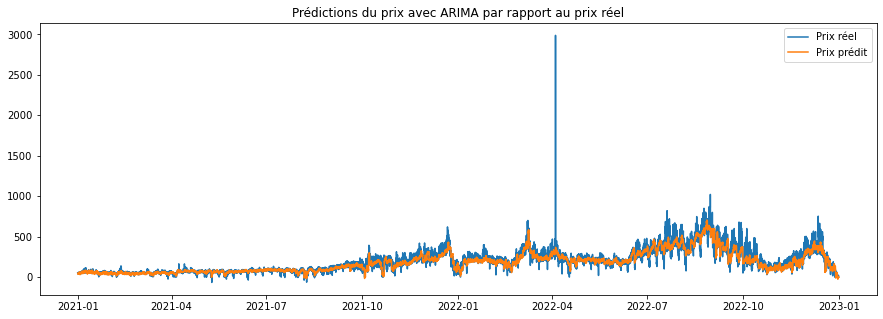

In [12]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel')
plt.show()

In [13]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list = []
for i in range(len(predictions)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [predictions[i]])
    mae_list.append(mae)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


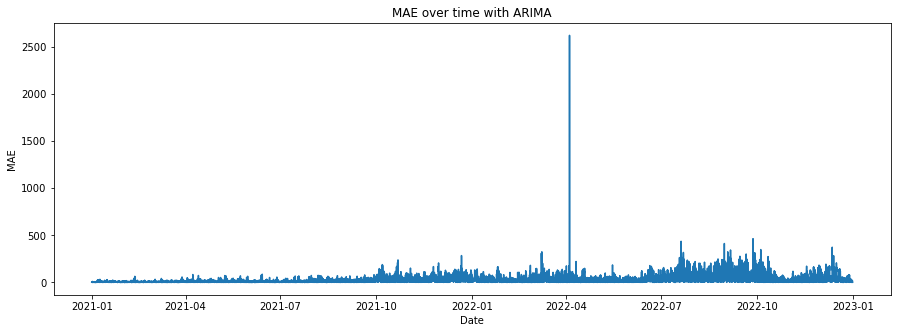

In [14]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA')
plt.show()

Le modèle ARIMA-GARCH est souvent utilisé pour modéliser la série temporelle des prix de l'électricité. Les modèles ARIMA sont généralement utilisés pour modéliser les tendances, les saisons et les cycles d'une série temporelle. Cependant, les modèles ARIMA ne prennent pas en compte l'hétéroscédasticité, qui est fréquente dans les séries temporelles de prix de l'électricité, c'est-à-dire la variance variable des erreurs.

D'un autre côté, les modèles GARCH sont utilisés pour modéliser l'hétéroscédasticité conditionnelle, c'est-à-dire la variance variable des erreurs qui dépend de la valeur des erreurs précédentes. Les modèles GARCH peuvent être utilisés pour estimer la volatilité de la série temporelle, ce qui peut être utile pour la prise de décisions en matière de négociation et de gestion des risques.

En combinant les deux modèles, ARIMA et GARCH, on peut obtenir des prévisions plus précises et fiables des prix de l'électricité. Le modèle ARIMA peut être utilisé pour modéliser les tendances et les saisons, tandis que le modèle GARCH peut être utilisé pour modéliser l'hétéroscédasticité conditionnelle et estimer la volatilité future de la série temporelle. Cette combinaison permet de mieux capturer les caractéristiques complexes et dynamiques des prix de l'électricité et d'améliorer la précision des prévisions.

In [15]:
# Create an empty array to store the residuals
residuals = []


# Iterate over each point in the test set
for i in range(len(predictions)):
    # Calculate the residuals
    residuals.append(test_data.iloc[i, 1] - predictions[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am = arch_model(residuals, x=predictions, vol='GARCH', p=1, q=1)
res = am.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts = []
for i in range(0, len(test_data), 24):
    forecast = res.forecast(horizon=24)
    garch_forecasts.extend(forecast.variance.values[-1, :])

print("GARCH forecasts :", garch_forecasts)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 115833.87648356384
Iteration:      2,   Func. Count:     13,   Neg. LLF: 86290.94646110327
Iteration:      3,   Func. Count:     19,   Neg. LLF: 90763.7733950302
Iteration:      4,   Func. Count:     26,   Neg. LLF: 84835.6723410539
Iteration:      5,   Func. Count:     32,   Neg. LLF: 83825.4962314284
Iteration:      6,   Func. Count:     37,   Neg. LLF: 83820.26831318566
Iteration:      7,   Func. Count:     42,   Neg. LLF: 83814.94351536265
Iteration:      8,   Func. Count:     47,   Neg. LLF: 83814.27110218354
Iteration:      9,   Func. Count:     52,   Neg. LLF: 83814.26000442778
Iteration:     10,   Func. Count:     57,   Neg. LLF: 83814.2596629032
Iteration:     11,   Func. Count:     62,   Neg. LLF: 83823.57355376522
Iteration:     12,   Func. Count:     71,   Neg. LLF: 83945.89845219252
Optimization terminated successfully    (Exit mode 0)
            Current function value: 83814.259661188
            Iterations: 14
      

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

GARCH forecasts : [124.42451331425376, 211.98705016285612, 299.5494360110876, 387.11167085920863, 474.67375470747936, 562.2356875561604, 649.7974694055122, 737.359100255795, 824.9205801072694, 912.4819089601956, 1000.043086814834, 1087.604113671445, 1175.1649895302892, 1262.725714391627, 1350.2862882557183, 1437.8467111228238, 1525.4069829932039, 1612.967103867119, 1700.5270737448297, 1788.086892626596, 1875.6465605126787, 1963.2060774033378, 2050.765443298834, 2138.3246581994267, 124.42451331425376, 211.98705016285612, 299.5494360110876, 387.11167085920863, 474.67375470747936, 562.2356875561604, 649.7974694055122, 737.359100255795, 824.9205801072694, 912.4819089601956, 1000.043086814834, 1087.604113671445, 1175.1649895302892, 1262.725714391627, 1350.2862882557183, 1437.8467111228238, 1525.4069829932039, 1612.967103867119, 1700.5270737448297, 1788.086892626596, 1875.6465605126787, 1963.2060774033378, 2050.765443298834, 2138.3246581994267, 124.42451331425376, 211.98705016285612, 299.549

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Le modèle GARCH peut être utilisé pour estimer la volatilité des résidus de votre modèle ARIMA, ce qui peut aider à mieux comprendre et à améliorer la précision de vos prévisions du prix de l'électricité. En effet, en utilisant les prévisions GARCH pour estimer la volatilité future de l'électricité, vous pouvez prendre en compte les fluctuations imprévisibles de la volatilité et mieux évaluer la fiabilité de vos prévisions de prix.

Par exemple, si le modèle GARCH prévoit une forte augmentation de la volatilité dans un proche avenir, cela peut indiquer une incertitude accrue sur les prévisions de prix de l'électricité, ce qui peut aider à ajuster les attentes et les décisions d'investissement.

En outre, l'utilisation de modèles de volatilité tels que GARCH peut aider à améliorer les performances des modèles de prévision des prix en ajustant les prévisions pour les effets de volatilité, qui peuvent avoir un impact significatif sur les prix de l'électricité.

En résumé, l'utilisation du modèle GARCH peut aider à mieux comprendre et à améliorer la précision de vos prévisions de prix de l'électricité en prenant en compte les fluctuations imprévisibles de la volatilité.

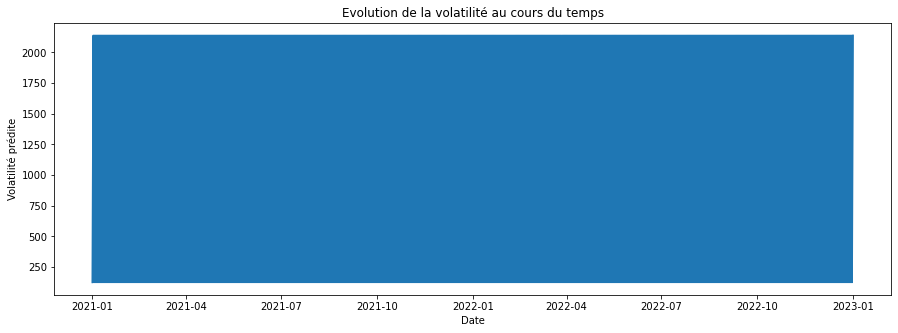

In [16]:
# Plot the volatility over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], garch_forecasts)
plt.xlabel('Date')
plt.ylabel('Volatilité prédite')
plt.title('Evolution de la volatilité au cours du temps')
plt.show()

### Ajustement des prévisions en fonction des effets de volatilité 

Les prévisions ajustées en fonction des effets de volatilité peuvent être obtenues à partir du modèle GARCH. Les prévisions de volatilité du GARCH peuvent être utilisées pour ajuster les prévisions de l'ARIMA en fonction des fluctuations de la volatilité.

En général, on peut ajuster les prévisions de l'ARIMA en multipliant les prévisions par la racine carrée de la volatilité pronostiquée par le modèle GARCH. Cela revient à diviser les prévisions de l'ARIMA par l'écart-type de la série temporelle résiduelle, ce qui normalise les prévisions en fonction des fluctuations de la volatilité.

In [17]:
observations = np.array(garch_forecasts)
# Créer le filtre de Kalman
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means, filtered_state_covariances = kf.filter(observations)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions = filtered_state_means.flatten()

In [18]:
print(filtered_volatility_predictions)

[ 124.42451331  153.99861516  191.55388814 ... 1386.62728992 1449.80337994
 1515.29891281]


In [19]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts = []
for i in range(len(filtered_volatility_predictions)):
    adjusted_forecasts.append(predictions[i] * np.sqrt(filtered_volatility_predictions[i]) * 0.05) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

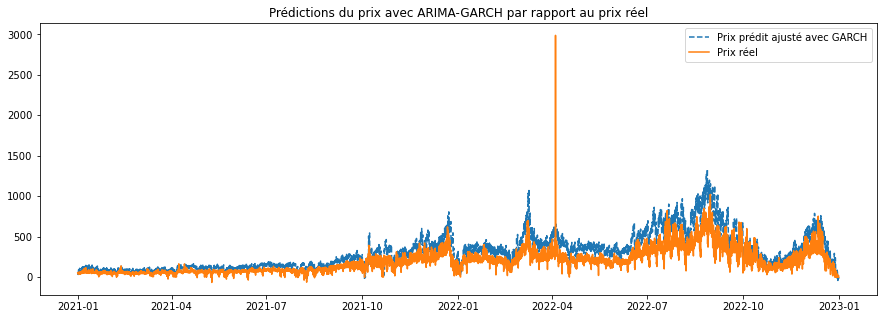

In [20]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel")
plt.show()

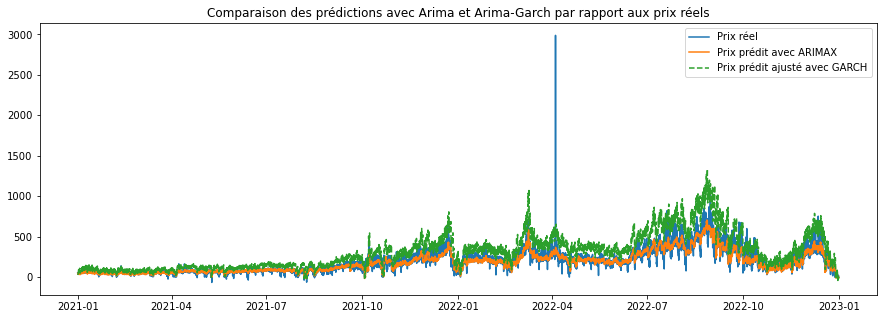

In [21]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.legend()
plt.title("Comparaison des prédictions avec Arima et Arima-Garch par rapport aux prix réels")
plt.show()

In [22]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list2 = []
for i in range(len(adjusted_forecasts)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [adjusted_forecasts[i]])
    mae_list2.append(mae)

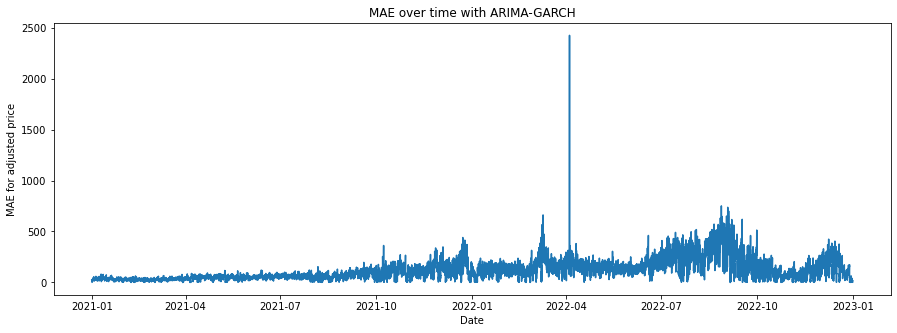

In [23]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list2)
plt.xlabel('Date')
plt.ylabel('MAE for adjusted price')
plt.title('MAE over time with ARIMA-GARCH')
plt.show()

In [ ]:
----------------------- start

## Etude de 2019 à 2022 (comparaison entre les données entsoe et les données fournisseurs)

### Données ENTSOE

In [6]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2018-12-31 00:00:00' 
end_date_train2 = '2020-12-31 23:00:00'

start_date_test2 = '2021-01-01 00:00:00'
end_date_test2 = '2022-06-30 23:00:00'


# Sélectionner les lignes entre les bornes de dates
train_data2 = dfb.loc[(dfb['Date'] >= start_date_train2) & (dfb['Date'] <= end_date_train2)]

test_data2 = dfb.loc[(dfb['Date'] >= start_date_test2) & (dfb['Date'] <= end_date_test2)]

In [7]:
train_data2.reset_index(drop=True)

Date   Prices   Generation forecast  \
0     2018-12-31 00:00:00    50.94               67247.0   
1     2018-12-31 01:00:00    49.57               65041.0   
2     2018-12-31 02:00:00    48.32               64608.0   
3     2018-12-31 03:00:00    45.89               63406.0   
4     2018-12-31 04:00:00    45.47               63325.0   
...                   ...      ...                   ...   
17563 2020-12-31 19:00:00    60.54               70648.0   
17564 2020-12-31 20:00:00    56.75               69866.0   
17565 2020-12-31 21:00:00    52.44               68126.0   
17566 2020-12-31 22:00:00    51.86               67610.0   
17567 2020-12-31 23:00:00    52.26               67202.0   

        System load forecast  
0                    62950.0  
1                    59900.0  
2                    59000.0  
3                    56050.0  
4                    54100.0  
...                      ...  
17563                70850.0  
17564                67800.0  
17565                64900.0  
17566                64800.0  
17567                67550.0  

[17568 rows x 4 columns]

In [8]:
test_data2.reset_index(drop=True)

Date   Prices   Generation forecast  \
0     2021-01-01 00:00:00    50.87               63690.0   
1     2021-01-01 01:00:00    48.19               62414.0   
2     2021-01-01 02:00:00    44.68               60612.0   
3     2021-01-01 03:00:00    42.92               58978.0   
4     2021-01-01 04:00:00    40.39               58520.0   
...                   ...      ...                   ...   
13098 2022-06-30 19:00:00   479.00               45017.0   
13099 2022-06-30 20:00:00   450.00               43164.0   
13100 2022-06-30 21:00:00   394.21               41334.0   
13101 2022-06-30 22:00:00   367.95               40844.0   
13102 2022-06-30 23:00:00   351.96               40054.0   

        System load forecast  
0                    66500.0  
1                    64600.0  
2                    63700.0  
3                    60600.0  
4                    58150.0  
...                      ...  
13098                49050.0  
13099                46600.0  
13100                44200.0  
13101                44600.0  
13102                47250.0  

[13103 rows x 4 columns]

In [9]:
# replace missing values with the mean value of the column
test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)
display(test_data2)

# replace missing values with the mean value of the column
train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)
display(train_data2)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_2524\2532132216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)


Date   Prices   Generation forecast  \
35064 2021-01-01 00:00:00    50.87               63690.0   
35065 2021-01-01 01:00:00    48.19               62414.0   
35066 2021-01-01 02:00:00    44.68               60612.0   
35067 2021-01-01 03:00:00    42.92               58978.0   
35068 2021-01-01 04:00:00    40.39               58520.0   
...                   ...      ...                   ...   
48162 2022-06-30 19:00:00   479.00               45017.0   
48163 2022-06-30 20:00:00   450.00               43164.0   
48164 2022-06-30 21:00:00   394.21               41334.0   
48165 2022-06-30 22:00:00   367.95               40844.0   
48166 2022-06-30 23:00:00   351.96               40054.0   

        System load forecast  
35064                66500.0  
35065                64600.0  
35066                63700.0  
35067                60600.0  
35068                58150.0  
...                      ...  
48162                49050.0  
48163                46600.0  
48164                44200.0  
48165                44600.0  
48166                47250.0  

[13103 rows x 4 columns]

C:\Users\sokhn\AppData\Local\Temp\ipykernel_2524\2532132216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)


Date   Prices   Generation forecast  \
17496 2018-12-31 00:00:00    50.94               67247.0   
17497 2018-12-31 01:00:00    49.57               65041.0   
17498 2018-12-31 02:00:00    48.32               64608.0   
17499 2018-12-31 03:00:00    45.89               63406.0   
17500 2018-12-31 04:00:00    45.47               63325.0   
...                   ...      ...                   ...   
35059 2020-12-31 19:00:00    60.54               70648.0   
35060 2020-12-31 20:00:00    56.75               69866.0   
35061 2020-12-31 21:00:00    52.44               68126.0   
35062 2020-12-31 22:00:00    51.86               67610.0   
35063 2020-12-31 23:00:00    52.26               67202.0   

        System load forecast  
17496                62950.0  
17497                59900.0  
17498                59000.0  
17499                56050.0  
17500                54100.0  
...                      ...  
35059                70850.0  
35060                67800.0  
35061                64900.0  
35062                64800.0  
35063                67550.0  

[17568 rows x 4 columns]

In [14]:
# Set the length of the training set
train_len2 = len(train_data2)
#print(train_len)

# Create an empty array to store the predictions
predictions2 = []

# Iterate over each point in the test set
for i in range(0, len(test_data2), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset2 = train_data2.iloc[:train_len2, :]
    else:
        train_data_subset2 = pd.concat([train_data2.iloc[i:, :], test_data2.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model2 = ARIMA(train_data_subset2.iloc[:, 1], exog=train_data_subset2.iloc[:, 2:], order=(1,1,1))
    result2 = model2.fit()
    
    # Make one-day-ahead forecasts
    #forecast2 = result2.forecast(steps=24, exog=test_data2.iloc[i:i+24, 2:])
    end_index = min(i + 24, len(test_data2))
    forecast2 = result2.forecast(steps=end_index - i, exog=test_data2.iloc[i:end_index, 2:])

    print("prédictions2 :", forecast2)
    
    # Store the forecasts in the predictions array
    predictions2.extend(forecast2)
    

# Create a CSV file to store the predictions
with open('predictions_ARIMAX.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the predictions to the CSV file
    for prediction in predictions2:
        writer.writerow([prediction])

# Print a message indicating that the predictions have been saved
print("Predictions saved to predictions_ARIMAX.csv")
    



C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignore

prédictions2 : 17568    47.060709
17569    44.753069
17570    41.973194
17571    38.836005
17572    37.529951
17573    36.468119
17574    36.691870
17575    37.732453
17576    38.203305
17577    39.969097
17578    42.576653
17579    45.056066
17580    46.848307
17581    46.591503
17582    44.609387
17583    44.132859
17584    47.122218
17585    49.608585
17586    52.652295
17587    52.852178
17588    52.377341
17589    50.582284
17590    49.567022
17591    49.103559
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.354098
17569    44.371165
17570    41.870031
17571    39.282032
17572    38.895287
17573    40.120560
17574    43.251243
17575    46.529622
17576    49.416663
17577    52.368867
17578    55.900290
17579    57.772702
17580    58.852271
17581    57.877201
17582    56.000110
17583    55.142857
17584    55.342984
17585    56.572713
17586    59.521349
17587    59.626140
17588    57.950400
17589    54.804297
17590    53.823977
17591    53.029418
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    42.245739
17569    37.730030
17570    36.166424
17571    34.121689
17572    32.484063
17573    32.323835
17574    33.622129
17575    34.872401
17576    36.221625
17577    41.266250
17578    44.568414
17579    46.301622
17580    47.775166
17581    46.851309
17582    43.934145
17583    42.505885
17584    44.015383
17585    48.299796
17586    51.986042
17587    53.485996
17588    52.798905
17589    50.649610
17590    49.656724
17591    49.086081
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    50.516628
17569    47.677306
17570    45.078285
17571    42.867140
17572    42.510829
17573    46.555912
17574    53.506131
17575    58.175424
17576    62.003611
17577    62.817483
17578    64.130840
17579    65.182617
17580    65.296231
17581    63.736923
17582    64.449483
17583    60.715581
17584    61.899489
17585    65.757258
17586    69.251799
17587    69.641648
17588    64.547242
17589    60.006159
17590    58.507953
17591    58.117410
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    53.195864
17569    51.118382
17570    49.086191
17571    45.911732
17572    44.153609
17573    49.189044
17574    54.105972
17575    60.015096
17576    62.386435
17577    64.618462
17578    65.290398
17579    66.287465
17580    68.022719
17581    65.896520
17582    63.741582
17583    61.219147
17584    59.831246
17585    63.463125
17586    68.097054
17587    70.236718
17588    62.683884
17589    56.202195
17590    54.264205
17591    55.098589
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    51.666200
17569    48.983628
17570    48.643514
17571    46.827613
17572    44.949296
17573    47.356139
17574    53.625612
17575    59.345207
17576    62.892267
17577    67.162224
17578    67.990764
17579    69.201916
17580    68.994870
17581    67.737889
17582    65.523776
17583    63.212645
17584    61.900520
17585    65.023980
17586    69.498461
17587    69.509018
17588    63.876011
17589    58.013862
17590    55.656935
17591    56.712818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.411989
17569    54.810807
17570    53.284754
17571    51.082806
17572    52.042032
17573    53.659880
17574    60.485025
17575    67.179169
17576    72.615403
17577    75.858770
17578    77.310791
17579    77.583388
17580    77.623347
17581    76.592354
17582    73.433242
17583    71.899051
17584    72.055660
17585    75.468539
17586    78.472172
17587    78.736869
17588    74.485413
17589    67.163196
17590    63.574329
17591    63.230961
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.232453
17569    59.447204
17570    58.371827
17571    56.154626
17572    55.734993
17573    57.783942
17574    64.519636
17575    72.558528
17576    78.334127
17577    80.812913
17578    82.215420
17579    82.808876
17580    82.684065
17581    80.569397
17582    77.560787
17583    74.230158
17584    73.450086
17585    75.965906
17586    79.207942
17587    79.607354
17588    75.375981
17589    69.212956
17590    65.046694
17591    65.679376
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.544770
17569    61.953731
17570    60.717691
17571    57.520860
17572    55.305773
17573    55.817511
17574    58.883760
17575    63.018703
17576    66.401497
17577    69.145916
17578    71.289017
17579    73.148391
17580    72.970637
17581    72.351051
17582    70.037600
17583    68.830605
17584    68.172707
17585    74.348709
17586    75.062690
17587    76.811326
17588    72.240504
17589    69.514843
17590    68.895136
17591    70.041589
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    50.623703
17569    47.382744
17570    42.841399
17571    40.813779
17572    38.520623
17573    38.524764
17574    40.408373
17575    41.967312
17576    44.887775
17577    49.833822
17578    53.610385
17579    54.924233
17580    56.323215
17581    54.025396
17582    49.802978
17583    47.298220
17584    46.556070
17585    50.437857
17586    54.569770
17587    57.047559
17588    54.593922
17589    50.169250
17590    49.954823
17591    50.548480
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.979126
17569    55.484741
17570    53.627406
17571    50.863006
17572    50.651717
17573    54.257353
17574    61.579981
17575    71.027116
17576    76.587727
17577    78.765971
17578    79.660237
17579    79.453732
17580    78.833593
17581    77.567951
17582    75.684470
17583    74.110812
17584    72.516501
17585    77.359803
17586    80.780477
17587    82.243435
17588    78.235914
17589    71.914232
17590    69.883257
17591    70.652403
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.261120
17569    57.349082
17570    56.272961
17571    51.468260
17572    51.116817
17573    53.150615
17574    59.904513
17575    68.971916
17576    70.659201
17577    73.711144
17578    74.208232
17579    74.552547
17580    74.241111
17581    71.255048
17582    69.093373
17583    66.316708
17584    64.240313
17585    65.618721
17586    69.474893
17587    68.122752
17588    61.631699
17589    56.193164
17590    55.222855
17591    55.179845
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.635031
17569    54.372626
17570    52.053129
17571    49.438628
17572    48.429571
17573    51.737050
17574    57.818563
17575    64.949028
17576    68.780961
17577    70.783044
17578    71.798571
17579    71.991284
17580    72.415540
17581    71.019194
17582    69.260537
17583    67.424558
17584    66.541783
17585    68.320926
17586    70.932740
17587    71.123738
17588    64.819436
17589    60.121821
17590    59.517496
17591    60.394177
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    62.784553
17569    58.999989
17570    56.568143
17571    52.050922
17572    50.699563
17573    52.846085
17574    63.625556
17575    71.548657
17576    75.383498
17577    78.224018
17578    79.632471
17579    81.253462
17580    82.281961
17581    80.893949
17582    77.672758
17583    75.684841
17584    76.358397
17585    79.837941
17586    83.057026
17587    81.230205
17588    74.772666
17589    69.601625
17590    67.171013
17591    66.711409
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    51.515468
17569    47.306068
17570    44.616446
17571    42.700904
17572    42.810562
17573    47.181055
17574    56.043007
17575    64.361807
17576    69.251763
17577    70.556305
17578    71.538608
17579    72.264975
17580    71.345986
17581    69.098627
17582    65.993910
17583    63.382422
17584    63.408241
17585    63.842724
17586    66.608518
17587    67.271743
17588    60.726612
17589    53.858452
17590    51.832178
17591    51.960114
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.782501
17569    51.148946
17570    47.426312
17571    44.378273
17572    42.941600
17573    42.860150
17574    44.383332
17575    48.892783
17576    52.711451
17577    55.833630
17578    58.615129
17579    59.153541
17580    61.169374
17581    59.377797
17582    56.627653
17583    55.308574
17584    55.780623
17585    58.022861
17586    61.537931
17587    61.787936
17588    59.135281
17589    53.626420
17590    52.367181
17591    52.279535
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.029404
17569    43.862111
17570    41.956774
17571    37.473736
17572    35.862718
17573    36.350792
17574    37.286753
17575    41.296364
17576    43.103560
17577    49.627553
17578    52.766375
17579    55.239197
17580    57.061146
17581    55.664438
17582    52.990328
17583    52.015823
17584    50.939049
17585    53.465203
17586    57.523019
17587    58.257067
17588    55.621626
17589    52.483447
17590    51.256341
17591    51.437876
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    52.519846
17569    50.285104
17570    47.945926
17571    45.521032
17572    46.447164
17573    49.975744
17574    58.450883
17575    65.722079
17576    69.653138
17577    71.435879
17578    71.618525
17579    71.398016
17580    71.361794
17581    70.040562
17582    67.555258
17583    64.525441
17584    64.049463
17585    67.406336
17586    72.155198
17587    72.415485
17588    67.892928
17589    63.324897
17590    62.369738
17591    63.452467
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.649549
17569    59.103858
17570    56.678061
17571    51.928911
17572    51.140074
17573    53.805825
17574    63.517187
17575    71.578836
17576    75.136128
17577    76.302947
17578    76.715755
17579    77.261012
17580    77.478787
17581    75.148761
17582    70.118499
17583    66.448172
17584    65.258665
17585    68.598232
17586    73.470369
17587    75.500117
17588    70.125499
17589    62.478643
17590    61.420114
17591    62.138743
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.887370
17569    46.227746
17570    42.754257
17571    38.555413
17572    37.987034
17573    39.907545
17574    47.337494
17575    54.688508
17576    58.398340
17577    60.280957
17578    61.349768
17579    61.031841
17580    60.530076
17581    58.210036
17582    55.839157
17583    53.847798
17584    53.587384
17585    56.513936
17586    60.093757
17587    59.569863
17588    53.407781
17589    46.917021
17590    45.872148
17591    46.192425
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    39.656148
17569    36.262325
17570    34.206347
17571    30.528368
17572    30.082113
17573    31.488687
17574    37.741293
17575    45.724511
17576    48.534025
17577    49.164701
17578    50.017245
17579    49.632852
17580    48.436243
17581    47.051687
17582    45.385717
17583    44.048501
17584    44.181845
17585    46.766995
17586    50.273314
17587    51.129818
17588    47.799818
17589    43.661310
17590    41.858895
17591    40.548235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    34.281142
17569    30.159050
17570    28.351923
17571    26.606374
17572    25.821119
17573    27.519803
17574    35.447483
17575    45.591547
17576    48.876528
17577    49.616885
17578    48.306280
17579    49.458349
17580    50.780342
17581    50.025024
17582    47.326368
17583    45.806800
17584    46.260452
17585    49.067292
17586    52.452381
17587    52.708868
17588    48.417330
17589    44.360992
17590    41.844914
17591    42.575410
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    39.712692
17569    36.261165
17570    34.743417
17571    33.178999
17572    31.647021
17573    31.774110
17574    32.868506
17575    36.877924
17576    42.027097
17577    46.360385
17578    48.674430
17579    49.923207
17580    50.585019
17581    49.466159
17582    46.159735
17583    45.345885
17584    44.652054
17585    45.741843
17586    48.296784
17587    48.731637
17588    45.835550
17589    41.141090
17590    39.487814
17591    41.229273
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    43.010646
17569    39.249216
17570    37.896593
17571    35.264709
17572    34.292234
17573    34.471549
17574    36.204654
17575    37.346095
17576    40.893427
17577    46.293428
17578    50.297338
17579    51.995084
17580    53.602336
17581    52.180439
17582    49.436995
17583    48.829259
17584    49.399354
17585    51.142283
17586    55.774987
17587    56.491832
17588    53.952368
17589    50.821229
17590    49.779846
17591    51.442494
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    43.449412
17569    40.395681
17570    40.073157
17571    39.218306
17572    39.299689
17573    43.687179
17574    51.660135
17575    60.419207
17576    63.616730
17577    65.626739
17578    66.714302
17579    67.521871
17580    67.244497
17581    66.047599
17582    63.016680
17583    60.073768
17584    58.857432
17585    60.021148
17586    62.682265
17587    62.624178
17588    57.540191
17589    52.912664
17590    52.295130
17591    52.372341
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.692491
17569    47.365399
17570    45.198767
17571    42.517981
17572    41.731443
17573    45.144819
17574    52.946436
17575    61.127539
17576    65.613785
17577    67.584282
17578    68.434929
17579    68.683130
17580    66.026127
17581    63.889494
17582    60.992631
17583    58.495886
17584    57.230176
17585    59.595253
17586    64.323547
17587    65.778965
17588    59.806141
17589    54.122453
17590    53.005830
17591    53.096248
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    41.961791
17569    37.286203
17570    35.758390
17571    33.346847
17572    32.556680
17573    34.505753
17574    43.420665
17575    50.372624
17576    53.270102
17577    54.266222
17578    55.105715
17579    55.568614
17580    55.834175
17581    54.673372
17582    51.648552
17583    49.459950
17584    49.370334
17585    51.098389
17586    54.876469
17587    55.822939
17588    51.098032
17589    45.766603
17590    43.610296
17591    43.413521
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.367331
17569    44.129690
17570    43.278793
17571    41.890245
17572    41.982901
17573    46.110811
17574    53.880592
17575    60.969055
17576    64.082128
17577    66.194858
17578    67.296132
17579    67.858027
17580    67.105448
17581    66.418692
17582    63.975060
17583    61.269737
17584    59.825946
17585    59.538105
17586    62.489640
17587    62.494417
17588    58.021601
17589    52.308934
17590    50.075011
17591    49.890798
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    38.769226
17569    35.811494
17570    33.597506
17571    32.535713
17572    32.342140
17573    34.191322
17574    40.440990
17575    47.968915
17576    49.599836
17577    52.425648
17578    53.323064
17579    54.541676
17580    55.065851
17581    53.638365
17582    50.907034
17583    49.092543
17584    48.060425
17585    48.208703
17586    49.503824
17587    49.022969
17588    45.188051
17589    40.275356
17590    37.027246
17591    35.640455
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.083655
17569    33.833550
17570    31.490133
17571    28.195865
17572    27.035748
17573    27.415420
17574    30.476771
17575    33.275852
17576    37.733349
17577    42.415324
17578    45.068445
17579    45.617928
17580    47.558483
17581    49.184979
17582    46.584202
17583    45.338054
17584    44.817007
17585    47.066241
17586    50.629007
17587    50.908270
17588    47.880982
17589    43.060506
17590    41.829522
17591    43.200473
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    36.274653
17569    34.249685
17570    32.612984
17571    30.261598
17572    28.899357
17573    28.676337
17574    28.848731
17575    29.461538
17576    31.424300
17577    37.653922
17578    40.004661
17579    41.864351
17580    43.459437
17581    41.015084
17582    38.510629
17583    38.183915
17584    39.147698
17585    41.423288
17586    45.527452
17587    46.487257
17588    44.745696
17589    41.861718
17590    40.293551
17591    40.097883
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    41.347349
17569    39.557367
17570    38.969589
17571    37.508737
17572    37.130889
17573    40.578672
17574    48.267745
17575    55.361620
17576    58.073954
17577    59.285610
17578    60.125634
17579    61.173449
17580    62.051049
17581    61.022851
17582    59.196600
17583    58.260445
17584    56.862518
17585    57.714418
17586    61.213635
17587    62.029898
17588    57.454928
17589    53.898435
17590    52.427509
17591    50.613616
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.061548
17569    42.801321
17570    40.907719
17571    39.201816
17572    37.660184
17573    39.851648
17574    48.479613
17575    57.425112
17576    60.922411
17577    62.339290
17578    62.646691
17579    62.443324
17580    63.523709
17581    61.820417
17582    58.278795
17583    55.559964
17584    54.082126
17585    54.409926
17586    57.192653
17587    56.330271
17588    50.961241
17589    47.314026
17590    45.769002
17591    46.059166
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    36.588062
17569    32.819614
17570    29.442117
17571    28.032417
17572    27.257036
17573    28.619523
17574    36.097734
17575    42.644030
17576    45.303547
17577    47.364572
17578    49.224837
17579    51.659510
17580    52.300004
17581    50.794039
17582    48.100468
17583    45.907548
17584    43.286065
17585    43.211475
17586    46.280933
17587    46.174963
17588    41.947480
17589    37.051177
17590    33.763347
17591    33.184520
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.380401
17569    34.908405
17570    33.574324
17571    33.184711
17572    32.682088
17573    34.479509
17574    41.680840
17575    49.321984
17576    50.786340
17577    51.224199
17578    52.536092
17579    52.722899
17580    53.843642
17581    53.392079
17582    51.376499
17583    49.939575
17584    49.140277
17585    50.303592
17586    55.078256
17587    56.271886
17588    52.778093
17589    48.501826
17590    45.607302
17591    45.389131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    43.959105
17569    39.694735
17570    38.770882
17571    37.402216
17572    37.260272
17573    38.941053
17574    46.176054
17575    52.601807
17576    54.311378
17577    54.930107
17578    54.685424
17579    54.940367
17580    55.447463
17581    54.487164
17582    51.618874
17583    49.739649
17584    48.345119
17585    49.346999
17586    52.920129
17587    53.022718
17588    50.259905
17589    44.835159
17590    41.665209
17591    42.518348
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    41.820167
17569    38.826622
17570    36.283605
17571    34.219652
17572    33.549420
17573    34.093667
17574    35.497534
17575    36.799029
17576    38.536129
17577    41.109685
17578    42.847395
17579    42.916488
17580    43.315199
17581    41.668703
17582    39.680345
17583    37.813295
17584    37.819053
17585    39.174021
17586    42.920714
17587    44.797113
17588    42.486283
17589    39.810775
17590    38.687327
17591    39.412531
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    23.660796
17569    20.814944
17570    18.795843
17571    15.764409
17572    14.315321
17573    14.889998
17574    16.278281
17575    17.588031
17576    19.089357
17577    23.555327
17578    27.942605
17579    30.480322
17580    32.281002
17581    30.533349
17582    26.927751
17583    24.555084
17584    23.784843
17585    26.026873
17586    30.664563
17587    33.100247
17588    31.347034
17589    27.304758
17590    25.710263
17591    26.246477
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    35.420287
17569    33.355385
17570    31.360926
17571    29.402944
17572    29.704299
17573    33.894172
17574    44.123946
17575    51.600385
17576    56.056845
17577    58.843011
17578    60.817836
17579    61.873908
17580    61.420019
17581    59.565453
17582    57.626027
17583    55.579026
17584    54.384987
17585    55.479894
17586    60.102018
17587    62.100936
17588    58.361181
17589    52.434481
17590    50.284309
17591    49.383535
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    44.362523
17569    41.539653
17570    39.648762
17571    38.160475
17572    38.090878
17573    40.794549
17574    50.237793
17575    57.136734
17576    60.374539
17577    62.183232
17578    63.161649
17579    64.106859
17580    64.120461
17581    63.026883
17582    60.426939
17583    58.978360
17584    58.108213
17585    59.906453
17586    64.206090
17587    64.883845
17588    60.486255
17589    56.108451
17590    53.579690
17591    53.446773
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    46.914914
17569    44.091133
17570    43.121665
17571    41.415124
17572    40.826138
17573    43.936420
17574    52.138996
17575    57.944488
17576    61.769559
17577    64.341770
17578    65.744263
17579    66.841695
17580    67.351634
17581    65.969737
17582    63.065418
17583    60.820861
17584    59.481257
17585    59.237782
17586    61.646530
17587    63.172353
17588    58.300373
17589    53.334742
17590    52.357519
17591    52.668041
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.527790
17569    53.196274
17570    51.512045
17571    49.827942
17572    49.426366
17573    52.392111
17574    60.245668
17575    68.761031
17576    70.681025
17577    73.180205
17578    74.575988
17579    75.274744
17580    74.868612
17581    73.433291
17582    71.019105
17583    68.483591
17584    68.956905
17585    70.133751
17586    72.016647
17587    73.959858
17588    68.209400
17589    62.730955
17590    60.671998
17591    60.422173
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    50.969300
17569    49.320068
17570    47.869449
17571    44.429429
17572    45.079453
17573    46.702849
17574    55.153661
17575    61.273857
17576    65.406068
17577    66.550689
17578    66.454998
17579    65.192969
17580    64.006632
17581    62.184556
17582    59.153492
17583    56.795841
17584    56.463865
17585    58.608684
17586    61.355270
17587    62.480357
17588    58.148070
17589    52.593719
17590    51.072669
17591    51.896533
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    43.014734
17569    40.157940
17570    38.596834
17571    36.013678
17572    35.634724
17573    36.511522
17574    37.865136
17575    41.569804
17576    45.829963
17577    49.335274
17578    51.291789
17579    51.820232
17580    53.014493
17581    50.708137
17582    46.697174
17583    43.990941
17584    43.963550
17585    45.000980
17586    49.157659
17587    51.050498
17588    47.895485
17589    45.007243
17590    44.222063
17591    44.050908
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    44.308753
17569    41.345233
17570    38.937140
17571    36.102517
17572    35.400921
17573    35.874396
17574    37.728518
17575    39.310610
17576    41.445739
17577    45.194424
17578    48.135202
17579    48.893471
17580    49.195268
17581    46.768953
17582    43.311940
17583    41.826037
17584    40.905015
17585    43.532606
17586    49.215428
17587    52.600504
17588    50.181994
17589    46.586307
17590    45.769572
17591    46.533872
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    40.582405
17569    38.928143
17570    37.880141
17571    35.561118
17572    35.001649
17573    38.115784
17574    47.057821
17575    55.628761
17576    57.663246
17577    60.036430
17578    61.602378
17579    62.861858
17580    61.987226
17581    59.681892
17582    56.685403
17583    53.529904
17584    51.667662
17585    52.604035
17586    56.309164
17587    58.812311
17588    52.987779
17589    49.551479
17590    47.778211
17591    45.880394
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    42.611142
17569    40.622150
17570    39.949926
17571    37.817823
17572    36.752511
17573    40.756316
17574    46.718919
17575    54.428318
17576    56.817829
17577    58.441861
17578    57.938964
17579    57.230541
17580    56.985447
17581    54.799433
17582    51.773335
17583    49.592138
17584    47.618968
17585    47.890160
17586    51.863808
17587    55.454470
17588    51.053288
17589    46.159766
17590    41.794544
17591    41.050674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    39.543762
17569    36.456637
17570    33.668204
17571    32.435625
17572    31.471013
17573    34.594134
17574    40.557610
17575    46.733697
17576    50.297973
17577    52.554736
17578    53.806966
17579    54.651470
17580    55.191018
17581    54.019398
17582    51.362885
17583    48.856897
17584    47.862606
17585    49.419648
17586    52.719104
17587    54.542449
17588    50.594230
17589    44.543793
17590    43.073550
17591    42.147906
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    40.639302
17569    38.967881
17570    37.310016
17571    35.080410
17572    35.651285
17573    39.335725
17574    46.621113
17575    53.473721
17576    56.109818
17577    56.143107
17578    54.891021
17579    54.312629
17580    54.431097
17581    53.193344
17582    50.431153
17583    48.129092
17584    47.087127
17585    46.619878
17586    50.038755
17587    54.012307
17588    49.770160
17589    44.812963
17590    41.176379
17591    40.294401
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    36.135956
17569    33.256745
17570    31.913073
17571    30.852368
17572    30.187716
17573    33.166916
17574    40.871270
17575    49.928457
17576    52.308175
17577    54.243478
17578    52.956958
17579    52.322631
17580    53.511085
17581    51.554808
17582    50.950553
17583    49.718776
17584    49.884329
17585    50.857373
17586    54.535801
17587    56.258473
17588    50.932144
17589    45.556793
17590    43.292714
17591    41.781393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    29.843562
17569    29.162439
17570    28.986605
17571    28.126858
17572    27.643282
17573    27.629850
17574    27.979096
17575    28.502966
17576    28.892510
17577    29.429813
17578    29.496975
17579    29.268622
17580    29.322352
17581    29.134296
17582    28.032826
17583    27.280603
17584    26.837329
17585    26.823896
17586    27.737310
17587    29.282054
17588    28.825347
17589    28.046259
17590    27.885068
17591    28.744752
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    30.628980
17569    27.409858
17570    25.023787
17571    23.115137
17572    22.140780
17573    22.909797
17574    24.902543
17575    26.340974
17576    28.920070
17577    31.592024
17578    33.762006
17579    34.560617
17580    34.824152
17581    33.567348
17582    30.969796
17583    30.201951
17584    29.447355
17585    33.580972
17586    39.009647
17587    41.789772
17588    38.953208
17589    36.789320
17590    35.839716
17591    35.999814
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.528611
17569    35.821240
17570    34.874601
17571    31.765582
17572    32.963324
17573    37.281387
17574    45.249317
17575    52.646918
17576    53.031107
17577    53.424023
17578    50.646447
17579    50.553569
17580    51.060899
17581    49.658205
17582    48.111326
17583    48.625297
17584    47.065466
17585    47.904408
17586    54.339662
17587    58.669601
17588    54.533221
17589    48.518207
17590    46.108090
17591    44.764471
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.680753
17569    35.053108
17570    33.662061
17571    31.746995
17572    31.501320
17573    34.517525
17574    41.248700
17575    48.390910
17576    50.749598
17577    52.549909
17578    51.693957
17579    51.025172
17580    51.276940
17581    50.881066
17582    47.811680
17583    46.636788
17584    44.558792
17585    43.820111
17586    48.978998
17587    52.279345
17588    48.945775
17589    44.005900
17590    38.969860
17591    38.389613
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    29.666881
17569    28.075441
17570    26.813881
17571    24.219082
17572    23.427968
17573    25.390216
17574    30.678009
17575    37.165679
17576    38.914637
17577    39.457933
17578    39.050088
17579    39.127897
17580    40.014554
17581    38.935255
17582    37.466905
17583    35.712989
17584    36.510371
17585    36.262692
17586    41.711149
17587    44.223653
17588    40.749817
17589    37.474743
17590    34.662986
17591    34.276552
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    31.877569
17569    29.265262
17570    27.483143
17571    25.363758
17572    24.380777
17573    26.646948
17574    34.218618
17575    40.312842
17576    41.239846
17577    41.875346
17578    41.291439
17579    41.339481
17580    41.919825
17581    41.295081
17582    39.907373
17583    40.335978
17584    41.180088
17585    42.977778
17586    47.647704
17587    51.891896
17588    47.235592
17589    43.532250
17590    41.141392
17591    39.706821
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    40.081063
17569    37.748420
17570    36.819396
17571    34.630614
17572    34.535658
17573    39.158265
17574    48.184441
17575    52.832222
17576    54.328535
17577    55.280882
17578    53.211250
17579    51.745337
17580    51.700285
17581    50.303880
17582    47.647642
17583    46.471643
17584    46.038190
17585    46.693684
17586    51.400138
17587    54.647027
17588    51.791808
17589    46.635464
17590    44.008835
17591    43.207292
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    36.416648
17569    34.417050
17570    33.250239
17571    31.520729
17572    29.932029
17573    32.594222
17574    34.579121
17575    38.675976
17576    41.057678
17577    43.867266
17578    45.315928
17579    44.522028
17580    45.017821
17581    43.147835
17582    39.893608
17583    37.460635
17584    35.578193
17585    38.433073
17586    45.181443
17587    49.659214
17588    46.553148
17589    41.701043
17590    40.013048
17591    42.538076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    40.461776
17569    36.900494
17570    35.372742
17571    33.269978
17572    32.126758
17573    32.991110
17574    34.441352
17575    35.921008
17576    37.913693
17577    38.854445
17578    39.327292
17579    39.634317
17580    41.063368
17581    36.643641
17582    33.780460
17583    32.271245
17584    32.159717
17585    33.707779
17586    43.036975
17587    46.514927
17588    45.048932
17589    42.617982
17590    41.306336
17591    41.666217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    36.814217
17569    35.172925
17570    33.884967
17571    32.809163
17572    32.471399
17573    35.987909
17574    46.448866
17575    52.010748
17576    54.816946
17577    55.242154
17578    53.196839
17579    52.114829
17580    51.562681
17581    49.616232
17582    46.453639
17583    45.950280
17584    44.194396
17585    47.325340
17586    51.134075
17587    54.723394
17588    51.608813
17589    46.681813
17590    44.022652
17591    47.303452
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.601740
17569    35.124507
17570    34.364651
17571    32.970867
17572    32.952709
17573    35.554891
17574    42.980967
17575    47.884357
17576    49.462280
17577    48.831652
17578    45.933006
17579    44.599466
17580    44.369717
17581    42.685302
17582    40.705780
17583    39.154652
17584    38.544644
17585    41.476752
17586    45.388979
17587    49.050845
17588    46.854202
17589    42.154630
17590    40.154450
17591    44.936662
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    44.134075
17569    42.105487
17570    40.817306
17571    38.868234
17572    38.781208
17573    40.839520
17574    48.146625
17575    53.551197
17576    54.015933
17577    54.260610
17578    52.101916
17579    51.112777
17580    50.842382
17581    49.262626
17582    47.397000
17583    45.752607
17584    45.245507
17585    47.006881
17586    50.460046
17587    53.765003
17588    50.530008
17589    44.922636
17590    44.908326
17591    47.687008
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.088831
17569    47.463254
17570    45.982917
17571    44.372888
17572    43.817589
17573    46.121761
17574    52.051386
17575    57.992379
17576    60.180810
17577    60.982669
17578    60.290727
17579    60.468304
17580    61.100649
17581    60.423807
17582    58.833283
17583    57.290860
17584    56.131271
17585    56.444634
17586    60.052281
17587    63.325140
17588    59.064485
17589    54.497876
17590    52.759939
17591    52.960663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    46.445041
17569    43.532704
17570    42.244502
17571    40.087106
17572    40.289288
17573    44.315124
17574    51.042893
17575    56.583346
17576    60.830257
17577    62.851112
17578    62.498682
17579    60.958784
17580    61.073064
17581    60.314589
17582    57.997186
17583    56.001532
17584    56.041541
17585    56.655151
17586    60.550385
17587    63.500059
17588    59.965861
17589    56.484540
17590    55.131238
17591    55.764166
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    42.387800
17569    38.042416
17570    35.813543
17571    33.838209
17572    33.378035
17573    34.144594
17574    36.252680
17575    36.446074
17576    37.617942
17577    39.428458
17578    38.026962
17579    38.581865
17580    39.260161
17581    38.772541
17582    36.125097
17583    35.518788
17584    36.531584
17585    40.141225
17586    43.532668
17587    47.321738
17588    46.539414
17589    42.783560
17590    41.952585
17591    41.895370
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    41.014747
17569    37.062216
17570    35.565732
17571    33.308181
17572    31.957652
17573    32.992870
17574    35.054051
17575    34.987721
17576    36.472030
17577    38.340224
17578    39.373932
17579    40.482605
17580    41.183657
17581    38.873418
17582    35.217030
17583    32.879649
17584    33.579308
17585    39.372929
17586    45.387493
17587    49.505905
17588    48.572253
17589    46.709016
17590    45.884830
17591    46.070847
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    44.672487
17569    42.792121
17570    41.902707
17571    40.307131
17572    39.378211
17573    43.003399
17574    50.924732
17575    58.826190
17576    60.911772
17577    62.226071
17578    59.641524
17579    59.001781
17580    58.904576
17581    57.700440
17582    55.494100
17583    54.097601
17584    53.174160
17585    56.143585
17586    57.725775
17587    61.503719
17588    59.678154
17589    55.019737
17590    51.279404
17591    50.816651
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.822409
17569    46.860482
17570    45.718608
17571    44.554125
17572    44.717786
17573    47.121970
17574    53.163968
17575    60.600877
17576    62.045575
17577    63.292474
17578    62.877530
17579    63.103226
17580    63.645009
17581    62.645319
17582    60.434356
17583    58.566216
17584    56.638979
17585    57.720731
17586    59.942162
17587    62.931414
17588    60.826943
17589    55.820954
17590    53.318459
17591    53.139653
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    53.666174
17569    51.114176
17570    49.870680
17571    48.580110
17572    48.165165
17573    51.269387
17574    58.336042
17575    63.254301
17576    65.605079
17577    66.610576
17578    65.653297
17579    65.241031
17580    65.953409
17581    64.376109
17582    61.711949
17583    59.560997
17584    58.986904
17585    60.368876
17586    63.785543
17587    67.979150
17588    64.712865
17589    59.938385
17590    56.788387
17591    55.595816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    38.369334
17569    34.896272
17570    32.468779
17571    29.046789
17572    27.668240
17573    30.574764
17574    37.817290
17575    44.284294
17576    47.627010
17577    48.065821
17578    47.364765
17579    47.147019
17580    47.878052
17581    46.149935
17582    43.221978
17583    40.652406
17584    40.051774
17585    41.927419
17586    46.148238
17587    50.689636
17588    48.759703
17589    43.707174
17590    42.411197
17591    42.193726
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    37.856967
17569    32.825022
17570    30.733285
17571    28.045169
17572    28.120891
17573    31.886774
17574    39.170604
17575    47.424160
17576    51.294706
17577    53.288985
17578    52.318198
17579    51.653231
17580    50.173474
17581    47.935001
17582    45.726843
17583    43.410902
17584    44.008256
17585    46.602446
17586    50.225056
17587    52.524780
17588    52.023481
17589    45.965921
17590    44.734225
17591    45.902674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.497456
17569    35.213903
17570    32.047682
17571    27.766633
17572    24.935181
17573    24.930772
17574    28.693044
17575    30.862893
17576    34.933927
17577    37.964087
17578    38.272973
17579    38.236947
17580    39.093490
17581    38.191002
17582    31.745260
17583    29.322850
17584    27.429629
17585    28.707922
17586    35.915671
17587    39.605492
17588    38.331483
17589    33.839944
17590    33.567814
17591    35.682082
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    27.268926
17569    22.754977
17570    20.856602
17571    18.459574
17572    17.159078
17573    17.166970
17574    18.659018
17575    20.868388
17576    23.250550
17577    25.781685
17578    26.702207
17579    27.890435
17580    29.088515
17581    26.832727
17582    21.672672
17583    19.529260
17584    19.694728
17585    26.117417
17586    30.860415
17587    34.983910
17588    34.656426
17589    31.810861
17590    30.753485
17591    30.318245
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    42.041802
17569    40.455672
17570    38.905453
17571    37.816826
17572    38.039045
17573    41.360633
17574    50.077174
17575    53.737193
17576    56.939510
17577    57.008859
17578    56.115697
17579    55.716960
17580    56.657173
17581    55.080948
17582    51.810727
17583    49.421035
17584    47.880010
17585    49.267321
17586    52.849749
17587    55.823953
17588    51.856064
17589    47.571554
17590    45.645926
17591    45.781620
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.005055
17569    42.453978
17570    40.280033
17571    38.237608
17572    38.707478
17573    42.039145
17574    50.164719
17575    55.363454
17576    58.436961
17577    59.750805
17578    59.717999
17579    60.814825
17580    60.889579
17581    59.508857
17582    57.915095
17583    56.583030
17584    57.525827
17585    59.066970
17586    62.904687
17587    66.118903
17588    62.611361
17589    59.266771
17590    56.591131
17591    55.592262
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    45.783141
17569    43.569180
17570    40.566753
17571    37.178139
17572    37.359753
17573    39.994556
17574    48.092980
17575    55.146657
17576    57.611423
17577    59.031193
17578    58.649596
17579    58.501806
17580    59.068539
17581    57.103747
17582    55.244790
17583    53.722367
17584    52.432108
17585    52.561190
17586    56.026033
17587    60.067686
17588    57.195912
17589    52.362224
17590    49.010791
17591    49.653712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.821484
17569    53.913929
17570    52.608438
17571    51.218981
17572    51.361560
17573    53.580359
17574    60.076577
17575    64.190802
17576    66.827204
17577    69.134069
17578    68.833469
17579    67.971340
17580    68.774202
17581    68.239850
17582    65.791821
17583    64.485921
17584    63.542810
17585    64.675584
17586    66.979838
17587    69.995411
17588    67.171503
17589    61.217011
17590    59.569735
17591    59.733784
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.950167
17569    46.159313
17570    45.652004
17571    44.407746
17572    44.306428
17573    46.513212
17574    53.734154
17575    57.745826
17576    60.354094
17577    61.428899
17578    59.284962
17579    57.815132
17580    59.449677
17581    58.757389
17582    54.640414
17583    52.329015
17584    50.594080
17585    52.789947
17586    57.747448
17587    61.824345
17588    58.523909
17589    53.274822
17590    51.715266
17591    53.074134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.108706
17569    52.286791
17570    49.931872
17571    47.472910
17572    46.292970
17573    47.390543
17574    48.128711
17575    50.750120
17576    51.973717
17577    53.679821
17578    54.562700
17579    55.607665
17580    54.966615
17581    53.994743
17582    49.554784
17583    48.506391
17584    49.128569
17585    50.418884
17586    53.171402
17587    56.409626
17588    52.881427
17589    47.959927
17590    47.476016
17591    48.148110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.259362
17569    42.461589
17570    38.995131
17571    36.160229
17572    35.089706
17573    35.142804
17574    36.247897
17575    37.108402
17576    40.136600
17577    44.271544
17578    44.919498
17579    46.386034
17580    47.173257
17581    44.903454
17582    40.029360
17583    38.394878
17584    38.254726
17585    43.723404
17586    49.850809
17587    55.194517
17588    54.072709
17589    52.000497
17590    50.351372
17591    51.158577
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    49.212443
17569    46.843787
17570    45.679958
17571    44.296062
17572    44.184872
17573    48.822665
17574    56.504854
17575    62.681695
17576    65.098937
17577    67.234818
17578    67.519188
17579    66.492140
17580    67.320978
17581    65.745072
17582    63.280470
17583    61.294089
17584    60.073648
17585    60.634129
17586    61.639874
17587    64.625621
17588    62.963626
17589    57.729195
17590    54.965209
17591    54.872269
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    53.507904
17569    51.481920
17570    51.309225
17571    49.821561
17572    49.586416
17573    51.979493
17574    57.174730
17575    62.469235
17576    64.663325
17577    65.215043
17578    64.233332
17579    63.997523
17580    63.716633
17581    61.859188
17582    58.861675
17583    57.023948
17584    55.719287
17585    55.175707
17586    57.506409
17587    61.271192
17588    60.246635
17589    56.241596
17590    53.378075
17591    54.116853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.295608
17569    56.722720
17570    55.230092
17571    54.060929
17572    54.429707
17573    56.622613
17574    61.341291
17575    66.267712
17576    68.491204
17577    69.072380
17578    68.033875
17579    68.365583
17580    67.732967
17581    65.176885
17582    62.020184
17583    60.196664
17584    59.995184
17585    60.376473
17586    63.792109
17587    67.544947
17588    66.613094
17589    62.907754
17590    60.598637
17591    60.212098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.674843
17569    52.979776
17570    51.975291
17571    50.900682
17572    51.048919
17573    55.175757
17574    61.033085
17575    64.694342
17576    66.374769
17577    67.075335
17578    65.725734
17579    64.169652
17580    64.719887
17581    63.973608
17582    61.287862
17583    60.257977
17584    59.981861
17585    61.611341
17586    64.807651
17587    68.372875
17588    67.161832
17589    62.870498
17590    59.278788
17591    57.699726
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    44.900942
17569    41.722427
17570    40.164439
17571    37.940878
17572    37.945155
17573    41.699366
17574    48.015346
17575    53.009712
17576    55.148736
17577    56.646502
17578    54.613667
17579    54.921747
17580    55.975900
17581    53.146143
17582    49.607734
17583    49.453046
17584    48.899750
17585    51.657275
17586    52.563876
17587    56.806365
17588    55.758908
17589    51.642356
17590    50.089955
17591    48.320076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.833876
17569    42.346782
17570    39.584696
17571    37.451622
17572    36.638206
17573    36.338228
17574    37.527297
17575    40.002858
17576    44.433736
17577    47.087549
17578    47.568396
17579    47.193445
17580    48.739835
17581    45.805543
17582    41.957623
17583    38.449595
17584    35.488383
17585    39.104875
17586    43.905833
17587    46.227630
17588    47.980726
17589    44.066740
17590    43.489619
17591    43.630328
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    43.657955
17569    41.988980
17570    40.655658
17571    38.160746
17572    37.434827
17573    38.558241
17574    39.271472
17575    40.665030
17576    43.448242
17577    45.260374
17578    45.984858
17579    46.915339
17580    41.234334
17581    36.868590
17582    34.014393
17583    31.645824
17584    37.320008
17585    41.616924
17586    45.489870
17587    48.075849
17588    49.163577
17589    48.179043
17590    47.909004
17591    45.241283
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    24.027242
17569    21.948034
17570    20.760257
17571    21.414775
17572    24.123738
17573    32.537574
17574    38.638276
17575    41.241687
17576    42.861241
17577    42.568860
17578    42.172429
17579    40.357184
17580    35.034155
17581    32.492328
17582    30.360707
17583    28.777283
17584    28.023592
17585    32.483966
17586    34.145428
17587    34.999265
17588    33.698278
17589    33.145749
17590    33.216029
17591    30.322755
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    42.646333
17569    42.660496
17570    41.630239
17571    43.105987
17572    45.565107
17573    51.826826
17574    58.599100
17575    59.511290
17576    59.303482
17577    57.584653
17578    55.968681
17579    56.795986
17580    54.552386
17581    53.295507
17582    52.130225
17583    50.670741
17584    51.201136
17585    53.125500
17586    54.968890
17587    55.945155
17588    53.219168
17589    50.929471
17590    50.673212
17591    47.175228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.014713
17569    54.284422
17570    52.910014
17571    52.990237
17572    54.723433
17573    59.466336
17574    65.623310
17575    65.978767
17576    64.948300
17577    65.263793
17578    64.487623
17579    63.890279
17580    61.828438
17581    60.132516
17582    58.645384
17583    56.457328
17584    59.727578
17585    61.877098
17586    63.292795
17587    62.754268
17588    60.000835
17589    58.415612
17590    58.632598
17591    55.366216
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    52.012144
17569    48.321622
17570    47.366066
17571    46.803837
17572    48.689749
17573    53.526100
17574    58.894149
17575    60.646250
17576    61.453206
17577    60.480052
17578    59.451828
17579    59.418965
17580    58.857232
17581    56.137822
17582    54.455595
17583    54.665929
17584    53.746902
17585    57.865084
17586    59.147957
17587    60.110032
17588    60.088439
17589    59.398840
17590    59.388275
17591    53.102890
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    52.627540
17569    51.023663
17570    48.055695
17571    47.970578
17572    49.460192
17573    53.946870
17574    57.479671
17575    60.072862
17576    61.721092
17577    62.025096
17578    62.202324
17579    62.371378
17580    58.834185
17581    55.562014
17582    53.903970
17583    52.830419
17584    53.886066
17585    55.141305
17586    58.091662
17587    58.038235
17588    58.399623
17589    57.255313
17590    56.454201
17591    54.953734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    40.063869
17569    39.076637
17570    38.147747
17571    37.401585
17572    37.404327
17573    38.799957
17574    40.175326
17575    42.556213
17576    45.393698
17577    46.770837
17578    48.232378
17579    48.800893
17580    48.710475
17581    45.624166
17582    41.188939
17583    39.053427
17584    38.341810
17585    41.344161
17586    41.919487
17587    44.631963
17588    45.168716
17589    45.573471
17590    47.155729
17591    43.643829
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.301121
17569    43.750031
17570    41.521916
17571    39.271022
17572    39.030146
17573    39.764319
17574    39.510187
17575    40.747952
17576    41.861455
17577    43.436513
17578    42.073019
17579    39.938501
17580    35.804221
17581    30.016365
17582    27.403580
17583    26.933689
17584    30.620084
17585    34.345496
17586    36.454627
17587    38.222185
17588    39.661341
17589    38.938770
17590    39.157211
17591    36.056501
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    16.707095
17569    15.618990
17570    12.678526
17571    11.722906
17572    12.483018
17573    15.012955
17574    17.307959
17575    21.016526
17576    25.488885
17577    27.863563
17578    28.860209
17579    29.656203
17580    25.949747
17581    21.038093
17582    18.216436
17583    17.303538
17584    19.935447
17585    26.567879
17586    28.380346
17587    29.626377
17588    30.014971
17589    29.033319
17590    28.782621
17591    25.499364
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.508395
17569    57.369657
17570    55.243533
17571    55.015954
17572    58.614673
17573    65.615753
17574    71.197163
17575    75.318703
17576    77.977102
17577    79.091438
17578    80.316095
17579    81.391139
17580    80.772767
17581    79.184399
17582    78.093338
17583    76.781403
17584    77.695349
17585    77.771270
17586    78.309739
17587    78.484880
17588    76.641347
17589    74.311840
17590    72.087458
17591    67.657164
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.499401
17569    73.502904
17570    71.438233
17571    71.972142
17572    74.325951
17573    79.043675
17574    83.236393
17575    86.913207
17576    90.062448
17577    91.050931
17578    91.554040
17579    92.249966
17580    91.540881
17581    89.827508
17582    87.792564
17583    85.682989
17584    83.570450
17585    83.520595
17586    84.181212
17587    85.150514
17588    83.732281
17589    81.138713
17590    79.765517
17591    77.489332
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.235661
17569    55.359113
17570    53.638885
17571    53.521097
17572    55.020192
17573    59.321849
17574    65.972570
17575    69.557248
17576    70.935898
17577    69.327586
17578    68.944092
17579    68.992994
17580    67.935541
17581    65.569761
17582    62.731025
17583    59.962476
17584    60.048787
17585    60.931122
17586    62.235574
17587    62.310951
17588    61.906175
17589    60.283190
17590    60.639795
17591    55.989427
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.896890
17569    72.144627
17570    70.694453
17571    70.535829
17572    71.775666
17573    77.568804
17574    81.289212
17575    83.897331
17576    86.617890
17577    86.334498
17578    86.075818
17579    88.666460
17580    86.726224
17581    83.643206
17582    80.583430
17583    78.800685
17584    79.093028
17585    79.262193
17586    81.236747
17587    81.244307
17588    80.301232
17589    79.609804
17590    79.403798
17591    78.401276
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.804023
17569    64.365266
17570    63.484338
17571    63.075583
17572    63.091302
17573    63.531475
17574    63.845884
17575    64.569024
17576    65.386488
17577    65.716617
17578    65.716617
17579    66.015306
17580    65.999585
17581    65.087799
17582    64.191734
17583    63.610077
17584    63.279947
17585    63.720120
17586    64.348938
17587    64.490422
17588    64.804831
17589    64.647627
17590    65.700897
17591    65.229283
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.799494
17569    58.520998
17570    57.577292
17571    57.057821
17572    56.963367
17573    57.199506
17574    57.293962
17575    58.002378
17576    58.931190
17577    59.592378
17578    60.033170
17579    60.536933
17580    60.552675
17581    59.403467
17582    58.663566
17583    58.112576
17584    57.939407
17585    58.647823
17586    59.765546
17587    60.253566
17588    60.536933
17589    60.442477
17590    61.292577
17591    60.741586
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    62.137935
17569    62.033373
17570    61.336081
17571    61.114140
17572    61.795850
17573    63.412927
17574    65.061712
17575    66.139764
17576    66.520253
17577    66.266594
17578    66.092203
17579    66.203179
17580    66.171471
17581    65.077566
17582    64.332442
17583    63.951953
17584    63.666587
17585    64.173905
17586    65.109273
17587    65.014151
17588    64.887322
17589    64.506833
17590    65.283664
17591    58.207571
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.269518
17569    75.567352
17570    74.290132
17571    74.028346
17572    76.370948
17573    80.035540
17574    85.456013
17575    89.012449
17576    91.545738
17577    91.212299
17578    91.130975
17579    90.604523
17580    90.157989
17581    88.175711
17582    85.539762
17583    83.146684
17584    81.242834
17585    81.763787
17586    82.825286
17587    83.305857
17588    83.071050
17589    82.306927
17590    82.796990
17591    81.915755
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.312945
17569    74.436695
17570    72.263219
17571    71.314523
17572    73.891108
17573    77.737489
17574    82.228207
17575    86.465126
17576    87.918038
17577    87.300674
17578    86.462105
17579    87.740569
17580    87.386303
17581    85.590012
17582    83.340574
17583    81.113394
17584    79.247792
17585    79.824361
17586    81.717758
17587    81.309295
17588    79.375525
17589    78.307401
17590    80.111386
17591    78.110546
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.593531
17569    63.441272
17570    61.966998
17571    61.710480
17572    64.270339
17573    70.326435
17574    75.272913
17575    78.593230
17576    79.760006
17577    78.881930
17578    78.452249
17579    79.697404
17580    79.404020
17581    76.573800
17582    74.410203
17583    71.768625
17584    68.901444
17585    70.068805
17586    71.586635
17587    70.712914
17588    70.261801
17589    69.176799
17590    69.287317
17591    67.591881
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.686673
17569    73.028294
17570    71.124424
17571    70.636334
17572    72.135514
17573    76.362556
17574    81.133414
17575    85.424068
17576    86.897450
17577    85.526546
17578    84.735879
17579    85.374059
17580    84.757223
17581    82.722853
17582    79.987318
17583    76.981889
17584    75.805683
17585    76.962397
17586    78.573434
17587    78.759742
17588    77.654286
17589    76.371538
17590    74.385030
17591    69.973535
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    69.333426
17569    68.146060
17570    66.111262
17571    65.273177
17572    65.470899
17573    67.855091
17574    69.602298
17575    72.332885
17576    75.392329
17577    75.700688
17578    74.802465
17579    75.764452
17580    75.569058
17581    73.209067
17582    70.616122
17583    68.068942
17584    67.693461
17585    70.291464
17586    71.617079
17587    71.855071
17588    72.017638
17589    72.114075
17590    72.648611
17591    69.496947
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.453439
17569    68.016797
17570    65.640376
17571    64.574690
17572    65.898025
17573    66.393217
17574    66.895134
17575    69.532947
17576    72.680861
17577    74.449737
17578    75.454604
17579    76.762878
17580    75.725763
17581    71.784180
17582    70.477610
17583    68.658263
17584    68.148711
17585    70.715669
17586    71.813872
17587    72.985485
17588    73.607237
17589    73.814964
17590    74.586304
17591    72.818706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    71.222664
17569    69.843630
17570    68.200414
17571    67.873062
17572    71.522766
17573    76.100598
17574    82.528794
17575    86.936663
17576    88.428325
17577    87.323771
17578    86.637117
17579    86.687363
17580    85.609728
17581    83.333726
17582    80.710013
17583    78.570433
17584    77.309921
17585    77.807596
17586    79.163539
17587    78.854563
17588    77.656437
17589    76.275267
17590    76.294929
17591    73.661464
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.361466
17569    74.694664
17570    73.374787
17571    72.704424
17572    74.373278
17573    79.708351
17574    85.650484
17575    88.374156
17576    88.078587
17577    88.105411
17578    87.538782
17579    87.362082
17580    86.300611
17581    83.870378
17582    81.243513
17583    79.677825
17584    79.161270
17585    81.118555
17586    84.307173
17587    84.343727
17588    82.459790
17589    80.203918
17590    80.527938
17591    78.264982
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    79.474110
17569    78.013622
17570    76.284602
17571    75.923170
17572    78.250799
17573    81.981880
17574    85.563303
17575    88.820973
17576    90.123795
17577    89.899984
17578    90.660286
17579    92.110738
17580    91.701932
17581    89.690608
17582    88.168483
17583    87.028544
17584    85.836641
17585    86.297569
17586    87.809620
17587    87.738327
17588    86.873635
17589    85.537342
17590    86.242684
17591    84.543305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.739251
17569    68.722802
17570    66.436489
17571    65.533301
17572    69.015767
17573    72.412850
17574    75.953792
17575    80.188924
17576    81.637482
17577    82.281596
17578    82.525558
17579    83.389093
17580    82.088872
17581    79.273319
17582    76.326844
17583    73.519143
17584    71.662031
17585    73.239390
17586    75.346389
17587    75.348915
17588    74.943355
17589    74.402095
17590    74.125522
17591    71.889111
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.335487
17569    67.664983
17570    65.005265
17571    65.323527
17572    66.993533
17573    70.096133
17574    73.891367
17575    77.153343
17576    77.426446
17577    77.020283
17578    74.684398
17579    75.359212
17580    73.847595
17581    71.724836
17582    70.979295
17583    69.107454
17584    68.273892
17585    69.167852
17586    72.227962
17587    72.264249
17588    72.367025
17589    72.236785
17590    71.994761
17591    68.124604
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    66.826806
17569    63.992172
17570    62.023170
17571    61.112279
17572    62.214906
17573    62.781150
17574    63.960765
17575    66.087437
17576    67.551325
17577    67.148186
17578    66.817022
17579    67.989361
17580    66.827873
17581    61.827402
17582    59.675269
17583    59.527893
17584    62.231930
17585    64.466601
17586    66.540769
17587    67.135624
17588    67.913818
17589    68.213464
17590    69.838052
17591    67.542042
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    47.431985
17569    45.613981
17570    43.586389
17571    42.733743
17572    42.539785
17573    43.898756
17574    42.628654
17575    44.478957
17576    45.293856
17577    45.030138
17578    45.212395
17579    45.255749
17580    40.430601
17581    36.781215
17582    34.735396
17583    34.317596
17584    44.279220
17585    47.030278
17586    50.305140
17587    51.238898
17588    51.428207
17589    52.180726
17590    53.126990
17591    49.568504
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    50.087967
17569    48.801392
17570    47.018228
17571    46.601414
17572    49.972449
17573    56.263692
17574    60.542785
17575    63.241982
17576    63.534277
17577    62.896438
17578    63.387329
17579    64.765027
17580    64.150949
17581    61.577442
17582    59.766218
17583    57.825411
17584    57.845381
17585    59.459457
17586    61.586606
17587    60.935142
17588    59.520240
17589    58.173632
17590    57.594691
17591    54.847515
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.493510
17569    47.757144
17570    45.358226
17571    45.314475
17572    46.798503
17573    49.810556
17574    52.706679
17575    54.848604
17576    55.855010
17577    56.136398
17578    56.380034
17579    57.872469
17580    56.802605
17581    55.348667
17582    53.486471
17583    50.990799
17584    49.866626
17585    50.592467
17586    51.648884
17587    51.156120
17588    50.331844
17589    49.432672
17590    50.174044
17591    47.295898
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.996727
17569    69.142641
17570    67.652497
17571    66.850363
17572    70.811334
17573    73.788844
17574    77.128284
17575    80.482071
17576    81.579132
17577    82.115170
17578    82.411890
17579    83.238761
17580    83.248991
17581    81.510009
17582    80.228253
17583    78.523353
17584    77.444891
17585    77.956616
17586    79.113951
17587    77.754896
17588    75.994893
17589    75.214540
17590    75.595038
17591    75.185977
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.567057
17569    64.180490
17570    62.088783
17571    61.523575
17572    64.242290
17573    68.831220
17574    72.995238
17575    77.335727
17576    79.376906
17577    80.615407
17578    81.549806
17579    81.945425
17580    81.808257
17581    80.017004
17582    77.991239
17583    74.581540
17584    72.192087
17585    73.329111
17586    74.394631
17587    73.149409
17588    72.671752
17589    72.781494
17590    74.250205
17591    68.827390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.274179
17569    69.011629
17570    66.732901
17571    66.203082
17572    68.394247
17573    71.991279
17574    75.385113
17575    79.432446
17576    80.476576
17577    80.258745
17578    80.644785
17579    81.851788
17580    81.727888
17581    80.099195
17582    78.374093
17583    77.202128
17584    76.277968
17585    76.657900
17586    77.063516
17587    75.946520
17588    75.036984
17589    75.643006
17590    77.275617
17591    73.641403
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    66.441457
17569    63.375471
17570    61.375680
17571    59.905382
17572    60.034158
17573    60.415843
17574    59.762116
17575    61.675901
17576    64.494116
17577    65.038498
17578    65.622741
17579    67.638207
17580    67.840722
17581    66.012824
17582    64.584202
17583    63.393192
17584    64.358496
17585    67.544397
17586    69.269468
17587    69.244992
17588    69.158780
17589    69.735062
17590    68.835638
17591    65.653301
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.131449
17569    57.112755
17570    55.158171
17571    54.563191
17572    54.393598
17573    54.423281
17574    55.272123
17575    58.185010
17576    62.404134
17577    63.256260
17578    63.264502
17579    64.166947
17580    61.398077
17581    55.374832
17582    53.172469
17583    51.514023
17584    55.902972
17585    59.689327
17586    61.282234
17587    61.200556
17588    60.870249
17589    62.483185
17590    62.980821
17591    60.619305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.665743
17569    52.466830
17570    51.168424
17571    51.176501
17572    56.245406
17573    61.007451
17574    64.888314
17575    68.753887
17576    69.897426
17577    71.667868
17578    73.489860
17579    74.515905
17580    73.580259
17581    71.688145
17582    70.382889
17583    70.259337
17584    69.401029
17585    70.036167
17586    70.114363
17587    68.919734
17588    68.797526
17589    69.191942
17590    71.119224
17591    66.669105
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    40.735235
17569    39.674587
17570    36.737661
17571    35.491408
17572    38.727730
17573    43.783055
17574    49.419793
17575    53.018054
17576    54.773513
17577    55.384128
17578    55.758206
17579    56.344896
17580    56.133605
17581    53.633094
17582    51.518499
17583    49.364400
17584    47.484319
17585    48.359792
17586    49.063752
17587    46.930021
17588    44.771585
17589    44.925877
17590    45.505650
17591    43.999266
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    60.240180
17569    56.132477
17570    54.257147
17571    53.794194
17572    56.032468
17573    60.784233
17574    65.027708
17575    69.445678
17576    71.697780
17577    73.692539
17578    74.726837
17579    75.889654
17580    74.502597
17581    73.324576
17582    71.335954
17583    69.286514
17584    68.041222
17585    68.578517
17586    68.634420
17587    66.348705
17588    64.575277
17589    64.187298
17590    64.798362
17591    61.056417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.444598
17569    67.524069
17570    65.819938
17571    64.723517
17572    67.963743
17573    72.265674
17574    76.041864
17575    79.486413
17576    80.880234
17577    81.376883
17578    82.382471
17579    84.125410
17580    84.121089
17581    82.442286
17582    80.807549
17583    80.452932
17584    80.001552
17585    80.587848
17586    81.163670
17587    79.803803
17588    77.354413
17589    77.120299
17590    76.811867
17591    73.553234
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.583260
17569    71.842776
17570    69.484196
17571    68.971338
17572    72.029330
17573    76.352926
17574    80.001245
17575    82.073504
17576    83.864810
17577    83.760006
17578    84.472227
17579    84.593190
17580    83.390217
17581    80.798301
17582    77.416975
17583    74.738399
17584    73.161848
17585    76.386832
17586    78.027781
17587    76.714834
17588    75.817252
17589    74.753576
17590    75.420335
17591    72.495154
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.956581
17569    71.233259
17570    69.405949
17571    68.571958
17572    68.987994
17573    68.930053
17574    69.962547
17575    73.379656
17576    76.534129
17577    78.306561
17578    79.906120
17579    81.640083
17580    79.226971
17581    74.268246
17582    72.683411
17583    70.969396
17584    70.703912
17585    74.186086
17586    73.652265
17587    71.447647
17588    71.309918
17589    72.435498
17590    73.004461
17591    67.023214
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     5.817717
17569     1.627011
17570    -0.472120
17571    -1.557018
17572    -1.960513
17573    -2.116567
17574    -0.898357
17575     2.117284
17576     4.804628
17577     6.015546
17578     5.572108
17579     6.948996
17580     6.385363
17581     4.505352
17582     2.464922
17583     1.211193
17584     3.518250
17585    15.101834
17586    17.564605
17587    16.368715
17588    16.481916
17589    17.472715
17590    17.741133
17591    18.154217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    42.699630
17569    41.105507
17570    39.867593
17571    39.397428
17572    41.597828
17573    45.721042
17574    49.731122
17575    52.899683
17576    53.621401
17577    53.870394
17578    54.782728
17579    56.438841
17580    55.573044
17581    53.712491
17582    51.533883
17583    49.569447
17584    48.951320
17585    49.485438
17586    50.880949
17587    48.514789
17588    46.905076
17589    46.924612
17590    47.706430
17591    45.256384
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.605028
17569    66.954995
17570    65.081819
17571    63.609690
17572    65.654789
17573    70.100945
17574    73.813148
17575    76.945394
17576    79.320167
17577    80.638402
17578    82.760584
17579    84.576010
17580    85.386455
17581    83.795352
17582    82.256741
17583    81.798987
17584    81.276317
17585    81.414229
17586    80.747985
17587    78.115057
17588    75.664016
17589    75.941692
17590    76.235140
17591    73.717524
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.292866
17569    57.188919
17570    53.599982
17571    52.797401
17572    54.554285
17573    59.552490
17574    63.881825
17575    66.881607
17576    68.892447
17577    69.611688
17578    70.220272
17579    70.915719
17580    70.744085
17581    68.783929
17582    67.037384
17583    65.154991
17584    64.583795
17585    64.887395
17586    65.768808
17587    64.744129
17588    64.225204
17589    64.926905
17590    66.281478
17591    61.300434
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    63.425879
17569    62.065750
17570    58.853946
17571    58.180495
17572    57.975808
17573    58.802971
17574    60.879279
17575    64.282506
17576    66.438818
17577    67.250696
17578    69.343933
17579    71.222388
17580    70.746164
17581    68.383267
17582    66.332598
17583    64.812754
17584    63.866110
17585    65.143343
17586    65.710033
17587    65.200722
17588    65.447886
17589    65.956567
17590    65.976380
17591    65.435937
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.154766
17569    72.148065
17570    71.151213
17571    71.617192
17572    73.311744
17573    75.522839
17574    78.774730
17575    82.371547
17576    84.924039
17577    86.362173
17578    87.537428
17579    89.203912
17580    88.741791
17581    85.619994
17582    82.994737
17583    82.160346
17584    84.269319
17585    84.678678
17586    84.816495
17587    83.062099
17588    82.737239
17589    82.823986
17590    83.031856
17591    79.675163
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.530080
17569    67.445947
17570    64.688203
17571    63.638027
17572    62.878542
17573    63.564725
17574    65.748108
17575    68.198071
17576    70.082977
17577    70.192761
17578    71.242796
17579    73.172755
17580    72.949495
17581    70.813124
17582    69.070242
17583    67.452981
17584    67.908820
17585    70.702263
17586    73.223855
17587    72.475650
17588    71.746712
17589    71.903377
17590    72.076681
17591    70.283263
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    48.775687
17569    46.258442
17570    44.320041
17571    42.512130
17572    42.141281
17573    41.395633
17574    41.644058
17575    43.994634
17576    46.541100
17577    48.369927
17578    50.232397
17579    52.424232
17580    49.863815
17581    45.439692
17582    44.467286
17583    44.593818
17584    44.453801
17585    49.522567
17586    55.049700
17587    56.086323
17588    57.236395
17589    58.884518
17590    60.271634
17591    56.517888
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.605970
17569    57.211630
17570    55.258130
17571    55.216088
17572    56.870513
17573    62.785985
17574    68.467559
17575    71.603477
17576    72.969524
17577    73.424339
17578    73.597674
17579    75.135217
17580    74.872088
17581    73.419770
17582    71.465750
17583    70.400531
17584    69.597796
17585    68.570195
17586    67.642818
17587    64.836862
17588    62.654543
17589    62.604238
17590    62.456268
17591    61.202682
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.108277
17569    62.284099
17570    59.935199
17571    58.902279
17572    59.845143
17573    63.767623
17574    67.417716
17575    69.388686
17576    70.803363
17577    71.394260
17578    71.024471
17579    71.857500
17580    71.415577
17581    70.031570
17582    68.786851
17583    68.099924
17584    68.618954
17585    69.491477
17586    69.452995
17587    67.428772
17588    66.658286
17589    67.400573
17590    67.291858
17591    64.856684
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    69.887618
17569    67.949041
17570    65.143994
17571    65.429936
17572    68.721626
17573    73.476627
17574    77.592088
17575    80.954334
17576    82.897470
17577    83.158534
17578    84.794144
17579    86.193642
17580    85.881153
17581    84.557869
17582    82.939406
17583    81.927221
17584    82.566941
17585    83.561307
17586    83.134303
17587    80.309938
17588    78.632261
17589    78.976279
17590    78.659273
17591    72.970210
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.196063
17569    69.965894
17570    69.089130
17571    68.815706
17572    69.271062
17573    70.436814
17574    72.513312
17575    73.587991
17576    73.861215
17577    73.606206
17578    73.314768
17579    73.150834
17580    72.914040
17581    72.203659
17582    71.547923
17583    70.910401
17584    70.363954
17585    70.782897
17586    71.620782
17587    70.910401
17588    70.254665
17589    70.509673
17590    71.365774
17591    70.757202
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    30.015000
17569    26.946704
17570    23.981226
17571    23.569340
17572    26.384579
17573    32.063357
17574    37.637685
17575    41.442188
17576    43.598377
17577    43.650261
17578    42.436019
17579    42.240097
17580    39.542712
17581    38.258804
17582    36.248453
17583    34.243171
17584    38.851481
17585    41.931017
17586    41.145287
17587    38.184442
17588    37.185869
17589    37.835121
17590    37.719902
17591    29.849919
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    11.283171
17569     7.864364
17570     5.604333
17571     6.347692
17572     5.951795
17573     5.735438
17574     7.427091
17575     9.944581
17576    13.912739
17577    16.008020
17578    17.773624
17579    19.277391
17580    17.682557
17581    14.251926
17582    11.906643
17583    10.696829
17584    11.470322
17585    15.712572
17586    17.035850
17587    17.528272
17588    17.343442
17589    18.816584
17590    19.786462
17591    15.563157
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    50.512977
17569    48.518834
17570    44.780176
17571    42.102605
17572    41.238323
17573    40.815178
17574    42.037572
17575    44.270782
17576    46.893471
17577    48.235876
17578    47.597528
17579    47.780959
17580    47.758952
17581    45.569848
17582    44.045594
17583    44.662703
17584    46.379846
17585    54.158160
17586    57.364988
17587    57.605119
17588    57.913477
17589    60.016324
17590    60.301738
17591    57.399620
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.989417
17569    46.447229
17570    42.909049
17571    42.937309
17572    42.589814
17573    42.740135
17574    43.641790
17575    47.089246
17576    51.126809
17577    53.313136
17578    54.927491
17579    55.867548
17580    54.012885
17581    53.009282
17582    52.213227
17583    53.243721
17584    55.953638
17585    60.703746
17586    61.588109
17587    60.461231
17588    59.494736
17589    59.920193
17590    60.347099
17591    55.161260
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    52.695475
17569    52.473471
17570    51.717276
17571    51.499609
17572    52.100589
17573    53.375226
17574    55.414634
17575    56.580010
17576    56.980608
17577    56.889563
17578    56.798518
17579    56.889563
17580    56.889563
17581    56.306875
17582    55.542097
17583    54.959410
17584    54.504185
17585    54.795529
17586    55.451052
17587    54.904783
17588    54.485976
17589    54.740902
17590    55.542097
17591    52.141164
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.210793
17569    70.890666
17570    69.596954
17571    69.174228
17572    72.039193
17573    76.899103
17574    81.531150
17575    85.552097
17576    87.668807
17577    88.790951
17578    89.327707
17579    89.793504
17580    89.845266
17581    87.401189
17582    83.593805
17583    81.164073
17584    79.324103
17585    80.234704
17586    79.864397
17587    76.799083
17588    75.745832
17589    76.365969
17590    77.754906
17591    74.004244
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.263681
17569    57.967308
17570    55.982577
17571    55.594995
17572    58.177067
17573    62.530666
17574    67.189481
17575    71.328394
17576    73.502227
17577    74.387485
17578    75.389332
17579    75.934638
17580    74.772236
17581    72.924158
17582    70.859652
17583    67.324624
17584    68.802238
17585    69.954725
17586    70.192743
17587    67.387188
17588    66.076078
17589    67.064572
17590    68.385551
17591    67.826560
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.871664
17569    68.433132
17570    67.525576
17571    67.114812
17572    67.523887
17573    68.621360
17574    70.388503
17575    71.485993
17576    71.876625
17577    71.709211
17578    71.634805
17579    71.802219
17580    71.727813
17581    70.853541
17582    70.035074
17583    69.458427
17584    69.049193
17585    69.421224
17586    69.942066
17587    69.328216
17588    68.881779
17589    69.216607
17590    70.239691
17591    64.977200
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.633183
17569    65.514503
17570    62.817912
17571    62.024004
17572    61.514516
17573    61.929956
17574    63.678539
17575    66.471284
17576    68.332004
17577    69.880353
17578    70.679323
17579    73.942645
17580    73.221941
17581    69.679554
17582    68.676778
17583    68.877021
17584    70.761850
17585    69.950432
17586    71.601535
17587    70.619443
17588    70.197240
17589    71.511522
17590    71.819602
17591    68.182841
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    56.681624
17569    55.816846
17570    54.206187
17571    52.170109
17572    51.434722
17573    51.077886
17574    52.462507
17575    55.570788
17576    58.189442
17577    57.746360
17578    56.114007
17579    54.588826
17580    51.995765
17581    49.284263
17582    48.557549
17583    49.426951
17584    54.410853
17585    58.748079
17586    61.529690
17587    60.984759
17588    61.856944
17589    64.070436
17590    64.784544
17591    59.533877
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.061186
17569    55.581064
17570    53.999043
17571    53.638993
17572    57.237572
17573    61.728142
17574    66.206851
17575    69.861543
17576    71.577959
17577    71.233428
17578    71.668156
17579    73.407524
17580    73.761950
17581    73.055354
17582    71.621587
17583    71.829361
17584    72.628567
17585    73.491311
17586    73.735326
17587    71.133307
17588    70.090797
17589    71.452149
17590    71.295383
17591    63.658928
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.471264
17569    57.592178
17570    55.666174
17571    55.302425
17572    57.098574
17573    62.378984
17574    66.055527
17575    68.609826
17576    69.446702
17577    69.141159
17578    68.478400
17579    70.243767
17580    71.475926
17581    70.783613
17582    68.795048
17583    67.437965
17584    67.252656
17585    68.361252
17586    68.820805
17587    67.093930
17588    65.913781
17589    66.867740
17590    66.598631
17591    60.411859
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    62.472846
17569    60.731269
17570    57.842882
17571    57.755348
17572    58.995103
17573    63.479479
17574    67.890148
17575    69.919513
17576    70.926988
17577    69.622470
17578    71.097060
17579    72.583511
17580    71.921641
17581    70.373382
17582    68.991540
17583    69.219649
17584    68.974573
17585    70.648136
17586    70.073717
17587    67.348637
17588    65.175683
17589    65.346952
17590    66.417172
17591    60.504349
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    56.891278
17569    56.020517
17570    53.979494
17571    52.545713
17572    53.980098
17573    56.910205
17574    61.692098
17575    65.206102
17576    67.442808
17577    68.658653
17578    70.022345
17579    71.531210
17580    71.086062
17581    70.481657
17582    68.231638
17583    66.523500
17584    67.165926
17585    68.708305
17586    68.657194
17587    66.464871
17588    64.930670
17589    65.261953
17590    65.179317
17591    60.732161
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    63.085932
17569    60.663007
17570    58.114455
17571    58.472846
17572    60.994740
17573    66.627627
17574    71.653379
17575    74.240125
17576    75.198283
17577    75.493165
17578    75.639134
17579    76.714366
17580    75.537112
17581    73.606886
17582    72.693385
17583    72.469378
17584    73.432202
17585    75.316042
17586    75.610084
17587    74.602595
17588    73.480244
17589    73.789207
17590    74.409596
17591    69.292891
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.431867
17569    68.271001
17570    66.553525
17571    65.944608
17572    65.835891
17573    65.971079
17574    68.347203
17575    72.276404
17576    76.656121
17577    78.762412
17578    79.952171
17579    81.481991
17580    81.165167
17581    79.292382
17582    77.927271
17583    76.820843
17584    76.036070
17585    77.111985
17586    77.203529
17587    75.617505
17588    74.085259
17589    74.515907
17590    75.157260
17591    70.597333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.744300
17569    61.006391
17570    58.622133
17571    57.518016
17572    55.676790
17573    56.140774
17574    57.263978
17575    61.035736
17576    64.601490
17577    68.140514
17578    69.612302
17579    71.086288
17580    70.972538
17581    69.130897
17582    67.824287
17583    67.558259
17584    67.206022
17585    67.099996
17586    69.518271
17587    70.235903
17588    69.552212
17589    70.614614
17590    71.147961
17591    65.541217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    62.995618
17569    61.672251
17570    60.249060
17571    60.134611
17572    62.751304
17573    68.705615
17574    73.702088
17575    77.697245
17576    79.692681
17577    82.260615
17578    83.362437
17579    84.612837
17580    84.035058
17581    82.161333
17582    80.982198
17583    80.642711
17584    80.141862
17585    80.066463
17586    79.977055
17587    77.460944
17588    75.592807
17589    75.559968
17590    77.038019
17591    72.027002
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.413771
17569    65.451862
17570    63.732967
17571    63.512887
17572    66.508213
17573    70.759755
17574    73.688439
17575    77.249151
17576    79.657717
17577    81.705656
17578    83.191732
17579    84.734607
17580    85.049317
17581    84.020254
17582    82.195852
17583    81.114241
17584    81.308126
17585    81.177897
17586    80.334264
17587    77.445480
17588    75.588078
17589    75.929525
17590    76.423196
17591    71.093239
Name: predicted_mean, dtype: float64
prédictions2 : 17568    64.643456
17569    62.284267
17570    59.602162
17571    58.114316
17572    60.307324
17573    65.483973
17574    69.764582
17575    73.795870
17576    75.938436
17577    76.512138
17578    78.455919
17579    79.927957
17580    80.386722
17581    79.289462
17582    77.574552
17583    77.191749
17584    76.719671
17585    77.214658
17586    76.269030
17587    72.868293
17588    70.973769
17589    71.949642
17590    72.981775
17591    67.897865
Name: predicted_mean,

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

prédictions2 : 17568    76.249406
17569    74.371119
17570    72.639463
17571    71.617547
17572    73.853224
17573    79.340534
17574    83.028352
17575    86.802256
17576    88.408926
17577    89.591199
17578    91.007512
17579    92.164948
17580    91.126064
17581    89.640888
17582    88.710685
17583    87.881896
17584    88.068611
17585    88.877988
17586    87.534164
17587    84.797585
17588    83.173748
17589    83.948002
17590    83.871649
17591    79.783234
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.772986
17569    77.646172
17570    75.609698
17571    74.140789
17572    75.457225
17573    80.444391
17574    84.132991
17575    88.470176
17576    90.633296
17577    91.838011
17578    92.985134
17579    93.773024
17580    92.576397
17581    90.774049
17582    89.373255
17583    89.257998
17584    89.514457
17585    90.969127
17586    90.039251
17587    87.707789
17588    85.709355
17589    86.880516
17590    87.726812
17591    81.459876
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.271534
17569    74.863762
17570    72.236366
17571    70.673294
17572    69.969370
17573    70.237650
17574    72.207915
17575    75.466889
17576    78.775430
17577    80.559077
17578    79.932146
17579    78.680463
17580    74.336665
17581    72.278954
17582    70.873612
17583    70.230741
17584    74.098545
17585    77.442900
17586    77.561681
17587    76.420202
17588    75.591453
17589    77.984527
17590    79.588776
17591    74.778614
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    56.098273
17569    53.157941
17570    49.984202
17571    48.401305
17572    47.851754
17573    47.697239
17574    49.139928
17575    51.420583
17576    52.058558
17577    53.558385
17578    53.427942
17579    53.548616
17580    52.647613
17581    50.988359
17582    50.359675
17583    51.820988
17584    56.656940
17585    62.221258
17586    64.706359
17587    64.161252
17588    62.959552
17589    64.991590
17590    65.702934
17591    62.911507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.123184
17569    63.528206
17570    61.193630
17571    60.977707
17572    63.659439
17573    68.323226
17574    73.062511
17575    77.497131
17576    77.968917
17577    78.514842
17578    79.913334
17579    81.204203
17580    81.267976
17581    80.049079
17582    79.866428
17583    79.323393
17584    78.793835
17585    79.531109
17586    80.679452
17587    77.995399
17588    75.927770
17589    75.534096
17590    75.163930
17591    68.881013
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.940352
17569    73.699251
17570    71.995736
17571    71.625240
17572    73.250939
17573    77.349625
17574    81.629457
17575    85.406919
17576    86.977898
17577    87.556153
17578    88.253762
17579    88.878072
17580    89.070217
17581    88.225416
17582    87.977432
17583    87.298783
17584    87.433045
17585    88.235456
17586    87.305062
17587    84.503928
17588    82.347338
17589    81.586945
17590    82.510459
17591    76.349741
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.915243
17569    72.823726
17570    70.659761
17571    70.161926
17572    73.074558
17573    76.649316
17574    80.963449
17575    85.454886
17576    87.559854
17577    88.938730
17578    90.114305
17579    91.545644
17580    91.663319
17581    90.879602
17582    90.081328
17583    89.829947
17584    89.687391
17585    89.492025
17586    89.031512
17587    86.186499
17588    84.085220
17589    84.638018
17590    85.847895
17591    79.150661
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    58.970385
17569    57.616839
17570    56.169365
17571    55.950361
17572    57.015759
17573    63.485879
17574    68.704159
17575    71.886889
17576    73.524933
17577    74.360516
17578    74.818530
17579    76.156547
17580    76.462454
17581    75.783217
17582    74.435652
17583    73.260457
17584    73.482139
17585    74.846132
17586    75.299309
17587    72.511184
17588    70.543367
17589    71.123953
17590    70.079628
17591    63.442166
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.809435
17569    72.317352
17570    70.410629
17571    69.151801
17572    71.903012
17573    77.378362
17574    82.032100
17575    84.997685
17576    87.207300
17577    88.375626
17578    88.145339
17579    89.303702
17580    89.343489
17581    88.229993
17582    86.888237
17583    85.380218
17584    86.177030
17585    85.235393
17586    84.007366
17587    81.060235
17588    78.863478
17589    79.094536
17590    79.370676
17591    71.669617
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.033399
17569    73.893769
17570    71.755546
17571    70.028466
17572    70.111771
17573    72.630048
17574    75.860334
17575    78.399035
17576    81.427849
17577    84.032489
17578    84.629595
17579    84.851366
17580    83.872269
17581    82.449225
17582    81.199523
17583    80.817939
17584    83.651029
17585    86.277134
17586    87.461712
17587    85.688690
17588    84.617664
17589    85.593185
17590    87.673911
17591    81.459957
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.146628
17569    72.565682
17570    69.837758
17571    68.488225
17572    68.092034
17573    67.865481
17574    68.651217
17575    70.726439
17576    74.758774
17577    77.535019
17578    78.892974
17579    80.109214
17580    78.424285
17581    76.704280
17582    75.539712
17583    76.619938
17584    77.614362
17585    80.440147
17586    80.735956
17587    79.603503
17588    79.689675
17589    80.786148
17590    81.134920
17591    77.033290
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    60.807460
17569    59.569151
17570    58.693679
17571    58.490591
17572    61.201461
17573    65.385936
17574    71.358271
17575    77.017035
17576    79.115318
17577    81.093749
17578    82.495496
17579    83.876593
17580    83.913601
17581    82.044587
17582    80.335287
17583    79.236618
17584    79.762884
17585    79.304558
17586    79.360836
17587    76.918035
17588    74.762044
17589    74.617180
17590    74.558295
17591    67.691507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.498377
17569    70.372772
17570    67.835649
17571    68.473976
17572    70.312649
17573    76.468152
17574    80.920924
17575    84.668363
17576    87.402842
17577    88.705728
17578    90.070779
17579    91.960845
17580    92.003730
17581    90.847299
17582    89.711584
17583    88.774066
17584    88.074664
17585    87.653116
17586    86.922302
17587    84.130173
17588    82.864530
17589    83.152883
17590    83.115469
17591    78.601804
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.844106
17569    66.480279
17570    64.307435
17571    63.698168
17572    65.039090
17573    68.770394
17574    74.318183
17575    77.902987
17576    81.141839
17577    82.700534
17578    83.817397
17579    84.827595
17580    84.253202
17581    83.044949
17582    81.602221
17583    80.998013
17584    80.858784
17585    80.748949
17586    79.620356
17587    76.858270
17588    75.397355
17589    76.474470
17590    77.550218
17591    71.679839
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.136061
17569    75.211885
17570    71.598745
17571    70.748633
17572    72.618277
17573    77.607144
17574    82.875982
17575    86.448113
17576    88.596950
17577    89.852618
17578    91.317210
17579    92.812017
17580    92.539227
17581    91.482803
17582    90.622500
17583    89.333181
17584    88.900254
17585    88.836080
17586    88.338913
17587    85.438302
17588    83.500028
17589    83.781955
17590    84.534990
17591    79.696893
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.840230
17569    80.139856
17570    77.659008
17571    75.917940
17572    77.843156
17573    82.388730
17574    86.859930
17575    91.391236
17576    94.363659
17577    96.457581
17578    98.424394
17579    99.622791
17580    99.273524
17581    98.003179
17582    96.367401
17583    95.342859
17584    94.476004
17585    93.490027
17586    92.379550
17587    89.989029
17588    87.730252
17589    88.654720
17590    89.870413
17591    85.315540
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    86.973573
17569    84.417332
17570    81.500064
17571    79.662869
17572    79.326078
17573    80.462152
17574    82.622938
17575    86.268468
17576    88.956922
17577    91.514021
17578    92.169124
17579    94.042801
17580    93.706939
17581    92.280011
17582    90.568953
17583    88.950992
17584    89.514679
17585    89.714198
17586    89.892967
17587    88.351952
17588    88.037162
17589    90.280735
17590    91.753331
17591    87.592875
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.297711
17569    70.807958
17570    68.482702
17571    66.501726
17572    66.014775
17573    65.597595
17574    66.579819
17575    69.398740
17576    72.046940
17577    73.059436
17578    74.349567
17579    75.849808
17580    75.474573
17581    73.666018
17582    69.799391
17583    68.502441
17584    69.253293
17585    71.948784
17586    74.875590
17587    75.821578
17588    76.560286
17589    78.300982
17590    78.179936
17591    72.912051
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.842606
17569    77.898718
17570    76.850783
17571    76.768080
17572    79.297172
17573    83.496562
17574    87.968672
17575    91.611761
17576    94.663192
17577    96.462164
17578    97.879170
17579    99.651347
17580    99.593766
17581    97.722376
17582    96.172353
17583    95.879554
17584    95.822159
17585    95.368618
17586    95.415484
17587    92.119654
17588    89.728946
17589    90.284265
17590    91.732741
17591    85.789129
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    77.816923
17569    76.281470
17570    74.701383
17571    74.087716
17572    77.233700
17573    81.232292
17574    84.580861
17575    87.465682
17576    90.703012
17577    92.663118
17578    94.710201
17579    96.769485
17580    97.065660
17581    95.592526
17582    93.867643
17583    93.010987
17584    92.758488
17585    92.511656
17586    91.385735
17587    88.502097
17588    85.972112
17589    86.304223
17590    86.898665
17591    80.347511
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.350770
17569    76.889625
17570    74.679254
17571    74.613295
17572    77.010095
17573    81.909121
17574    86.389365
17575    90.291931
17576    93.106352
17577    95.005140
17578    97.697692
17579    99.710813
17580    99.422124
17581    97.596166
17582    96.210012
17583    94.902523
17584    93.684500
17585    93.144931
17586    92.478063
17587    88.997972
17588    86.297443
17589    86.756110
17590    86.537549
17591    83.812678
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.250492
17569    77.518654
17570    75.693940
17571    75.296571
17572    76.269965
17573    82.841895
17574    87.233701
17575    90.394135
17576    93.441447
17577    95.169748
17578    97.325237
17579    99.132277
17580    98.865222
17581    97.388925
17582    95.731718
17583    93.685793
17584    92.883022
17585    92.752678
17586    92.198281
17587    88.855730
17588    86.410561
17589    87.597381
17590    87.669114
17591    79.106312
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     88.816159
17569     87.447071
17570     85.868764
17571     85.002766
17572     86.926218
17573     92.116226
17574     96.346505
17575    100.174967
17576    102.491129
17577    104.863308
17578    105.748455
17579    106.573238
17580    106.849312
17581    104.762132
17582    103.010622
17583    101.277643
17584     99.862913
17585    100.563642
17586     99.847993
17587     97.203549
17588     95.219704
17589     96.294130
17590     99.475063
17591     90.061038
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    89.553948
17569    87.096432
17570    84.932633
17571    82.827160
17572    82.463105
17573    82.516299
17574    86.324457
17575    88.686055
17576    91.081225
17577    92.094417
17578    92.978680
17579    94.906635
17580    94.769744
17581    91.417419
17582    91.711677
17583    92.583697
17584    93.507435
17585    94.433430
17586    94.877408
17587    92.803547
17588    91.735491
17589    93.448917
17590    96.831825
17591    92.090255
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    90.965213
17569    88.991331
17570    86.595102
17571    84.822466
17572    84.501343
17573    84.399634
17574    85.735790
17575    85.924418
17576    87.227503
17577    88.710751
17578    90.530088
17579    93.074541
17580    93.718768
17581    92.760387
17582    92.499000
17583    91.783376
17584    92.058291
17585    93.819854
17586    95.544009
17587    94.677877
17588    94.557900
17589    95.993313
17590    97.518172
17591    93.353304
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     76.890133
17569     75.286326
17570     73.553229
17571     72.977240
17572     74.565680
17573     78.447936
17574     83.409432
17575     88.184553
17576     90.496150
17577     92.518401
17578     94.995499
17579     98.555518
17580    100.024042
17581     99.472714
17582     98.242712
17583     97.377005
17584     96.780863
17585     95.911635
17586     95.119859
17587     90.768680
17588     89.465102
17589     91.477502
17590     92.437289
17591     87.090354
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    84.324969
17569    83.203248
17570    81.065373
17571    79.746793
17572    80.699664
17573    83.846577
17574    89.053697
17575    92.408555
17576    94.471544
17577    95.230047
17578    96.730745
17579    98.830108
17580    98.951028
17581    97.823399
17582    95.900550
17583    93.878113
17584    92.683050
17585    91.574483
17586    89.621350
17587    86.353501
17588    83.719083
17589    84.780914
17590    86.662629
17591    84.459644
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.246633
17569    76.295099
17570    73.868263
17571    72.419610
17572    73.571160
17573    78.629605
17574    82.080200
17575    85.762219
17576    88.112080
17577    90.198140
17578    91.345477
17579    92.675086
17580    92.181430
17581    90.903366
17582    89.907774
17583    89.122052
17584    89.509865
17585    90.435286
17586    90.228876
17587    87.384122
17588    84.785762
17589    86.047732
17590    87.886261
17591    82.668665
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     84.241524
17569     81.270518
17570     79.289191
17571     78.644027
17572     80.524143
17573     84.012462
17574     88.840575
17575     92.654751
17576     94.701289
17577     96.307793
17578     98.401863
17579    100.604314
17580    100.082732
17581     98.651388
17582     97.450669
17583     96.002503
17584     94.555747
17585     94.474291
17586     93.233274
17587     90.408303
17588     88.077807
17589     89.236283
17590     90.552109
17591     86.133921
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.264506
17569    80.200334
17570    78.636331
17571    77.939936
17572    80.062811
17573    83.325996
17574    87.553763
17575    91.703229
17576    95.461664
17577    96.854582
17578    98.688576
17579    99.464136
17580    98.617491
17581    97.479985
17582    96.012676
17583    94.377578
17584    93.247257
17585    93.071634
17586    91.881676
17587    88.932176
17588    87.211205
17589    87.019182
17590    85.129130
17591    75.320311
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.169124
17569    80.085754
17570    77.321354
17571    76.381116
17572    76.415411
17573    76.994606
17574    78.847950
17575    82.342313
17576    86.211720
17577    88.832546
17578    90.824541
17579    92.460095
17580    92.313338
17581    90.811792
17582    89.604415
17583    89.646112
17584    90.828430
17585    92.449976
17586    92.537635
17587    90.547008
17588    89.235720
17589    90.869140
17590    91.164675
17591    85.384475
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    84.660338
17569    82.450179
17570    79.807444
17571    78.911477
17572    78.280019
17573    77.989057
17574    79.003827
17575    82.288108
17576    86.376693
17577    89.960002
17578    91.652166
17579    93.498979
17580    93.426196
17581    91.593662
17582    90.298088
17583    88.761426
17584    87.494166
17585    89.175556
17586    89.848174
17587    89.141936
17588    88.839664
17589    91.324916
17590    92.216325
17591    88.604001
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.954683
17569    77.411595
17570    75.293425
17571    74.645597
17572    77.142861
17573    81.213334
17574    86.084386
17575    89.981112
17576    90.652938
17577    91.731463
17578    93.147292
17579    95.057758
17580    95.994370
17581    95.618018
17582    94.303576
17583    93.409289
17584    94.500605
17585    96.740500
17586    96.830078
17587    93.995467
17588    91.863847
17589    92.107146
17590    92.600312
17591    86.689598
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     84.849065
17569     83.595577
17570     81.360978
17571     81.629094
17572     83.365491
17573     87.059996
17574     91.342152
17575     95.284937
17576     97.477991
17577     98.842357
17578    100.434740
17579    103.400683
17580    103.985971
17581    103.200235
17582    102.210141
17583    100.935801
17584    100.383327
17585    100.873305
17586    101.281917
17587     98.669244
17588     95.786829
17589     97.621714
17590     97.078554
17591     91.332707
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.636416
17569    74.979868
17570    71.275518
17571    68.790747
17572    67.896593
17573    67.729223
17574    70.172705
17575    74.818217
17576    78.052778
17577    80.683914
17578    83.211590
17579    86.230856
17580    86.727779
17581    84.622419
17582    82.092138
17583    80.525619
17584    79.502690
17585    80.568974
17586    80.582268
17587    79.077709
17588    78.586785
17589    79.645361
17590    80.731439
17591    77.585359
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.269376
17569    71.590918
17570    69.618150
17571    69.130914
17572    70.032881
17573    75.158729
17574    81.996932
17575    87.170483
17576    90.502443
17577    91.798380
17578    94.196523
17579    95.733928
17580    94.888510
17581    93.370900
17582    91.946353
17583    91.022398
17584    90.012357
17585    89.523088
17586    88.337272
17587    86.077708
17588    84.408819
17589    85.130523
17590    84.250257
17591    79.423977
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.860894
17569    74.166087
17570    71.391782
17571    70.349666
17572    71.875013
17573    76.048722
17574    79.992619
17575    83.327958
17576    86.581976
17577    88.215158
17578    89.871913
17579    91.294649
17580    90.806228
17581    89.488368
17582    88.574573
17583    87.696561
17584    87.220024
17585    87.241682
17586    86.866038
17587    83.807376
17588    82.493748
17589    83.287096
17590    82.744417
17591    75.568561
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.682092
17569    67.691203
17570    65.899164
17571    65.057968
17572    65.210803
17573    65.782319
17574    67.611399
17575    71.880708
17576    75.701190
17577    78.512010
17578    80.451957
17579    82.025084
17580    81.890757
17581    78.579033
17582    76.414067
17583    75.338418
17584    77.004558
17585    76.458428
17586    75.196617
17587    73.107325
17588    72.843518
17589    74.787132
17590    76.219530
17591    71.668143
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    60.246373
17569    58.629626
17570    56.515093
17571    55.235840
17572    55.505523
17573    55.450549
17574    57.060474
17575    59.879649
17576    61.356390
17577    63.897109
17578    65.226231
17579    65.555834
17580    65.023687
17581    64.024025
17582    63.176317
17583    62.830410
17584    63.775894
17585    68.646989
17586    68.485147
17587    69.461305
17588    69.173321
17589    69.814845
17590    70.286825
17591    65.456362
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    71.861351
17569    69.721559
17570    68.323139
17571    68.004301
17572    71.331495
17573    75.895517
17574    79.246846
17575    83.478444
17576    86.211574
17577    88.145559
17578    89.991682
17579    91.842460
17580    92.337181
17581    91.469422
17582    90.302249
17583    88.896897
17584    88.575511
17585    88.383200
17586    86.935345
17587    83.834808
17588    81.768065
17589    82.752760
17590    82.658423
17591    76.085017
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.245653
17569    79.622035
17570    77.466882
17571    77.094832
17572    79.262383
17573    82.089225
17574    86.325969
17575    91.126082
17576    94.303791
17577    95.878848
17578    97.617165
17579    97.916511
17580    97.836544
17581    97.239309
17582    95.763716
17583    94.093519
17584    94.118486
17585    95.896009
17586    95.267256
17587    92.678874
17588    90.920482
17589    91.534484
17590    91.767743
17591    85.450418
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.199186
17569    76.550778
17570    73.355815
17571    73.376489
17572    74.960907
17573    78.750401
17574    83.322681
17575    87.595316
17576    88.963171
17577    91.705121
17578    94.281441
17579    96.454100
17580    97.267020
17581    96.597947
17582    95.409676
17583    94.811957
17584    95.307378
17585    95.045430
17586    94.806665
17587    91.714066
17588    90.148949
17589    90.551209
17590    90.625862
17591    82.717178
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.540168
17569    76.489932
17570    74.853477
17571    74.513065
17572    76.646946
17573    79.147921
17574    84.120565
17575    88.650684
17576    89.601637
17577    91.570160
17578    92.555429
17579    93.723814
17580    94.413219
17581    94.155209
17582    92.426148
17583    91.073319
17584    91.739658
17585    92.945985
17586    92.548377
17587    90.405265
17588    89.032534
17589    89.926375
17590    90.206157
17591    80.526200
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     85.200685
17569     84.749691
17570     81.528140
17571     81.510937
17572     83.353509
17573     88.360305
17574     91.874421
17575     96.179873
17576     97.276170
17577     98.593799
17578    100.387937
17579    103.496924
17580    103.110337
17581    101.988224
17582    100.806691
17583     99.833583
17584     99.925701
17585     99.823852
17586     99.445544
17587     97.394177
17588     96.394737
17589     96.029825
17590     96.341506
17591     88.752903
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.518340
17569    79.786413
17570    77.174745
17571    75.110939
17572    75.037719
17573    75.644989
17574    76.553661
17575    79.049946
17576    82.204987
17577    84.460860
17578    86.050201
17579    87.221411
17580    87.990869
17581    87.001832
17582    86.110324
17583    86.318145
17584    85.664310
17585    85.206886
17586    83.810490
17587    81.918497
17588    80.808621
17589    81.788351
17590    82.596494
17591    78.942797
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    60.316408
17569    56.296342
17570    54.263799
17571    53.249876
17572    53.163869
17573    52.966814
17574    54.493830
17575    57.623805
17576    60.374070
17577    63.177380
17578    65.525674
17579    67.974917
17580    68.272515
17581    66.832616
17582    65.573355
17583    64.651332
17584    64.793304
17585    66.421091
17586    67.007865
17587    67.034400
17588    66.992065
17589    68.643863
17590    68.428522
17591    64.775374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     81.833330
17569     81.080844
17570     79.166194
17571     79.628278
17572     82.831608
17573     86.371244
17574     91.258972
17575     94.811791
17576     98.274598
17577    100.626052
17578    101.981082
17579    103.476512
17580    104.091353
17581    103.686438
17582    102.124887
17583    100.909055
17584    101.029264
17585    100.955601
17586     99.515669
17587     95.909057
17588     94.134174
17589     94.174528
17590     93.934433
17591     87.806882
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.910472
17569    77.004293
17570    75.074209
17571    74.415037
17572    76.468385
17573    78.330709
17574    81.881827
17575    85.521516
17576    87.685253
17577    88.830296
17578    90.411091
17579    92.739355
17580    93.321513
17581    92.409703
17582    92.426868
17583    91.792390
17584    92.064986
17585    91.856547
17586    91.087784
17587    88.277488
17588    86.068206
17589    86.884797
17590    87.099959
17591    82.636981
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.368705
17569    80.299028
17570    77.079645
17571    76.479921
17572    77.575425
17573    81.024162
17574    85.565914
17575    89.272349
17576    93.526048
17577    95.823509
17578    97.527182
17579    98.777613
17580    98.147945
17581    97.859616
17582    95.233241
17583    93.603682
17584    92.725358
17585    95.232131
17586    94.122073
17587    91.573759
17588    89.901979
17589    88.709814
17590    87.249937
17591    84.349391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.601867
17569    46.584080
17570    42.017728
17571    41.285490
17572    43.375866
17573    46.469589
17574    50.588031
17575    54.272686
17576    57.286790
17577    59.409372
17578    61.507680
17579    62.078565
17580    62.149316
17581    60.583554
17582    59.247942
17583    57.195785
17584    56.077616
17585    55.602937
17586    57.024680
17587    55.026199
17588    53.755981
17589    53.929285
17590    53.787171
17591    48.908738
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    56.339505
17569    54.276104
17570    51.769817
17571    51.373181
17572    53.110530
17573    56.379119
17574    61.754731
17575    65.558655
17576    68.495240
17577    68.884947
17578    71.133650
17579    73.388495
17580    74.998946
17581    73.453614
17582    71.744892
17583    69.796391
17584    69.042988
17585    71.801311
17586    69.756518
17587    66.731953
17588    64.833250
17589    66.101653
17590    66.392711
17591    58.667977
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    20.932540
17569    17.477709
17570    12.838103
17571    10.589056
17572    10.676505
17573    11.086002
17574    12.939009
17575    16.271123
17576    17.669752
17577    18.727439
17578    21.820165
17579    23.956742
17580    24.423453
17581    21.370119
17582    18.951696
17583    17.503065
17584    19.580533
17585    25.270477
17586    25.723556
17587    26.411496
17588    25.761431
17589    26.967615
17590    27.684365
17591    24.009752
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    51.685673
17569    49.001226
17570    45.328052
17571    43.454239
17572    43.283473
17573    43.655779
17574    44.628783
17575    48.720483
17576    52.425135
17577    55.423243
17578    57.746983
17579    59.064885
17580    58.331308
17581    55.721407
17582    53.993405
17583    53.311605
17584    54.064789
17585    55.219901
17586    55.230001
17587    54.147054
17588    53.934388
17589    55.066083
17590    54.885038
17591    50.331614
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.968783
17569    53.323266
17570    51.681692
17571    51.284243
17572    52.576025
17573    56.923987
17574    59.988964
17575    63.770171
17576    65.694656
17577    66.761924
17578    68.850738
17579    70.691479
17580    70.823636
17581    69.885045
17582    67.944366
17583    67.175848
17584    67.818794
17585    67.680239
17586    66.799040
17587    64.458112
17588    63.315464
17589    63.998141
17590    64.876524
17591    60.566984
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.934708
17569    79.984687
17570    77.253586
17571    76.777999
17572    79.041842
17573    80.280154
17574    84.019368
17575    88.512088
17576    90.775488
17577    92.152272
17578    93.792772
17579    95.611529
17580    95.576315
17581    94.154065
17582    93.131821
17583    92.117333
17584    91.431114
17585    92.453880
17586    91.743721
17587    88.506322
17588    87.741920
17589    88.098559
17590    87.919273
17591    82.578232
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    83.733329
17569    82.132901
17570    78.938670
17571    78.084807
17572    79.788818
17573    83.726747
17574    86.882113
17575    90.155772
17576    92.567493
17577    93.149891
17578    94.197566
17579    96.166413
17580    96.240956
17581    95.037696
17582    94.108749
17583    93.327127
17584    93.457177
17585    94.422278
17586    94.617200
17587    92.510213
17588    91.708205
17589    92.522835
17590    93.139347
17591    89.942542
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.005672
17569    79.636941
17570    77.024013
17571    75.823023
17572    77.089812
17573    80.730673
17574    84.085468
17575    86.969519
17576    89.467986
17577    91.542678
17578    93.478676
17579    95.952700
17580    96.744551
17581    96.223078
17582    95.029756
17583    93.473502
17584    92.689647
17585    93.468009
17586    93.129050
17587    91.377704
17588    90.923538
17589    91.191079
17590    90.623240
17591    84.270316
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    -8.238417
17569   -14.159226
17570   -15.965436
17571   -15.935740
17572   -15.369299
17573   -13.722624
17574    -9.236878
17575    -2.780924
17576     2.535677
17577     4.584210
17578     6.414466
17579     8.090506
17580     6.007374
17581     5.181704
17582     3.977352
17583     0.052961
17584    -1.940159
17585     0.658893
17586     4.289472
17587     2.045807
17588     1.188119
17589     1.194083
17590    -0.473688
17591    -6.122530
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.690026
17569    59.105117
17570    56.842583
17571    55.836035
17572    55.743310
17573    56.743610
17574    58.736536
17575    62.827768
17576    66.826519
17577    68.781317
17578    71.000330
17579    73.431475
17580    73.921786
17581    71.575596
17582    68.984308
17583    67.434118
17584    66.089409
17585    68.203062
17586    69.385965
17587    66.774187
17588    66.426189
17589    67.175305
17590    69.494229
17591    58.670179
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568   -10.639643
17569   -17.301183
17570   -21.713342
17571   -23.777612
17572   -24.006571
17573   -23.359035
17574   -23.040350
17575   -21.071678
17576   -18.297569
17577   -15.542038
17578   -13.360854
17579   -11.212249
17580   -10.981914
17581   -12.021001
17582   -13.230700
17583   -14.317744
17584   -12.983929
17585    -7.207939
17586    -5.500376
17587    -7.262300
17588    -7.603086
17589    -7.121932
17590    -6.846031
17591    -6.805935
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    38.086145
17569    35.304063
17570    33.429402
17571    33.368947
17572    35.417376
17573    38.427903
17574    42.432818
17575    46.089301
17576    48.596178
17577    51.202386
17578    53.434460
17579    55.728044
17580    55.756959
17581    55.787493
17582    54.682970
17583    52.067712
17584    51.763181
17585    51.759723
17586    49.996475
17587    47.439121
17588    46.040221
17589    45.888360
17590    45.367516
17591    41.646190
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.782865
17569    67.509925
17570    66.167961
17571    64.602827
17572    65.613979
17573    68.638698
17574    71.602034
17575    76.277551
17576    79.541053
17577    80.785378
17578    83.142470
17579    85.389529
17580    85.002938
17581    83.923659
17582    82.030497
17583    80.684999
17584    80.501637
17585    81.212045
17586    81.643245
17587    78.358046
17588    77.809564
17589    77.904714
17590    76.750674
17591    73.533263
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     89.488184
17569     87.780718
17570     86.511399
17571     86.016768
17572     86.658613
17573     90.035766
17574     92.122611
17575     96.639593
17576     98.789161
17577    100.932221
17578    102.185417
17579    103.649870
17580    103.972153
17581    103.285294
17582    101.947599
17583    101.759047
17584    101.187493
17585    101.161904
17586    100.725593
17587     98.110806
17588     97.401057
17589     97.897218
17590     99.123032
17591     92.620089
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     93.772625
17569     92.461425
17570     90.192297
17571     89.936042
17572     91.395760
17573     95.637198
17574     97.497581
17575    100.687024
17576    102.970374
17577    104.757179
17578    105.056533
17579    106.494766
17580    106.896603
17581    106.029962
17582    105.331919
17583    106.124154
17584    106.769186
17585    107.746020
17586    106.811466
17587    105.127210
17588    104.528246
17589    103.951706
17590    101.759085
17591     94.562075
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.255530
17569     88.158150
17570     86.125722
17571     85.539227
17572     86.981851
17573     90.216299
17574     93.657471
17575     97.454311
17576     99.628221
17577    101.317013
17578    101.930376
17579    103.610506
17580    102.968991
17581    102.190359
17582    100.352971
17583     99.881834
17584    100.211919
17585    100.894352
17586     99.579165
17587     97.567903
17588     96.359801
17589     95.338919
17590     94.605845
17591     91.134751
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.923394
17569    71.726822
17570    69.724636
17571    67.926065
17572    67.788954
17573    69.582873
17574    70.599059
17575    73.568682
17576    78.500354
17577    79.935598
17578    81.300913
17579    83.203328
17580    82.587406
17581    82.071014
17582    80.990468
17583    79.876481
17584    79.616761
17585    79.318006
17586    77.890734
17587    76.617267
17588    77.026782
17589    77.553737
17590    76.894020
17591    74.883517
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.747319
17569    69.419245
17570    67.791458
17571    65.819749
17572    64.253660
17573    64.453217
17574    65.001653
17575    68.682136
17576    73.582876
17577    77.550021
17578    79.499878
17579    80.780672
17580    79.193275
17581    77.459576
17582    76.922288
17583    78.119580
17584    78.570258
17585    81.862886
17586    82.070622
17587    81.233444
17588    81.493165
17589    81.406874
17590    81.355724
17591    78.040333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    21.832959
17569    15.226926
17570    12.823831
17571    12.015911
17572    13.995503
17573    17.938013
17574    24.061293
17575    29.500464
17576    33.868690
17577    35.653136
17578    37.363155
17579    39.581147
17580    40.189194
17581    38.579160
17582    36.053935
17583    34.579760
17584    36.346268
17585    36.775631
17586    34.853586
17587    32.131069
17588    30.792822
17589    30.541478
17590    29.883633
17591    26.061397
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    51.827450
17569    47.490904
17570    44.577446
17571    43.759109
17572    47.041485
17573    49.255539
17574    52.281492
17575    56.425969
17576    59.733180
17577    61.974854
17578    63.985370
17579    66.967379
17580    67.740760
17581    67.279987
17582    66.006880
17583    64.614945
17584    63.999653
17585    63.131154
17586    62.261221
17587    60.047501
17588    59.109082
17589    58.773691
17590    57.932784
17591    54.222505
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.810538
17569    53.275874
17570    51.162997
17571    50.685760
17572    51.934343
17573    55.041927
17574    57.704395
17575    60.880864
17576    64.134501
17577    66.000965
17578    67.408132
17579    69.825456
17580    70.110634
17581    69.045439
17582    68.275134
17583    67.300869
17584    66.335403
17585    65.658073
17586    64.479149
17587    62.592767
17588    62.203427
17589    61.820351
17590    61.127821
17591    58.768205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.339527
17569    66.097799
17570    63.634203
17571    63.439619
17572    65.403671
17573    67.605127
17574    69.325090
17575    74.098219
17576    77.557176
17577    80.851051
17578    82.923290
17579    83.945781
17580    83.160553
17581    82.233661
17582    81.440412
17583    80.182786
17584    79.610294
17585    79.890177
17586    79.908891
17587    78.175081
17588    77.229721
17589    75.968461
17590    74.747605
17591    70.590863
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     92.270205
17569     90.591003
17570     87.949259
17571     86.921885
17572     89.267697
17573     91.779809
17574     94.781841
17575     98.497285
17576    102.694881
17577    105.120120
17578    106.917325
17579    108.725433
17580    108.114583
17581    106.134305
17582    104.882860
17583    103.353844
17584    103.581593
17585    102.235966
17586    101.453165
17587     99.485340
17588     97.389045
17589     96.992050
17590     96.697889
17591     91.732648
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     99.769882
17569     97.828616
17570     95.883064
17571     95.390206
17572     95.371026
17573     95.620932
17574     96.005073
17575     99.504380
17576    103.438406
17577    105.964889
17578    107.139287
17579    108.975647
17580    109.368562
17581    107.959289
17582    107.619800
17583    107.997249
17584    107.791602
17585    108.292226
17586    108.015427
17587    106.249903
17588    105.096011
17589    104.673377
17590    103.870188
17591    100.031975
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    80.584355
17569    79.200580
17570    77.512433
17571    75.941006
17572    75.627518
17573    75.781948
17574    76.074451
17575    79.748499
17576    83.297042
17577    87.210576
17578    90.018701
17579    92.862981
17580    91.889122
17581    89.699736
17582    88.767948
17583    87.258720
17584    86.928086
17585    88.079847
17586    87.074986
17587    85.550521
17588    85.008636
17589    85.822289
17590    87.182381
17591    86.786000
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.287084
17569    69.718497
17570    67.905733
17571    66.842264
17572    68.977900
17573    73.391626
17574    76.132604
17575    80.464106
17576    84.152135
17577    86.131367
17578    88.726150
17579    90.597752
17580    90.418380
17581    89.572605
17582    88.949662
17583    87.146116
17584    86.299583
17585    86.331329
17586    85.940993
17587    83.899972
17588    82.252871
17589    81.548475
17590    81.924735
17591    78.696052
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.768959
17569    74.766834
17570    70.954744
17571    70.187390
17572    72.169103
17573    77.907422
17574    81.377024
17575    85.806563
17576    90.049656
17577    91.984759
17578    93.592386
17579    95.961595
17580    96.465906
17581    94.950804
17582    93.613002
17583    91.852718
17584    90.251601
17585    91.075484
17586    91.447749
17587    88.639479
17588    88.022495
17589    86.517777
17590    85.798193
17591    83.269668
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.066050
17569    73.625989
17570    70.703515
17571    69.834544
17572    73.289355
17573    76.629919
17574    80.736207
17575    84.139458
17576    87.070651
17577    88.874857
17578    89.681928
17579    91.292844
17580    91.706961
17581    90.106240
17582    88.942464
17583    87.210698
17584    86.018250
17585    85.569443
17586    85.472807
17587    82.902612
17588    82.048268
17589    81.322755
17590    80.787567
17591    77.492629
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.189281
17569    70.326824
17570    67.770469
17571    67.523285
17572    69.342242
17573    73.278229
17574    76.490079
17575    81.265415
17576    85.163844
17577    87.220282
17578    88.653280
17579    90.937091
17580    91.526270
17581    89.594184
17582    87.554440
17583    85.411107
17584    85.218218
17585    84.873577
17586    83.583172
17587    81.898060
17588    80.302057
17589    79.933255
17590    79.573743
17591    76.462047
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    83.576836
17569    80.944945
17570    78.010638
17571    77.974140
17572    81.391700
17573    84.433041
17574    86.863038
17575    90.215480
17576    93.753994
17577    95.938278
17578    97.761862
17579    99.657016
17580    99.668190
17581    98.521779
17582    96.768366
17583    95.537658
17584    95.466186
17585    95.291965
17586    93.726116
17587    92.148617
17588    90.497603
17589    89.756215
17590    89.080343
17591    84.184841
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    86.286863
17569    84.531847
17570    80.361933
17571    79.014510
17572    79.305603
17573    82.616922
17574    83.514892
17575    88.315927
17576    93.622072
17577    96.660628
17578    97.870697
17579    99.217528
17580    99.029531
17581    97.981009
17582    94.556254
17583    93.269632
17584    93.848029
17585    93.948722
17586    94.512875
17587    93.335472
17588    91.234541
17589    89.529975
17590    90.482081
17591    86.762049
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.031233
17569    73.468678
17570    71.280276
17571    69.476439
17572    67.845515
17573    67.143586
17574    67.597647
17575    71.003953
17576    76.430756
17577    81.552469
17578    84.937787
17579    87.545006
17580    86.090095
17581    80.416834
17582    78.812486
17583    77.467077
17584    76.719863
17585    80.240533
17586    81.282478
17587    81.417510
17588    80.487902
17589    80.390464
17590    80.265298
17591    77.965885
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    76.838716
17569    74.596864
17570    72.878250
17571    73.260856
17572    76.630707
17573    81.897207
17574    85.539728
17575    90.327044
17576    94.152742
17577    96.183282
17578    98.127205
17579    99.490172
17580    99.094217
17581    98.581133
17582    97.056739
17583    95.851809
17584    94.506249
17585    94.915151
17586    94.479556
17587    92.714509
17588    90.703939
17589    89.436293
17590    89.346556
17591    84.727479
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     91.736825
17569     90.952571
17570     89.855003
17571     89.518502
17572     91.814138
17573     97.535093
17574    102.576131
17575    105.789585
17576    108.708318
17577    109.849361
17578    111.025783
17579    111.716389
17580    111.895250
17581    110.722160
17582    109.081560
17583    107.843601
17584    107.253747
17585    107.687111
17586    107.274654
17587    105.650443
17588    103.263267
17589    101.871785
17590    102.264562
17591     97.051417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     91.481836
17569     89.292684
17570     86.727679
17571     86.134565
17572     87.656880
17573     93.844813
17574     99.988173
17575    104.658161
17576    107.029122
17577    108.494039
17578    110.289307
17579    111.264598
17580    111.511464
17581    110.032714
17582    108.550006
17583    107.755412
17584    106.825065
17585    106.566325
17586    107.042036
17587    105.604935
17588    103.535095
17589    102.135359
17590    101.677644
17591     95.896725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.426928
17569     87.143501
17570     83.691187
17571     82.885459
17572     84.988872
17573     91.335250
17574     98.964387
17575    102.959462
17576    104.501605
17577    104.539949
17578    104.719521
17579    105.890495
17580    105.082884
17581    103.645578
17582    102.560003
17583    102.788425
17584    102.654450
17585    105.721842
17586    105.452278
17587    104.677293
17588    102.885377
17589    100.921418
17590    100.051138
17591     93.737116
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     95.908616
17569     93.026020
17570     90.792118
17571     90.390412
17572     92.737757
17573     98.041987
17574    101.451029
17575    104.151475
17576    103.902151
17577    104.326921
17578    104.151157
17579    105.502696
17580    104.561440
17581    103.200580
17582    101.915974
17583    102.225943
17584    103.479246
17585    105.361047
17586    105.718032
17587    105.485695
17588    101.583640
17589    100.462899
17590     99.641033
17591     92.961278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    111.387952
17569    110.089743
17570    108.019107
17571    106.172622
17572    106.584865
17573    108.863883
17574    109.682808
17575    112.061643
17576    115.467718
17577    117.234224
17578    118.523897
17579    119.630089
17580    119.023595
17581    117.231521
17582    117.157529
17583    117.133099
17584    117.869686
17585    118.223607
17586    118.728247
17587    117.129495
17588    116.513359
17589    115.170077
17590    114.929600
17591    109.516775
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    122.015239
17569    121.248999
17570    119.081562
17571    118.008194
17572    118.156034
17573    118.566217
17574    118.755909
17575    121.760873
17576    125.115718
17577    127.657349
17578    130.333365
17579    133.647457
17580    132.862855
17581    130.667370
17582    129.359925
17583    131.419812
17584    131.005813
17585    134.289764
17586    134.672325
17587    134.303711
17588    133.806855
17589    133.252962
17590    132.693376
17591    128.768628
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    101.285760
17569    100.331873
17570     98.799334
17571     98.308346
17572    102.863316
17573    109.436478
17574    113.985420
17575    117.874071
17576    119.929781
17577    121.210714
17578    122.861235
17579    123.509584
17580    123.953435
17581    122.401365
17582    121.993001
17583    122.414756
17584    122.042262
17585    122.528273
17586    121.741028
17587    120.845093
17588    119.775546
17589    118.932464
17590    119.458824
17591    111.799575
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    109.636218
17569    109.117243
17570    107.086930
17571    106.498025
17572    109.266747
17573    113.836952
17574    119.033037
17575    122.157487
17576    124.054974
17577    125.169858
17578    124.779472
17579    125.846115
17580    126.646604
17581    125.946129
17582    124.466974
17583    124.576496
17584    125.040849
17585    125.772607
17586    126.062591
17587    125.109323
17588    124.004686
17589    121.481401
17590    120.596794
17591    114.455636
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    115.425762
17569    113.691967
17570    111.055735
17571    110.692506
17572    113.535551
17573    120.894487
17574    125.764605
17575    128.625589
17576    129.573726
17577    128.931373
17578    128.846692
17579    130.601800
17580    130.265788
17581    129.193062
17582    127.555790
17583    127.034437
17584    129.568762
17585    129.984018
17586    130.584121
17587    129.365302
17588    126.837830
17589    121.931969
17590    121.018050
17591    115.383190
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    104.465472
17569    102.928829
17570    101.748009
17571    100.646184
17572    103.918764
17573    111.515192
17574    116.734948
17575    119.986087
17576    120.984978
17577    121.221208
17578    122.183237
17579    124.244371
17580    124.687315
17581    123.706360
17582    122.532259
17583    121.802580
17584    120.955949
17585    121.354713
17586    121.276253
17587    120.918249
17588    117.896693
17589    115.531428
17590    113.830621
17591    107.831739
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    116.830558
17569    115.058427
17570    113.901871
17571    114.047767
17572    116.910369
17573    124.340711
17574    129.450360
17575    131.988216
17576    133.713783
17577    134.294992
17578    134.943580
17579    136.032038
17580    136.338805
17581    135.768473
17582    135.063224
17583    135.317940
17584    133.893403
17585    133.401262
17586    132.262499
17587    132.006266
17588    126.729036
17589    123.591476
17590    122.919933
17591    116.873850
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    138.100366
17569    136.287736
17570    133.680736
17571    132.170377
17572    132.731971
17573    136.247301
17574    140.685493
17575    143.511434
17576    147.958506
17577    149.874453
17578    151.368566
17579    150.789412
17580    149.624465
17581    147.708479
17582    145.442507
17583    144.683267
17584    147.087591
17585    148.900059
17586    148.698351
17587    147.602213
17588    146.162511
17589    144.882310
17590    143.704246
17591    134.892237
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    124.419161
17569    122.515425
17570    121.076055
17571    120.400930
17572    120.356433
17573    121.139338
17574    121.645707
17575    125.853751
17576    130.422225
17577    132.912243
17578    135.194585
17579    137.808167
17580    137.811716
17581    136.158080
17582    135.064014
17583    133.903098
17584    134.298127
17585    137.392783
17586    138.662744
17587    138.676813
17588    137.887358
17589    136.547739
17590    135.379052
17591    132.699710
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    109.522589
17569    108.359336
17570    106.477226
17571    106.751159
17572    112.001693
17573    119.864626
17574    125.306266
17575    127.734937
17576    131.051454
17577    131.633924
17578    133.474015
17579    134.781319
17580    134.640342
17581    133.455394
17582    132.779398
17583    131.820551
17584    130.453996
17585    130.688254
17586    131.247557
17587    131.532249
17588    129.111497
17589    127.425788
17590    126.301379
17591    119.516462
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    118.448694
17569    116.985290
17570    115.256136
17571    115.042640
17572    118.267006
17573    126.688129
17574    132.381493
17575    134.725622
17576    135.158317
17577    135.187050
17578    135.671402
17579    136.357289
17580    136.291243
17581    135.510623
17582    135.645832
17583    135.239198
17584    135.628020
17585    135.356032
17586    136.116309
17587    135.460538
17588    131.042617
17589    126.952487
17590    125.689484
17591    117.819134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    137.197586
17569    135.664774
17570    133.631051
17571    134.163620
17572    138.076910
17573    146.799127
17574    151.932261
17575    154.306427
17576    155.707149
17577    156.216543
17578    157.384267
17579    158.783796
17580    159.160042
17581    157.860444
17582    156.950082
17583    155.776971
17584    154.799315
17585    155.815516
17586    156.158681
17587    154.395916
17588    152.263506
17589    150.664039
17590    149.494754
17591    139.321189
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    125.627093
17569    124.085888
17570    121.228125
17571    121.067107
17572    124.001137
17573    135.332427
17574    140.447756
17575    142.962469
17576    144.650727
17577    146.201652
17578    147.221543
17579    148.519773
17580    148.116422
17581    147.325167
17582    145.742685
17583    144.674686
17584    143.617914
17585    143.848205
17586    144.126611
17587    143.915026
17588    141.585640
17589    136.618200
17590    136.137471
17591    132.177002
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    143.465658
17569    140.429607
17570    137.929192
17571    138.217325
17572    143.069462
17573    150.533189
17574    155.492290
17575    158.324642
17576    161.138482
17577    162.979622
17578    163.602009
17579    162.901876
17580    161.739626
17581    160.550164
17582    159.146573
17583    158.374072
17584    158.638194
17585    158.831244
17586    159.134990
17587    159.000048
17588    155.506250
17589    153.506585
17590    151.168257
17591    145.347990
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    146.560070
17569    143.426259
17570    141.474874
17571    140.218074
17572    140.880726
17573    144.569791
17574    148.127109
17575    150.026611
17576    153.219573
17577    152.013098
17578    152.174618
17579    155.569839
17580    154.487261
17581    151.527511
17582    149.490103
17583    148.299030
17584    150.253639
17585    152.701620
17586    154.635789
17587    155.064256
17588    153.200383
17589    149.555193
17590    150.506942
17591    146.348994
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.472643
17569    71.324355
17570    68.799255
17571    68.008118
17572    67.831575
17573    68.452967
17574    69.180498
17575    70.315409
17576    72.079191
17577    75.838519
17578    79.832939
17579    81.501172
17580    81.086919
17581    79.082267
17582    78.130980
17583    78.034723
17584    77.989475
17585    81.946493
17586    85.555043
17587    86.182604
17588    84.026420
17589    83.119915
17590    82.670280
17591    73.892885
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    126.072886
17569    125.256182
17570    123.120247
17571    123.406287
17572    128.597462
17573    138.242431
17574    144.868660
17575    147.783841
17576    152.373795
17577    153.416840
17578    154.148485
17579    154.493409
17580    154.184425
17581    152.994237
17582    152.089864
17583    151.639183
17584    151.623056
17585    152.395003
17586    154.247450
17587    153.573053
17588    150.614522
17589    147.088005
17590    146.165306
17591    140.295273
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    126.784725
17569    125.729158
17570    123.178233
17571    122.795603
17572    125.876385
17573    133.313030
17574    140.369487
17575    141.933310
17576    143.523246
17577    144.321961
17578    142.155250
17579    143.022229
17580    142.691014
17581    141.266462
17582    140.111874
17583    139.993886
17584    139.840380
17585    141.226567
17586    143.589405
17587    143.434839
17588    139.671759
17589    134.655535
17590    133.393698
17591    126.229181
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    136.507788
17569    134.868759
17570    133.996354
17571    134.814596
17572    137.091698
17573    148.790836
17574    154.838334
17575    156.883787
17576    158.641758
17577    159.427029
17578    159.782007
17579    157.698639
17580    156.512678
17581    154.048788
17582    152.892263
17583    151.255584
17584    153.950301
17585    153.940666
17586    155.250715
17587    154.827100
17588    150.675202
17589    145.072365
17590    144.810883
17591    139.136070
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    128.403281
17569    126.967320
17570    125.144784
17571    124.467672
17572    125.907743
17573    130.668519
17574    137.782265
17575    140.578705
17576    142.490843
17577    144.703831
17578    146.824519
17579    148.430091
17580    148.313533
17581    146.387459
17582    143.236600
17583    142.228331
17584    141.477064
17585    140.794864
17586    142.345008
17587    142.426455
17588    139.394005
17589    138.189019
17590    138.361627
17591    129.938127
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    137.906220
17569    135.301110
17570    132.490917
17571    132.020618
17572    134.514218
17573    143.210756
17574    149.703564
17575    153.304811
17576    155.402217
17577    156.579741
17578    157.551667
17579    159.351210
17580    158.346170
17581    155.731718
17582    153.470695
17583    151.185651
17584    151.824322
17585    153.320649
17586    153.657163
17587    153.310205
17588    149.667049
17589    147.681866
17590    146.944324
17591    140.418358
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    161.290925
17569    159.785930
17570    158.538557
17571    157.798052
17572    157.997948
17573    159.432965
17574    161.864770
17575    165.037671
17576    168.208609
17577    168.519004
17578    169.833632
17579    172.982560
17580    171.820609
17581    169.717436
17582    167.910180
17583    167.567606
17584    170.725636
17585    174.371743
17586    176.730187
17587    176.850771
17588    174.534022
17589    173.820642
17590    172.838685
17591    167.080428
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    138.759956
17569    136.388680
17570    133.220700
17571    131.413272
17572    131.109320
17573    131.928787
17574    132.896179
17575    134.028884
17576    136.964463
17577    138.375199
17578    140.098648
17579    142.218352
17580    141.376681
17581    140.532011
17582    140.711160
17583    141.202553
17584    144.136572
17585    148.670417
17586    150.586975
17587    151.004365
17588    148.447043
17589    146.792478
17590    146.301494
17591    138.592918
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    129.670974
17569    129.300873
17570    128.379307
17571    129.389871
17572    133.597691
17573    145.162172
17574    150.652168
17575    153.756400
17576    155.414437
17577    157.052794
17578    158.025593
17579    155.995558
17580    154.887844
17581    152.207729
17582    150.184008
17583    151.158161
17584    153.394022
17585    153.606309
17586    154.253385
17587    150.890731
17588    146.271180
17589    142.884790
17590    140.471645
17591    133.200671
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    127.617089
17569    125.651592
17570    124.164260
17571    124.096431
17572    126.268727
17573    137.448441
17574    144.855076
17575    148.625582
17576    150.539171
17577    151.542739
17578    151.113385
17579    151.952653
17580    152.023776
17581    149.879676
17582    149.303741
17583    148.866358
17584    148.540917
17585    151.579900
17586    154.359390
17587    153.463704
17588    148.359169
17589    142.460027
17590    140.918710
17591    134.311483
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    114.911243
17569    114.144563
17570    113.712659
17571    114.096767
17572    116.195174
17573    123.463493
17574    129.128140
17575    132.554960
17576    134.906929
17577    135.266470
17578    136.943935
17579    138.409326
17580    135.959935
17581    134.235267
17582    132.767286
17583    130.964703
17584    129.464420
17585    130.207906
17586    131.154878
17587    128.959222
17588    125.599158
17589    124.308360
17590    125.029175
17591    118.069669
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    133.727598
17569    130.639838
17570    127.386006
17571    127.485027
17572    130.010480
17573    138.422493
17574    146.718583
17575    148.763915
17576    151.753083
17577    153.777966
17578    154.958181
17579    156.191147
17580    154.875645
17581    153.354680
17582    151.363720
17583    149.480746
17584    149.008267
17585    149.858849
17586    152.230048
17587    149.557254
17588    145.889380
17589    142.605432
17590    143.211749
17591    136.237538
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.660844
17569     86.921424
17570     84.667282
17571     83.974781
17572     86.315650
17573     92.335774
17574    102.696518
17575    104.906745
17576    106.160831
17577    107.263062
17578    107.826969
17579    107.940076
17580    106.481339
17581    103.429082
17582    100.769988
17583     99.736640
17584     99.982412
17585    102.049036
17586    103.930148
17587    101.555808
17588     97.471721
17589     95.962748
17590     95.997103
17591     90.917987
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     95.947178
17569     91.282214
17570     89.052537
17571     87.267560
17572     87.744891
17573     91.407906
17574     95.717174
17575    100.533745
17576    105.576268
17577    105.599162
17578    104.691410
17579    104.862920
17580    105.457662
17581    103.442723
17582    102.808885
17583    100.500977
17584     99.838091
17585    100.006086
17586    103.050692
17587    102.273446
17588     97.986394
17589     96.364900
17590     96.023539
17591     86.968585
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568   -12.481379
17569   -15.764764
17570   -18.913623
17571   -20.029472
17572   -20.614919
17573   -20.278183
17574   -13.779053
17575   -10.508174
17576    -6.330576
17577    -1.194701
17578     1.339690
17579     4.011837
17580     2.342871
17581    -1.867731
17582    -4.434886
17583    -6.515670
17584    -6.249355
17585    -1.429112
17586     3.410051
17587     3.869194
17588    -0.423980
17589    -2.334863
17590    -1.275458
17591    -4.172393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    57.282707
17569    53.098582
17570    51.463591
17571    51.558100
17572    53.552636
17573    66.298955
17574    76.766353
17575    80.346520
17576    82.947391
17577    85.718081
17578    84.903586
17579    85.313085
17580    84.893105
17581    82.086262
17582    79.749510
17583    79.834112
17584    83.003761
17585    84.553840
17586    87.752466
17587    85.466717
17588    79.490901
17589    74.080175
17590    72.986817
17591    69.650588
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    117.446974
17569    115.618220
17570    114.699217
17571    114.708882
17572    117.992963
17573    125.754755
17574    134.131886
17575    136.611032
17576    136.997160
17577    137.244439
17578    137.876043
17579    139.177347
17580    137.298552
17581    135.230503
17582    132.877349
17583    132.812294
17584    134.243069
17585    134.559288
17586    136.621522
17587    133.713353
17588    123.860796
17589    122.309852
17590    121.842192
17591    116.308939
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     73.778264
17569     72.429931
17570     70.998660
17571     70.528970
17572     71.872468
17573     80.231885
17574     90.212216
17575     92.852863
17576     94.624716
17577     96.489858
17578     98.197984
17579     99.812415
17580     98.438088
17581     96.240715
17582     96.488567
17583     95.126584
17584     94.998046
17585     97.288171
17586    100.133432
17587     95.938009
17588     88.895846
17589     86.548175
17590     88.359980
17591     78.595944
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    276.294198
17569    277.684731
17570    276.688849
17571    278.694767
17572    282.592081
17573    292.175678
17574    300.944952
17575    302.365092
17576    303.794289
17577    304.842247
17578    304.807569
17579    303.040758
17580    302.508425
17581    299.644808
17582    297.869294
17583    295.587292
17584    295.535601
17585    300.082330
17586    303.567469
17587    303.165306
17588    297.436063
17589    291.538211
17590    293.506838
17591    283.967825
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    150.432278
17569    142.235873
17570    138.428330
17571    137.581641
17572    142.088329
17573    150.719895
17574    159.368778
17575    163.978365
17576    162.705030
17577    162.122415
17578    160.742598
17579    159.504526
17580    159.345253
17581    156.518641
17582    153.989842
17583    154.316632
17584    155.092665
17585    156.153036
17586    159.366510
17587    157.725398
17588    152.958507
17589    150.424386
17590    151.834339
17591    140.800413
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    186.206743
17569    186.680063
17570    184.280655
17571    183.279455
17572    183.823577
17573    188.065857
17574    192.254055
17575    194.380591
17576    197.924982
17577    199.563029
17578    200.237148
17579    200.854892
17580    200.648686
17581    197.600430
17582    194.839071
17583    193.609263
17584    194.626647
17585    198.768578
17586    202.569206
17587    201.914611
17588    197.343790
17589    196.414783
17590    198.116830
17591    191.390923
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    137.177624
17569    132.923351
17570    129.956542
17571    128.923394
17572    129.150178
17573    130.187818
17574    132.944812
17575    134.550874
17576    137.673621
17577    140.663682
17578    143.500924
17579    145.390049
17580    144.494302
17581    142.189820
17582    140.444493
17583    139.772014
17584    141.053800
17585    144.220727
17586    148.629682
17587    148.818943
17588    145.144579
17589    143.431948
17590    143.450517
17591    138.950390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    145.300959
17569    143.229416
17570    140.531820
17571    140.501246
17572    145.305254
17573    158.301740
17574    166.457786
17575    169.938635
17576    171.644657
17577    171.835618
17578    169.893894
17579    169.902594
17580    169.881562
17581    168.280502
17582    166.109806
17583    164.289064
17584    165.085385
17585    165.783006
17586    170.171957
17587    167.331533
17588    161.469507
17589    157.902036
17590    156.022913
17591    152.825038
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    163.989325
17569    161.137942
17570    158.631923
17571    158.178505
17572    160.376147
17573    170.750686
17574    179.349758
17575    182.336414
17576    183.708573
17577    186.055522
17578    187.462252
17579    185.154632
17580    184.177335
17581    181.122898
17582    178.710293
17583    177.168396
17584    179.276020
17585    180.422871
17586    184.408596
17587    182.074177
17588    177.480184
17589    173.099457
17590    173.773292
17591    166.964220
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    165.174780
17569    164.670792
17570    163.092934
17571    162.374583
17572    164.812232
17573    176.107069
17574    183.179731
17575    187.029398
17576    188.265569
17577    189.472137
17578    190.385507
17579    190.745348
17580    190.336003
17581    188.364176
17582    186.428554
17583    184.568962
17584    185.409497
17585    186.122839
17586    190.262310
17587    186.942362
17588    181.812273
17589    179.415663
17590    177.019814
17591    171.568572
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    176.369435
17569    174.352447
17570    171.129887
17571    170.926587
17572    173.497241
17573    184.818223
17574    192.585652
17575    195.943920
17576    197.404382
17577    198.675766
17578    199.519698
17579    198.418688
17580    197.296649
17581    194.678099
17582    191.307351
17583    188.730991
17584    188.439127
17585    190.071088
17586    194.174177
17587    192.582087
17588    187.606424
17589    184.951295
17590    184.981711
17591    179.109865
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.131873
17569    188.298928
17570    185.828966
17571    184.479532
17572    188.806084
17573    198.398107
17574    205.201860
17575    207.488299
17576    208.429618
17577    208.773726
17578    209.597867
17579    209.507825
17580    209.155013
17581    206.358196
17582    203.679579
17583    202.337100
17584    202.363913
17585    204.109852
17586    209.073489
17587    208.450405
17588    202.741733
17589    199.193295
17590    198.918184
17591    191.014761
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    201.971969
17569    200.104088
17570    197.444825
17571    195.368361
17572    196.127196
17573    199.009129
17574    203.951097
17575    208.552450
17576    211.465781
17577    211.892015
17578    213.242731
17579    213.495511
17580    212.883756
17581    209.519789
17582    207.174475
17583    204.901291
17584    206.180714
17585    210.811619
17586    214.843295
17587    213.178328
17588    208.521881
17589    206.055260
17590    206.992269
17591    206.283718
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    187.855729
17569    185.706625
17570    181.656907
17571    180.498466
17572    180.589099
17573    182.504142
17574    184.589051
17575    187.381930
17576    191.063036
17577    193.451984
17578    195.726848
17579    197.025196
17580    196.735540
17581    192.934848
17582    189.997578
17583    187.838125
17584    190.242910
17585    195.465586
17586    199.663935
17587    199.807879
17588    195.280071
17589    193.622476
17590    195.418349
17591    189.825070
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    154.663816
17569    151.948741
17570    149.130895
17571    148.905077
17572    151.743974
17573    163.804911
17574    172.923077
17575    177.578487
17576    178.179932
17577    179.544640
17578    180.561306
17579    178.704157
17580    176.774446
17581    173.654786
17582    171.948850
17583    171.023049
17584    173.170719
17585    178.308342
17586    182.894113
17587    178.648343
17588    172.587646
17589    167.459130
17590    165.439950
17591    161.780318
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     99.325738
17569     95.834573
17570     93.559798
17571     92.783729
17572     94.622321
17573    104.717669
17574    113.456095
17575    116.949948
17576    117.879190
17577    117.759233
17578    119.556162
17579    120.149651
17580    117.609598
17581    114.962121
17582    112.637099
17583    110.254919
17584    108.782731
17585    110.553731
17586    116.156354
17587    112.463072
17588    104.736243
17589    100.522502
17590    102.568931
17591     96.153417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    30.024384
17569    26.855585
17570    27.242193
17571    26.300260
17572    28.458044
17573    35.434885
17574    47.301494
17575    50.946667
17576    52.671878
17577    53.417092
17578    55.563019
17579    55.249356
17580    52.521211
17581    49.364979
17582    47.640979
17583    45.749777
17584    45.710763
17585    51.193849
17586    55.299940
17587    51.145871
17588    43.934525
17589    42.819719
17590    43.244078
17591    40.324878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     9.999789
17569     6.177786
17570     3.933958
17571     2.307056
17572     6.544075
17573    14.488089
17574    26.768151
17575    30.525979
17576    31.065472
17577    31.871202
17578    32.948110
17579    33.441378
17580    33.044416
17581    29.648606
17582    26.698723
17583    23.713451
17584    22.819047
17585    26.759531
17586    32.343202
17587    28.633459
17588    22.727947
17589    21.087420
17590    21.154411
17591    10.690717
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.816074
17569    190.622716
17570    189.008808
17571    188.898052
17572    192.036183
17573    203.735455
17574    215.663346
17575    219.117738
17576    220.972839
17577    223.251839
17578    223.693581
17579    223.507778
17580    223.040039
17581    219.598323
17582    214.893609
17583    213.797770
17584    216.362656
17585    219.269265
17586    223.454660
17587    221.826001
17588    216.492236
17589    213.851148
17590    213.578885
17591    209.095750
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    239.242170
17569    237.907910
17570    235.532334
17571    234.523567
17572    234.933882
17573    236.955110
17574    241.567222
17575    243.281347
17576    245.620259
17577    249.019398
17578    249.401471
17579    248.714313
17580    247.930541
17581    244.571472
17582    240.927370
17583    239.959336
17584    245.104428
17585    248.108787
17586    253.782392
17587    251.794630
17588    247.376481
17589    246.376936
17590    246.776421
17591    237.350516
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    179.892095
17569    178.509391
17570    175.502054
17571    173.868712
17572    174.142053
17573    177.805024
17574    180.208216
17575    183.066863
17576    185.610525
17577    188.187186
17578    189.247920
17579    190.242688
17580    186.286417
17581    182.250960
17582    179.059288
17583    178.925533
17584    182.570493
17585    189.467809
17586    196.574118
17587    196.742845
17588    193.917491
17589    192.410830
17590    191.514335
17591    184.470102
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    170.592884
17569    167.532274
17570    165.462477
17571    165.397157
17572    169.199820
17573    181.614752
17574    190.120261
17575    193.759435
17576    195.830042
17577    197.901334
17578    199.139641
17579    199.831712
17580    199.310881
17581    197.577483
17582    195.048525
17583    193.211639
17584    192.921154
17585    196.734991
17586    201.897753
17587    197.678939
17588    191.581909
17589    189.115963
17590    188.728103
17591    186.931862
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    197.714422
17569    196.217721
17570    192.100145
17571    191.644179
17572    194.254977
17573    203.683928
17574    209.670824
17575    214.779578
17576    216.776643
17577    219.085465
17578    219.191810
17579    219.728897
17580    219.189181
17581    216.230531
17582    213.566503
17583    211.662575
17584    210.712419
17585    213.196387
17586    219.089545
17587    215.776721
17588    210.204362
17589    208.241988
17590    207.189630
17591    199.483251
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.953482
17569    189.574000
17570    186.267778
17571    184.816354
17572    188.863975
17573    201.052018
17574    210.770876
17575    213.907847
17576    215.743524
17577    216.966955
17578    217.011684
17579    216.456825
17580    216.035039
17581    214.117118
17582    210.359328
17583    206.768538
17584    205.037406
17585    208.999520
17586    215.334479
17587    211.942118
17588    205.256331
17589    203.686911
17590    204.092836
17591    199.030199
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    193.382411
17569    191.088364
17570    187.885551
17571    187.295018
17572    191.191205
17573    202.638707
17574    211.660928
17575    216.441595
17576    217.947319
17577    218.203852
17578    217.295524
17579    217.183016
17580    215.677156
17581    212.439393
17582    209.526162
17583    206.994214
17584    208.619148
17585    211.956855
17586    217.606534
17587    215.588961
17588    205.990199
17589    202.888012
17590    202.617887
17591    196.653469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     97.428889
17569     91.553664
17570     87.089320
17571     87.227796
17572     89.807058
17573    100.025387
17574    108.353138
17575    114.638834
17576    114.635864
17577    113.610804
17578    112.443865
17579    112.816343
17580    110.484443
17581    107.001072
17582    104.659336
17583    103.039291
17584    102.010987
17585    106.150246
17586    111.601513
17587    108.159263
17588    102.463792
17589    101.006872
17590     99.081173
17591     93.087394
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.788728
17569    70.845841
17570    67.872031
17571    67.320878
17572    68.347987
17573    70.879721
17574    74.915448
17575    78.309641
17576    82.463280
17577    85.776746
17578    87.900745
17579    89.180897
17580    86.265243
17581    81.112863
17582    77.559655
17583    75.141887
17584    74.902910
17585    80.162047
17586    84.286865
17587    82.743666
17588    78.626903
17589    76.645041
17590    78.314209
17591    71.839429
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    130.465215
17569    130.338411
17570    130.293014
17571    127.604138
17572    126.240249
17573    127.437134
17574    129.723321
17575    131.889118
17576    135.047584
17577    140.675780
17578    144.778880
17579    146.254096
17580    146.586670
17581    145.421333
17582    142.365213
17583    140.204182
17584    138.369187
17585    140.191003
17586    146.245250
17587    148.054882
17588    145.605752
17589    141.033114
17590    138.743984
17591    139.354484
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    107.450923
17569    104.908008
17570    104.682967
17571    101.274611
17572    100.009229
17573    101.060581
17574    104.392713
17575    107.057662
17576    111.813471
17577    115.794190
17578    118.710562
17579    121.053187
17580    122.758083
17581    121.074977
17582    116.206642
17583    113.763817
17584    115.512515
17585    122.632302
17586    129.514707
17587    130.737978
17588    128.019378
17589    123.155426
17590    122.420862
17591    119.293851
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    129.563280
17569    125.917293
17570    124.906392
17571    123.299038
17572    123.341575
17573    129.391479
17574    139.642265
17575    147.996617
17576    153.052014
17577    154.829222
17578    155.281563
17579    156.121597
17580    156.756377
17581    155.475101
17582    154.069559
17583    153.530028
17584    153.962990
17585    157.014065
17586    162.223171
17587    160.402583
17588    153.300741
17589    147.312689
17590    143.704309
17591    143.757415
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    157.136260
17569    152.794538
17570    151.192019
17571    148.789769
17572    149.034154
17573    152.511888
17574    164.141382
17575    170.206680
17576    174.486053
17577    176.771701
17578    176.699139
17579    176.774762
17580    176.181807
17581    175.083322
17582    172.365776
17583    170.397160
17584    170.016481
17585    173.855483
17586    179.160135
17587    178.656944
17588    171.250804
17589    165.489849
17590    162.427791
17591    161.981575
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    133.951739
17569    127.955509
17570    124.760702
17571    121.878868
17572    121.752932
17573    129.126009
17574    138.402880
17575    147.020879
17576    150.695023
17577    153.328177
17578    153.407849
17579    153.873388
17580    152.077061
17581    150.599006
17582    148.174888
17583    144.334874
17584    143.001901
17585    145.785964
17586    153.896340
17587    154.567328
17588    149.289649
17589    142.498362
17590    142.165487
17591    142.238976
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    158.566463
17569    153.301764
17570    148.896892
17571    145.781712
17572    145.829473
17573    150.128499
17574    163.568885
17575    170.936683
17576    176.243565
17577    179.383734
17578    179.480739
17579    178.590907
17580    178.689403
17581    176.655295
17582    173.515202
17583    170.674424
17584    168.770677
17585    172.128650
17586    177.287393
17587    177.915203
17588    171.709758
17589    166.281727
17590    165.081644
17591    163.043323
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    177.407430
17569    174.897435
17570    172.208476
17571    167.336669
17572    161.610383
17573    161.225974
17574    163.802143
17575    168.551190
17576    171.967859
17577    178.298741
17578    182.429214
17579    182.503718
17580    184.634862
17581    179.743038
17582    174.570881
17583    171.705848
17584    173.090861
17585    178.393004
17586    188.427057
17587    187.569182
17588    184.615368
17589    178.387294
17590    176.004516
17591    176.449036
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    147.269737
17569    144.187556
17570    142.553105
17571    139.265689
17572    137.914273
17573    138.359561
17574    140.354634
17575    141.043703
17576    142.572484
17577    145.676942
17578    148.902206
17579    150.810024
17580    150.654140
17581    148.292810
17582    144.736035
17583    142.467677
17584    144.374192
17585    152.251160
17586    161.560081
17587    164.128364
17588    161.919539
17589    158.751102
17590    157.094525
17591    157.185136
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    172.116994
17569    169.354454
17570    166.962515
17571    164.318819
17572    164.808786
17573    169.631882
17574    181.375040
17575    189.831829
17576    194.295042
17577    195.597423
17578    195.827395
17579    195.832837
17580    195.835702
17581    194.924924
17582    193.323133
17583    191.509697
17584    192.111363
17585    198.525205
17586    203.369073
17587    202.565047
17588    191.899344
17589    184.750018
17590    182.711446
17591    182.484008
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    164.373447
17569    158.535780
17570    156.284171
17571    152.864958
17572    153.378297
17573    157.951057
17574    172.968841
17575    180.924137
17576    184.015366
17577    185.458133
17578    183.903172
17579    184.040123
17580    184.446955
17581    183.677966
17582    180.750234
17583    177.803264
17584    175.787858
17585    181.806952
17586    189.334263
17587    188.545846
17588    181.401618
17589    174.395996
17590    173.332970
17591    173.787703
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    185.562174
17569    182.132915
17570    179.313936
17571    177.141143
17572    176.877469
17573    181.972781
17574    189.481020
17575    198.262062
17576    202.043012
17577    204.328903
17578    203.224558
17579    202.553657
17580    201.255594
17581    197.864645
17582    195.279906
17583    195.318784
17584    197.253411
17585    204.119348
17586    209.305778
17587    208.916352
17588    200.974127
17589    192.365989
17590    189.636961
17591    189.338983
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    177.972571
17569    173.281299
17570    168.644205
17571    165.958125
17572    164.730075
17573    166.675636
17574    173.759943
17575    178.037372
17576    180.750785
17577    183.891426
17578    183.873656
17579    183.995905
17580    185.328597
17581    183.544691
17582    179.293672
17583    176.081600
17584    176.022786
17585    182.598998
17586    189.772311
17587    189.372952
17588    184.222701
17589    179.812546
17590    177.435431
17591    176.917110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    154.782071
17569    149.718429
17570    146.415459
17571    144.806614
17572    145.163904
17573    148.631968
17574    158.189890
17575    165.797021
17576    168.977054
17577    170.039129
17578    169.413796
17579    170.292685
17580    171.129362
17581    169.786932
17582    166.698666
17583    163.614582
17584    162.147563
17585    166.292909
17586    172.812936
17587    173.421667
17588    169.177858
17589    166.162949
17590    163.552616
17591    163.625106
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    159.243175
17569    152.231391
17570    146.580354
17571    142.684375
17572    140.346110
17573    141.503104
17574    144.699873
17575    151.268535
17576    160.098231
17577    166.247093
17578    168.009165
17579    168.867751
17580    170.614958
17581    170.429555
17582    166.295951
17583    162.784115
17584    161.223981
17585    164.877750
17586    169.114211
17587    167.874179
17588    163.147069
17589    157.744865
17590    157.888949
17591    158.273245
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    164.894119
17569    157.153296
17570    153.893401
17571    151.031950
17572    148.902060
17573    148.877075
17574    149.904552
17575    152.183774
17576    155.791659
17577    160.263219
17578    164.005605
17579    166.249253
17580    168.614316
17581    167.016038
17582    163.486700
17583    161.342344
17584    162.451162
17585    170.026310
17586    175.518686
17587    177.359409
17588    174.118574
17589    169.574535
17590    168.427489
17591    167.401561
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    152.736952
17569    149.340108
17570    148.366583
17571    145.873924
17572    145.862428
17573    153.476816
17574    166.931115
17575    176.298914
17576    181.169484
17577    182.790665
17578    183.082232
17579    184.160866
17580    184.260397
17581    183.528000
17582    181.046271
17583    182.947497
17584    185.069879
17585    188.723448
17586    192.221597
17587    190.055080
17588    179.979678
17589    172.117358
17590    169.159375
17591    169.633997
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    168.060214
17569    162.607506
17570    157.997110
17571    155.529012
17572    154.925814
17573    163.362310
17574    170.881582
17575    180.813591
17576    187.130200
17577    189.831343
17578    190.002577
17579    190.204194
17580    188.797430
17581    187.758313
17582    186.280554
17583    184.191259
17584    186.079647
17585    189.470544
17586    193.482523
17587    191.500968
17588    182.023337
17589    175.933019
17590    173.941516
17591    173.415102
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    183.690301
17569    175.351638
17570    172.478337
17571    167.912941
17572    167.034374
17573    170.043757
17574    184.980124
17575    192.979849
17576    197.444080
17577    198.535316
17578    198.935011
17579    198.985450
17580    198.179987
17581    196.031056
17582    192.777779
17583    189.784031
17584    190.078569
17585    196.957974
17586    201.786204
17587    198.833899
17588    194.200788
17589    189.925793
17590    188.580701
17591    187.596443
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    196.101159
17569    188.602828
17570    184.570200
17571    180.289475
17572    179.508619
17573    186.309314
17574    198.047534
17575    208.391237
17576    212.623572
17577    213.023858
17578    212.997359
17579    212.041928
17580    212.281398
17581    210.648605
17582    207.199182
17583    204.161192
17584    203.489265
17585    210.994977
17586    217.058702
17587    217.518653
17588    212.446467
17589    206.983065
17590    203.542412
17591    202.701053
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    222.176776
17569    216.543936
17570    213.874429
17571    211.172535
17572    211.067372
17573    213.492370
17574    224.086691
17575    233.468495
17576    235.728590
17577    237.211257
17578    236.181196
17579    235.811798
17580    235.181675
17581    234.210752
17582    231.038043
17583    227.303317
17584    225.557288
17585    230.569188
17586    234.617886
17587    236.242224
17588    231.026253
17589    226.121472
17590    223.367250
17591    222.689591
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    221.323787
17569    217.064707
17570    213.846610
17571    211.027942
17572    209.256220
17573    210.017941
17574    213.342794
17575    215.862517
17576    219.434686
17577    223.072391
17578    225.465287
17579    225.891163
17580    227.760368
17581    226.530276
17582    221.233030
17583    216.954170
17584    215.201674
17585    220.502762
17586    226.735585
17587    228.450449
17588    224.436111
17589    219.136599
17590    218.125628
17591    220.916710
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    243.359154
17569    239.444218
17570    234.654345
17571    230.328163
17572    229.309137
17573    228.776940
17574    230.707470
17575    232.967612
17576    235.322694
17577    237.086973
17578    239.540267
17579    241.797626
17580    244.813621
17581    243.731381
17582    239.214431
17583    236.806050
17584    237.948039
17585    244.875527
17586    251.854983
17587    253.962491
17588    251.158315
17589    246.298889
17590    245.420609
17591    245.649417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    197.417788
17569    194.626381
17570    193.410867
17571    190.707832
17572    191.099780
17573    195.150051
17574    206.940586
17575    216.841738
17576    221.084225
17577    223.455907
17578    224.599345
17579    225.037418
17580    225.532196
17581    225.479309
17582    223.073510
17583    221.165200
17584    220.866675
17585    225.096078
17586    228.883634
17587    229.091137
17588    221.496652
17589    214.964095
17590    210.040781
17591    210.083095
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    215.760887
17569    211.572316
17570    210.164293
17571    208.010892
17572    208.022783
17573    210.040442
17574    220.497706
17575    231.701991
17576    235.389638
17577    237.515266
17578    237.740738
17579    237.687651
17580    238.666755
17581    236.860725
17582    234.594344
17583    231.879467
17584    232.285244
17585    236.880185
17586    240.954259
17587    240.589152
17588    233.440822
17589    225.491788
17590    220.460495
17591    219.947868
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    228.587310
17569    224.929387
17570    223.334325
17571    220.730882
17572    220.711821
17573    223.516457
17574    231.869432
17575    244.664696
17576    247.366806
17577    247.911190
17578    247.325691
17579    246.466663
17580    245.667809
17581    244.038182
17582    241.037641
17583    239.645254
17584    239.330575
17585    247.571435
17586    252.657016
17587    253.659974
17588    244.966018
17589    234.049799
17590    229.838362
17591    229.447641
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    243.797050
17569    240.578749
17570    237.766101
17571    235.061034
17572    233.690682
17573    236.034831
17574    249.642123
17575    262.579304
17576    268.087236
17577    269.705865
17578    266.857532
17579    267.214068
17580    268.025938
17581    267.351509
17582    265.292833
17583    262.519982
17584    261.351088
17585    266.121492
17586    272.629198
17587    272.446901
17588    263.413117
17589    252.468239
17590    248.772735
17591    250.187079
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    300.623610
17569    299.345925
17570    297.550215
17571    293.699552
17572    293.490910
17573    296.675357
17574    306.341333
17575    317.468552
17576    323.472585
17577    326.643383
17578    326.908766
17579    328.171449
17580    328.079713
17581    326.963062
17582    324.437353
17583    321.746892
17584    320.640264
17585    322.557002
17586    326.217307
17587    325.332399
17588    319.397067
17589    314.198897
17590    311.717511
17591    311.317905
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    268.826695
17569    260.872966
17570    256.851286
17571    253.308904
17572    252.275636
17573    252.511849
17574    256.204096
17575    264.710313
17576    271.063389
17577    275.981354
17578    278.669109
17579    279.947999
17580    280.957721
17581    280.937474
17582    276.710644
17583    274.571809
17584    273.102172
17585    277.265180
17586    280.346077
17587    279.419428
17588    273.070822
17589    267.608199
17590    266.555962
17591    268.314085
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    195.705257
17569    190.076887
17570    188.009659
17571    185.340522
17572    186.081363
17573    187.302974
17574    189.199268
17575    190.582989
17576    192.663890
17577    199.198381
17578    204.451506
17579    207.433077
17580    208.992486
17581    206.881318
17582    201.573378
17583    198.282288
17584    198.966797
17585    206.222640
17586    211.269966
17587    212.567535
17588    207.259919
17589    203.362308
17590    199.733160
17591    198.918250
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    183.257729
17569    179.169662
17570    178.745420
17571    176.338727
17572    176.121998
17573    182.317859
17574    194.953917
17575    209.093717
17576    215.328907
17577    217.340816
17578    217.411676
17579    216.926206
17580    215.065987
17581    212.767134
17582    209.601833
17583    207.162696
17584    208.175102
17585    217.607698
17586    220.989761
17587    218.396134
17588    206.737491
17589    198.371631
17590    194.692912
17591    194.518125
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    242.412373
17569    239.122449
17570    237.208204
17571    235.054268
17572    235.807804
17573    240.230129
17574    252.759734
17575    265.966025
17576    270.637307
17577    273.384071
17578    272.189038
17579    272.504986
17580    271.139753
17581    269.717993
17582    265.043245
17583    260.266947
17584    259.387428
17585    263.684591
17586    267.310464
17587    266.858309
17588    259.928879
17589    252.666060
17590    250.633183
17591    249.449879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    216.691428
17569    211.771657
17570    209.827841
17571    205.426807
17572    204.983250
17573    209.173443
17574    219.421131
17575    230.624583
17576    237.908670
17577    239.177591
17578    237.198175
17579    237.038184
17580    235.493858
17581    233.755345
17582    230.451428
17583    228.326671
17584    225.996743
17585    228.466517
17586    232.202780
17587    232.277284
17588    225.181237
17589    216.104556
17590    212.272124
17591    211.311588
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    286.625454
17569    282.451227
17570    281.625744
17571    278.527323
17572    276.628856
17573    281.131959
17574    292.385321
17575    306.843192
17576    313.297755
17577    315.902906
17578    316.470524
17579    316.168828
17580    316.357210
17581    315.158532
17582    311.872236
17583    309.224798
17584    309.312748
17585    315.793819
17586    319.916649
17587    320.571007
17588    312.664073
17589    302.971209
17590    300.261986
17591    300.901706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    288.955491
17569    284.781756
17570    282.634464
17571    280.673169
17572    279.491420
17573    285.818633
17574    296.283985
17575    309.920887
17576    315.073096
17577    317.633842
17578    318.102705
17579    317.703370
17580    318.834186
17581    317.639179
17582    314.298308
17583    311.947113
17584    311.100113
17585    312.633141
17586    316.249713
17587    315.288990
17588    307.945119
17589    301.429618
17590    297.469399
17591    296.097374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    217.939496
17569    206.739749
17570    203.176926
17571    200.491387
17572    198.353896
17573    198.122968
17574    200.802757
17575    207.230695
17576    211.514006
17577    217.315281
17578    220.782610
17579    222.484237
17580    222.894601
17581    221.160391
17582    216.919740
17583    213.899192
17584    214.250808
17585    221.162821
17586    225.810435
17587    225.935887
17588    218.340309
17589    211.541169
17590    209.123980
17591    210.028281
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    210.697864
17569    204.356106
17570    201.019775
17571    197.323142
17572    194.250203
17573    194.727685
17574    197.489611
17575    203.541584
17576    207.671594
17577    213.515524
17578    217.830391
17579    219.996253
17580    223.103756
17581    222.306524
17582    217.505697
17583    214.364343
17584    213.898973
17585    219.363862
17586    223.398471
17587    225.198899
17588    221.226865
17589    217.210888
17590    214.999056
17591    215.981063
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    220.485515
17569    214.506119
17570    211.043037
17571    207.182433
17572    205.327758
17573    212.123797
17574    223.064530
17575    238.319321
17576    244.611407
17577    246.420204
17578    246.366833
17579    248.189877
17580    247.523062
17581    246.343001
17582    243.727195
17583    241.412434
17584    241.618928
17585    245.745243
17586    250.784115
17587    250.912305
17588    240.430046
17589    233.833215
17590    229.585132
17591    229.085968
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.971503
17569    215.129634
17570    212.246221
17571    208.045309
17572    206.676209
17573    209.003010
17574    218.403301
17575    230.379136
17576    233.589820
17577    234.706813
17578    234.982564
17579    236.298174
17580    237.476797
17581    236.567671
17582    233.747453
17583    231.885511
17584    234.040587
17585    239.086490
17586    243.797590
17587    242.339137
17588    230.736789
17589    224.039667
17590    221.892525
17591    221.107027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.558426
17569    188.702261
17570    187.505939
17571    183.329436
17572    181.689280
17573    184.222506
17574    196.427166
17575    212.269302
17576    212.697405
17577    214.707152
17578    214.422028
17579    215.634481
17580    215.792391
17581    213.747131
17582    211.107367
17583    208.541855
17584    207.440683
17585    211.984725
17586    216.878737
17587    217.957560
17588    209.849304
17589    202.659651
17590    197.434844
17591    197.519499
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    226.168663
17569    222.103721
17570    219.877286
17571    216.214805
17572    216.616318
17573    223.361523
17574    238.349838
17575    251.148071
17576    256.803222
17577    258.362670
17578    258.919314
17579    259.607263
17580    259.359797
17581    257.805801
17582    253.972677
17583    251.306022
17584    250.424761
17585    254.870692
17586    257.863455
17587    256.544111
17588    249.727227
17589    240.842604
17590    236.676036
17591    235.976715
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    206.016538
17569    202.276656
17570    199.769199
17571    196.434404
17572    195.684989
17573    200.514783
17574    215.603230
17575    226.901536
17576    231.907913
17577    234.509645
17578    236.071174
17579    236.275542
17580    237.450776
17581    236.745503
17582    231.948864
17583    228.772766
17584    229.905140
17585    234.930580
17586    235.578772
17587    234.247307
17588    223.407965
17589    216.934083
17590    211.866069
17591    210.712455
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.108873
17569    197.791214
17570    193.691822
17571    188.179737
17572    186.192285
17573    186.583172
17574    188.246948
17575    197.060282
17576    200.673767
17577    205.035837
17578    208.597632
17579    209.640783
17580    211.088729
17581    209.004182
17582    204.570830
17583    201.912536
17584    200.589948
17585    205.741683
17586    209.872415
17587    211.026782
17588    205.590360
17589    201.078144
17590    200.546381
17591    201.559616
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.755157
17569    213.619541
17570    206.423328
17571    201.628991
17572    199.665498
17573    199.516537
17574    201.231157
17575    203.819633
17576    208.647948
17577    213.620901
17578    217.157899
17579    218.835669
17580    220.969469
17581    217.189462
17582    210.632406
17583    207.050195
17584    208.873319
17585    217.355287
17586    222.307370
17587    223.811500
17588    219.955688
17589    214.197175
17590    212.556551
17591    213.426266
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    240.949315
17569    238.934239
17570    237.629241
17571    235.128807
17572    235.383445
17573    244.073656
17574    257.392077
17575    269.272790
17576    275.771505
17577    277.806890
17578    277.303489
17579    277.616732
17580    277.722537
17581    275.483535
17582    271.016723
17583    267.427698
17584    267.300480
17585    274.460825
17586    282.111184
17587    282.680478
17588    273.065128
17589    265.295001
17590    262.376401
17591    262.553314
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    255.665322
17569    250.811981
17570    247.154235
17571    243.173306
17572    241.917806
17573    245.611895
17574    257.032050
17575    267.681033
17576    274.131017
17577    275.134305
17578    276.003356
17579    277.510171
17580    278.460714
17581    277.100639
17582    272.760333
17583    268.239464
17584    268.469606
17585    274.247416
17586    278.851334
17587    275.224494
17588    266.920507
17589    259.936156
17590    258.131906
17591    258.642635
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    259.078116
17569    251.577644
17570    247.865175
17571    243.622622
17572    242.536081
17573    247.351677
17574    258.771271
17575    271.891231
17576    278.651974
17577    278.968796
17578    277.886667
17579    278.712654
17580    279.877091
17581    276.509042
17582    271.055709
17583    267.913262
17584    268.181841
17585    275.200961
17586    281.350315
17587    280.926808
17588    272.704699
17589    264.827114
17590    261.891718
17591    261.266156
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    270.321578
17569    264.316842
17570    259.868747
17571    256.386660
17572    254.869143
17573    261.792251
17574    274.998549
17575    286.070293
17576    293.868912
17577    296.935079
17578    298.130880
17579    298.531875
17580    298.360075
17581    296.621805
17582    292.933361
17583    289.822460
17584    291.175020
17585    295.443199
17586    300.261716
17587    299.041776
17588    289.802043
17589    283.598593
17590    281.575236
17591    279.530018
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    263.134635
17569    254.965872
17570    253.696431
17571    251.998581
17572    252.026233
17573    255.780090
17574    272.418651
17575    283.908295
17576    289.391512
17577    292.122497
17578    293.905078
17579    295.605756
17580    296.444679
17581    292.758622
17582    288.891259
17583    284.998626
17584    284.745187
17585    289.384757
17586    293.695623
17587    293.126504
17588    285.966320
17589    280.633042
17590    278.999560
17591    275.679013
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    283.190581
17569    275.983851
17570    269.413615
17571    265.538819
17572    264.468179
17573    265.061340
17574    266.460985
17575    274.075896
17576    278.965674
17577    284.270119
17578    288.268624
17579    288.069949
17580    288.190649
17581    286.102785
17582    280.653020
17583    276.220023
17584    274.326516
17585    281.463449
17586    286.643923
17587    287.938619
17588    284.491881
17589    280.283995
17590    279.741210
17591    280.848423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    325.648971
17569    319.995454
17570    318.529822
17571    314.489001
17572    313.074058
17573    312.501863
17574    311.967816
17575    314.622198
17576    318.248776
17577    323.725055
17578    330.492316
17579    333.522564
17580    334.864589
17581    331.173857
17582    323.919049
17583    317.729853
17584    320.680169
17585    326.026384
17586    333.287649
17587    337.255392
17588    330.598617
17589    325.732368
17590    323.859649
17591    321.195606
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    316.004989
17569    310.060367
17570    308.508447
17571    305.838464
17572    305.145553
17573    309.157127
17574    323.077621
17575    332.036875
17576    338.841631
17577    343.752969
17578    345.538337
17579    345.342064
17580    345.884516
17581    344.705523
17582    341.918523
17583    341.062293
17584    342.499676
17585    346.716411
17586    351.774514
17587    350.091790
17588    341.381924
17589    333.349557
17590    330.829958
17591    330.217291
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    314.018207
17569    309.285186
17570    305.765474
17571    299.205820
17572    299.102888
17573    305.000605
17574    316.769613
17575    330.310498
17576    338.519759
17577    339.598387
17578    339.326195
17579    339.743904
17580    339.347126
17581    337.194513
17582    332.488631
17583    330.312894
17584    328.999167
17585    336.977551
17586    342.501184
17587    341.694858
17588    335.165709
17589    324.273110
17590    321.218310
17591    323.340758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    406.277952
17569    401.133095
17570    400.015753
17571    395.887949
17572    394.853937
17573    397.265215
17574    410.918633
17575    423.895356
17576    431.958669
17577    433.728280
17578    433.819305
17579    432.047613
17580    434.063064
17581    429.388073
17582    424.552870
17583    421.447033
17584    420.226853
17585    426.724150
17586    431.723744
17587    433.072451
17588    425.992416
17589    417.681008
17590    415.225358
17591    414.661654
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    353.846878
17569    347.806539
17570    345.370887
17571    341.229146
17572    339.135289
17573    341.294115
17574    353.810995
17575    362.031163
17576    369.395171
17577    372.763746
17578    372.756265
17579    371.449221
17580    371.322781
17581    368.938077
17582    363.553148
17583    358.855912
17584    357.823417
17585    361.869958
17586    368.018720
17587    369.896352
17588    363.121960
17589    357.828529
17590    353.686522
17591    349.169528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    355.599085
17569    348.029688
17570    344.758252
17571    338.720881
17572    337.448942
17573    339.767933
17574    353.091752
17575    358.870806
17576    363.024590
17577    366.719593
17578    370.076131
17579    370.964065
17580    371.745378
17581    367.736574
17582    362.482995
17583    358.468166
17584    356.229527
17585    360.391067
17586    364.097805
17587    363.887629
17588    359.124623
17589    351.661289
17590    349.260211
17591    349.144326
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    256.188911
17569    248.318954
17570    245.152081
17571    240.386146
17572    237.408202
17573    236.591771
17574    236.664714
17575    240.242003
17576    244.009294
17577    246.294349
17578    253.212471
17579    257.397455
17580    261.763861
17581    258.951352
17582    252.127459
17583    248.572514
17584    249.840681
17585    255.475543
17586    260.405914
17587    262.748932
17588    259.926798
17589    256.454192
17590    256.630176
17591    253.903765
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    274.127980
17569    272.363978
17570    265.594346
17571    260.895428
17572    259.760576
17573    259.648905
17574    261.454223
17575    263.097590
17576    270.252468
17577    278.954221
17578    287.002144
17579    290.654604
17580    293.986036
17581    293.134134
17582    285.962536
17583    281.572973
17584    280.221761
17585    284.331341
17586    291.165122
17587    292.868669
17588    290.583343
17589    285.488311
17590    283.659399
17591    283.741954
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    171.735867
17569    165.763060
17570    159.210925
17571    155.836493
17572    155.543747
17573    158.007131
17574    171.217113
17575    181.975152
17576    186.931825
17577    190.204226
17578    195.758886
17579    199.191652
17580    202.424796
17581    203.913101
17582    203.700084
17583    201.495985
17584    202.427596
17585    205.549615
17586    207.473413
17587    204.179547
17588    193.853925
17589    188.121946
17590    184.026677
17591    183.674677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     99.826952
17569     93.353996
17570     89.471558
17571     84.462301
17572     82.588433
17573     85.849038
17574     93.847393
17575     98.338766
17576    109.525013
17577    112.494314
17578    113.645238
17579    113.989924
17580    116.004749
17581    112.933169
17582    107.439008
17583    104.201456
17584    106.117744
17585    113.137623
17586    119.412512
17587    119.702948
17588    113.166223
17589    103.312955
17590     99.385891
17591     97.888637
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    100.670526
17569     95.858079
17570     92.574052
17571     88.610102
17572     86.125858
17573     89.080246
17574    102.702447
17575    109.749338
17576    118.868923
17577    123.484470
17578    126.204526
17579    128.722786
17580    132.446592
17581    128.207751
17582    121.770690
17583    118.806101
17584    119.629931
17585    123.946862
17586    129.638145
17587    128.191297
17588    116.880446
17589    103.824248
17590    100.360263
17591    100.088507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.276160
17569    67.194367
17570    60.911121
17571    52.604471
17572    51.688487
17573    52.926155
17574    59.564159
17575    67.934016
17576    76.250325
17577    80.634817
17578    83.552591
17579    85.404488
17580    88.727890
17581    87.274111
17582    81.916617
17583    77.520022
17584    74.980041
17585    78.980130
17586    84.881243
17587    87.592371
17588    82.036571
17589    72.240213
17590    70.769638
17591    70.517268
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    157.010640
17569    151.995786
17570    148.724443
17571    142.119138
17572    139.087577
17573    140.256320
17574    148.375877
17575    159.921831
17576    164.381174
17577    170.979495
17578    173.125176
17579    176.833808
17580    179.569260
17581    177.266233
17582    162.352623
17583    153.547225
17584    151.122382
17585    159.181991
17586    171.698624
17587    172.730092
17588    165.409552
17589    156.984608
17590    156.817471
17591    162.723822
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    118.482569
17569    111.500575
17570    104.043679
17571     94.425410
17572     91.370426
17573     90.676520
17574     91.449535
17575     95.438660
17576     99.323400
17577    103.782387
17578    108.974950
17579    113.816613
17580    118.692520
17581    119.596670
17582    118.878192
17583    118.828734
17584    116.257868
17585    123.458399
17586    130.197618
17587    132.646489
17588    129.066224
17589    123.367066
17590    119.480582
17591    121.354535
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.902752
17569    61.879161
17570    58.644900
17571    51.368726
17572    51.014303
17573    52.262240
17574    55.702895
17575    57.499642
17576    63.074522
17577    71.367314
17578    78.755465
17579    84.337367
17580    87.114007
17581    86.324886
17582    77.044775
17583    73.047922
17584    73.745984
17585    87.645099
17586    95.350784
17587    97.902892
17588    89.827813
17589    83.089413
17590    79.504425
17591    78.277893
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    22.542044
17569    18.746649
17570    13.489050
17571     9.199247
17572     7.034728
17573    11.416822
17574    27.647824
17575    45.080012
17576    50.625270
17577    52.208819
17578    54.319892
17579    55.763827
17580    56.945144
17581    56.246909
17582    52.479517
17583    48.378733
17584    46.229941
17585    51.415187
17586    59.086285
17587    60.263879
17588    51.282484
17589    42.551359
17590    38.360715
17591    36.589578
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.159080
17569     85.167127
17570     82.550413
17571     79.635318
17572     78.209072
17573     82.122219
17574     98.614398
17575    111.594006
17576    122.650298
17577    125.085878
17578    127.270284
17579    127.500313
17580    125.081787
17581    120.903413
17582    118.393532
17583    115.676197
17584    114.722612
17585    118.538506
17586    125.736899
17587    125.494631
17588    114.768680
17589    103.997526
17590     96.919287
17591     94.785170
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     94.696596
17569     88.840381
17570     87.036370
17571     82.164826
17572     81.389767
17573     83.724466
17574     94.287400
17575    109.885424
17576    118.346785
17577    120.086452
17578    122.346377
17579    124.717772
17580    127.581765
17581    126.821362
17582    122.081305
17583    117.531687
17584    115.499971
17585    119.172959
17586    127.580784
17587    129.833824
17588    121.414326
17589    115.301283
17590    113.455267
17591    113.490954
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    188.170383
17569    179.953580
17570    175.157162
17571    171.993487
17572    170.642492
17573    174.357241
17574    189.783065
17575    200.525914
17576    208.737348
17577    212.137148
17578    212.735807
17579    213.874223
17580    214.554356
17581    214.533734
17582    210.538722
17583    207.343066
17584    206.029356
17585    210.521219
17586    217.519620
17587    219.930745
17588    212.757359
17589    206.838957
17590    203.475553
17591    202.335566
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    202.275599
17569    198.937241
17570    194.320275
17571    187.339988
17572    185.959789
17573    193.498228
17574    206.931851
17575    222.293098
17576    229.082246
17577    229.014275
17578    228.732745
17579    228.654362
17580    229.009917
17581    226.448233
17582    221.724153
17583    217.889719
17584    217.271945
17585    223.684911
17586    230.685928
17587    229.902780
17588    221.626365
17589    214.176265
17590    212.356267
17591    212.491544
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.016604
17569    185.309419
17570    178.455364
17571    171.309252
17572    168.595292
17573    170.418121
17574    174.235936
17575    181.431634
17576    187.241844
17577    193.528050
17578    196.950921
17579    199.752712
17580    201.882552
17581    199.525672
17582    194.640045
17583    191.998940
17584    190.851479
17585    193.166207
17586    203.360993
17587    202.245771
17588    193.711304
17589    188.473608
17590    186.307447
17591    187.360986
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    147.976021
17569    143.363718
17570    140.503620
17571    134.256222
17572    131.218655
17573    131.482544
17574    133.166608
17575    135.016658
17576    137.364109
17577    140.290082
17578    144.962533
17579    147.775116
17580    153.249620
17581    150.325015
17582    145.103202
17583    142.252736
17584    146.544202
17585    156.718629
17586    164.956356
17587    166.319702
17588    161.380780
17589    154.585802
17590    151.677539
17591    153.885113
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    194.401153
17569    188.322813
17570    184.640089
17571    181.350372
17572    182.000642
17573    192.909530
17574    204.205416
17575    220.709263
17576    226.872636
17577    229.174840
17578    230.062245
17579    229.003454
17580    229.912233
17581    228.764886
17582    224.790037
17583    221.799868
17584    222.242703
17585    227.521928
17586    233.716667
17587    233.513084
17588    224.669008
17589    214.045803
17590    210.218216
17591    211.208160
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    186.295221
17569    180.064644
17570    177.931580
17571    174.849567
17572    173.667970
17573    179.326614
17574    191.480175
17575    203.840743
17576    209.019490
17577    209.443648
17578    210.866923
17579    211.346109
17580    211.679230
17581    210.215056
17582    205.407737
17583    203.473634
17584    201.297715
17585    203.248460
17586    210.842910
17587    212.621260
17588    203.390344
17589    196.184289
17590    191.520906
17591    188.600065
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    198.168311
17569    192.404184
17570    190.376849
17571    186.231064
17572    187.740482
17573    193.274972
17574    208.197932
17575    219.658728
17576    226.736334
17577    228.519062
17578    228.235387
17579    228.602273
17580    226.179982
17581    224.552372
17582    220.754909
17583    217.570902
17584    215.382561
17585    218.823015
17586    225.516000
17587    226.499662
17588    217.202056
17589    209.382003
17590    205.858924
17591    205.724517
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.222532
17569    186.316758
17570    184.502266
17571    179.805818
17572    178.856100
17573    182.321405
17574    195.658348
17575    206.376114
17576    217.565139
17577    215.283275
17578    215.330139
17579    216.039656
17580    214.078663
17581    210.864865
17582    206.694252
17583    202.693666
17584    202.020573
17585    205.889301
17586    216.176214
17587    217.187110
17588    207.866885
17589    199.042302
17590    197.172583
17591    197.593280
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    197.943646
17569    194.744812
17570    190.435733
17571    185.904259
17572    185.763138
17573    192.277515
17574    201.258508
17575    215.114141
17576    223.910805
17577    228.597290
17578    226.547743
17579    224.136302
17580    221.623117
17581    216.325112
17582    211.486752
17583    205.977447
17584    205.866022
17585    210.638990
17586    219.246160
17587    220.688573
17588    212.624351
17589    204.114205
17590    202.078544
17591    203.736558
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    196.877954
17569    188.497243
17570    184.893409
17571    180.028458
17572    177.067795
17573    178.721464
17574    185.410562
17575    191.741018
17576    198.148679
17577    203.745369
17578    208.994694
17579    210.551343
17580    212.454594
17581    208.552154
17582    199.366368
17583    196.136923
17584    195.387865
17585    201.410823
17586    209.084536
17587    209.413348
17588    202.313024
17589    196.656491
17590    195.712182
17591    198.818285
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    211.855576
17569    206.427857
17570    200.215473
17571    192.094334
17572    188.041988
17573    190.407595
17574    193.258732
17575    196.954178
17576    201.456181
17577    207.850661
17578    214.124408
17579    216.646170
17580    219.325186
17581    215.914789
17582    207.564675
17583    202.030499
17584    200.876440
17585    209.268952
17586    220.772844
17587    224.724108
17588    220.232684
17589    214.649331
17590    210.149355
17591    209.288646
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    196.900011
17569    192.030661
17570    189.635427
17571    184.670627
17572    183.501812
17573    190.065106
17574    198.414983
17575    211.605007
17576    219.873874
17577    224.769731
17578    226.149473
17579    224.968172
17580    224.849815
17581    220.802133
17582    214.086196
17583    210.157196
17584    207.782487
17585    210.304940
17586    222.107121
17587    224.516058
17588    213.971873
17589    206.029425
17590    201.630390
17591    201.297600
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    220.321816
17569    215.224535
17570    211.856368
17571    206.818625
17572    205.465557
17573    212.045520
17574    223.225824
17575    239.230980
17576    248.120356
17577    249.304624
17578    250.016956
17579    246.563838
17580    245.268451
17581    242.683859
17582    236.888047
17583    232.928963
17584    232.503142
17585    238.392192
17586    247.000413
17587    246.276285
17588    235.320897
17589    226.314330
17590    220.961480
17591    222.773533
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    202.439454
17569    198.010570
17570    194.833147
17571    186.569655
17572    185.814142
17573    191.802537
17574    203.903802
17575    218.962743
17576    227.873117
17577    228.042738
17578    226.379677
17579    227.718209
17580    226.599969
17581    223.843597
17582    217.687109
17583    213.713556
17584    211.796672
17585    217.555869
17586    230.356427
17587    232.023191
17588    220.254631
17589    211.063419
17590    207.877872
17591    207.461413
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    182.609528
17569    176.498992
17570    172.867800
17571    168.069437
17572    166.911040
17573    173.618555
17574    184.582419
17575    197.769745
17576    207.681050
17577    211.237722
17578    210.836131
17579    210.960926
17580    207.278457
17581    205.471433
17582    201.176436
17583    195.390995
17584    194.027717
17585    199.666936
17586    209.282499
17587    211.210767
17588    201.763541
17589    192.083310
17590    186.921406
17591    187.968697
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    189.650350
17569    184.774585
17570    181.566930
17571    176.072128
17572    174.315782
17573    181.680788
17574    193.009000
17575    206.686016
17576    216.664056
17577    217.789545
17578    215.571211
17579    214.542681
17580    213.940601
17581    209.089357
17582    203.581109
17583    197.596932
17584    195.018431
17585    201.017430
17586    211.687123
17587    212.418336
17588    203.483640
17589    194.495017
17590    190.895905
17591    192.117393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    205.054821
17569    199.217108
17570    195.193140
17571    189.621967
17572    187.294748
17573    187.019055
17574    193.536592
17575    200.627311
17576    204.868613
17577    210.583597
17578    215.317162
17579    216.297277
17580    217.430166
17581    213.572014
17582    205.618120
17583    198.251648
17584    200.659665
17585    202.677390
17586    211.187312
17587    215.968908
17588    207.425962
17589    201.293034
17590    197.628074
17591    197.770411
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    191.003243
17569    187.175452
17570    183.301022
17571    176.889679
17572    173.843864
17573    173.538569
17574    175.983634
17575    179.332221
17576    184.262039
17577    191.588327
17578    198.027368
17579    203.003015
17580    206.141887
17581    203.585718
17582    195.158352
17583    189.826313
17584    189.517276
17585    195.796596
17586    205.629139
17587    211.386866
17588    205.643998
17589    199.713234
17590    196.339760
17591    195.649179
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    180.220719
17569    175.392149
17570    173.223578
17571    169.974377
17572    169.278804
17573    176.359567
17574    190.482381
17575    205.505070
17576    219.538420
17577    222.847309
17578    222.451038
17579    216.625945
17580    213.694286
17581    209.175863
17582    203.807360
17583    200.903053
17584    200.617941
17585    211.118122
17586    220.322337
17587    222.274788
17588    208.179293
17589    196.586101
17590    191.643795
17591    189.637027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.565934
17569    200.854705
17570    198.944054
17571    195.067024
17572    194.358426
17573    200.776844
17574    215.089259
17575    236.273783
17576    243.119957
17577    245.750091
17578    246.100548
17579    243.713094
17580    239.220352
17581    235.547602
17582    230.515460
17583    227.235683
17584    229.645394
17585    233.152178
17586    239.755306
17587    241.273838
17588    228.579575
17589    214.044104
17590    206.819917
17591    205.820342
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    203.339992
17569    198.042355
17570    196.135654
17571    191.647106
17572    190.233434
17573    196.089075
17574    210.044959
17575    228.261380
17576    240.088682
17577    242.418205
17578    239.848664
17579    237.334979
17580    233.761157
17581    229.267249
17582    223.119483
17583    217.367762
17584    217.218280
17585    224.697699
17586    238.240394
17587    240.097615
17588    224.856489
17589    213.029069
17590    209.296010
17591    210.596868
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    230.203575
17569    226.118718
17570    224.662441
17571    218.066733
17572    217.608516
17573    224.797276
17574    239.794245
17575    259.962160
17576    271.891258
17577    272.685259
17578    267.128319
17579    264.528010
17580    262.590124
17581    257.552210
17582    251.410382
17583    244.797686
17584    242.081057
17585    246.293505
17586    264.995776
17587    264.957035
17588    252.674757
17589    239.006435
17590    234.541232
17591    235.121010
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    212.992191
17569    207.606148
17570    206.561059
17571    200.088161
17572    199.374455
17573    205.056299
17574    215.303271
17575    235.357715
17576    242.165260
17577    242.709598
17578    239.411845
17579    234.215194
17580    232.393399
17581    231.480269
17582    226.326338
17583    219.419111
17584    217.659951
17585    222.037003
17586    230.329120
17587    232.621276
17588    224.392770
17589    218.793186
17590    216.792145
17591    217.674283
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    206.967522
17569    197.120288
17570    192.102109
17571    183.958531
17572    179.147274
17573    180.153137
17574    184.812026
17575    197.406204
17576    204.436732
17577    211.795430
17578    216.651132
17579    216.861006
17580    218.135671
17581    214.511034
17582    203.265548
17583    195.775489
17584    191.352460
17585    194.851043
17586    212.516098
17587    216.761448
17588    211.864395
17589    204.051654
17590    202.535561
17591    203.725763
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    216.007711
17569    209.596851
17570    205.736328
17571    199.326311
17572    195.871718
17573    197.965568
17574    201.870977
17575    206.247450
17576    209.418698
17577    213.862420
17578    218.329859
17579    220.833681
17580    224.458061
17581    220.363671
17582    212.166440
17583    206.323482
17584    207.355531
17585    209.121706
17586    220.141579
17587    225.130913
17588    221.898833
17589    216.015495
17590    212.755947
17591    213.767807
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    189.076258
17569    185.206587
17570    184.548536
17571    177.199529
17572    178.006010
17573    182.710472
17574    202.467599
17575    223.903428
17576    230.244490
17577    233.253394
17578    235.738342
17579    236.359373
17580    238.032955
17581    236.232915
17582    230.294812
17583    226.035473
17584    223.287966
17585    224.118367
17586    232.653322
17587    234.098776
17588    225.260555
17589    215.765270
17590    209.010132
17591    207.266372
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    185.735809
17569    177.160784
17570    172.761469
17571    168.028128
17572    165.602999
17573    169.616516
17574    188.989935
17575    206.695999
17576    213.896958
17577    217.050884
17578    218.771853
17579    218.955429
17580    218.434170
17581    216.822834
17582    209.432075
17583    203.671756
17584    201.527999
17585    207.652517
17586    218.572571
17587    222.703905
17588    216.237164
17589    204.609980
17590    198.677953
17591    197.955115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.484450
17569    185.031457
17570    182.421249
17571    178.326812
17572    176.766865
17573    180.801126
17574    193.234784
17575    203.686200
17576    208.933011
17577    211.357192
17578    211.010498
17579    211.046418
17580    211.227423
17581    209.184128
17582    203.615110
17583    198.267293
17584    196.303619
17585    201.162262
17586    211.017632
17587    214.062807
17588    204.793007
17589    195.490605
17590    191.081241
17591    191.227484
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    184.139161
17569    175.795865
17570    170.739521
17571    163.640409
17572    160.406558
17573    167.209601
17574    185.197308
17575    197.991678
17576    204.368628
17577    206.458552
17578    205.030946
17579    206.241439
17580    205.133573
17581    203.501221
17582    199.351885
17583    195.469788
17584    193.621030
17585    197.233897
17586    207.018613
17587    210.657872
17588    203.674073
17589    191.998162
17590    189.185008
17591    190.028275
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    183.623155
17569    177.219546
17570    172.976757
17571    165.002570
17572    162.647849
17573    170.831894
17574    186.582398
17575    204.326891
17576    211.905810
17577    215.836748
17578    214.617597
17579    212.803338
17580    213.539810
17581    209.164505
17582    201.980761
17583    197.027525
17584    198.134454
17585    202.465045
17586    209.905984
17587    213.584885
17588    206.994908
17589    196.867544
17590    192.503691
17591    190.333516
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    173.719411
17569    166.377908
17570    162.003261
17571    155.160188
17572    150.854440
17573    150.902860
17574    155.772834
17575    160.343953
17576    165.017466
17577    172.861525
17578    178.799317
17579    177.834255
17580    177.081288
17581    176.405568
17582    169.154910
17583    159.366742
17584    156.610782
17585    166.404890
17586    178.673319
17587    187.056152
17588    181.603403
17589    173.865435
17590    172.973197
17591    175.196695
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    149.280302
17569    140.146660
17570    136.913462
17571    128.401167
17572    124.227851
17573    124.224013
17574    126.559209
17575    134.812878
17576    138.193854
17577    149.627116
17578    156.407743
17579    159.756982
17580    162.600549
17581    160.750393
17582    150.064805
17583    144.071678
17584    141.080991
17585    142.376620
17586    161.150048
17587    167.129673
17588    162.267249
17589    154.086996
17590    152.131221
17591    152.186338
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    179.240449
17569    180.419106
17570    180.124766
17571    175.983494
17572    177.739859
17573    184.928290
17574    198.120792
17575    209.332460
17576    214.340641
17577    216.951721
17578    216.402450
17579    215.531486
17580    215.098641
17581    212.684209
17582    206.575834
17583    201.222806
17584    201.278420
17585    202.105959
17586    211.007396
17587    219.371376
17588    212.558848
17589    204.252840
17590    201.194571
17591    199.851885
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    179.880631
17569    174.829033
17570    171.125679
17571    167.597316
17572    167.436220
17573    175.136164
17574    185.792223
17575    200.806693
17576    205.954327
17577    207.899820
17578    207.012675
17579    204.377988
17580    204.206314
17581    201.859304
17582    195.650472
17583    189.243823
17584    185.160390
17585    184.886575
17586    195.644513
17587    202.693516
17588    194.886896
17589    185.679551
17590    183.690730
17591    184.511472
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    194.098808
17569    190.434623
17570    187.821196
17571    183.376724
17572    181.341934
17573    185.099003
17574    195.791627
17575    212.680284
17576    217.560008
17577    218.023559
17578    215.822925
17579    213.488712
17580    212.148585
17581    208.900670
17582    202.317528
17583    199.219988
17584    195.621053
17585    195.836571
17586    209.673016
17587    218.241298
17588    210.367828
17589    197.391523
17590    196.281032
17591    196.726302
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    200.904748
17569    196.363724
17570    193.882431
17571    190.329712
17572    190.683343
17573    193.710247
17574    204.455166
17575    217.872911
17576    222.603816
17577    224.234612
17578    221.340518
17579    221.045945
17580    219.997972
17581    217.890870
17582    210.852082
17583    207.735203
17584    207.166313
17585    207.786654
17586    218.970333
17587    224.933676
17588    216.452853
17589    207.402630
17590    206.609523
17591    209.217749
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    186.047374
17569    179.862981
17570    175.748433
17571    170.628932
17572    169.673923
17573    175.182605
17574    186.530346
17575    202.650430
17576    211.912575
17577    215.988181
17578    216.625199
17579    212.788217
17580    210.531526
17581    207.116690
17582    199.325041
17583    193.826247
17584    191.233905
17585    196.443379
17586    207.380317
17587    212.528380
17588    201.980982
17589    193.874169
17590    192.077880
17591    190.678163
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    184.424121
17569    178.904133
17570    175.593210
17571    171.605635
17572    168.566785
17573    169.388194
17574    175.292712
17575    181.119358
17576    187.878058
17577    195.764363
17578    196.556879
17579    195.880935
17580    194.634649
17581    191.490549
17582    183.557638
17583    175.017299
17584    172.260709
17585    176.922413
17586    189.264172
17587    200.604725
17588    196.129279
17589    187.012126
17590    186.789952
17591    188.609271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    185.644509
17569    178.176646
17570    173.958610
17571    167.516779
17572    163.253512
17573    164.197617
17574    165.600914
17575    169.771151
17576    171.418230
17577    179.831469
17578    182.303509
17579    183.231414
17580    183.942534
17581    177.327964
17582    171.532906
17583    167.142636
17584    166.548543
17585    167.532941
17586    176.910973
17587    190.520223
17588    186.884108
17589    180.705313
17590    179.400835
17591    180.519071
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    110.494788
17569    102.610693
17570     97.127385
17571     92.421867
17572     90.751332
17573     95.169072
17574    115.864849
17575    130.306508
17576    137.552510
17577    141.064283
17578    139.962817
17579    139.619893
17580    139.736156
17581    136.731116
17582    130.858247
17583    126.122035
17584    125.421731
17585    126.635479
17586    138.684548
17587    147.859297
17588    142.170353
17589    129.946364
17590    125.658028
17591    125.713333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    186.331871
17569    180.860269
17570    177.181930
17571    173.003787
17572    170.755041
17573    174.217719
17574    189.908342
17575    208.223635
17576    215.459915
17577    219.972506
17578    219.090538
17579    210.970611
17580    208.958977
17581    207.230970
17582    200.718609
17583    197.379520
17584    197.638315
17585    200.625116
17586    213.788912
17587    224.899806
17588    215.134641
17589    207.635104
17590    203.195483
17591    202.459757
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    160.641845
17569    152.047005
17570    144.199727
17571    135.252434
17572    132.202407
17573    134.536444
17574    147.062421
17575    168.938695
17576    173.608085
17577    176.385572
17578    174.039981
17579    171.596883
17580    170.339854
17581    169.635430
17582    165.754284
17583    161.499978
17584    159.981042
17585    160.621061
17586    168.769457
17587    177.204178
17588    166.486141
17589    158.883244
17590    154.254700
17591    153.392647
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    115.716468
17569    107.074333
17570    101.786245
17571     96.927338
17572     95.178038
17573    101.043804
17574    114.936729
17575    132.101455
17576    141.024148
17577    144.136510
17578    142.151455
17579    140.210529
17580    139.744436
17581    137.447044
17582    131.633214
17583    127.043230
17584    126.671572
17585    126.666746
17586    142.913982
17587    151.542363
17588    142.190045
17589    130.444490
17590    128.414596
17591    128.751105
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    161.712379
17569    159.674283
17570    157.367542
17571    150.285722
17572    146.179852
17573    150.541438
17574    170.144584
17575    185.741129
17576    193.163893
17577    195.320309
17578    194.552281
17579    191.183481
17580    190.443584
17581    186.087868
17582    179.718449
17583    174.227234
17584    170.071212
17585    172.716522
17586    184.533629
17587    189.656097
17588    182.575499
17589    172.846806
17590    167.694198
17591    167.200326
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    138.808497
17569    131.203092
17570    124.826850
17571    119.393338
17572    115.543427
17573    113.113626
17574    121.248461
17575    128.644546
17576    137.273185
17577    144.786213
17578    147.045295
17579    145.439380
17580    149.092386
17581    146.100988
17582    136.036930
17583    132.354668
17584    130.695004
17585    134.238622
17586    142.393845
17587    151.266133
17588    143.872533
17589    136.778591
17590    138.247053
17591    139.776073
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    107.146265
17569     98.665500
17570     93.912738
17571     85.276606
17572     81.751282
17573     80.681409
17574     82.322757
17575     84.032705
17576     88.579459
17577     97.325278
17578    102.910505
17579    106.646508
17580    108.174416
17581    104.575332
17582     96.669676
17583     91.689242
17584     89.345130
17585     94.186638
17586    107.579757
17587    116.965640
17588    110.896666
17589    101.621803
17590     98.752194
17591     99.412904
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     64.125790
17569     60.433150
17570     57.680894
17571     52.960945
17572     51.628428
17573     58.258408
17574     75.711946
17575     92.835944
17576    102.849739
17577    109.621598
17578    107.764964
17579    106.283617
17580    105.606412
17581    101.752067
17582     94.238147
17583     88.391862
17584     86.930351
17585     90.338908
17586    105.355477
17587    111.023822
17588    103.081101
17589     92.917775
17590     88.445579
17591     89.085920
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    166.137394
17569    158.771579
17570    155.487710
17571    150.629160
17572    148.228313
17573    154.996927
17574    170.695382
17575    181.280170
17576    186.872415
17577    190.576080
17578    193.543100
17579    193.167540
17580    190.292352
17581    188.856577
17582    182.556662
17583    175.929086
17584    172.732587
17585    172.685640
17586    186.530871
17587    197.115130
17588    189.336016
17589    179.387478
17590    176.471821
17591    175.833048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    164.207829
17569    157.910393
17570    152.014992
17571    144.854526
17572    142.833759
17573    149.452925
17574    165.491291
17575    177.538444
17576    181.864066
17577    186.250148
17578    185.630144
17579    182.755682
17580    179.940591
17581    178.993240
17582    173.422996
17583    165.971784
17584    163.531241
17585    170.697464
17586    181.066250
17587    190.317493
17588    179.348684
17589    166.321186
17590    165.476216
17591    166.363344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    167.977775
17569    163.882166
17570    160.139879
17571    151.833338
17572    149.238480
17573    155.005470
17574    169.857488
17575    185.486847
17576    193.729113
17577    197.990358
17578    199.848610
17579    197.942783
17580    200.738960
17581    196.599500
17582    190.494105
17583    182.328807
17584    179.999278
17585    181.991689
17586    192.828075
17587    200.408269
17588    194.469072
17589    185.261428
17590    180.402913
17591    178.241418
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    147.916723
17569    136.474005
17570    131.677943
17571    126.099408
17572    124.261439
17573    128.946410
17574    148.401443
17575    164.079238
17576    171.118419
17577    175.245441
17578    174.083051
17579    172.896288
17580    173.369669
17581    171.520795
17582    164.442287
17583    157.521512
17584    153.699274
17585    152.851084
17586    163.676727
17587    172.515105
17588    166.814289
17589    156.009938
17590    154.427097
17591    153.422351
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    263.866371
17569    259.051354
17570    256.169850
17571    253.177679
17572    250.623387
17573    252.900632
17574    256.185356
17575    261.549205
17576    268.224421
17577    274.711068
17578    276.670948
17579    275.422990
17580    269.909602
17581    264.488052
17582    256.235838
17583    255.948025
17584    260.254262
17585    265.988911
17586    279.447837
17587    289.951952
17588    280.780184
17589    273.016896
17590    272.511115
17591    271.711466
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    188.640846
17569    179.767066
17570    177.499041
17571    168.656102
17572    165.088499
17573    166.200714
17574    168.258883
17575    176.206074
17576    179.425449
17577    183.643401
17578    182.528105
17579    181.648622
17580    181.536286
17581    176.472752
17582    166.277384
17583    162.689526
17584    160.321180
17585    175.748847
17586    189.110128
17587    199.577907
17588    194.944248
17589    185.753786
17590    184.958300
17591    185.870534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.860886
17569    184.582100
17570    181.570675
17571    177.555927
17572    178.552339
17573    192.369173
17574    211.332818
17575    228.751504
17576    232.889688
17577    232.769262
17578    227.612427
17579    222.333984
17580    220.544758
17581    217.809716
17582    210.014229
17583    206.959510
17584    207.030662
17585    214.845347
17586    225.071081
17587    235.628852
17588    227.223323
17589    215.368751
17590    212.722210
17591    213.378059
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    249.169896
17569    241.807914
17570    239.064363
17571    233.761958
17572    230.827102
17573    234.647488
17574    247.648390
17575    264.564371
17576    268.676377
17577    269.985866
17578    267.326759
17579    263.277105
17580    262.125651
17581    259.493686
17582    254.492333
17583    252.726587
17584    253.565349
17585    262.183345
17586    268.673840
17587    277.450033
17588    269.670836
17589    255.799703
17590    250.174758
17591    249.733905
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    251.953596
17569    247.588128
17570    245.886583
17571    241.279505
17572    241.171428
17573    246.577526
17574    260.119504
17575    275.100331
17576    280.928977
17577    274.656983
17578    268.189662
17579    265.802500
17580    262.711863
17581    259.358386
17582    255.471225
17583    253.588641
17584    256.509845
17585    266.072456
17586    277.327851
17587    285.010366
17588    273.611802
17589    259.276608
17590    253.440014
17591    252.620364
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    237.150685
17569    232.859097
17570    231.213510
17571    226.560946
17572    226.238573
17573    234.348333
17574    247.869733
17575    262.314061
17576    266.219886
17577    261.677494
17578    260.176624
17579    259.342073
17580    261.109528
17581    257.830331
17582    251.212308
17583    248.743666
17584    251.286356
17585    258.960824
17586    268.160523
17587    274.704498
17588    263.910375
17589    251.977348
17590    243.656665
17591    243.427841
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    305.717902
17569    302.283932
17570    301.507931
17571    297.990639
17572    297.368889
17573    306.154271
17574    326.193230
17575    336.215198
17576    339.324046
17577    333.876089
17578    327.815052
17579    325.978368
17580    325.909768
17581    322.206765
17582    316.968692
17583    315.261841
17584    316.927219
17585    327.670163
17586    337.932569
17587    344.356744
17588    337.357343
17589    325.586078
17590    319.621568
17591    319.398970
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    361.437738
17569    354.242201
17570    348.424504
17571    341.440749
17572    338.691408
17573    342.259151
17574    350.154146
17575    352.728007
17576    356.182795
17577    360.855029
17578    358.706014
17579    355.965071
17580    358.663734
17581    353.828459
17582    347.060469
17583    343.890222
17584    347.986612
17585    357.174397
17586    366.598572
17587    373.779187
17588    371.611273
17589    363.385395
17590    360.833293
17591    359.956145
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    350.499442
17569    344.886400
17570    338.226040
17571    332.683757
17572    331.237332
17573    333.185775
17574    335.089254
17575    336.660809
17576    339.729178
17577    351.018481
17578    349.709665
17579    351.324662
17580    354.641915
17581    352.796691
17582    344.528347
17583    340.193687
17584    339.327487
17585    348.705864
17586    358.609701
17587    369.599266
17588    368.452707
17589    364.039531
17590    361.633235
17591    361.172536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    409.365425
17569    405.861672
17570    403.946184
17571    400.604372
17572    401.015501
17573    412.529396
17574    428.049970
17575    441.822700
17576    447.529215
17577    450.280100
17578    448.979268
17579    449.752160
17580    446.498956
17581    442.401285
17582    436.389329
17583    430.465163
17584    427.171836
17585    435.289720
17586    442.708001
17587    451.668619
17588    445.649066
17589    436.028174
17590    433.065292
17591    425.484761
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    355.610321
17569    348.587162
17570    346.262526
17571    342.018953
17572    342.795054
17573    350.692641
17574    373.080595
17575    387.838683
17576    389.551054
17577    385.835432
17578    382.638589
17579    377.329111
17580    374.440780
17581    367.750896
17582    360.343043
17583    356.755809
17584    355.970100
17585    362.860280
17586    373.613527
17587    380.718621
17588    375.156764
17589    363.808956
17590    357.352840
17591    357.411988
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    554.857503
17569    547.725864
17570    546.649849
17571    542.629014
17572    542.676960
17573    550.842971
17574    570.826776
17575    585.193837
17576    588.397400
17577    581.542257
17578    572.602463
17579    565.795475
17580    563.805039
17581    558.604468
17582    554.158087
17583    553.492212
17584    555.036900
17585    564.444597
17586    580.463659
17587    591.112679
17588    581.429552
17589    565.087633
17590    561.266375
17591    558.235414
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    406.450088
17569    399.827414
17570    393.256155
17571    388.271762
17572    389.030513
17573    394.646087
17574    412.159066
17575    427.959072
17576    430.438844
17577    428.391032
17578    424.832847
17579    420.769324
17580    414.670833
17581    411.037237
17582    403.651810
17583    397.365009
17584    396.222050
17585    407.741284
17586    419.681186
17587    429.652816
17588    423.193065
17589    410.958015
17590    405.288035
17591    403.732806
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    303.506039
17569    295.089854
17570    292.658479
17571    285.954879
17572    286.231210
17573    291.678703
17574    309.420391
17575    324.164825
17576    330.009596
17577    331.002969
17578    331.348224
17579    328.500709
17580    329.364685
17581    325.065343
17582    315.275521
17583    312.153203
17584    315.923468
17585    321.658626
17586    330.229617
17587    343.181311
17588    337.988427
17589    327.741476
17590    318.813553
17591    317.463994
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    314.907847
17569    307.375320
17570    297.699418
17571    286.370855
17572    278.604173
17573    279.005902
17574    286.634194
17575    293.359141
17576    297.260848
17577    301.432867
17578    303.095863
17579    303.293536
17580    299.756886
17581    295.420409
17582    288.740774
17583    287.697996
17584    288.111974
17585    299.934118
17586    312.558702
17587    325.130502
17588    319.899862
17589    312.080572
17590    310.002351
17591    310.322062
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    244.964300
17569    238.792437
17570    233.282362
17571    225.729652
17572    224.551237
17573    224.850316
17574    228.314752
17575    228.897642
17576    232.985622
17577    238.429677
17578    242.187444
17579    243.733441
17580    245.834017
17581    243.003007
17582    235.566174
17583    231.756368
17584    232.535230
17585    240.541956
17586    254.947044
17587    268.861122
17588    269.302072
17589    262.783780
17590    256.080196
17591    255.389134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    303.381174
17569    299.854516
17570    294.800982
17571    284.946646
17572    283.614338
17573    293.089886
17574    310.716687
17575    323.256296
17576    329.659004
17577    331.243834
17578    328.143721
17579    324.982625
17580    323.140654
17581    318.357757
17582    310.915852
17583    307.963720
17584    309.090867
17585    317.388600
17586    336.154174
17587    345.528780
17588    333.348845
17589    318.977095
17590    313.107027
17591    311.636808
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    241.173044
17569    234.052158
17570    229.006836
17571    224.803846
17572    224.548381
17573    231.960206
17574    248.095141
17575    265.470894
17576    270.563320
17577    269.025028
17578    263.630725
17579    260.493777
17580    257.876408
17581    254.437243
17582    250.701137
17583    247.657213
17584    247.646301
17585    254.997569
17586    266.121294
17587    274.872645
17588    265.276250
17589    249.244029
17590    242.907544
17591    240.892839
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    256.009220
17569    250.389128
17570    246.014626
17571    242.676405
17572    242.592665
17573    249.777589
17574    262.953519
17575    275.114492
17576    279.554743
17577    281.812164
17578    278.733751
17579    278.654557
17580    278.541548
17581    276.472993
17582    270.882515
17583    264.979601
17584    261.295681
17585    259.674680
17586    269.819040
17587    278.433308
17588    271.264174
17589    259.874399
17590    257.362620
17591    257.028225
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    254.194260
17569    246.386418
17570    243.927861
17571    234.965567
17572    231.554018
17573    240.300019
17574    260.492542
17575    273.674955
17576    284.739520
17577    284.648460
17578    279.052940
17579    276.855868
17580    276.592528
17581    274.084058
17582    270.376570
17583    265.717194
17584    270.389806
17585    271.750398
17586    281.988247
17587    294.372915
17588    285.647568
17589    273.555705
17590    269.028809
17591    268.116776
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    223.785071
17569    215.617410
17570    212.674158
17571    207.832602
17572    208.214020
17573    222.228721
17574    237.838794
17575    253.053832
17576    257.735705
17577    258.822108
17578    252.982879
17579    249.812168
17580    249.879219
17581    243.624533
17582    239.743056
17583    236.405732
17584    238.767283
17585    248.514950
17586    258.296578
17587    267.728823
17588    258.599829
17589    245.219044
17590    239.925704
17591    238.143201
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    208.129691
17569    203.988476
17570    195.658012
17571    187.251976
17572    184.836465
17573    187.004561
17574    190.938470
17575    194.544650
17576    200.859444
17577    206.573871
17578    208.225874
17579    209.317060
17580    207.494538
17581    202.887695
17582    193.377888
17583    188.533872
17584    186.638563
17585    183.199851
17586    196.360245
17587    211.587252
17588    212.056877
17589    203.849911
17590    202.432332
17591    200.001096
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    240.445416
17569    235.410217
17570    229.347873
17571    222.083029
17572    218.896020
17573    219.631735
17574    224.079043
17575    226.149478
17576    231.490882
17577    236.706478
17578    239.932842
17579    242.577466
17580    244.405992
17581    239.027599
17582    230.586320
17583    226.346707
17584    224.700063
17585    226.846537
17586    238.118786
17587    255.142413
17588    258.005412
17589    253.887194
17590    251.091929
17591    251.955911
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    228.998412
17569    221.982330
17570    217.977407
17571    210.762931
17572    210.545417
17573    223.164334
17574    238.889618
17575    249.704790
17576    254.514562
17577    254.282920
17578    254.202277
17579    252.977673
17580    254.343131
17581    250.315170
17582    243.895089
17583    240.310319
17584    243.345443
17585    241.221667
17586    252.448601
17587    261.628526
17588    254.209531
17589    243.716049
17590    240.333909
17591    240.106732
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    210.703947
17569    201.301189
17570    197.384107
17571    194.183697
17572    199.728295
17573    209.529354
17574    224.562510
17575    235.368152
17576    241.132189
17577    238.735404
17578    236.020476
17579    230.083191
17580    228.150459
17581    225.241092
17582    219.216662
17583    221.048948
17584    219.682127
17585    222.710518
17586    234.406922
17587    245.253752
17588    235.090814
17589    222.954322
17590    218.680837
17591    213.860133
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    217.258545
17569    212.762252
17570    209.130956
17571    202.822038
17572    203.147518
17573    214.589566
17574    230.952976
17575    241.179862
17576    244.799100
17577    239.789094
17578    236.577415
17579    234.575638
17580    233.730420
17581    229.499968
17582    223.761760
17583    219.648199
17584    225.263707
17585    225.954895
17586    237.742768
17587    249.488746
17588    240.329851
17589    223.719301
17590    219.443548
17591    219.727238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    220.413695
17569    213.246836
17570    206.328181
17571    203.814481
17572    204.021916
17573    219.072021
17574    234.827452
17575    245.765021
17576    250.843499
17577    249.144461
17578    248.674775
17579    249.187970
17580    249.578052
17581    246.167099
17582    238.887144
17583    231.995304
17584    234.789439
17585    233.602439
17586    245.205165
17587    258.691351
17588    248.485608
17589    235.209459
17590    231.450020
17591    230.599228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    221.763970
17569    217.212009
17570    214.975041
17571    210.791121
17572    210.039481
17573    217.026203
17574    230.450657
17575    241.778322
17576    247.385813
17577    245.275739
17578    245.117609
17579    246.106757
17580    246.421349
17581    244.458407
17582    239.417800
17583    231.099145
17584    229.639966
17585    228.295241
17586    232.191035
17587    244.695921
17588    237.588451
17589    229.410504
17590    225.126008
17591    225.398591
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    260.084759
17569    257.395141
17570    253.771552
17571    246.047404
17572    242.134216
17573    244.257136
17574    248.359634
17575    250.655408
17576    258.910468
17577    264.473127
17578    265.633424
17579    265.233476
17580    263.125915
17581    257.477301
17582    250.848374
17583    244.915581
17584    242.502303
17585    251.585009
17586    259.667384
17587    269.825490
17588    269.748575
17589    260.734901
17590    259.552736
17591    259.987679
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    230.721797
17569    225.175265
17570    222.838277
17571    215.543858
17572    214.015886
17573    216.054395
17574    219.310473
17575    219.311249
17576    223.527737
17577    220.485857
17578    223.047223
17579    227.107357
17580    223.113240
17581    208.540047
17582    203.456429
17583    199.527510
17584    201.157490
17585    216.163419
17586    223.890939
17587    228.923283
17588    227.837203
17589    223.221020
17590    223.336527
17591    214.800079
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    207.680395
17569    203.464309
17570    198.286321
17571    196.903478
17572    203.469981
17573    216.451537
17574    237.421256
17575    247.922506
17576    245.946632
17577    242.430690
17578    242.503635
17579    241.385860
17580    235.496266
17581    229.451650
17582    224.735397
17583    219.905186
17584    221.817902
17585    226.359274
17586    236.434854
17587    237.777683
17588    230.762676
17589    225.057170
17590    221.701181
17591    217.812340
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.261823
17569    214.260868
17570    207.343625
17571    205.472067
17572    210.778280
17573    229.487327
17574    246.675601
17575    255.583417
17576    257.397065
17577    257.170177
17578    253.382400
17579    252.834887
17580    246.990615
17581    241.805957
17582    235.957499
17583    231.233582
17584    230.210456
17585    237.566358
17586    245.400940
17587    243.821801
17588    235.841020
17589    229.288993
17590    231.328693
17591    221.063632
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    260.907877
17569    256.030686
17570    250.642802
17571    249.030311
17572    258.068197
17573    273.191161
17574    286.375113
17575    292.236918
17576    298.343061
17577    301.620089
17578    300.205421
17579    301.317344
17580    296.504995
17581    291.135742
17582    286.072746
17583    282.715970
17584    281.064164
17585    285.021871
17586    290.094869
17587    288.942135
17588    284.111947
17589    279.168694
17590    280.126460
17591    268.653969
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    268.577939
17569    266.310145
17570    261.851259
17571    261.753519
17572    267.696873
17573    290.552333
17574    303.113722
17575    315.972283
17576    322.413064
17577    331.325951
17578    333.943526
17579    335.694780
17580    328.087078
17581    317.928995
17582    311.568562
17583    307.431462
17584    310.422296
17585    313.116544
17586    317.783108
17587    320.236847
17588    314.584961
17589    310.383278
17590    309.607079
17591    302.333508
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.740360
17569    257.470529
17570    251.446551
17571    250.295106
17572    258.939566
17573    281.032744
17574    301.318911
17575    308.474572
17576    316.002919
17577    317.226364
17578    312.937683
17579    309.746372
17580    308.078040
17581    304.072788
17582    298.100601
17583    293.158010
17584    290.574280
17585    294.196854
17586    296.271015
17587    298.445503
17588    293.303834
17589    291.505949
17590    301.455228
17591    289.521488
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    312.465455
17569    307.675965
17570    299.933018
17571    295.455439
17572    296.446960
17573    308.706524
17574    313.742214
17575    322.048603
17576    333.128875
17577    337.299280
17578    336.035982
17579    338.938881
17580    334.891753
17581    324.622105
17582    316.721982
17583    311.847352
17584    307.869623
17585    315.768234
17586    322.383796
17587    322.288944
17588    318.975870
17589    318.228399
17590    325.292205
17591    309.309170
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    286.485877
17569    282.986370
17570    276.718114
17571    272.739725
17572    271.113321
17573    276.718691
17574    280.512818
17575    288.166789
17576    298.348135
17577    305.331111
17578    308.437379
17579    306.770372
17580    299.563321
17581    287.593244
17582    281.575582
17583    277.128718
17584    278.497368
17585    290.089425
17586    300.175028
17587    306.672890
17588    303.472700
17589    302.360938
17590    310.111912
17591    305.205560
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    327.903633
17569    325.105516
17570    320.091667
17571    319.094302
17572    330.958281
17573    352.580940
17574    373.234722
17575    379.814078
17576    381.099417
17577    378.800878
17578    375.103747
17579    372.651620
17580    367.299353
17581    362.458580
17582    355.904483
17583    348.386643
17584    343.787992
17585    349.737430
17586    358.453854
17587    359.256346
17588    354.703243
17589    347.405229
17590    344.338686
17591    334.503900
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    318.409256
17569    296.332266
17570    301.100930
17571    292.039820
17572    302.495731
17573    317.533827
17574    335.289061
17575    343.652480
17576    346.787196
17577    339.423257
17578    337.988356
17579    336.726497
17580    331.615620
17581    325.205108
17582    320.498699
17583    315.235941
17584    312.975523
17585    313.411478
17586    317.931962
17587    318.392529
17588    314.949224
17589    309.118746
17590    307.311267
17591    302.778316
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    274.503932
17569    271.932016
17570    269.547254
17571    267.467786
17572    271.548243
17573    283.803106
17574    299.652084
17575    309.180222
17576    312.185168
17577    309.303521
17578    310.447208
17579    310.104162
17580    304.939686
17581    301.610250
17582    299.881309
17583    297.592881
17584    295.026813
17585    300.932551
17586    305.331508
17587    307.597185
17588    306.174756
17589    300.853574
17590    301.030353
17591    282.228950
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    255.530014
17569    241.862115
17570    242.655182
17571    239.562874
17572    244.896284
17573    259.323693
17574    279.726835
17575    292.692544
17576    294.255944
17577    292.219657
17578    283.336616
17579    282.102421
17580    280.844334
17581    274.490140
17582    266.537498
17583    261.187241
17584    259.734974
17585    265.481847
17586    277.149860
17587    278.792348
17588    274.156003
17589    269.220976
17590    266.933397
17591    256.908324
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    234.178419
17569    214.832509
17570    215.348834
17571    209.019091
17572    220.594534
17573    236.359124
17574    249.220979
17575    256.824404
17576    265.262617
17577    265.533942
17578    265.906995
17579    266.125947
17580    261.431173
17581    256.605498
17582    247.397204
17583    242.469458
17584    247.922258
17585    255.441896
17586    259.529977
17587    260.209803
17588    256.195112
17589    250.063981
17590    247.471834
17591    237.109679
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    240.148414
17569    231.762841
17570    225.612658
17571    223.152517
17572    223.068762
17573    227.308820
17574    231.705206
17575    240.057856
17576    251.346339
17577    255.459795
17578    253.590762
17579    254.484149
17580    247.565758
17581    237.388753
17582    228.576382
17583    225.508766
17584    227.958938
17585    237.233495
17586    241.726228
17587    247.478207
17588    247.162133
17589    245.296074
17590    245.009951
17591    241.544618
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    274.947178
17569    272.987041
17570    267.793213
17571    264.620895
17572    264.976258
17573    268.477235
17574    271.659636
17575    275.332370
17576    282.141023
17577    282.243897
17578    278.117867
17579    279.357941
17580    270.082453
17581    260.231610
17582    251.839634
17583    246.299790
17584    245.254223
17585    262.250460
17586    274.433723
17587    280.526009
17588    281.823378
17589    279.185870
17590    283.130469
17591    271.412927
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    244.441495
17569    230.742808
17570    233.819274
17571    230.968867
17572    243.325746
17573    264.251900
17574    279.795159
17575    285.456887
17576    288.251098
17577    283.300966
17578    272.225157
17579    273.179113
17580    267.161916
17581    259.011074
17582    253.989152
17583    249.351839
17584    254.411945
17585    265.604444
17586    275.068742
17587    273.997722
17588    268.622393
17589    262.444739
17590    257.333055
17591    257.270066
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    225.345776
17569    213.174842
17570    212.273763
17571    210.808276
17572    218.046235
17573    238.845912
17574    249.671525
17575    256.668459
17576    259.788881
17577    259.528390
17578    257.147862
17579    256.687849
17580    255.029456
17581    250.926792
17582    246.978305
17583    243.642343
17584    240.308517
17585    243.306027
17586    247.415045
17587    246.511335
17588    244.073126
17589    237.446867
17590    236.225278
17591    224.533826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    239.767734
17569    233.325133
17570    225.710002
17571    223.269430
17572    229.427252
17573    239.160025
17574    247.803849
17575    253.249126
17576    256.152049
17577    256.201417
17578    253.820936
17579    253.744796
17580    251.472074
17581    246.540312
17582    242.978031
17583    238.011894
17584    238.148633
17585    244.809402
17586    249.922098
17587    249.726559
17588    245.337566
17589    237.494298
17590    236.040948
17591    231.993870
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    231.416362
17569    222.992142
17570    221.197689
17571    219.911454
17572    226.909885
17573    239.192249
17574    248.682291
17575    254.516285
17576    256.903535
17577    257.776858
17578    252.612177
17579    254.243688
17580    252.357243
17581    248.039657
17582    242.858121
17583    238.426181
17584    244.510548
17585    249.633434
17586    251.572095
17587    251.751520
17588    247.818882
17589    241.825440
17590    240.855112
17591    228.665391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    208.101663
17569    205.001007
17570    201.371955
17571    199.785990
17572    203.275888
17573    216.312165
17574    226.142575
17575    232.998429
17576    237.627635
17577    236.249283
17578    230.488348
17579    230.120717
17580    225.260499
17581    220.936523
17582    217.067174
17583    211.877649
17584    213.078245
17585    227.767547
17586    228.663091
17587    228.125360
17588    227.934115
17589    224.912377
17590    223.561193
17591    218.751828
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    168.583077
17569    170.035504
17570    161.031339
17571    161.533661
17572    161.781072
17573    165.110161
17574    168.013492
17575    174.869117
17576    181.790326
17577    179.662396
17578    175.330786
17579    177.738358
17580    171.581686
17581    163.467591
17582    160.128611
17583    162.499136
17584    163.561100
17585    172.305170
17586    176.612535
17587    177.209864
17588    178.333769
17589    178.090780
17590    177.926081
17591    171.124413
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    156.351192
17569    152.908820
17570    147.990856
17571    145.039869
17572    145.251045
17573    146.300409
17574    145.520577
17575    145.184238
17576    145.635602
17577    144.635771
17578    142.072099
17579    144.464418
17580    142.345129
17581    135.705490
17582    132.236954
17583    130.555830
17584    134.786994
17585    146.688489
17586    155.347774
17587    159.797831
17588    162.601992
17589    162.708816
17590    162.761026
17591    156.111094
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     75.348416
17569     76.811268
17570     70.357169
17571     70.298077
17572     70.832099
17573     74.304740
17574     74.606840
17575     74.809896
17576     77.671383
17577     78.001918
17578     79.504573
17579     83.028140
17580     80.457453
17581     71.467962
17582     68.452621
17583     68.311685
17584     79.063879
17585     96.461602
17586    104.538592
17587    106.470783
17588    103.867922
17589     99.762254
17590    100.041651
17591     97.923763
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    208.701710
17569    200.001870
17570    199.911324
17571    202.409963
17572    212.004452
17573    223.741169
17574    239.358720
17575    247.123448
17576    244.241189
17577    240.869372
17578    239.273827
17579    239.905993
17580    235.634443
17581    231.119142
17582    228.407199
17583    225.424605
17584    228.574798
17585    234.297106
17586    240.356956
17587    240.432387
17588    234.229637
17589    230.533220
17590    231.090790
17591    224.799517
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    194.142324
17569    185.681893
17570    183.020420
17571    183.880532
17572    192.315701
17573    203.957348
17574    213.340650
17575    218.438448
17576    218.043667
17577    215.931363
17578    207.040881
17579    206.071025
17580    201.411070
17581    192.113184
17582    188.331194
17583    186.191894
17584    194.345874
17585    205.141678
17586    208.975045
17587    208.408463
17588    205.484255
17589    200.447796
17590    198.369264
17591    188.002374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    183.477203
17569    180.759784
17570    179.855806
17571    180.647760
17572    187.361269
17573    202.489708
17574    212.286526
17575    216.216875
17576    217.817554
17577    213.536560
17578    209.491622
17579    206.971898
17580    206.062473
17581    199.241849
17582    193.727327
17583    190.139612
17584    196.914070
17585    204.949483
17586    209.221326
17587    209.034967
17588    206.505491
17589    202.522874
17590    195.579463
17591    190.972337
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    219.205271
17569    209.823698
17570    209.183343
17571    207.614789
17572    215.981885
17573    230.068501
17574    241.228653
17575    248.089895
17576    249.189923
17577    249.889101
17578    248.636404
17579    247.751214
17580    242.774103
17581    235.516552
17582    229.564633
17583    223.835670
17584    223.189509
17585    227.950455
17586    230.798033
17587    230.640229
17588    232.582380
17589    231.834474
17590    230.053197
17591    213.852826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    174.691171
17569    161.268983
17570    157.806324
17571    151.424676
17572    152.084988
17573    153.472021
17574    157.623495
17575    165.652511
17576    177.910635
17577    181.754409
17578    178.882429
17579    180.176124
17580    176.666212
17581    170.901169
17582    167.222322
17583    164.280913
17584    164.937167
17585    166.785034
17586    175.375326
17587    174.827671
17588    174.001063
17589    172.937822
17590    171.405293
17591    165.077889
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    131.112755
17569    128.586779
17570    119.518998
17571    116.399006
17572    115.235877
17573    117.881246
17574    119.889395
17575    125.747353
17576    137.423316
17577    146.002380
17578    148.587939
17579    152.429840
17580    148.448790
17581    140.781135
17582    136.267403
17583    134.662731
17584    134.940472
17585    146.096579
17586    160.911794
17587    162.847442
17588    162.699665
17589    161.895237
17590    160.278111
17591    147.926879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    189.266900
17569    179.032821
17570    179.028397
17571    179.285672
17572    196.496356
17573    212.841059
17574    223.750013
17575    232.328720
17576    235.142235
17577    236.499013
17578    237.866166
17579    238.553261
17580    236.372577
17581    229.395250
17582    225.783579
17583    222.550495
17584    224.158902
17585    229.482290
17586    233.502206
17587    230.793491
17588    228.503068
17589    224.950225
17590    221.709308
17591    215.932851
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    238.855443
17569    232.318410
17570    231.024287
17571    228.801259
17572    235.431005
17573    248.562800
17574    257.845230
17575    266.196208
17576    266.754614
17577    269.815217
17578    270.745979
17579    270.293707
17580    268.673150
17581    265.634269
17582    262.189208
17583    257.766146
17584    255.785727
17585    258.944289
17586    262.159599
17587    259.662286
17588    256.479928
17589    252.385856
17590    252.444340
17591    245.773573
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.135144
17569    192.036586
17570    186.822074
17571    187.811626
17572    191.700475
17573    204.198479
17574    214.300937
17575    223.095553
17576    226.306289
17577    225.962460
17578    225.056293
17579    227.674621
17580    226.688108
17581    221.508602
17582    215.346368
17583    211.986531
17584    210.118960
17585    213.535382
17586    217.364169
17587    215.613911
17588    214.049355
17589    208.391951
17590    206.969818
17591    200.350758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    220.113549
17569    211.115004
17570    208.296227
17571    206.248004
17572    214.299384
17573    226.683916
17574    236.548952
17575    241.300830
17576    240.540964
17577    238.331472
17578    235.502708
17579    238.914847
17580    237.428745
17581    230.147159
17582    224.544378
17583    223.318616
17584    225.335904
17585    229.915768
17586    232.311922
17587    230.019878
17588    227.392823
17589    221.680329
17590    220.661086
17591    213.151697
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    204.266805
17569    197.559183
17570    196.593145
17571    194.715269
17572    200.312492
17573    208.222715
17574    218.636777
17575    226.935238
17576    228.962358
17577    229.845445
17578    229.884788
17579    230.893576
17580    226.644966
17581    221.133607
17582    216.725817
17583    213.347720
17584    215.295558
17585    217.114115
17586    216.771122
17587    213.427289
17588    212.353038
17589    209.731077
17590    211.363441
17591    204.373369
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    204.877856
17569    197.973750
17570    196.888369
17571    192.367748
17572    193.830167
17573    195.509100
17574    198.897986
17575    206.057519
17576    212.604828
17577    211.815537
17578    212.006957
17579    216.232568
17580    214.758372
17581    211.347929
17582    211.223703
17583    208.723679
17584    208.201213
17585    217.368310
17586    216.756497
17587    214.481883
17588    213.803396
17589    215.782146
17590    217.693320
17591    206.774866
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    198.931129
17569    190.700487
17570    184.283763
17571    180.453736
17572    176.582561
17573    176.985777
17574    178.973038
17575    183.491213
17576    190.672364
17577    190.039161
17578    191.963945
17579    196.006161
17580    194.024228
17581    189.874427
17582    189.198448
17583    190.105270
17584    193.314073
17585    208.954146
17586    212.953906
17587    211.907576
17588    211.441729
17589    212.254012
17590    208.199077
17591    203.753102
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    204.498588
17569    198.644882
17570    195.224739
17571    196.193353
17572    202.458939
17573    215.014578
17574    226.378033
17575    231.521298
17576    231.817925
17577    231.252923
17578    233.022026
17579    235.150891
17580    234.650251
17581    229.684468
17582    226.428676
17583    223.885303
17584    225.251967
17585    230.698954
17586    233.336873
17587    231.356845
17588    228.312374
17589    224.584536
17590    223.228448
17591    221.463041
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    172.084032
17569    171.922634
17570    166.602369
17571    166.443033
17572    170.760465
17573    182.260179
17574    195.269188
17575    200.939856
17576    199.643592
17577    198.197901
17578    199.350015
17579    202.429979
17580    200.223982
17581    193.580612
17582    191.443607
17583    189.165815
17584    190.844678
17585    196.272076
17586    202.681507
17587    199.979173
17588    195.720882
17589    185.925987
17590    184.102636
17591    172.763391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    203.627811
17569    198.821245
17570    196.698958
17571    196.383098
17572    201.774701
17573    213.994355
17574    226.444452
17575    232.949417
17576    230.411103
17577    227.859282
17578    227.320487
17579    228.849254
17580    228.570980
17581    226.325751
17582    225.691217
17583    224.486184
17584    226.468626
17585    231.901250
17586    236.076451
17587    233.034880
17588    226.482560
17589    219.133269
17590    214.259754
17591    209.407495
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    219.911100
17569    218.130403
17570    215.529672
17571    216.339707
17572    220.710854
17573    232.198372
17574    245.204901
17575    253.119572
17576    251.066499
17577    251.672453
17578    250.492100
17579    251.146768
17580    251.517418
17581    249.501025
17582    246.549319
17583    243.404018
17584    244.564532
17585    250.118341
17586    251.541649
17587    248.566504
17588    242.747325
17589    238.388884
17590    236.017426
17591    229.821967
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    214.651589
17569    209.470623
17570    207.988382
17571    209.151648
17572    214.455171
17573    227.336879
17574    238.753712
17575    245.403034
17576    245.691561
17577    243.758324
17578    244.946311
17579    241.899285
17580    238.927510
17581    234.316136
17582    229.061667
17583    228.664772
17584    232.946706
17585    237.818715
17586    241.215467
17587    237.879625
17588    231.996159
17589    229.165839
17590    226.898127
17591    216.910791
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.711287
17569    213.689573
17570    210.041550
17571    208.255802
17572    208.400467
17573    209.443166
17574    212.929946
17575    219.374399
17576    224.312956
17577    223.074809
17578    219.429773
17579    220.580943
17580    218.504711
17581    208.557014
17582    207.864797
17583    205.319244
17584    211.146316
17585    225.777037
17586    226.531702
17587    223.300448
17588    222.031085
17589    222.655913
17590    221.342010
17591    213.916608
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    202.732475
17569    193.317586
17570    188.734143
17571    186.176109
17572    185.795911
17573    184.975147
17574    188.306630
17575    193.215215
17576    197.183646
17577    199.603313
17578    200.223507
17579    200.840754
17580    196.785189
17581    189.625338
17582    184.858735
17583    183.400525
17584    196.699737
17585    210.757401
17586    219.847954
17587    222.124510
17588    221.313990
17589    222.907598
17590    221.562227
17591    217.625893
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    199.487156
17569    197.240787
17570    194.378552
17571    195.393393
17572    200.049209
17573    208.979730
17574    217.335852
17575    224.484500
17576    226.421735
17577    228.350884
17578    227.383379
17579    230.280431
17580    230.471387
17581    224.260846
17582    221.059846
17583    219.730989
17584    223.206558
17585    226.493575
17586    231.327077
17587    226.276271
17588    221.217342
17589    213.438093
17590    213.582311
17591    205.054723
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    219.145240
17569    209.398279
17570    206.462891
17571    203.969015
17572    211.092232
17573    219.001520
17574    229.532766
17575    236.442090
17576    243.639726
17577    248.429004
17578    250.479354
17579    255.906998
17580    257.092978
17581    254.236916
17582    249.977354
17583    244.599711
17584    241.132805
17585    244.699817
17586    244.342750
17587    236.701685
17588    233.096180
17589    233.644431
17590    232.157607
17591    224.875389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    195.454664
17569    193.759789
17570    187.465655
17571    187.748206
17572    195.268822
17573    204.704704
17574    215.269782
17575    224.338105
17576    228.258759
17577    229.072098
17578    224.553814
17579    231.280128
17580    233.519927
17581    231.210902
17582    222.934058
17583    218.112281
17584    220.424529
17585    232.029826
17586    234.528625
17587    227.031259
17588    222.080707
17589    219.328825
17590    216.445962
17591    207.689861
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    149.053334
17569    147.920002
17570    142.665344
17571    141.453188
17572    146.097224
17573    159.508497
17574    168.855759
17575    174.270181
17576    180.186948
17577    181.191246
17578    184.463627
17579    188.167426
17580    186.887971
17581    183.550354
17582    181.094168
17583    178.216416
17584    176.337158
17585    179.519894
17586    184.754620
17587    180.442509
17588    177.160942
17589    173.780916
17590    172.913819
17591    164.566155
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    213.980202
17569    203.679567
17570    201.764344
17571    200.573096
17572    206.853421
17573    214.119434
17574    225.508672
17575    231.903467
17576    235.441062
17577    239.270867
17578    238.659504
17579    240.874264
17580    239.794362
17581    233.513220
17582    226.915966
17583    221.967037
17584    224.432135
17585    225.711595
17586    224.196089
17587    220.711580
17588    218.256914
17589    216.713260
17590    216.663181
17591    206.627780
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    197.069837
17569    189.203788
17570    184.330833
17571    182.836131
17572    183.056060
17573    184.257326
17574    189.810905
17575    195.283932
17576    199.975949
17577    197.796660
17578    200.844795
17579    203.863293
17580    202.838908
17581    192.242802
17582    188.544116
17583    184.323404
17584    189.079047
17585    205.842496
17586    210.572724
17587    208.803857
17588    209.620392
17589    211.668377
17590    215.421866
17591    202.663863
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    215.112040
17569    203.256903
17570    200.135810
17571    196.772324
17572    196.446011
17573    192.881670
17574    193.580158
17575    197.393456
17576    201.469898
17577    205.373626
17578    204.313870
17579    207.574897
17580    204.881034
17581    199.084681
17582    195.401194
17583    195.576995
17584    210.437264
17585    228.228576
17586    233.418268
17587    233.444251
17588    233.480277
17589    234.224416
17590    233.272678
17591    222.346691
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    172.266808
17569    168.377785
17570    164.096131
17571    163.594680
17572    168.346898
17573    182.772744
17574    193.671873
17575    202.358569
17576    206.528558
17577    208.974775
17578    212.396486
17579    216.022577
17580    216.689050
17581    215.255524
17582    211.829004
17583    208.188731
17584    205.935001
17585    205.698732
17586    204.026663
17587    195.268457
17588    190.223022
17589    188.438094
17590    188.610449
17591    183.803945
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    186.694779
17569    188.257106
17570    181.361816
17571    182.746320
17572    187.745667
17573    198.331394
17574    210.488143
17575    218.634665
17576    221.257146
17577    224.810886
17578    228.515889
17579    232.640796
17580    231.854279
17581    228.330135
17582    225.126546
17583    222.015821
17584    220.276150
17585    221.793960
17586    226.566289
17587    220.572112
17588    216.788980
17589    209.816341
17590    208.869436
17591    194.863393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    199.672498
17569    196.687713
17570    192.438965
17571    189.432290
17572    192.287971
17573    203.070867
17574    212.126057
17575    222.270177
17576    228.845229
17577    229.977481
17578    232.983588
17579    232.095370
17580    233.163937
17581    235.753175
17582    232.688583
17583    230.088184
17584    226.143996
17585    228.030448
17586    234.931809
17587    230.582254
17588    221.781803
17589    219.459810
17590    219.103872
17591    208.003497
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    203.017316
17569    193.936371
17570    193.232384
17571    190.859444
17572    198.364149
17573    206.525079
17574    214.837714
17575    222.632913
17576    227.219072
17577    232.426993
17578    236.882838
17579    238.404045
17580    238.778910
17581    237.859102
17582    234.786730
17583    232.687550
17584    231.144943
17585    231.734373
17586    236.075749
17587    230.323185
17588    221.704913
17589    218.747601
17590    216.329011
17591    210.721465
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    205.884122
17569    202.204493
17570    200.314913
17571    202.662104
17572    210.421557
17573    220.113058
17574    231.804932
17575    239.684706
17576    241.812354
17577    243.045184
17578    245.089831
17579    248.806200
17580    247.811733
17581    246.683560
17582    245.335922
17583    247.019021
17584    246.505549
17585    244.601641
17586    238.520900
17587    231.963117
17588    222.794114
17589    218.871624
17590    215.837158
17591    199.886764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    163.389945
17569    155.230163
17570    149.810722
17571    146.600332
17572    145.765094
17573    147.842664
17574    153.279406
17575    162.604013
17576    174.814544
17577    180.105033
17578    181.427791
17579    185.545087
17580    184.344099
17581    180.233785
17582    179.171023
17583    176.251117
17584    174.406060
17585    180.753219
17586    186.217548
17587    185.484335
17588    185.761243
17589    190.470079
17590    188.710922
17591    181.311643
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    169.015274
17569    168.870371
17570    163.100310
17571    160.759579
17572    159.861828
17573    155.878141
17574    153.901360
17575    157.497637
17576    164.179653
17577    169.470789
17578    171.122536
17579    174.569784
17580    172.604697
17581    168.889481
17582    168.215194
17583    168.218805
17584    177.655598
17585    190.932071
17586    195.524468
17587    194.366932
17588    194.392397
17589    194.796624
17590    191.563638
17591    176.351171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    179.613945
17569    168.402143
17570    166.067737
17571    166.780664
17572    179.256127
17573    191.912315
17574    202.540444
17575    212.736720
17576    215.714172
17577    216.833479
17578    221.331262
17579    225.974307
17580    226.116086
17581    224.249100
17582    224.015904
17583    222.986946
17584    224.362011
17585    226.351706
17586    224.565378
17587    214.653055
17588    206.110663
17589    202.265432
17590    200.122641
17591    183.804283
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    170.757579
17569    164.705773
17570    156.506950
17571    153.460251
17572    155.846377
17573    176.458032
17574    193.077616
17575    205.699125
17576    211.874279
17577    213.900328
17578    212.830983
17579    212.940299
17580    211.244024
17581    208.215366
17582    204.022772
17583    200.412699
17584    200.318441
17585    204.899299
17586    206.368226
17587    201.391959
17588    198.059496
17589    196.959853
17590    192.827063
17591    175.322266
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    197.813875
17569    186.253210
17570    185.399908
17571    184.249731
17572    194.517160
17573    204.834653
17574    218.750853
17575    228.434956
17576    229.001978
17577    230.873326
17578    229.481331
17579    230.696150
17580    230.517531
17581    226.198849
17582    222.167819
17583    218.987967
17584    215.323732
17585    225.936709
17586    226.906889
17587    220.987735
17588    216.230816
17589    217.386408
17590    211.503634
17591    186.421059
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    156.687334
17569    149.973401
17570    143.548191
17571    136.769169
17572    135.978105
17573    137.930578
17574    143.085865
17575    158.820694
17576    167.165207
17577    171.318089
17578    173.611860
17579    177.036519
17580    174.870281
17581    168.104881
17582    162.340461
17583    156.995438
17584    155.745143
17585    157.449575
17586    159.123755
17587    164.936336
17588    165.881577
17589    171.618461
17590    171.113762
17591    157.655563
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    167.134922
17569    164.592871
17570    159.488916
17571    156.575410
17572    160.583081
17573    166.915767
17574    172.374911
17575    187.010963
17576    195.861103
17577    200.644943
17578    202.932167
17579    207.174864
17580    205.023646
17581    200.642816
17582    196.398421
17583    193.834260
17584    193.153350
17585    192.261325
17586    192.130998
17587    188.600286
17588    186.787826
17589    191.366110
17590    193.360852
17591    182.610356
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    171.060023
17569    159.650488
17570    158.512930
17571    153.253485
17572    152.780148
17573    152.445962
17574    157.669719
17575    166.671230
17576    177.925373
17577    182.417171
17578    187.857622
17579    192.339149
17580    190.477888
17581    185.812214
17582    182.301464
17583    181.275941
17584    178.617255
17585    178.585529
17586    176.523671
17587    170.939652
17588    169.993111
17589    174.985692
17590    179.490485
17591    174.073065
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    172.799063
17569    166.058408
17570    161.076796
17571    156.649458
17572    152.736507
17573    151.802244
17574    154.634490
17575    165.477519
17576    175.326018
17577    183.403297
17578    189.927481
17579    194.377064
17580    193.592622
17581    187.215402
17582    183.753058
17583    182.450131
17584    183.476273
17585    189.833693
17586    193.116780
17587    193.966441
17588    193.334157
17589    196.653693
17590    204.874945
17591    201.797409
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    197.022276
17569    192.727125
17570    190.204729
17571    190.292084
17572    193.403387
17573    202.059658
17574    211.135005
17575    220.984876
17576    225.738202
17577    228.976062
17578    233.458859
17579    235.034797
17580    232.386033
17581    227.838110
17582    224.451137
17583    222.337570
17584    222.775142
17585    224.690200
17586    229.067363
17587    221.718046
17588    216.742845
17589    213.238768
17590    213.565166
17591    207.611103
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    188.774612
17569    188.757846
17570    183.588245
17571    183.624736
17572    184.422563
17573    191.831690
17574    201.608402
17575    208.719224
17576    212.767852
17577    217.813162
17578    221.796269
17579    226.118140
17580    226.731776
17581    223.692142
17582    222.384819
17583    218.980407
17584    219.762826
17585    221.173954
17586    224.562561
17587    216.328887
17588    210.616865
17589    203.776793
17590    200.833865
17591    190.053225
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    220.222478
17569    212.160109
17570    209.464884
17571    207.815709
17572    214.873600
17573    221.778996
17574    231.383273
17575    240.254095
17576    246.333849
17577    249.358526
17578    252.279551
17579    255.821663
17580    256.197129
17581    253.949924
17582    251.216262
17583    247.842421
17584    245.759004
17585    246.963395
17586    247.612456
17587    242.048726
17588    238.026813
17589    237.794656
17590    237.264851
17591    230.350344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    174.397116
17569    174.390464
17570    166.978302
17571    167.193436
17572    172.730489
17573    186.012072
17574    193.819901
17575    201.653928
17576    206.176108
17577    207.771275
17578    205.862644
17579    209.167425
17580    211.481003
17581    209.850951
17582    206.534522
17583    201.861921
17584    200.949031
17585    203.453777
17586    204.701538
17587    199.424235
17588    195.355675
17589    196.020944
17590    194.278995
17591    178.615593
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    170.358122
17569    167.012855
17570    160.719944
17571    162.086664
17572    168.492228
17573    179.133399
17574    188.302671
17575    195.751204
17576    199.374675
17577    202.284262
17578    204.254124
17579    205.967739
17580    206.586096
17581    205.366601
17582    201.926742
17583    198.626193
17584    195.538215
17585    194.974175
17586    192.399472
17587    187.863410
17588    185.150261
17589    185.564251
17590    183.441433
17591    177.703552
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    141.553792
17569    144.160704
17570    134.117968
17571    133.104364
17572    129.988848
17573    133.247943
17574    138.512797
17575    147.896225
17576    156.647271
17577    164.133134
17578    165.483040
17579    168.630520
17580    169.380619
17581    166.377448
17582    163.713898
17583    160.918990
17584    156.471301
17585    161.743246
17586    165.174797
17587    160.907065
17588    158.467012
17589    162.292082
17590    168.073938
17591    148.068025
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    160.215503
17569    152.028850
17570    148.107963
17571    140.172373
17572    137.011258
17573    135.940394
17574    138.950142
17575    148.726640
17576    158.111899
17577    166.470362
17578    173.668115
17579    182.217644
17580    186.656093
17581    182.372089
17582    182.306641
17583    182.167214
17584    180.529542
17585    185.372700
17586    184.717554
17587    179.838208
17588    175.188482
17589    176.142698
17590    175.931502
17591    167.919770
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    132.008183
17569    138.303070
17570    125.262079
17571    127.466996
17572    124.434974
17573    126.628805
17574    135.320709
17575    145.970805
17576    156.502871
17577    165.718257
17578    170.791125
17579    175.638196
17580    177.359371
17581    173.941289
17582    168.463829
17583    166.470537
17584    170.209381
17585    178.020474
17586    182.220900
17587    178.029091
17588    172.791593
17589    174.648495
17590    173.595236
17591    161.581966
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    175.599085
17569    166.806436
17570    166.777070
17571    165.792963
17572    170.466911
17573    188.649576
17574    201.257528
17575    212.325234
17576    218.468161
17577    223.166543
17578    227.383443
17579    232.210290
17580    233.597161
17581    232.415741
17582    229.459352
17583    226.884113
17584    224.491916
17585    222.078593
17586    220.218882
17587    213.870848
17588    208.457682
17589    208.574025
17590    203.688098
17591    193.117467
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    173.297878
17569    171.644512
17570    167.388949
17571    168.187355
17572    175.093183
17573    184.208774
17574    193.307251
17575    200.983913
17576    203.736711
17577    206.354078
17578    209.493524
17579    211.353361
17580    214.361750
17581    214.855576
17582    215.826788
17583    217.425822
17584    217.246015
17585    217.616749
17586    216.086941
17587    208.767990
17588    201.311461
17589    200.103552
17590    196.905802
17591    189.595083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    179.874338
17569    174.723126
17570    169.496669
17571    167.556096
17572    172.637553
17573    187.609186
17574    197.518119
17575    205.699632
17576    210.832573
17577    215.010182
17578    218.201242
17579    218.029668
17580    218.006301
17581    216.197374
17582    214.637852
17583    212.061086
17584    208.633939
17585    208.153561
17586    205.778654
17587    200.406205
17588    194.852062
17589    194.277010
17590    191.286271
17591    179.476381
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    187.024912
17569    180.206048
17570    175.478634
17571    176.541217
17572    184.534870
17573    196.111033
17574    207.050406
17575    216.945724
17576    224.115710
17577    226.856518
17578    228.878682
17579    232.844115
17580    232.746423
17581    229.879194
17582    224.644584
17583    220.543358
17584    220.483090
17585    220.089893
17586    215.491933
17587    206.250499
17588    198.878522
17589    201.378579
17590    201.310580
17591    193.589897
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    199.132263
17569    191.965381
17570    186.633990
17571    181.597221
17572    179.947428
17573    181.485360
17574    188.478256
17575    195.971270
17576    203.064257
17577    210.973734
17578    208.006076
17579    210.527717
17580    210.776549
17581    208.181425
17582    205.813609
17583    202.199991
17584    207.150758
17585    211.700351
17586    212.205173
17587    205.836931
17588    203.252447
17589    206.694528
17590    212.552459
17591    203.542064
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    181.958376
17569    175.709060
17570    170.049483
17571    165.907306
17572    160.680446
17573    159.879723
17574    161.352474
17575    167.094687
17576    177.490658
17577    182.740266
17578    188.455989
17579    194.856476
17580    191.725571
17581    182.432973
17582    180.139889
17583    179.137270
17584    184.224542
17585    196.230620
17586    201.637737
17587    204.420292
17588    203.656570
17589    208.654926
17590    209.444035
17591    194.969466
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    175.730105
17569    170.632746
17570    165.422121
17571    165.312459
17572    170.171940
17573    188.763706
17574    198.240101
17575    208.706868
17576    218.301900
17577    224.373595
17578    228.968382
17579    231.925727
17580    234.216628
17581    232.316990
17582    228.722412
17583    225.739227
17584    222.671160
17585    219.991827
17586    217.680766
17587    208.809253
17588    203.503747
17589    205.455192
17590    207.206221
17591    195.787086
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    195.194025
17569    188.001592
17570    182.527255
17571    181.629507
17572    185.984453
17573    202.322345
17574    210.345707
17575    221.215441
17576    229.095121
17577    233.278450
17578    236.679873
17579    241.090534
17580    241.518661
17581    239.087986
17582    235.166819
17583    230.036322
17584    225.557068
17585    225.669363
17586    228.188140
17587    219.112337
17588    213.281021
17589    215.694786
17590    215.046771
17591    199.687009
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    196.291048
17569    188.893809
17570    183.816218
17571    181.824985
17572    186.364730
17573    199.080251
17574    208.143895
17575    215.354413
17576    226.470547
17577    233.242198
17578    237.310537
17579    238.951223
17580    240.951031
17581    240.342406
17582    237.717209
17583    233.752634
17584    231.208718
17585    231.472983
17586    231.503722
17587    223.215644
17588    215.430805
17589    215.803774
17590    216.371966
17591    201.626271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    266.225813
17569    249.501226
17570    249.951442
17571    245.666446
17572    249.718990
17573    257.417129
17574    270.651800
17575    282.818988
17576    289.862958
17577    296.620745
17578    300.207676
17579    304.940474
17580    307.840757
17581    305.848078
17582    305.493992
17583    300.809997
17584    295.845579
17585    297.440484
17586    297.478595
17587    288.952882
17588    281.124969
17589    281.202722
17590    281.151177
17591    274.557133
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    286.362642
17569    280.984076
17570    272.459047
17571    273.785641
17572    279.876449
17573    300.624477
17574    312.899720
17575    322.026546
17576    324.567247
17577    325.798359
17578    330.072110
17579    336.478557
17580    335.837309
17581    330.154362
17582    322.088805
17583    316.768467
17584    325.423236
17585    322.852286
17586    324.098809
17587    313.454692
17588    305.296421
17589    305.872246
17590    303.488871
17591    289.352883
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    349.158583
17569    325.947641
17570    325.911142
17571    317.449907
17572    319.671091
17573    319.292277
17574    327.422115
17575    341.123505
17576    352.608863
17577    361.906174
17578    365.172922
17579    370.837742
17580    371.239261
17581    367.663550
17582    366.856947
17583    365.292344
17584    364.295749
17585    367.155617
17586    363.261571
17587    363.225819
17588    361.145519
17589    363.963428
17590    361.163654
17591    343.247699
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    177.808368
17569    181.533305
17570    170.672986
17571    170.802024
17572    167.637124
17573    166.602916
17574    168.280806
17575    178.251626
17576    189.711722
17577    203.278250
17578    209.280968
17579    215.235933
17580    212.162704
17581    203.435322
17582    201.633999
17583    200.924649
17584    201.949870
17585    203.124029
17586    209.665920
17587    207.165966
17588    207.730301
17589    213.372558
17590    211.102688
17591    198.482586
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    235.307172
17569    224.802310
17570    221.717895
17571    219.877955
17572    224.888325
17573    235.495049
17574    246.546996
17575    255.907632
17576    264.236569
17577    266.597456
17578    271.656836
17579    280.426918
17580    282.048714
17581    279.308996
17582    276.267444
17583    273.792720
17584    267.421844
17585    267.058841
17586    266.959927
17587    257.586238
17588    252.067096
17589    253.767645
17590    252.652159
17591    246.721405
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.563639
17569    263.303291
17570    258.707289
17571    258.930949
17572    263.054715
17573    273.237355
17574    281.024267
17575    292.624289
17576    298.223548
17577    302.736718
17578    305.985248
17579    308.915713
17580    309.448108
17581    309.363417
17582    305.777663
17583    301.227680
17584    299.765355
17585    301.131364
17586    301.371337
17587    292.006567
17588    285.765219
17589    285.830682
17590    283.242048
17591    270.549659
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    296.590609
17569    293.575018
17570    292.046626
17571    291.017211
17572    293.702145
17573    300.521414
17574    311.079508
17575    321.525014
17576    327.589650
17577    333.031625
17578    338.355297
17579    343.177182
17580    343.307379
17581    343.944257
17582    338.486834
17583    332.943892
17584    330.607492
17585    333.581652
17586    332.330169
17587    323.707968
17588    316.579633
17589    313.908014
17590    312.754898
17591    305.365171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    264.343365
17569    276.645115
17570    263.198755
17571    267.377587
17572    267.563082
17573    277.739916
17574    290.107726
17575    300.086036
17576    306.274541
17577    310.829868
17578    315.322546
17579    319.507070
17580    320.833061
17581    319.318784
17582    313.138476
17583    309.094271
17584    307.714519
17585    309.451968
17586    312.028200
17587    302.466600
17588    292.065437
17589    291.653421
17590    291.223503
17591    282.121690
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    290.376534
17569    294.997911
17570    285.882742
17571    288.594250
17572    292.106933
17573    304.614552
17574    315.433202
17575    325.388496
17576    329.031949
17577    332.151265
17578    335.141633
17579    340.336864
17580    343.052227
17581    342.657424
17582    339.503684
17583    334.230869
17584    332.478358
17585    333.948690
17586    334.059920
17587    326.191163
17588    317.278617
17589    318.371793
17590    316.974785
17591    302.435108
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    265.404224
17569    250.499702
17570    247.359919
17571    242.836658
17572    240.414019
17573    239.842345
17574    247.337226
17575    254.473940
17576    262.937973
17577    272.135290
17578    276.936950
17579    282.630082
17580    282.366101
17581    278.641734
17582    277.952554
17583    278.048012
17584    279.178243
17585    284.216298
17586    286.027867
17587    281.208420
17588    277.516167
17589    277.582302
17590    273.455912
17591    260.979755
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    282.248824
17569    269.027706
17570    264.852484
17571    260.386907
17572    257.601851
17573    256.081810
17574    258.397326
17575    268.638722
17576    281.578296
17577    289.167265
17578    292.017799
17579    294.721310
17580    292.681672
17581    285.918012
17582    282.943335
17583    281.438198
17584    288.484016
17585    299.898437
17586    308.488349
17587    306.104518
17588    303.843833
17589    304.412031
17590    302.669246
17591    291.638640
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    291.898875
17569    284.163505
17570    281.990165
17571    283.062308
17572    289.324335
17573    301.163891
17574    313.351893
17575    323.683988
17576    329.784801
17577    335.098491
17578    339.275847
17579    342.182080
17580    343.464921
17581    342.314177
17582    339.205126
17583    334.305402
17584    331.764198
17585    332.507551
17586    333.622747
17587    326.082036
17588    320.020959
17589    317.287479
17590    314.079675
17591    304.539349
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    305.968556
17569    306.469281
17570    300.677499
17571    300.509316
17572    302.272936
17573    313.961276
17574    324.233555
17575    338.468270
17576    345.549382
17577    351.463091
17578    357.567214
17579    359.660689
17580    358.923966
17581    357.230086
17582    352.359447
17583    349.730960
17584    347.360983
17585    347.831408
17586    347.568533
17587    339.247438
17588    329.971063
17589    325.062588
17590    321.632467
17591    315.806479
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    313.136781
17569    309.621177
17570    305.542772
17571    303.142567
17572    305.676351
17573    313.946102
17574    327.943145
17575    339.812500
17576    349.934719
17577    355.838686
17578    358.083177
17579    360.503263
17580    360.813468
17581    357.405805
17582    353.947997
17583    348.081982
17584    346.146273
17585    344.692326
17586    346.655024
17587    337.869986
17588    329.111883
17589    329.613406
17590    329.526481
17591    322.125919
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prédictions2 : 17568    321.324405
17569    315.160441
17570    310.378946
17571    309.615952
17572    312.863168
17573    321.132939
17574    331.601905
17575    340.029770
17576    346.744378
17577    352.051462
17578    356.090930
17579    358.330847
17580    359.448541
17581    358.623255
17582    355.783470
17583    355.478190
17584    354.253013
17585    357.890177
17586    357.815313
17587    348.119598
17588    338.557809
17589    336.716631
17590    335.131160
Name: predicted_mean, dtype: float64
Predictions saved to predictions_ARIMAX.csv


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


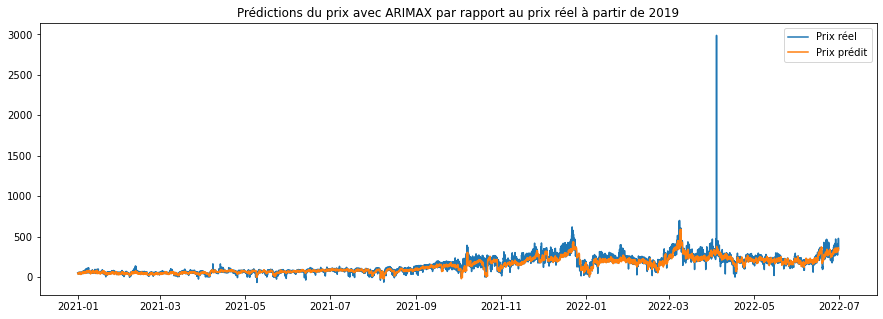

In [15]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(test_data2['Date'], predictions2, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMAX par rapport au prix réel à partir de 2019')
plt.show()

In [16]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list3 = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list3.append(mae3)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


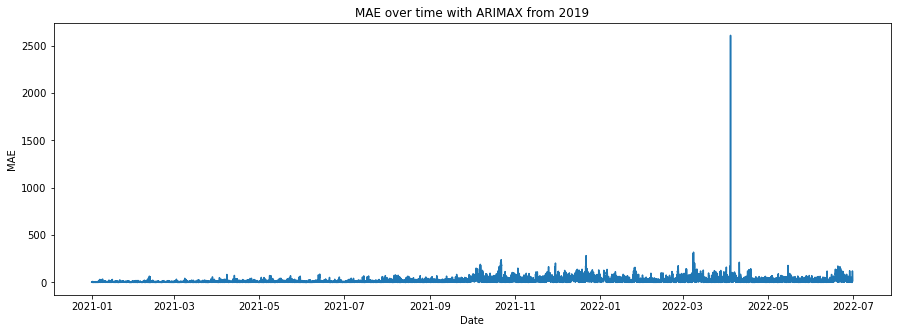

In [17]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], mae_list3)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMAX from 2019')
plt.show()

In [18]:
# Create an empty array to store the residuals
residuals2 = []


# Iterate over each point in the test set
for i in range(len(predictions2)):
    # Calculate the residuals
    residuals2.append(test_data2.iloc[i, 1] - predictions2[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am2 = arch_model(residuals2, x=predictions2, vol='GARCH', p=1, q=1)
res2 = am2.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts2 = []
for i in range(0, len(test_data2), 24):
    forecast2 = res2.forecast(horizon=24)
    garch_forecasts2.extend(forecast2.variance.values[-1, :])

print("GARCH forecasts2 :", garch_forecasts2)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 81392.21603916609
Iteration:      2,   Func. Count:     13,   Neg. LLF: 61802.00234489751
Iteration:      3,   Func. Count:     19,   Neg. LLF: 59683.0219075401
Iteration:      4,   Func. Count:     25,   Neg. LLF: 59036.92361907726
Iteration:      5,   Func. Count:     30,   Neg. LLF: 59006.47176998942
Iteration:      6,   Func. Count:     35,   Neg. LLF: 59004.04472359726
Iteration:      7,   Func. Count:     40,   Neg. LLF: 59003.917249925755
Iteration:      8,   Func. Count:     45,   Neg. LLF: 59003.91058374261
Iteration:      9,   Func. Count:     50,   Neg. LLF: 59003.91059526453
Iteration:     10,   Func. Count:     55,   Neg. LLF: 59005.598290466885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 59003.910595149944
            Iterations: 11
            Function evaluations: 59
            Gradient evaluations: 10


C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

GARCH forecasts2 : [458.63668241048003, 527.494814183555, 596.3529420908136, 665.2110661322562, 734.0691863078827, 802.9273026176936, 871.785415061689, 940.6435236398692, 1009.5016283522342, 1078.3597291987844, 1147.2178261795198, 1216.075919294441, 1284.9340085435483, 1353.7920939268413, 1422.6501754443207, 1491.508253095987, 1560.3663268818393, 1629.224396801879, 1698.0824628561056, 1766.9405250445197, 1835.7985833671216, 1904.656637823911, 1973.5146884148885, 2042.3727351400544, 458.63668241048003, 527.494814183555, 596.3529420908136, 665.2110661322562, 734.0691863078827, 802.9273026176936, 871.785415061689, 940.6435236398692, 1009.5016283522342, 1078.3597291987844, 1147.2178261795198, 1216.075919294441, 1284.9340085435483, 1353.7920939268413, 1422.6501754443207, 1491.508253095987, 1560.3663268818393, 1629.224396801879, 1698.0824628561056, 1766.9405250445197, 1835.7985833671216, 1904.656637823911, 1973.5146884148885, 2042.3727351400544, 458.63668241048003, 527.494814183555, 596.3529

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

In [19]:
observations2 = np.array(garch_forecasts2)
# Créer le filtre de Kalman
kf2 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations2[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means2, filtered_state_covariances2 = kf2.filter(observations2)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions2 = filtered_state_means2.flatten()

print(filtered_volatility_predictions2)

[ 458.63668241  481.89340241  511.42644958 ... 1451.23084661 1500.91305631
 1552.41936601]


In [21]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts2 = []
min_length = min(len(filtered_volatility_predictions2), len(predictions2))
for i in range(min_length):
    adjusted_forecasts2.append(predictions2[i] * np.sqrt(filtered_volatility_predictions2[i]) * 0.04)  # Adjust the scaling factor as needed

# Create a CSV file to store the predictions
with open('predictions_ARIMAX-GARCH.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the predictions to the CSV file
    for prediction in adjusted_forecasts2:
        writer.writerow([prediction])

# Print a message indicating that the predictions have been saved
print("Predictions saved to predictions_ARIMAX-GARCH.csv")

Predictions saved to predictions_ARIMAX-GARCH.csv


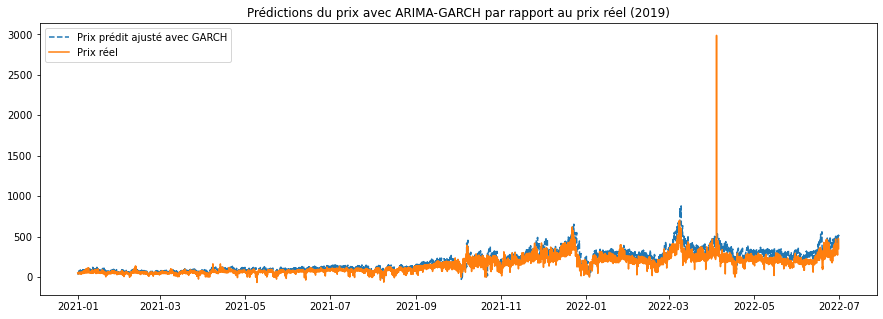

In [22]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

In [ ]:
----------------- stop

### Données Fournisseur

Objectif : comparer les prédictions fournisseurs avec les prédictions du modèle ARIMA-GARCH et aussi avec les données réels (ENTSOE)

In [36]:
# Load the dataset into a Pandas DataFrame
df_v = pd.read_csv('FR_fournisseur.csv')
df_v

Date_Chicago  price_prediction_J1
0      2019-04-15 00:00:00               61.173
1      2019-04-15 01:00:00               63.837
2      2019-04-15 02:00:00               64.166
3      2019-04-15 03:00:00               61.356
4      2019-04-15 04:00:00               55.703
...                    ...                  ...
26488  2022-04-14 19:00:00              209.105
26489  2022-04-14 20:00:00              201.155
26490  2022-04-14 21:00:00              200.503
26491  2022-04-14 22:00:00              206.363
26492  2022-04-14 23:00:00              230.759

[26493 rows x 2 columns]

In [37]:
dfb2 = df_v

In [38]:
dfb2

Date_Chicago  price_prediction_J1
0      2019-04-15 00:00:00               61.173
1      2019-04-15 01:00:00               63.837
2      2019-04-15 02:00:00               64.166
3      2019-04-15 03:00:00               61.356
4      2019-04-15 04:00:00               55.703
...                    ...                  ...
26488  2022-04-14 19:00:00              209.105
26489  2022-04-14 20:00:00              201.155
26490  2022-04-14 21:00:00              200.503
26491  2022-04-14 22:00:00              206.363
26492  2022-04-14 23:00:00              230.759

[26493 rows x 2 columns]

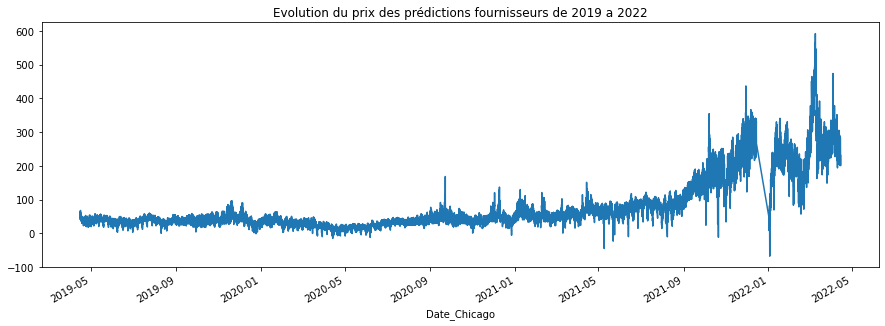

In [39]:
df_date2 = df_v

# Convertir la colonne Date en datetime
df_date2['Date_Chicago'] = pd.to_datetime(df_date2['Date_Chicago'])

# Définir la colonne Date comme index du dataframe
df_date2.set_index('Date_Chicago', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date2['price_prediction_J1'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix des prédictions fournisseurs de 2019 a 2022')

# Afficher le graphique
plt.show()

In [45]:
dfb2 = dfb2.reset_index()
dfb2

Date_Chicago  price_prediction_J1
0     2019-04-15 00:00:00               61.173
1     2019-04-15 01:00:00               63.837
2     2019-04-15 02:00:00               64.166
3     2019-04-15 03:00:00               61.356
4     2019-04-15 04:00:00               55.703
...                   ...                  ...
26488 2022-04-14 19:00:00              209.105
26489 2022-04-14 20:00:00              201.155
26490 2022-04-14 21:00:00              200.503
26491 2022-04-14 22:00:00              206.363
26492 2022-04-14 23:00:00              230.759

[26493 rows x 2 columns]

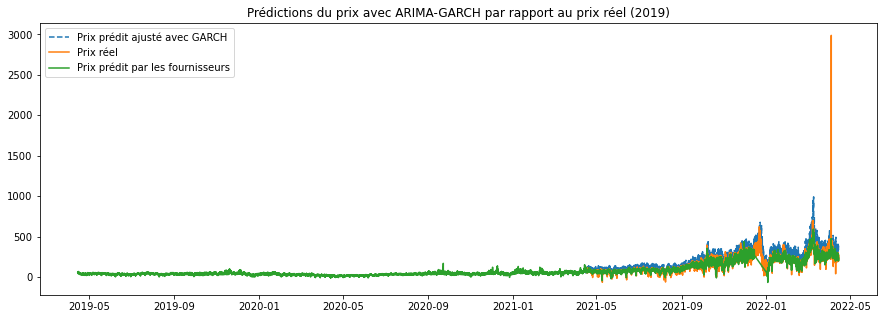

In [46]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(dfb2['Date_Chicago'], dfb2['price_prediction_J1'], label='Prix prédit par les fournisseurs')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

In [47]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [52]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts2)):
    maef = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_f.append(maef)

mae_list_a = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list_a.append(mae3)
    
mae_list_e = []
for i in range(len(test_data_v)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [test_data_v.iloc[i, 1]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_f))
print("MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_a))
print("MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_e))

MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) : 76.8086441522601
MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) : 26.264020802363785
MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) : 53.97541666666667


In [58]:
stamp = dfb2.loc[(dfb2['Date_Chicago'] >= '2021-03-05 00:00:00') & (dfb2['Date_Chicago'] <= '2021-05-05 00:00:00')]
entsoe_s = dfb.loc[(dfb['Date'] >= '2021-03-05 00:00:00') & (dfb['Date'] <= '2021-05-05 00:00:00')]

mae_e = []
for i in range(len(stamp)):
    mae = mean_absolute_error([entsoe_s.iloc[i, 1]], [stamp.iloc[i, 1]])
    mae_e.append(mae)
    
print(statistics.mean(mae_e))

16.82753893442623


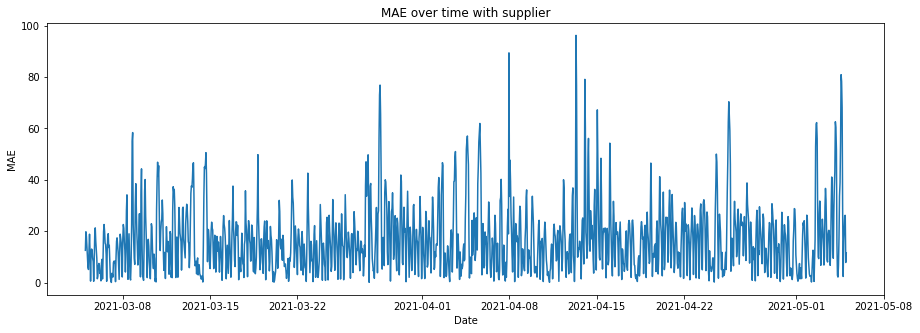

In [57]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(stamp['Date_Chicago'], mae_e)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with supplier')
plt.show()

In [ ]:
stop

# -----------------------------------------------------------

In [ ]:
dfb2 = dfb2.reset_index()

In [ ]:
dfb2.columns

In [ ]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [ ]:
test_data_v

In [ ]:
# Set the length of the training set
train_len4 = len(train_data_v)
#print(train_len)

# Create an empty array to store the predictions
predictions_v = []

# Iterate over each point in the test set
for i in range(0, len(test_data_v), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset3 = train_data_v.iloc[:train_len4, :]
    else:
        train_data_subset3 = pd.concat([train_data_v.iloc[i:, :], test_data_v.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model3 = ARIMA(train_data_subset3.iloc[:, 1], order=(1,1,1))
    result3 = model3.fit()
    
    # Make one-day-ahead forecasts
    forecast3 = result3.forecast(steps=24)
    print("prédictions_v :", forecast3)
    
    # Store the forecasts in the predictions array
    predictions_v.extend(forecast3)

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], predictions_v, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel (données fournisseurs)')
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list4 = []
for i in range(len(predictions_v)):
    mae4 = mean_absolute_error([test_data_v.iloc[i, 1]], [predictions_v[i]])
    mae_list4.append(mae4)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


In [ ]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], mae_list4)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA (suppliers data)')
plt.show()

In [ ]:
# Create an empty array to store the residuals
residuals3 = []


# Iterate over each point in the test set
for i in range(len(predictions_v)):
    # Calculate the residuals
    residuals3.append(test_data_v.iloc[i, 1] - predictions_v[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am3 = arch_model(residuals3, x=predictions_v, vol='GARCH', p=1, q=1)
res3 = am3.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts3 = []
for i in range(0, len(test_data_v), 24):
    forecast3 = res3.forecast(horizon=24)
    garch_forecasts3.extend(forecast3.variance.values[-1, :])

print("GARCH forecasts3 :", garch_forecasts3)

In [ ]:
observations3 = np.array(garch_forecasts3)
# Créer le filtre de Kalman
kf3 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations3[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means3, filtered_state_covariances3 = kf3.filter(observations3)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions3 = filtered_state_means3.flatten()

print(filtered_volatility_predictions3)

In [ ]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts3 = []
for i in range(len(filtered_volatility_predictions3)):
    adjusted_forecasts3.append(predictions_v[i] * np.sqrt(filtered_volatility_predictions3[i]) * 0.02) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], adjusted_forecasts3, label='Prix prédit ajusté avec GARCH')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (données fournisseurs)")
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts3)):
    maef = mean_absolute_error([test_data_v.iloc[i, 1]], [adjusted_forecasts3[i]])
    mae_list_f.append(maef)
    
mae_list_e = []
for i in range(len(adjusted_forecasts2)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour ARIMA-GARCH (ENTSOE) :", statistics.mean(mae_list_e))
print("MAE moyenne pour ARIMA-GARCH (fournisseurs) :", statistics.mean(mae_list_f))
